In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\deera\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_data(file_name):
    df = pd.read_csv(file_name)
    return df

# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

In [3]:
df = read_data('train.csv')
df_test = read_data('test.csv')
test_ids = df_test['Id']
print(df.shape, df_test.shape)
df.describe()

(1460, 81) (1459, 80)


Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 38 columns]

In [4]:
# missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

In [5]:
# 누락된 값이 있는 컬럼 제거
columns = df.isnull().sum()
delete_columns = columns[columns > 1]
print(delete_columns)

for c in delete_columns.index:
    del df[c]
    del df_test[c]
    
# Electrical 1개만 누락이므로 row를 제거
print(df[df['Electrical'].isnull()].index)
df = df.drop(df[df['Electrical'].isnull()].index)

print(df.shape)
df.isnull().sum().max()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Int64Index([1379], dtype='int64')
(1459, 63)


0

In [6]:
# MSSubClass는 숫자지만 category로 봐야함
df['MSSubClass'] = df['MSSubClass'].astype('object')
df_test['MSSubClass'] = df_test['MSSubClass'].astype('object')

In [7]:
# object 다시 돌아보자!
# 'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
#       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
#       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
#       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
#       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
#       'Functional', 'PavedDrive', 'SaleType', 'SaleCondition'
str_cols = df.select_dtypes(['object']).columns
for col in str_cols:
    print(pd.value_counts(df[col]))
    print("\n")

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      57
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64


RL         1150
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


Pave    1453
Grvl       6
Name: Street, dtype: int64


Reg    924
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


Lvl    1310
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


AllPub    1458
NoSeWa       1
Name: Utilities, dtype: int64


Inside     1051
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


Gtl    1381
Mod      65
Sev      13
Name: LandSlope, dtype: int64


NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      37
IDOTRR      

In [8]:
# Street 제거 (Pave    1453 Grvl       6)
drop_cols = ['Street']
df = df.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)

In [9]:
# category지만 숫자로 처리가능한 것
# Utilities AllPub=3,NoSewr=2,NoSeWa=1,ELO=0
# 그런데 1개 빼고 다 AllPub... 일단 살림
utilities_change = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
df.replace(utilities_change, inplace=True)
df_test.replace(utilities_change, inplace=True)

# LandSlope: Slope of property 편차가 크다
# Gtl:3, Mod:2, Sev:1
# 살려봄 
landSlope_change = {'Gtl':3, 'Mod':2, 'Sev':1}
df.replace(landSlope_change, inplace=True)
df_test.replace(landSlope_change, inplace=True)

# 기타, ex gd 등을 포함한 category. 어느 feature는 na가 없거나 po가 없거나 함
# change = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':-1}
# df.replace(change, inplace=True)
# df_test.replace(change, inplace=True)

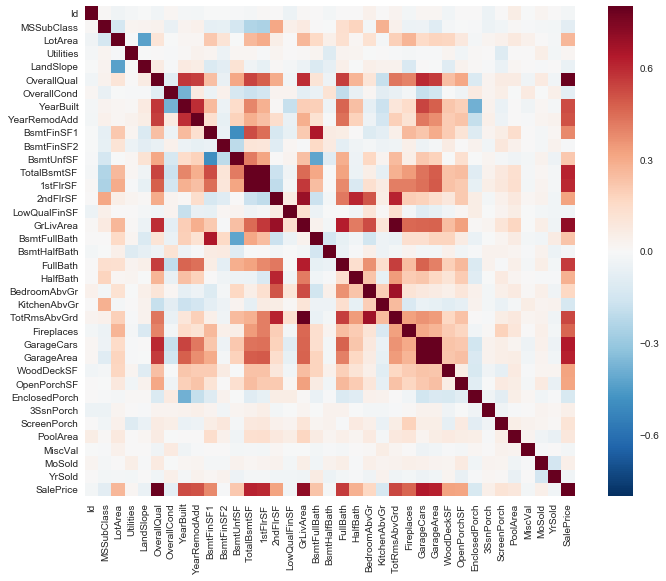

In [10]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

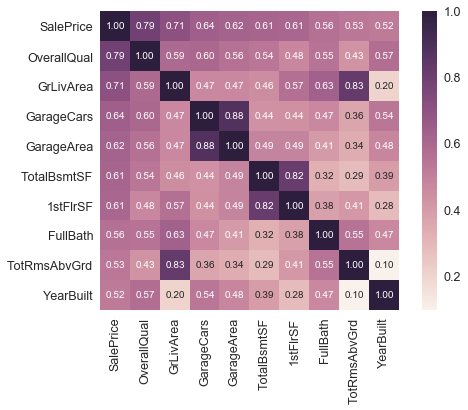

In [11]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [12]:
# SalePrice와 관계 없는 컬럼 제거
ntrelated_point = 0.2
print(corrmat[abs(corrmat['SalePrice']) < ntrelated_point]['SalePrice'])
nt_corr_cols = corrmat[abs(corrmat['SalePrice']) < ntrelated_point].index

for c in nt_corr_cols:
    del df[c]
    del df_test[c]

Id              -0.021756
MSSubClass      -0.084230
Utilities        0.014317
LandSlope       -0.051127
OverallCond     -0.077924
BsmtFinSF2      -0.011412
LowQualFinSF    -0.025620
BsmtHalfBath    -0.016873
BedroomAbvGr     0.168235
KitchenAbvGr    -0.135935
EnclosedPorch   -0.128627
3SsnPorch        0.044571
ScreenPorch      0.111419
PoolArea         0.092397
MiscVal         -0.021200
MoSold           0.046380
YrSold          -0.028907
Name: SalePrice, dtype: float64


In [13]:
# 숫자가 아닌 column 처리
str_columns = df.select_dtypes(['object']).columns
print(str_columns)
    
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
       'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


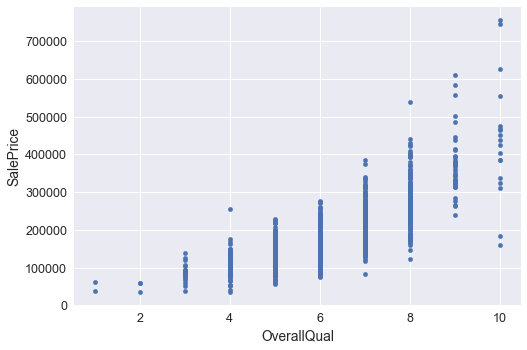

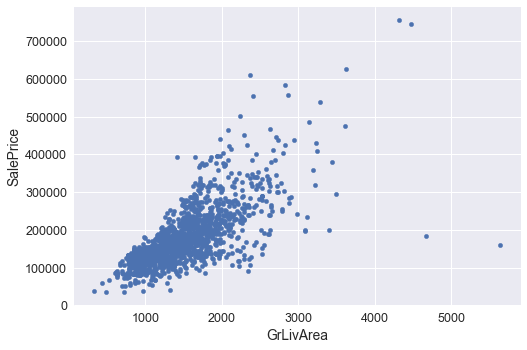

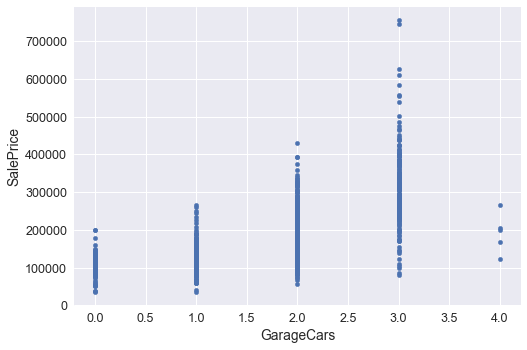

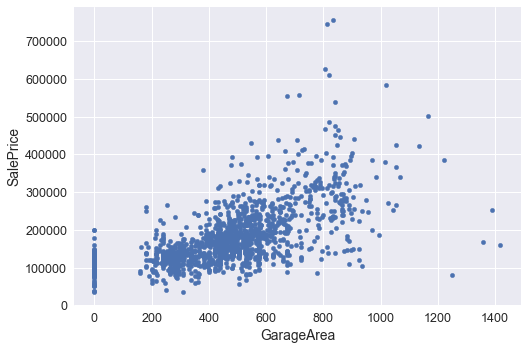

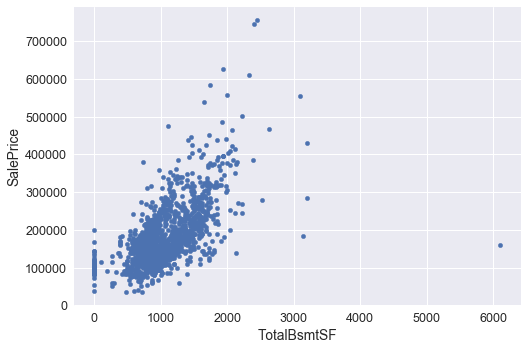

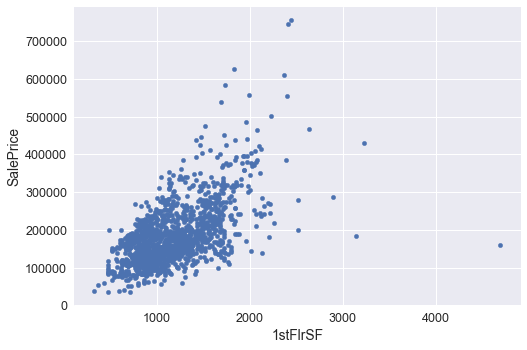

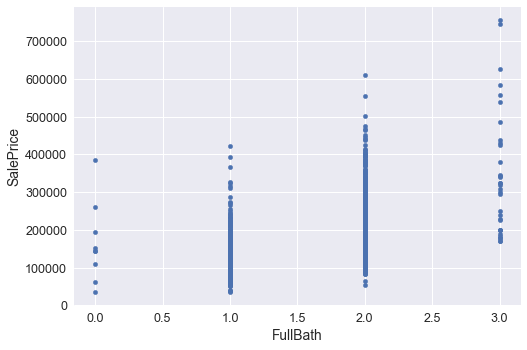

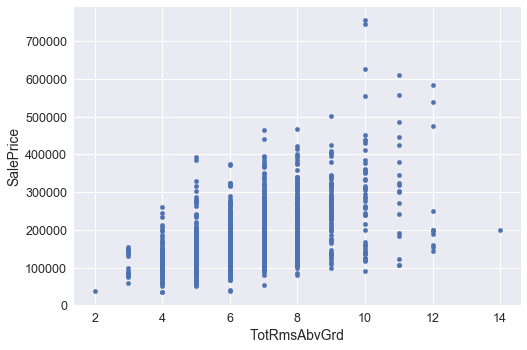

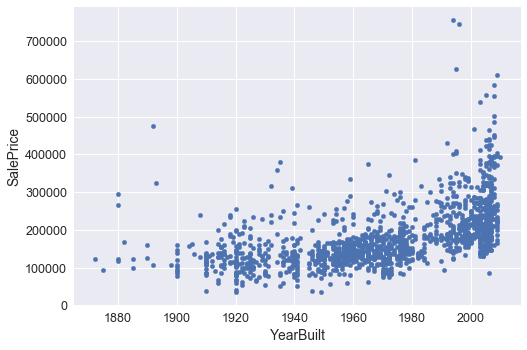

In [14]:
# outliers 제거 (가장 상관 관계가 높은 feature들에서만 처리)
outliar_cols = cols[cols != 'SalePrice']
print(outliar_cols)
for col in outliar_cols:
    data = pd.concat([df['SalePrice'], df[col]], axis=1)
    data.plot.scatter(x=col, y='SalePrice')

In [15]:
# 눈으로 보고 x축으로 튀어나온 값 제거
df.sort_values(by='GrLivArea', ascending=False)[:2]
df = df.drop([1298, 523], )
df.sort_values(by='GarageArea', ascending=False)[:3]
df = df.drop([581, 1190, 1061], )
df.sort_values(by='TotalBsmtSF', ascending=False)[:1] # 위에서 겹쳐서 제거됨

LotArea  OverallQual  YearBuilt  YearRemodAdd  BsmtFinSF1  BsmtUnfSF  \
332    10655            8       2003          2004        1124       1603   

     TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea          ...            \
332         3206      1629         0       1629          ...             

     SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
332               0             0             0            1   

     SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
332                      0                      0                     0   

     SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
332                     0                     1                      0  

[1 rows x 200 columns]

In [16]:
# string object로 one-hot coding을 했을 경우,
# 정의된 집합을 기준으로 하지 않아 데이터 기준임
# 그래서 차이가 발생함
plus_cols = df.columns.difference(df_test.columns).drop('SalePrice') # df가 가지고, df_test에 없는거 => 더미컬럼 추가
minus_cols = df_test.columns.difference(df.columns) # df_test가 가지고, df에 없는거 => 학습되지 않는 데이터이므로 제거
print(plus_cols, minus_cols)

for c in plus_cols:
    df_test[c] = 0

for c in minus_cols:
    del df_test[c]

# 컬럼 순서 맞추기
# df.reindex_axis(sorted(df.columns), axis=1) 같은 걸 쓸 수 있겠지만 그러면, label이 끝에 있는 걸 보장 못함
# 라벨 떼고 할수 있겠지만 그러면 테스트와 러닝 셋 구분하는데 각자
df_test = df_test[df.columns.drop('SalePrice')]
    
print(df_test.shape, df.shape)
plus_cols = df.columns.difference(df_test.columns)
minus_cols = df_test.columns.difference(df.columns)
print(plus_cols, minus_cols)

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW',
       'HouseStyle_2.5Fin', 'RoofMatl_ClyTile', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll'],
      dtype='object') Index([], dtype='object')
(1459, 199) (1454, 200)
Index(['SalePrice'], dtype='object') Index([], dtype='object')


In [17]:
input_data = df.drop('SalePrice', axis=1).values
target_data = df['SalePrice'].values

# for submit test
test_data = df_test.values
print(test_data.shape)

# normalize
# print(stats.describe(input_data))

(1459, 199)


In [18]:
rnd_indices = np.random.rand(df.shape[0]) < 1.1

train_input = input_data[rnd_indices]
train_target = target_data[rnd_indices]

test_input = input_data[~rnd_indices]
test_target = target_data[~rnd_indices]

print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(1454, 199) (1454,)
(0, 199) (0,)


In [19]:
units=train_input.shape[1] - 10
model = keras.models.Sequential()
model.add(keras.layers.Dense(units, activation='relu', input_dim=train_input.shape[1]))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units, activation='relu'))
model.add(keras.layers.Dense(1))

In [20]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
# sess = tf.Session(config=tf.ConfigProto(
#   allow_soft_placement=True, log_device_placement=True))
# keras.backend.set_session(sess)

# if 'session' in locals() and session is not None:
#     print('Close interactive session')
#     session.close()

In [21]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', 'mape'])
model.fit(train_input, np.vstack(train_target), epochs=30000, batch_size=1500)

Epoch 1/30000
1454/1454 [==============================] - 3s 2ms/step - loss: 39036231680.0000 - mean_absolute_error: 180870.3906 - mean_squared_error: 39036231680.0000 - mean_absolute_percentage_error: 99.9372
Epoch 2/30000
1454/1454 [==============================] - 0s 4us/step - loss: 38745931776.0000 - mean_absolute_error: 180154.9062 - mean_squared_error: 38745931776.0000 - mean_absolute_percentage_error: 99.5156
Epoch 3/30000
1454/1454 [==============================] - 0s 4us/step - loss: 38434062336.0000 - mean_absolute_error: 179358.0000 - mean_squared_error: 38434062336.0000 - mean_absolute_percentage_error: 99.0400
Epoch 4/30000
1454/1454 [==============================] - 0s 4us/step - loss: 38058110976.0000 - mean_absolute_error: 178419.1094 - mean_squared_error: 38058110976.0000 - mean_absolute_percentage_error: 98.4871
Epoch 5/30000
1454/1454 [==============================] - 0s 4us/step - loss: 37685239808.0000 - mean_absolute_error: 177432.0938 - mean_squared_error:

Epoch 40/30000
1454/1454 [==============================] - 0s 6us/step - loss: 10688323584.0000 - mean_absolute_error: 57041.9570 - mean_squared_error: 10688323584.0000 - mean_absolute_percentage_error: 28.2378
Epoch 41/30000
1454/1454 [==============================] - 0s 5us/step - loss: 10624550912.0000 - mean_absolute_error: 57899.4336 - mean_squared_error: 10624550912.0000 - mean_absolute_percentage_error: 28.3121
Epoch 42/30000
1454/1454 [==============================] - 0s 4us/step - loss: 9835529216.0000 - mean_absolute_error: 57908.8438 - mean_squared_error: 9835529216.0000 - mean_absolute_percentage_error: 28.3820
Epoch 43/30000
1454/1454 [==============================] - 0s 5us/step - loss: 8715575296.0000 - mean_absolute_error: 58400.0391 - mean_squared_error: 8715575296.0000 - mean_absolute_percentage_error: 28.5355
Epoch 44/30000
1454/1454 [==============================] - 0s 4us/step - loss: 9042867200.0000 - mean_absolute_error: 58482.8398 - mean_squared_error: 9042

Epoch 79/30000
1454/1454 [==============================] - 0s 4us/step - loss: 3254934272.0000 - mean_absolute_error: 40254.9336 - mean_squared_error: 3254934272.0000 - mean_absolute_percentage_error: 25.5239
Epoch 80/30000
1454/1454 [==============================] - 0s 4us/step - loss: 3280766464.0000 - mean_absolute_error: 40834.2461 - mean_squared_error: 3280766464.0000 - mean_absolute_percentage_error: 25.8787
Epoch 81/30000
1454/1454 [==============================] - 0s 4us/step - loss: 3209228800.0000 - mean_absolute_error: 40189.9492 - mean_squared_error: 3209228800.0000 - mean_absolute_percentage_error: 25.1088
Epoch 82/30000
1454/1454 [==============================] - 0s 5us/step - loss: 3230818304.0000 - mean_absolute_error: 39825.8359 - mean_squared_error: 3230818304.0000 - mean_absolute_percentage_error: 24.8292
Epoch 83/30000
1454/1454 [==============================] - 0s 5us/step - loss: 3046636544.0000 - mean_absolute_error: 38772.7930 - mean_squared_error: 30466365

Epoch 118/30000
1454/1454 [==============================] - 0s 5us/step - loss: 2611800832.0000 - mean_absolute_error: 36547.7266 - mean_squared_error: 2611800832.0000 - mean_absolute_percentage_error: 22.9115
Epoch 119/30000
1454/1454 [==============================] - 0s 6us/step - loss: 2667662080.0000 - mean_absolute_error: 36431.5273 - mean_squared_error: 2667662080.0000 - mean_absolute_percentage_error: 22.8711
Epoch 120/30000
1454/1454 [==============================] - 0s 4us/step - loss: 2561420032.0000 - mean_absolute_error: 35792.0156 - mean_squared_error: 2561420032.0000 - mean_absolute_percentage_error: 22.4956
Epoch 121/30000
1454/1454 [==============================] - 0s 4us/step - loss: 2673094912.0000 - mean_absolute_error: 36585.9844 - mean_squared_error: 2673094912.0000 - mean_absolute_percentage_error: 22.7518
Epoch 122/30000
1454/1454 [==============================] - 0s 5us/step - loss: 2593931264.0000 - mean_absolute_error: 35563.8750 - mean_squared_error: 259

Epoch 157/30000
1454/1454 [==============================] - 0s 5us/step - loss: 2033704704.0000 - mean_absolute_error: 31983.5078 - mean_squared_error: 2033704704.0000 - mean_absolute_percentage_error: 19.5105
Epoch 158/30000
1454/1454 [==============================] - 0s 5us/step - loss: 2147128448.0000 - mean_absolute_error: 32140.8262 - mean_squared_error: 2147128448.0000 - mean_absolute_percentage_error: 19.5263
Epoch 159/30000
1454/1454 [==============================] - 0s 5us/step - loss: 2208429312.0000 - mean_absolute_error: 32177.0957 - mean_squared_error: 2208429312.0000 - mean_absolute_percentage_error: 19.5956
Epoch 160/30000
1454/1454 [==============================] - 0s 6us/step - loss: 2216369152.0000 - mean_absolute_error: 32921.3242 - mean_squared_error: 2216369152.0000 - mean_absolute_percentage_error: 20.1665
Epoch 161/30000
1454/1454 [==============================] - 0s 5us/step - loss: 2118265600.0000 - mean_absolute_error: 31114.1699 - mean_squared_error: 211

Epoch 196/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1911323648.0000 - mean_absolute_error: 30601.3047 - mean_squared_error: 1911323648.0000 - mean_absolute_percentage_error: 18.3059
Epoch 197/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1788176896.0000 - mean_absolute_error: 29748.2031 - mean_squared_error: 1788176896.0000 - mean_absolute_percentage_error: 17.9112
Epoch 198/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1693735680.0000 - mean_absolute_error: 29391.0293 - mean_squared_error: 1693735680.0000 - mean_absolute_percentage_error: 17.7157
Epoch 199/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1792608256.0000 - mean_absolute_error: 29773.3516 - mean_squared_error: 1792608256.0000 - mean_absolute_percentage_error: 17.5987
Epoch 200/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1844839296.0000 - mean_absolute_error: 30154.2285 - mean_squared_error: 184

Epoch 235/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1683171584.0000 - mean_absolute_error: 28881.8438 - mean_squared_error: 1683171584.0000 - mean_absolute_percentage_error: 17.1858
Epoch 236/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1696726656.0000 - mean_absolute_error: 29497.3926 - mean_squared_error: 1696726656.0000 - mean_absolute_percentage_error: 17.8100
Epoch 237/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1767848832.0000 - mean_absolute_error: 29932.4180 - mean_squared_error: 1767848832.0000 - mean_absolute_percentage_error: 17.9405
Epoch 238/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1806223488.0000 - mean_absolute_error: 29842.0020 - mean_squared_error: 1806223488.0000 - mean_absolute_percentage_error: 17.8055
Epoch 239/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1683632256.0000 - mean_absolute_error: 28999.0527 - mean_squared_error: 168

Epoch 274/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1746841472.0000 - mean_absolute_error: 29237.1367 - mean_squared_error: 1746841472.0000 - mean_absolute_percentage_error: 17.5433
Epoch 275/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1690313472.0000 - mean_absolute_error: 28965.8066 - mean_squared_error: 1690313472.0000 - mean_absolute_percentage_error: 17.4214
Epoch 276/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1632728064.0000 - mean_absolute_error: 28634.3789 - mean_squared_error: 1632728064.0000 - mean_absolute_percentage_error: 17.2383
Epoch 277/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1782619264.0000 - mean_absolute_error: 29667.0020 - mean_squared_error: 1782619264.0000 - mean_absolute_percentage_error: 17.5273
Epoch 278/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1748641280.0000 - mean_absolute_error: 29725.6172 - mean_squared_error: 174

Epoch 313/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1685250432.0000 - mean_absolute_error: 28987.9102 - mean_squared_error: 1685250432.0000 - mean_absolute_percentage_error: 17.2393
Epoch 314/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1572547456.0000 - mean_absolute_error: 28457.4805 - mean_squared_error: 1572547456.0000 - mean_absolute_percentage_error: 17.0592
Epoch 315/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1585255040.0000 - mean_absolute_error: 27960.9766 - mean_squared_error: 1585255040.0000 - mean_absolute_percentage_error: 16.7820
Epoch 316/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1595813504.0000 - mean_absolute_error: 28037.5215 - mean_squared_error: 1595813504.0000 - mean_absolute_percentage_error: 16.4895
Epoch 317/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1601522304.0000 - mean_absolute_error: 28494.5586 - mean_squared_error: 160

Epoch 352/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1539677184.0000 - mean_absolute_error: 27213.2871 - mean_squared_error: 1539677184.0000 - mean_absolute_percentage_error: 16.4417
Epoch 353/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1591055744.0000 - mean_absolute_error: 27954.0879 - mean_squared_error: 1591055744.0000 - mean_absolute_percentage_error: 16.6635
Epoch 354/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1522639744.0000 - mean_absolute_error: 27196.9707 - mean_squared_error: 1522639744.0000 - mean_absolute_percentage_error: 16.2649
Epoch 355/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1581124224.0000 - mean_absolute_error: 28131.3613 - mean_squared_error: 1581124224.0000 - mean_absolute_percentage_error: 16.6772
Epoch 356/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1602740992.0000 - mean_absolute_error: 27981.8574 - mean_squared_error: 160

Epoch 391/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1503438336.0000 - mean_absolute_error: 27271.5762 - mean_squared_error: 1503438336.0000 - mean_absolute_percentage_error: 16.2512
Epoch 392/30000
1454/1454 [==============================] - 0s 7us/step - loss: 1507923712.0000 - mean_absolute_error: 27763.7461 - mean_squared_error: 1507923712.0000 - mean_absolute_percentage_error: 16.5396
Epoch 393/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1473822080.0000 - mean_absolute_error: 27326.5176 - mean_squared_error: 1473822080.0000 - mean_absolute_percentage_error: 16.3532
Epoch 394/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1596766464.0000 - mean_absolute_error: 27914.5000 - mean_squared_error: 1596766464.0000 - mean_absolute_percentage_error: 16.5338
Epoch 395/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1482145536.0000 - mean_absolute_error: 27363.7637 - mean_squared_error: 148

Epoch 430/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1562193792.0000 - mean_absolute_error: 27485.9473 - mean_squared_error: 1562193792.0000 - mean_absolute_percentage_error: 16.3515
Epoch 431/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1413924992.0000 - mean_absolute_error: 26700.3613 - mean_squared_error: 1413924992.0000 - mean_absolute_percentage_error: 15.8675
Epoch 432/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1418754816.0000 - mean_absolute_error: 26852.5664 - mean_squared_error: 1418754816.0000 - mean_absolute_percentage_error: 16.0720
Epoch 433/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1504195072.0000 - mean_absolute_error: 27399.4355 - mean_squared_error: 1504195072.0000 - mean_absolute_percentage_error: 16.3857
Epoch 434/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1437757312.0000 - mean_absolute_error: 26785.9199 - mean_squared_error: 143

Epoch 469/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1458427520.0000 - mean_absolute_error: 26651.9648 - mean_squared_error: 1458427520.0000 - mean_absolute_percentage_error: 16.0468
Epoch 470/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1488124928.0000 - mean_absolute_error: 27099.6445 - mean_squared_error: 1488124928.0000 - mean_absolute_percentage_error: 16.2509
Epoch 471/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1484810624.0000 - mean_absolute_error: 26753.1172 - mean_squared_error: 1484810624.0000 - mean_absolute_percentage_error: 15.9029
Epoch 472/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1410760448.0000 - mean_absolute_error: 26570.9160 - mean_squared_error: 1410760448.0000 - mean_absolute_percentage_error: 15.7061
Epoch 473/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1466254208.0000 - mean_absolute_error: 26909.7422 - mean_squared_error: 146

Epoch 508/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1519733888.0000 - mean_absolute_error: 27045.9395 - mean_squared_error: 1519733888.0000 - mean_absolute_percentage_error: 16.0909
Epoch 509/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1499991936.0000 - mean_absolute_error: 27213.9473 - mean_squared_error: 1499991936.0000 - mean_absolute_percentage_error: 16.1829
Epoch 510/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1434057088.0000 - mean_absolute_error: 26784.8281 - mean_squared_error: 1434057088.0000 - mean_absolute_percentage_error: 16.0837
Epoch 511/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1411698688.0000 - mean_absolute_error: 26638.8223 - mean_squared_error: 1411698688.0000 - mean_absolute_percentage_error: 15.8167
Epoch 512/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1376695040.0000 - mean_absolute_error: 26107.0977 - mean_squared_error: 137

Epoch 547/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1442078080.0000 - mean_absolute_error: 26568.5039 - mean_squared_error: 1442078080.0000 - mean_absolute_percentage_error: 15.9451
Epoch 548/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1392962048.0000 - mean_absolute_error: 26409.3594 - mean_squared_error: 1392962048.0000 - mean_absolute_percentage_error: 15.8084
Epoch 549/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1385940608.0000 - mean_absolute_error: 26424.9238 - mean_squared_error: 1385940608.0000 - mean_absolute_percentage_error: 15.9120
Epoch 550/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1397735808.0000 - mean_absolute_error: 26402.4570 - mean_squared_error: 1397735808.0000 - mean_absolute_percentage_error: 15.8589
Epoch 551/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1353565568.0000 - mean_absolute_error: 26016.5176 - mean_squared_error: 135

Epoch 586/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1524300800.0000 - mean_absolute_error: 26017.8594 - mean_squared_error: 1524300800.0000 - mean_absolute_percentage_error: 15.4885
Epoch 587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1372504192.0000 - mean_absolute_error: 25931.1875 - mean_squared_error: 1372504192.0000 - mean_absolute_percentage_error: 15.6243
Epoch 588/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1382890496.0000 - mean_absolute_error: 26263.7148 - mean_squared_error: 1382890496.0000 - mean_absolute_percentage_error: 15.7673
Epoch 589/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1339236864.0000 - mean_absolute_error: 26299.1328 - mean_squared_error: 1339236864.0000 - mean_absolute_percentage_error: 16.0028
Epoch 590/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1397609600.0000 - mean_absolute_error: 26741.9648 - mean_squared_error: 139

Epoch 625/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1365193088.0000 - mean_absolute_error: 25839.6562 - mean_squared_error: 1365193088.0000 - mean_absolute_percentage_error: 15.4667
Epoch 626/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1340414976.0000 - mean_absolute_error: 26029.7246 - mean_squared_error: 1340414976.0000 - mean_absolute_percentage_error: 15.7093
Epoch 627/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1352704384.0000 - mean_absolute_error: 25885.5430 - mean_squared_error: 1352704384.0000 - mean_absolute_percentage_error: 15.7128
Epoch 628/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1431820032.0000 - mean_absolute_error: 26296.9160 - mean_squared_error: 1431820032.0000 - mean_absolute_percentage_error: 15.7286
Epoch 629/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1327179136.0000 - mean_absolute_error: 26008.2754 - mean_squared_error: 132

Epoch 664/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1395857408.0000 - mean_absolute_error: 26127.9375 - mean_squared_error: 1395857408.0000 - mean_absolute_percentage_error: 15.7072
Epoch 665/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1354633856.0000 - mean_absolute_error: 26189.8242 - mean_squared_error: 1354633856.0000 - mean_absolute_percentage_error: 15.5405
Epoch 666/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1320976256.0000 - mean_absolute_error: 25524.6816 - mean_squared_error: 1320976256.0000 - mean_absolute_percentage_error: 15.4535
Epoch 667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1370039936.0000 - mean_absolute_error: 25870.6875 - mean_squared_error: 1370039936.0000 - mean_absolute_percentage_error: 15.3507
Epoch 668/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1319780224.0000 - mean_absolute_error: 25597.0684 - mean_squared_error: 131

Epoch 703/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1310118784.0000 - mean_absolute_error: 25913.3008 - mean_squared_error: 1310118784.0000 - mean_absolute_percentage_error: 15.4222
Epoch 704/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1382234240.0000 - mean_absolute_error: 25944.2754 - mean_squared_error: 1382234240.0000 - mean_absolute_percentage_error: 15.7162
Epoch 705/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1284351488.0000 - mean_absolute_error: 25222.3320 - mean_squared_error: 1284351488.0000 - mean_absolute_percentage_error: 15.2173
Epoch 706/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1315475072.0000 - mean_absolute_error: 25340.0137 - mean_squared_error: 1315475072.0000 - mean_absolute_percentage_error: 15.2916
Epoch 707/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1295390464.0000 - mean_absolute_error: 25633.9453 - mean_squared_error: 129

Epoch 742/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1302986240.0000 - mean_absolute_error: 25529.1582 - mean_squared_error: 1302986240.0000 - mean_absolute_percentage_error: 15.2313
Epoch 743/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1308915712.0000 - mean_absolute_error: 25403.1602 - mean_squared_error: 1308915712.0000 - mean_absolute_percentage_error: 15.4665
Epoch 744/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1327295872.0000 - mean_absolute_error: 25914.3691 - mean_squared_error: 1327295872.0000 - mean_absolute_percentage_error: 15.8471
Epoch 745/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1272806272.0000 - mean_absolute_error: 25687.8105 - mean_squared_error: 1272806272.0000 - mean_absolute_percentage_error: 15.5504
Epoch 746/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1312408064.0000 - mean_absolute_error: 25853.7285 - mean_squared_error: 131

Epoch 781/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1300218240.0000 - mean_absolute_error: 25630.1152 - mean_squared_error: 1300218240.0000 - mean_absolute_percentage_error: 15.2954
Epoch 782/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1324079360.0000 - mean_absolute_error: 25570.1875 - mean_squared_error: 1324079360.0000 - mean_absolute_percentage_error: 15.3559
Epoch 783/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1316648832.0000 - mean_absolute_error: 25164.5098 - mean_squared_error: 1316648832.0000 - mean_absolute_percentage_error: 15.1470
Epoch 784/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1282680192.0000 - mean_absolute_error: 25596.4727 - mean_squared_error: 1282680192.0000 - mean_absolute_percentage_error: 15.4558
Epoch 785/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1294134144.0000 - mean_absolute_error: 25356.4980 - mean_squared_error: 129

Epoch 820/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1381421568.0000 - mean_absolute_error: 25661.3418 - mean_squared_error: 1381421568.0000 - mean_absolute_percentage_error: 15.2168
Epoch 821/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1276464000.0000 - mean_absolute_error: 25412.6797 - mean_squared_error: 1276464000.0000 - mean_absolute_percentage_error: 15.3286
Epoch 822/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1310993280.0000 - mean_absolute_error: 25505.7637 - mean_squared_error: 1310993280.0000 - mean_absolute_percentage_error: 15.3495
Epoch 823/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1292186624.0000 - mean_absolute_error: 25219.1738 - mean_squared_error: 1292186624.0000 - mean_absolute_percentage_error: 15.2000
Epoch 824/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1253054976.0000 - mean_absolute_error: 25101.7227 - mean_squared_error: 125

Epoch 859/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1371314944.0000 - mean_absolute_error: 25819.6367 - mean_squared_error: 1371314944.0000 - mean_absolute_percentage_error: 15.3978
Epoch 860/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1183969280.0000 - mean_absolute_error: 24533.2441 - mean_squared_error: 1183969280.0000 - mean_absolute_percentage_error: 14.9187
Epoch 861/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1332597120.0000 - mean_absolute_error: 25210.1328 - mean_squared_error: 1332597120.0000 - mean_absolute_percentage_error: 14.9512
Epoch 862/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1210003968.0000 - mean_absolute_error: 24762.7129 - mean_squared_error: 1210003968.0000 - mean_absolute_percentage_error: 14.9546
Epoch 863/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1289137792.0000 - mean_absolute_error: 25284.0664 - mean_squared_error: 128

Epoch 898/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1216997632.0000 - mean_absolute_error: 24765.2070 - mean_squared_error: 1216997632.0000 - mean_absolute_percentage_error: 14.9911
Epoch 899/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1209912832.0000 - mean_absolute_error: 24538.0352 - mean_squared_error: 1209912832.0000 - mean_absolute_percentage_error: 14.7825
Epoch 900/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1264338048.0000 - mean_absolute_error: 25320.0293 - mean_squared_error: 1264338048.0000 - mean_absolute_percentage_error: 15.3907
Epoch 901/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1278348416.0000 - mean_absolute_error: 25304.9688 - mean_squared_error: 1278348416.0000 - mean_absolute_percentage_error: 15.1102
Epoch 902/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1249841152.0000 - mean_absolute_error: 25023.4121 - mean_squared_error: 124

Epoch 937/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1220680832.0000 - mean_absolute_error: 24604.6055 - mean_squared_error: 1220680832.0000 - mean_absolute_percentage_error: 14.9698
Epoch 938/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1274992512.0000 - mean_absolute_error: 25079.0957 - mean_squared_error: 1274992512.0000 - mean_absolute_percentage_error: 14.9996
Epoch 939/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1255059328.0000 - mean_absolute_error: 25298.2637 - mean_squared_error: 1255059328.0000 - mean_absolute_percentage_error: 15.1718
Epoch 940/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1263998336.0000 - mean_absolute_error: 25056.0391 - mean_squared_error: 1263998336.0000 - mean_absolute_percentage_error: 15.0330
Epoch 941/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1281469056.0000 - mean_absolute_error: 25334.7227 - mean_squared_error: 128

Epoch 976/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1283584256.0000 - mean_absolute_error: 25251.2910 - mean_squared_error: 1283584256.0000 - mean_absolute_percentage_error: 15.1134
Epoch 977/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1194713728.0000 - mean_absolute_error: 24644.9707 - mean_squared_error: 1194713728.0000 - mean_absolute_percentage_error: 14.9980
Epoch 978/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1205966848.0000 - mean_absolute_error: 24125.4023 - mean_squared_error: 1205966848.0000 - mean_absolute_percentage_error: 14.6722
Epoch 979/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1231254144.0000 - mean_absolute_error: 24687.6289 - mean_squared_error: 1231254144.0000 - mean_absolute_percentage_error: 14.8854
Epoch 980/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1219824768.0000 - mean_absolute_error: 24677.0371 - mean_squared_error: 121

Epoch 1015/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1249687168.0000 - mean_absolute_error: 25126.7188 - mean_squared_error: 1249687168.0000 - mean_absolute_percentage_error: 14.8410
Epoch 1016/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1224518016.0000 - mean_absolute_error: 24553.6895 - mean_squared_error: 1224518016.0000 - mean_absolute_percentage_error: 14.7684
Epoch 1017/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1176236416.0000 - mean_absolute_error: 24125.5898 - mean_squared_error: 1176236416.0000 - mean_absolute_percentage_error: 14.5752
Epoch 1018/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1222566784.0000 - mean_absolute_error: 24669.1250 - mean_squared_error: 1222566784.0000 - mean_absolute_percentage_error: 14.8336
Epoch 1019/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1228907520.0000 - mean_absolute_error: 24584.0293 - mean_squared_error

Epoch 1054/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1222288128.0000 - mean_absolute_error: 24673.0977 - mean_squared_error: 1222288128.0000 - mean_absolute_percentage_error: 14.8893
Epoch 1055/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1182251904.0000 - mean_absolute_error: 24474.3926 - mean_squared_error: 1182251904.0000 - mean_absolute_percentage_error: 14.7682
Epoch 1056/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1254972032.0000 - mean_absolute_error: 25069.6250 - mean_squared_error: 1254972032.0000 - mean_absolute_percentage_error: 14.9982
Epoch 1057/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1135611904.0000 - mean_absolute_error: 24375.3672 - mean_squared_error: 1135611904.0000 - mean_absolute_percentage_error: 14.4940
Epoch 1058/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1182386688.0000 - mean_absolute_error: 24391.9707 - mean_squared_error

Epoch 1093/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1195007616.0000 - mean_absolute_error: 24097.9863 - mean_squared_error: 1195007616.0000 - mean_absolute_percentage_error: 14.6939
Epoch 1094/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1215276544.0000 - mean_absolute_error: 24430.2344 - mean_squared_error: 1215276544.0000 - mean_absolute_percentage_error: 14.7860
Epoch 1095/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1195710208.0000 - mean_absolute_error: 24594.6348 - mean_squared_error: 1195710208.0000 - mean_absolute_percentage_error: 14.7055
Epoch 1096/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1265695232.0000 - mean_absolute_error: 24641.1504 - mean_squared_error: 1265695232.0000 - mean_absolute_percentage_error: 14.7469
Epoch 1097/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1180681856.0000 - mean_absolute_error: 24416.6309 - mean_squared_error

Epoch 1132/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1205195520.0000 - mean_absolute_error: 24756.7402 - mean_squared_error: 1205195520.0000 - mean_absolute_percentage_error: 14.8963
Epoch 1133/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1158268672.0000 - mean_absolute_error: 24243.6914 - mean_squared_error: 1158268672.0000 - mean_absolute_percentage_error: 14.3558
Epoch 1134/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1193501952.0000 - mean_absolute_error: 24274.6953 - mean_squared_error: 1193501952.0000 - mean_absolute_percentage_error: 14.2243
Epoch 1135/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1219889280.0000 - mean_absolute_error: 24779.4121 - mean_squared_error: 1219889280.0000 - mean_absolute_percentage_error: 14.8918
Epoch 1136/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1146216448.0000 - mean_absolute_error: 23963.4121 - mean_squared_error

Epoch 1171/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1174611968.0000 - mean_absolute_error: 23971.4277 - mean_squared_error: 1174611968.0000 - mean_absolute_percentage_error: 14.2863
Epoch 1172/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1134553600.0000 - mean_absolute_error: 23998.2090 - mean_squared_error: 1134553600.0000 - mean_absolute_percentage_error: 14.2986
Epoch 1173/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1146797952.0000 - mean_absolute_error: 23831.1914 - mean_squared_error: 1146797952.0000 - mean_absolute_percentage_error: 14.3351
Epoch 1174/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1221529344.0000 - mean_absolute_error: 24431.5957 - mean_squared_error: 1221529344.0000 - mean_absolute_percentage_error: 14.7556
Epoch 1175/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1120276096.0000 - mean_absolute_error: 23513.5215 - mean_squared_error

Epoch 1210/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1154553216.0000 - mean_absolute_error: 23834.4785 - mean_squared_error: 1154553216.0000 - mean_absolute_percentage_error: 14.5988
Epoch 1211/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1140353024.0000 - mean_absolute_error: 23627.1055 - mean_squared_error: 1140353024.0000 - mean_absolute_percentage_error: 14.2044
Epoch 1212/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1184374016.0000 - mean_absolute_error: 23958.8164 - mean_squared_error: 1184374016.0000 - mean_absolute_percentage_error: 14.2931
Epoch 1213/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1149515904.0000 - mean_absolute_error: 23928.4707 - mean_squared_error: 1149515904.0000 - mean_absolute_percentage_error: 14.2770
Epoch 1214/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1129357952.0000 - mean_absolute_error: 23937.0449 - mean_squared_error

Epoch 1249/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1088304768.0000 - mean_absolute_error: 23022.0938 - mean_squared_error: 1088304768.0000 - mean_absolute_percentage_error: 13.8098
Epoch 1250/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1083859328.0000 - mean_absolute_error: 23183.1797 - mean_squared_error: 1083859328.0000 - mean_absolute_percentage_error: 13.9630
Epoch 1251/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1085144832.0000 - mean_absolute_error: 23175.3262 - mean_squared_error: 1085144832.0000 - mean_absolute_percentage_error: 14.1354
Epoch 1252/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1130202752.0000 - mean_absolute_error: 23465.0078 - mean_squared_error: 1130202752.0000 - mean_absolute_percentage_error: 14.4082
Epoch 1253/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1083064704.0000 - mean_absolute_error: 23010.3047 - mean_squared_error

Epoch 1288/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1156653952.0000 - mean_absolute_error: 23637.8867 - mean_squared_error: 1156653952.0000 - mean_absolute_percentage_error: 14.2634
Epoch 1289/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1126861440.0000 - mean_absolute_error: 23466.9277 - mean_squared_error: 1126861440.0000 - mean_absolute_percentage_error: 14.2918
Epoch 1290/30000
1454/1454 [==============================] - 0s 6us/step - loss: 1089057024.0000 - mean_absolute_error: 22990.1328 - mean_squared_error: 1089057024.0000 - mean_absolute_percentage_error: 13.7925
Epoch 1291/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1137268608.0000 - mean_absolute_error: 23518.5117 - mean_squared_error: 1137268608.0000 - mean_absolute_percentage_error: 13.8009
Epoch 1292/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1072760320.0000 - mean_absolute_error: 23237.5840 - mean_squared_error

Epoch 1327/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1015777792.0000 - mean_absolute_error: 22926.7754 - mean_squared_error: 1015777792.0000 - mean_absolute_percentage_error: 14.0088
Epoch 1328/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1066482944.0000 - mean_absolute_error: 23146.5918 - mean_squared_error: 1066482944.0000 - mean_absolute_percentage_error: 13.8959
Epoch 1329/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1077648256.0000 - mean_absolute_error: 23217.1172 - mean_squared_error: 1077648256.0000 - mean_absolute_percentage_error: 14.0645
Epoch 1330/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1020357632.0000 - mean_absolute_error: 22485.1660 - mean_squared_error: 1020357632.0000 - mean_absolute_percentage_error: 13.6184
Epoch 1331/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1054579776.0000 - mean_absolute_error: 22948.4805 - mean_squared_error

Epoch 1366/30000
1454/1454 [==============================] - 0s 5us/step - loss: 993417216.0000 - mean_absolute_error: 22105.3789 - mean_squared_error: 993417216.0000 - mean_absolute_percentage_error: 13.2809
Epoch 1367/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1005089600.0000 - mean_absolute_error: 22081.5098 - mean_squared_error: 1005089600.0000 - mean_absolute_percentage_error: 13.1535
Epoch 1368/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1025364352.0000 - mean_absolute_error: 22896.9648 - mean_squared_error: 1025364352.0000 - mean_absolute_percentage_error: 13.6860
Epoch 1369/30000
1454/1454 [==============================] - 0s 5us/step - loss: 981161920.0000 - mean_absolute_error: 22195.4395 - mean_squared_error: 981161920.0000 - mean_absolute_percentage_error: 13.6345
Epoch 1370/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1027325376.0000 - mean_absolute_error: 22535.2773 - mean_squared_error: 10

Epoch 1405/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1024061760.0000 - mean_absolute_error: 22707.9590 - mean_squared_error: 1024061760.0000 - mean_absolute_percentage_error: 13.5047
Epoch 1406/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1000255424.0000 - mean_absolute_error: 22186.8242 - mean_squared_error: 1000255424.0000 - mean_absolute_percentage_error: 13.2684
Epoch 1407/30000
1454/1454 [==============================] - 0s 4us/step - loss: 941046400.0000 - mean_absolute_error: 21958.5430 - mean_squared_error: 941046400.0000 - mean_absolute_percentage_error: 13.2100
Epoch 1408/30000
1454/1454 [==============================] - 0s 4us/step - loss: 978461504.0000 - mean_absolute_error: 21793.5195 - mean_squared_error: 978461504.0000 - mean_absolute_percentage_error: 13.2355
Epoch 1409/30000
1454/1454 [==============================] - 0s 5us/step - loss: 1025833216.0000 - mean_absolute_error: 22401.6367 - mean_squared_error: 10

Epoch 1444/30000
1454/1454 [==============================] - 0s 4us/step - loss: 939139456.0000 - mean_absolute_error: 21486.5195 - mean_squared_error: 939139456.0000 - mean_absolute_percentage_error: 12.9352
Epoch 1445/30000
1454/1454 [==============================] - 0s 4us/step - loss: 943096960.0000 - mean_absolute_error: 21971.6211 - mean_squared_error: 943096960.0000 - mean_absolute_percentage_error: 13.2147
Epoch 1446/30000
1454/1454 [==============================] - 0s 5us/step - loss: 970857152.0000 - mean_absolute_error: 21969.7188 - mean_squared_error: 970857152.0000 - mean_absolute_percentage_error: 13.0947
Epoch 1447/30000
1454/1454 [==============================] - 0s 4us/step - loss: 1001951616.0000 - mean_absolute_error: 22258.0938 - mean_squared_error: 1001951616.0000 - mean_absolute_percentage_error: 13.3689
Epoch 1448/30000
1454/1454 [==============================] - 0s 5us/step - loss: 917146816.0000 - mean_absolute_error: 21939.0684 - mean_squared_error: 91714

Epoch 1483/30000
1454/1454 [==============================] - 0s 4us/step - loss: 909820160.0000 - mean_absolute_error: 21558.9629 - mean_squared_error: 909820160.0000 - mean_absolute_percentage_error: 12.8082
Epoch 1484/30000
1454/1454 [==============================] - 0s 5us/step - loss: 960942400.0000 - mean_absolute_error: 21938.6875 - mean_squared_error: 960942400.0000 - mean_absolute_percentage_error: 13.0621
Epoch 1485/30000
1454/1454 [==============================] - 0s 4us/step - loss: 957096064.0000 - mean_absolute_error: 21862.8262 - mean_squared_error: 957096064.0000 - mean_absolute_percentage_error: 13.4189
Epoch 1486/30000
1454/1454 [==============================] - 0s 4us/step - loss: 929825664.0000 - mean_absolute_error: 21497.8906 - mean_squared_error: 929825664.0000 - mean_absolute_percentage_error: 13.1382
Epoch 1487/30000
1454/1454 [==============================] - 0s 4us/step - loss: 943067392.0000 - mean_absolute_error: 21647.3594 - mean_squared_error: 9430673

1454/1454 [==============================] - 0s 6us/step - loss: 899152832.0000 - mean_absolute_error: 21218.3125 - mean_squared_error: 899152832.0000 - mean_absolute_percentage_error: 12.8138
Epoch 1523/30000
1454/1454 [==============================] - 0s 4us/step - loss: 847072896.0000 - mean_absolute_error: 20350.2441 - mean_squared_error: 847072896.0000 - mean_absolute_percentage_error: 12.2456
Epoch 1524/30000
1454/1454 [==============================] - 0s 4us/step - loss: 863083008.0000 - mean_absolute_error: 20888.3438 - mean_squared_error: 863083008.0000 - mean_absolute_percentage_error: 12.4343
Epoch 1525/30000
1454/1454 [==============================] - 0s 4us/step - loss: 943823872.0000 - mean_absolute_error: 21788.3887 - mean_squared_error: 943823872.0000 - mean_absolute_percentage_error: 13.3531
Epoch 1526/30000
1454/1454 [==============================] - 0s 4us/step - loss: 863060992.0000 - mean_absolute_error: 20872.2734 - mean_squared_error: 863060992.0000 - mean_ab

Epoch 1562/30000
1454/1454 [==============================] - 0s 6us/step - loss: 920187200.0000 - mean_absolute_error: 21318.7188 - mean_squared_error: 920187200.0000 - mean_absolute_percentage_error: 12.4281
Epoch 1563/30000
1454/1454 [==============================] - 0s 4us/step - loss: 859865344.0000 - mean_absolute_error: 20650.9473 - mean_squared_error: 859865344.0000 - mean_absolute_percentage_error: 12.6438
Epoch 1564/30000
1454/1454 [==============================] - 0s 6us/step - loss: 887664576.0000 - mean_absolute_error: 20931.3145 - mean_squared_error: 887664576.0000 - mean_absolute_percentage_error: 12.7385
Epoch 1565/30000
1454/1454 [==============================] - 0s 5us/step - loss: 903043200.0000 - mean_absolute_error: 21052.7793 - mean_squared_error: 903043200.0000 - mean_absolute_percentage_error: 12.2344
Epoch 1566/30000
1454/1454 [==============================] - 0s 5us/step - loss: 881779392.0000 - mean_absolute_error: 21058.0078 - mean_squared_error: 8817793

Epoch 1602/30000
1454/1454 [==============================] - 0s 5us/step - loss: 796444480.0000 - mean_absolute_error: 20373.3691 - mean_squared_error: 796444480.0000 - mean_absolute_percentage_error: 12.1267
Epoch 1603/30000
1454/1454 [==============================] - 0s 4us/step - loss: 847560512.0000 - mean_absolute_error: 20315.5566 - mean_squared_error: 847560512.0000 - mean_absolute_percentage_error: 12.2158
Epoch 1604/30000
1454/1454 [==============================] - 0s 4us/step - loss: 865892480.0000 - mean_absolute_error: 20941.5430 - mean_squared_error: 865892480.0000 - mean_absolute_percentage_error: 12.7217
Epoch 1605/30000
1454/1454 [==============================] - 0s 4us/step - loss: 801740736.0000 - mean_absolute_error: 20264.3281 - mean_squared_error: 801740736.0000 - mean_absolute_percentage_error: 11.9740
Epoch 1606/30000
1454/1454 [==============================] - 0s 5us/step - loss: 791627648.0000 - mean_absolute_error: 19985.8750 - mean_squared_error: 7916276

1454/1454 [==============================] - 0s 4us/step - loss: 770806144.0000 - mean_absolute_error: 19912.6406 - mean_squared_error: 770806144.0000 - mean_absolute_percentage_error: 12.0133
Epoch 1642/30000
1454/1454 [==============================] - 0s 5us/step - loss: 817094912.0000 - mean_absolute_error: 20469.9258 - mean_squared_error: 817094912.0000 - mean_absolute_percentage_error: 12.5045
Epoch 1643/30000
1454/1454 [==============================] - 0s 4us/step - loss: 761719680.0000 - mean_absolute_error: 19928.8613 - mean_squared_error: 761719680.0000 - mean_absolute_percentage_error: 11.9354
Epoch 1644/30000
1454/1454 [==============================] - 0s 5us/step - loss: 847667712.0000 - mean_absolute_error: 20526.0918 - mean_squared_error: 847667712.0000 - mean_absolute_percentage_error: 11.9269
Epoch 1645/30000
1454/1454 [==============================] - 0s 4us/step - loss: 758931200.0000 - mean_absolute_error: 19752.5078 - mean_squared_error: 758931200.0000 - mean_ab

Epoch 1681/30000
1454/1454 [==============================] - 0s 4us/step - loss: 808190848.0000 - mean_absolute_error: 20367.3047 - mean_squared_error: 808190848.0000 - mean_absolute_percentage_error: 12.1257
Epoch 1682/30000
1454/1454 [==============================] - 0s 6us/step - loss: 787647104.0000 - mean_absolute_error: 20010.4023 - mean_squared_error: 787647104.0000 - mean_absolute_percentage_error: 11.8771
Epoch 1683/30000
1454/1454 [==============================] - 0s 5us/step - loss: 728420544.0000 - mean_absolute_error: 19418.1094 - mean_squared_error: 728420544.0000 - mean_absolute_percentage_error: 11.6917
Epoch 1684/30000
1454/1454 [==============================] - 0s 4us/step - loss: 776118720.0000 - mean_absolute_error: 19880.3574 - mean_squared_error: 776118720.0000 - mean_absolute_percentage_error: 12.0830
Epoch 1685/30000
1454/1454 [==============================] - 0s 4us/step - loss: 754108928.0000 - mean_absolute_error: 19279.3281 - mean_squared_error: 7541089

1454/1454 [==============================] - 0s 6us/step - loss: 759365440.0000 - mean_absolute_error: 19628.5645 - mean_squared_error: 759365440.0000 - mean_absolute_percentage_error: 11.8155
Epoch 1721/30000
1454/1454 [==============================] - 0s 4us/step - loss: 789517888.0000 - mean_absolute_error: 19959.1699 - mean_squared_error: 789517888.0000 - mean_absolute_percentage_error: 11.8730
Epoch 1722/30000
1454/1454 [==============================] - 0s 4us/step - loss: 698241536.0000 - mean_absolute_error: 19129.5684 - mean_squared_error: 698241536.0000 - mean_absolute_percentage_error: 11.5960
Epoch 1723/30000
1454/1454 [==============================] - 0s 5us/step - loss: 753215296.0000 - mean_absolute_error: 19489.9766 - mean_squared_error: 753215296.0000 - mean_absolute_percentage_error: 11.7644
Epoch 1724/30000
1454/1454 [==============================] - 0s 4us/step - loss: 754647872.0000 - mean_absolute_error: 19369.3359 - mean_squared_error: 754647872.0000 - mean_ab

Epoch 1760/30000
1454/1454 [==============================] - 0s 5us/step - loss: 759886784.0000 - mean_absolute_error: 19444.1172 - mean_squared_error: 759886784.0000 - mean_absolute_percentage_error: 11.5657
Epoch 1761/30000
1454/1454 [==============================] - 0s 4us/step - loss: 680122496.0000 - mean_absolute_error: 18722.6250 - mean_squared_error: 680122496.0000 - mean_absolute_percentage_error: 11.3682
Epoch 1762/30000
1454/1454 [==============================] - 0s 4us/step - loss: 784919744.0000 - mean_absolute_error: 19439.1699 - mean_squared_error: 784919744.0000 - mean_absolute_percentage_error: 11.6495
Epoch 1763/30000
1454/1454 [==============================] - 0s 4us/step - loss: 717310336.0000 - mean_absolute_error: 19324.6230 - mean_squared_error: 717310336.0000 - mean_absolute_percentage_error: 11.6195
Epoch 1764/30000
1454/1454 [==============================] - 0s 4us/step - loss: 698526848.0000 - mean_absolute_error: 19143.2578 - mean_squared_error: 6985268

1454/1454 [==============================] - 0s 4us/step - loss: 725166976.0000 - mean_absolute_error: 18971.4121 - mean_squared_error: 725166976.0000 - mean_absolute_percentage_error: 11.3760
Epoch 1800/30000
1454/1454 [==============================] - 0s 4us/step - loss: 677557120.0000 - mean_absolute_error: 18868.0625 - mean_squared_error: 677557120.0000 - mean_absolute_percentage_error: 11.3453
Epoch 1801/30000
1454/1454 [==============================] - 0s 5us/step - loss: 724891200.0000 - mean_absolute_error: 19171.5879 - mean_squared_error: 724891200.0000 - mean_absolute_percentage_error: 11.4877
Epoch 1802/30000
1454/1454 [==============================] - 0s 7us/step - loss: 727097664.0000 - mean_absolute_error: 19472.9043 - mean_squared_error: 727097664.0000 - mean_absolute_percentage_error: 11.7807
Epoch 1803/30000
1454/1454 [==============================] - 0s 4us/step - loss: 702985856.0000 - mean_absolute_error: 19015.2539 - mean_squared_error: 702985856.0000 - mean_ab

Epoch 1839/30000
1454/1454 [==============================] - 0s 5us/step - loss: 696678208.0000 - mean_absolute_error: 19060.0449 - mean_squared_error: 696678208.0000 - mean_absolute_percentage_error: 11.3685
Epoch 1840/30000
1454/1454 [==============================] - 0s 4us/step - loss: 641842304.0000 - mean_absolute_error: 18504.7930 - mean_squared_error: 641842304.0000 - mean_absolute_percentage_error: 11.1756
Epoch 1841/30000
1454/1454 [==============================] - 0s 5us/step - loss: 685341696.0000 - mean_absolute_error: 18748.5332 - mean_squared_error: 685341696.0000 - mean_absolute_percentage_error: 11.3366
Epoch 1842/30000
1454/1454 [==============================] - 0s 4us/step - loss: 696794688.0000 - mean_absolute_error: 19011.2871 - mean_squared_error: 696794688.0000 - mean_absolute_percentage_error: 11.3452
Epoch 1843/30000
1454/1454 [==============================] - 0s 4us/step - loss: 670044416.0000 - mean_absolute_error: 18792.1914 - mean_squared_error: 6700444

1454/1454 [==============================] - 0s 5us/step - loss: 643848320.0000 - mean_absolute_error: 18698.1094 - mean_squared_error: 643848320.0000 - mean_absolute_percentage_error: 11.5262
Epoch 1879/30000
1454/1454 [==============================] - 0s 4us/step - loss: 723031680.0000 - mean_absolute_error: 18921.9961 - mean_squared_error: 723031680.0000 - mean_absolute_percentage_error: 11.4078
Epoch 1880/30000
1454/1454 [==============================] - 0s 4us/step - loss: 734562944.0000 - mean_absolute_error: 19309.7188 - mean_squared_error: 734562944.0000 - mean_absolute_percentage_error: 11.3539
Epoch 1881/30000
1454/1454 [==============================] - 0s 5us/step - loss: 664689728.0000 - mean_absolute_error: 18485.5410 - mean_squared_error: 664689728.0000 - mean_absolute_percentage_error: 11.2043
Epoch 1882/30000
1454/1454 [==============================] - 0s 5us/step - loss: 650787072.0000 - mean_absolute_error: 18202.2910 - mean_squared_error: 650787072.0000 - mean_ab

Epoch 1918/30000
1454/1454 [==============================] - 0s 6us/step - loss: 650505920.0000 - mean_absolute_error: 18474.2305 - mean_squared_error: 650505920.0000 - mean_absolute_percentage_error: 11.2808
Epoch 1919/30000
1454/1454 [==============================] - 0s 4us/step - loss: 685539392.0000 - mean_absolute_error: 19066.2520 - mean_squared_error: 685539392.0000 - mean_absolute_percentage_error: 11.2092
Epoch 1920/30000
1454/1454 [==============================] - 0s 4us/step - loss: 636538880.0000 - mean_absolute_error: 18138.9473 - mean_squared_error: 636538880.0000 - mean_absolute_percentage_error: 10.9489
Epoch 1921/30000
1454/1454 [==============================] - 0s 5us/step - loss: 678816128.0000 - mean_absolute_error: 18760.2969 - mean_squared_error: 678816128.0000 - mean_absolute_percentage_error: 11.3492
Epoch 1922/30000
1454/1454 [==============================] - 0s 6us/step - loss: 694461248.0000 - mean_absolute_error: 18940.5000 - mean_squared_error: 6944612

1454/1454 [==============================] - 0s 5us/step - loss: 649326208.0000 - mean_absolute_error: 18835.7598 - mean_squared_error: 649326208.0000 - mean_absolute_percentage_error: 11.5144
Epoch 1958/30000
1454/1454 [==============================] - 0s 5us/step - loss: 635528320.0000 - mean_absolute_error: 18251.7285 - mean_squared_error: 635528320.0000 - mean_absolute_percentage_error: 10.9126
Epoch 1959/30000
1454/1454 [==============================] - 0s 5us/step - loss: 708836416.0000 - mean_absolute_error: 19005.2969 - mean_squared_error: 708836416.0000 - mean_absolute_percentage_error: 11.1485
Epoch 1960/30000
1454/1454 [==============================] - 0s 4us/step - loss: 653834816.0000 - mean_absolute_error: 18700.5254 - mean_squared_error: 653834816.0000 - mean_absolute_percentage_error: 11.4660
Epoch 1961/30000
1454/1454 [==============================] - 0s 4us/step - loss: 678377664.0000 - mean_absolute_error: 19112.9844 - mean_squared_error: 678377664.0000 - mean_ab

Epoch 1997/30000
1454/1454 [==============================] - 0s 4us/step - loss: 623136576.0000 - mean_absolute_error: 18501.0820 - mean_squared_error: 623136576.0000 - mean_absolute_percentage_error: 11.0406
Epoch 1998/30000
1454/1454 [==============================] - 0s 5us/step - loss: 634541248.0000 - mean_absolute_error: 18507.5508 - mean_squared_error: 634541248.0000 - mean_absolute_percentage_error: 11.2440
Epoch 1999/30000
1454/1454 [==============================] - 0s 5us/step - loss: 608405056.0000 - mean_absolute_error: 17973.7168 - mean_squared_error: 608405056.0000 - mean_absolute_percentage_error: 10.9780
Epoch 2000/30000
1454/1454 [==============================] - 0s 6us/step - loss: 672206656.0000 - mean_absolute_error: 18699.8574 - mean_squared_error: 672206656.0000 - mean_absolute_percentage_error: 11.2242
Epoch 2001/30000
1454/1454 [==============================] - 0s 4us/step - loss: 643625600.0000 - mean_absolute_error: 18397.8652 - mean_squared_error: 6436256

1454/1454 [==============================] - 0s 5us/step - loss: 669438720.0000 - mean_absolute_error: 18571.2637 - mean_squared_error: 669438720.0000 - mean_absolute_percentage_error: 11.1564
Epoch 2037/30000
1454/1454 [==============================] - 0s 5us/step - loss: 662462400.0000 - mean_absolute_error: 18456.7910 - mean_squared_error: 662462400.0000 - mean_absolute_percentage_error: 10.9283
Epoch 2038/30000
1454/1454 [==============================] - 0s 6us/step - loss: 648013312.0000 - mean_absolute_error: 17947.0430 - mean_squared_error: 648013312.0000 - mean_absolute_percentage_error: 10.7082
Epoch 2039/30000
1454/1454 [==============================] - 0s 6us/step - loss: 630277952.0000 - mean_absolute_error: 17925.3809 - mean_squared_error: 630277952.0000 - mean_absolute_percentage_error: 10.6529
Epoch 2040/30000
1454/1454 [==============================] - 0s 6us/step - loss: 686327360.0000 - mean_absolute_error: 18832.8633 - mean_squared_error: 686327360.0000 - mean_ab

Epoch 2076/30000
1454/1454 [==============================] - 0s 6us/step - loss: 618281024.0000 - mean_absolute_error: 18312.9141 - mean_squared_error: 618281024.0000 - mean_absolute_percentage_error: 10.8930
Epoch 2077/30000
1454/1454 [==============================] - 0s 5us/step - loss: 641285824.0000 - mean_absolute_error: 18089.8516 - mean_squared_error: 641285824.0000 - mean_absolute_percentage_error: 11.0507
Epoch 2078/30000
1454/1454 [==============================] - 0s 4us/step - loss: 589864448.0000 - mean_absolute_error: 17572.6758 - mean_squared_error: 589864448.0000 - mean_absolute_percentage_error: 10.6885
Epoch 2079/30000
1454/1454 [==============================] - 0s 4us/step - loss: 624599872.0000 - mean_absolute_error: 18105.9258 - mean_squared_error: 624599872.0000 - mean_absolute_percentage_error: 10.6298
Epoch 2080/30000
1454/1454 [==============================] - 0s 5us/step - loss: 654964480.0000 - mean_absolute_error: 18349.8066 - mean_squared_error: 6549644

1454/1454 [==============================] - 0s 4us/step - loss: 607876992.0000 - mean_absolute_error: 17944.9844 - mean_squared_error: 607876992.0000 - mean_absolute_percentage_error: 10.6763
Epoch 2116/30000
1454/1454 [==============================] - 0s 4us/step - loss: 581145280.0000 - mean_absolute_error: 17899.4883 - mean_squared_error: 581145280.0000 - mean_absolute_percentage_error: 10.7619
Epoch 2117/30000
1454/1454 [==============================] - 0s 4us/step - loss: 639072960.0000 - mean_absolute_error: 18410.4766 - mean_squared_error: 639072960.0000 - mean_absolute_percentage_error: 10.8717
Epoch 2118/30000
1454/1454 [==============================] - 0s 4us/step - loss: 647276608.0000 - mean_absolute_error: 18083.4414 - mean_squared_error: 647276608.0000 - mean_absolute_percentage_error: 10.8416
Epoch 2119/30000
1454/1454 [==============================] - 0s 4us/step - loss: 639778752.0000 - mean_absolute_error: 18308.3789 - mean_squared_error: 639778752.0000 - mean_ab

Epoch 2155/30000
1454/1454 [==============================] - 0s 6us/step - loss: 628133376.0000 - mean_absolute_error: 18038.9414 - mean_squared_error: 628133376.0000 - mean_absolute_percentage_error: 10.6327
Epoch 2156/30000
1454/1454 [==============================] - 0s 4us/step - loss: 614726272.0000 - mean_absolute_error: 18072.7188 - mean_squared_error: 614726272.0000 - mean_absolute_percentage_error: 10.8955
Epoch 2157/30000
1454/1454 [==============================] - 0s 5us/step - loss: 609951168.0000 - mean_absolute_error: 17933.4727 - mean_squared_error: 609951168.0000 - mean_absolute_percentage_error: 10.8445
Epoch 2158/30000
1454/1454 [==============================] - 0s 5us/step - loss: 618123520.0000 - mean_absolute_error: 17880.0664 - mean_squared_error: 618123520.0000 - mean_absolute_percentage_error: 10.7383
Epoch 2159/30000
1454/1454 [==============================] - 0s 6us/step - loss: 616508672.0000 - mean_absolute_error: 18061.2168 - mean_squared_error: 6165086

1454/1454 [==============================] - 0s 4us/step - loss: 601121024.0000 - mean_absolute_error: 17822.0020 - mean_squared_error: 601121024.0000 - mean_absolute_percentage_error: 10.5439
Epoch 2195/30000
1454/1454 [==============================] - 0s 5us/step - loss: 598327424.0000 - mean_absolute_error: 17708.9531 - mean_squared_error: 598327424.0000 - mean_absolute_percentage_error: 10.6243
Epoch 2196/30000
1454/1454 [==============================] - 0s 4us/step - loss: 611845632.0000 - mean_absolute_error: 17999.4297 - mean_squared_error: 611845632.0000 - mean_absolute_percentage_error: 10.9405
Epoch 2197/30000
1454/1454 [==============================] - 0s 4us/step - loss: 569122560.0000 - mean_absolute_error: 17329.3379 - mean_squared_error: 569122560.0000 - mean_absolute_percentage_error: 10.4764
Epoch 2198/30000
1454/1454 [==============================] - 0s 7us/step - loss: 594644480.0000 - mean_absolute_error: 18082.4219 - mean_squared_error: 594644480.0000 - mean_ab

Epoch 2234/30000
1454/1454 [==============================] - 0s 5us/step - loss: 584604160.0000 - mean_absolute_error: 17707.4746 - mean_squared_error: 584604160.0000 - mean_absolute_percentage_error: 10.7391
Epoch 2235/30000
1454/1454 [==============================] - 0s 4us/step - loss: 587496896.0000 - mean_absolute_error: 17550.8906 - mean_squared_error: 587496896.0000 - mean_absolute_percentage_error: 10.5111
Epoch 2236/30000
1454/1454 [==============================] - 0s 5us/step - loss: 589660864.0000 - mean_absolute_error: 17461.9062 - mean_squared_error: 589660864.0000 - mean_absolute_percentage_error: 10.4807
Epoch 2237/30000
1454/1454 [==============================] - 0s 4us/step - loss: 601503936.0000 - mean_absolute_error: 17899.4219 - mean_squared_error: 601503936.0000 - mean_absolute_percentage_error: 11.0157
Epoch 2238/30000
1454/1454 [==============================] - 0s 5us/step - loss: 625802816.0000 - mean_absolute_error: 17754.5566 - mean_squared_error: 6258028

1454/1454 [==============================] - 0s 4us/step - loss: 613476672.0000 - mean_absolute_error: 17672.7773 - mean_squared_error: 613476672.0000 - mean_absolute_percentage_error: 10.7525
Epoch 2274/30000
1454/1454 [==============================] - 0s 5us/step - loss: 662874304.0000 - mean_absolute_error: 19085.5684 - mean_squared_error: 662874304.0000 - mean_absolute_percentage_error: 11.1950
Epoch 2275/30000
1454/1454 [==============================] - 0s 4us/step - loss: 611255296.0000 - mean_absolute_error: 17831.1660 - mean_squared_error: 611255296.0000 - mean_absolute_percentage_error: 10.6681
Epoch 2276/30000
1454/1454 [==============================] - 0s 4us/step - loss: 593362432.0000 - mean_absolute_error: 17852.1348 - mean_squared_error: 593362432.0000 - mean_absolute_percentage_error: 11.0773
Epoch 2277/30000
1454/1454 [==============================] - 0s 6us/step - loss: 596430592.0000 - mean_absolute_error: 17537.0078 - mean_squared_error: 596430592.0000 - mean_ab

Epoch 2313/30000
1454/1454 [==============================] - 0s 6us/step - loss: 613178944.0000 - mean_absolute_error: 18013.7949 - mean_squared_error: 613178944.0000 - mean_absolute_percentage_error: 10.7822
Epoch 2314/30000
1454/1454 [==============================] - 0s 4us/step - loss: 590550720.0000 - mean_absolute_error: 17692.9785 - mean_squared_error: 590550720.0000 - mean_absolute_percentage_error: 10.6289
Epoch 2315/30000
1454/1454 [==============================] - 0s 6us/step - loss: 573520768.0000 - mean_absolute_error: 17664.3145 - mean_squared_error: 573520768.0000 - mean_absolute_percentage_error: 10.7937
Epoch 2316/30000
1454/1454 [==============================] - 0s 4us/step - loss: 593540928.0000 - mean_absolute_error: 17349.7559 - mean_squared_error: 593540928.0000 - mean_absolute_percentage_error: 10.5949
Epoch 2317/30000
1454/1454 [==============================] - 0s 5us/step - loss: 603513600.0000 - mean_absolute_error: 17721.5059 - mean_squared_error: 6035136

1454/1454 [==============================] - 0s 5us/step - loss: 571053056.0000 - mean_absolute_error: 17677.0566 - mean_squared_error: 571053056.0000 - mean_absolute_percentage_error: 10.6458
Epoch 2353/30000
1454/1454 [==============================] - 0s 4us/step - loss: 592128064.0000 - mean_absolute_error: 17417.9375 - mean_squared_error: 592128064.0000 - mean_absolute_percentage_error: 10.5139
Epoch 2354/30000
1454/1454 [==============================] - 0s 4us/step - loss: 572143808.0000 - mean_absolute_error: 17390.3145 - mean_squared_error: 572143808.0000 - mean_absolute_percentage_error: 10.5495
Epoch 2355/30000
1454/1454 [==============================] - 0s 5us/step - loss: 600029824.0000 - mean_absolute_error: 17972.4570 - mean_squared_error: 600029824.0000 - mean_absolute_percentage_error: 10.7813
Epoch 2356/30000
1454/1454 [==============================] - 0s 4us/step - loss: 562468608.0000 - mean_absolute_error: 17557.4219 - mean_squared_error: 562468608.0000 - mean_ab

Epoch 2392/30000
1454/1454 [==============================] - 0s 4us/step - loss: 577282048.0000 - mean_absolute_error: 17695.9180 - mean_squared_error: 577282048.0000 - mean_absolute_percentage_error: 10.8534
Epoch 2393/30000
1454/1454 [==============================] - 0s 6us/step - loss: 584309632.0000 - mean_absolute_error: 17567.7090 - mean_squared_error: 584309632.0000 - mean_absolute_percentage_error: 10.8193
Epoch 2394/30000
1454/1454 [==============================] - 0s 5us/step - loss: 596806208.0000 - mean_absolute_error: 17829.5098 - mean_squared_error: 596806208.0000 - mean_absolute_percentage_error: 10.5490
Epoch 2395/30000
1454/1454 [==============================] - 0s 4us/step - loss: 548024128.0000 - mean_absolute_error: 17250.2246 - mean_squared_error: 548024128.0000 - mean_absolute_percentage_error: 10.4771
Epoch 2396/30000
1454/1454 [==============================] - 0s 6us/step - loss: 606695424.0000 - mean_absolute_error: 18170.0703 - mean_squared_error: 6066954

Epoch 2432/30000
1454/1454 [==============================] - 0s 5us/step - loss: 579510080.0000 - mean_absolute_error: 17654.3672 - mean_squared_error: 579510080.0000 - mean_absolute_percentage_error: 10.7205
Epoch 2433/30000
1454/1454 [==============================] - 0s 4us/step - loss: 544769920.0000 - mean_absolute_error: 17024.3984 - mean_squared_error: 544769920.0000 - mean_absolute_percentage_error: 10.2039
Epoch 2434/30000
1454/1454 [==============================] - 0s 5us/step - loss: 558664768.0000 - mean_absolute_error: 17183.7070 - mean_squared_error: 558664768.0000 - mean_absolute_percentage_error: 10.4278
Epoch 2435/30000
1454/1454 [==============================] - 0s 5us/step - loss: 530866112.0000 - mean_absolute_error: 16890.4375 - mean_squared_error: 530866112.0000 - mean_absolute_percentage_error: 10.3040
Epoch 2436/30000
1454/1454 [==============================] - 0s 4us/step - loss: 548556800.0000 - mean_absolute_error: 17084.0352 - mean_squared_error: 5485568

1454/1454 [==============================] - 0s 5us/step - loss: 542913536.0000 - mean_absolute_error: 16854.7285 - mean_squared_error: 542913536.0000 - mean_absolute_percentage_error: 10.1021
Epoch 2472/30000
1454/1454 [==============================] - 0s 6us/step - loss: 563840768.0000 - mean_absolute_error: 17400.0039 - mean_squared_error: 563840768.0000 - mean_absolute_percentage_error: 10.4004
Epoch 2473/30000
1454/1454 [==============================] - 0s 4us/step - loss: 559699008.0000 - mean_absolute_error: 17347.3750 - mean_squared_error: 559699008.0000 - mean_absolute_percentage_error: 10.5785
Epoch 2474/30000
1454/1454 [==============================] - 0s 6us/step - loss: 521877376.0000 - mean_absolute_error: 16892.9414 - mean_squared_error: 521877376.0000 - mean_absolute_percentage_error: 10.4107
Epoch 2475/30000
1454/1454 [==============================] - 0s 5us/step - loss: 580366912.0000 - mean_absolute_error: 17384.3086 - mean_squared_error: 580366912.0000 - mean_ab

Epoch 2511/30000
1454/1454 [==============================] - 0s 4us/step - loss: 578948288.0000 - mean_absolute_error: 17832.0020 - mean_squared_error: 578948288.0000 - mean_absolute_percentage_error: 11.2446
Epoch 2512/30000
1454/1454 [==============================] - 0s 6us/step - loss: 552944448.0000 - mean_absolute_error: 17038.7422 - mean_squared_error: 552944448.0000 - mean_absolute_percentage_error: 10.3865
Epoch 2513/30000
1454/1454 [==============================] - 0s 6us/step - loss: 603442176.0000 - mean_absolute_error: 17964.3086 - mean_squared_error: 603442176.0000 - mean_absolute_percentage_error: 10.5417
Epoch 2514/30000
1454/1454 [==============================] - 0s 4us/step - loss: 580281856.0000 - mean_absolute_error: 17427.0273 - mean_squared_error: 580281856.0000 - mean_absolute_percentage_error: 10.5770
Epoch 2515/30000
1454/1454 [==============================] - 0s 5us/step - loss: 564247232.0000 - mean_absolute_error: 17057.7246 - mean_squared_error: 5642472

1454/1454 [==============================] - 0s 4us/step - loss: 562285824.0000 - mean_absolute_error: 17023.0020 - mean_squared_error: 562285824.0000 - mean_absolute_percentage_error: 10.2785
Epoch 2551/30000
1454/1454 [==============================] - 0s 5us/step - loss: 549192064.0000 - mean_absolute_error: 17426.7109 - mean_squared_error: 549192064.0000 - mean_absolute_percentage_error: 10.3713
Epoch 2552/30000
1454/1454 [==============================] - 0s 7us/step - loss: 570210496.0000 - mean_absolute_error: 17343.9590 - mean_squared_error: 570210496.0000 - mean_absolute_percentage_error: 10.2923
Epoch 2553/30000
1454/1454 [==============================] - 0s 4us/step - loss: 566316096.0000 - mean_absolute_error: 17182.3086 - mean_squared_error: 566316096.0000 - mean_absolute_percentage_error: 10.4080
Epoch 2554/30000
1454/1454 [==============================] - 0s 5us/step - loss: 558107392.0000 - mean_absolute_error: 17168.7363 - mean_squared_error: 558107392.0000 - mean_ab

Epoch 2590/30000
1454/1454 [==============================] - 0s 4us/step - loss: 532494144.0000 - mean_absolute_error: 16896.0117 - mean_squared_error: 532494144.0000 - mean_absolute_percentage_error: 10.1646
Epoch 2591/30000
1454/1454 [==============================] - 0s 4us/step - loss: 525117696.0000 - mean_absolute_error: 16631.4512 - mean_squared_error: 525117696.0000 - mean_absolute_percentage_error: 10.0409
Epoch 2592/30000
1454/1454 [==============================] - 0s 4us/step - loss: 529513120.0000 - mean_absolute_error: 16719.9062 - mean_squared_error: 529513120.0000 - mean_absolute_percentage_error: 10.0669
Epoch 2593/30000
1454/1454 [==============================] - 0s 4us/step - loss: 613936768.0000 - mean_absolute_error: 18175.5469 - mean_squared_error: 613936768.0000 - mean_absolute_percentage_error: 10.5180
Epoch 2594/30000
1454/1454 [==============================] - 0s 6us/step - loss: 557256960.0000 - mean_absolute_error: 16912.4180 - mean_squared_error: 5572569

1454/1454 [==============================] - 0s 5us/step - loss: 524056832.0000 - mean_absolute_error: 16790.4258 - mean_squared_error: 524056832.0000 - mean_absolute_percentage_error: 10.0736
Epoch 2630/30000
1454/1454 [==============================] - 0s 4us/step - loss: 526676896.0000 - mean_absolute_error: 16926.1895 - mean_squared_error: 526676896.0000 - mean_absolute_percentage_error: 10.2004
Epoch 2631/30000
1454/1454 [==============================] - 0s 5us/step - loss: 546987328.0000 - mean_absolute_error: 16969.4668 - mean_squared_error: 546987328.0000 - mean_absolute_percentage_error: 10.2919
Epoch 2632/30000
1454/1454 [==============================] - 0s 4us/step - loss: 526392672.0000 - mean_absolute_error: 16796.5645 - mean_squared_error: 526392672.0000 - mean_absolute_percentage_error: 10.0728
Epoch 2633/30000
1454/1454 [==============================] - 0s 6us/step - loss: 498864128.0000 - mean_absolute_error: 16392.8398 - mean_squared_error: 498864128.0000 - mean_ab

Epoch 2669/30000
1454/1454 [==============================] - 0s 4us/step - loss: 552897984.0000 - mean_absolute_error: 17010.7754 - mean_squared_error: 552897984.0000 - mean_absolute_percentage_error: 10.1779
Epoch 2670/30000
1454/1454 [==============================] - 0s 6us/step - loss: 586207744.0000 - mean_absolute_error: 17324.5957 - mean_squared_error: 586207744.0000 - mean_absolute_percentage_error: 10.4536
Epoch 2671/30000
1454/1454 [==============================] - 0s 5us/step - loss: 543404608.0000 - mean_absolute_error: 16829.1309 - mean_squared_error: 543404608.0000 - mean_absolute_percentage_error: 10.3204
Epoch 2672/30000
1454/1454 [==============================] - 0s 4us/step - loss: 500079936.0000 - mean_absolute_error: 16553.3320 - mean_squared_error: 500079936.0000 - mean_absolute_percentage_error: 10.0006
Epoch 2673/30000
1454/1454 [==============================] - 0s 4us/step - loss: 511729824.0000 - mean_absolute_error: 16582.7617 - mean_squared_error: 5117298

1454/1454 [==============================] - 0s 4us/step - loss: 535210368.0000 - mean_absolute_error: 16814.7832 - mean_squared_error: 535210368.0000 - mean_absolute_percentage_error: 10.1528
Epoch 2709/30000
1454/1454 [==============================] - 0s 4us/step - loss: 560557632.0000 - mean_absolute_error: 17037.3789 - mean_squared_error: 560557632.0000 - mean_absolute_percentage_error: 10.3902
Epoch 2710/30000
1454/1454 [==============================] - 0s 4us/step - loss: 558346688.0000 - mean_absolute_error: 17177.6855 - mean_squared_error: 558346688.0000 - mean_absolute_percentage_error: 10.3393
Epoch 2711/30000
1454/1454 [==============================] - 0s 5us/step - loss: 528293856.0000 - mean_absolute_error: 16737.4121 - mean_squared_error: 528293856.0000 - mean_absolute_percentage_error: 10.0735
Epoch 2712/30000
1454/1454 [==============================] - 0s 4us/step - loss: 538689856.0000 - mean_absolute_error: 16872.4805 - mean_squared_error: 538689856.0000 - mean_ab

Epoch 2748/30000
1454/1454 [==============================] - 0s 4us/step - loss: 511802656.0000 - mean_absolute_error: 16443.9551 - mean_squared_error: 511802656.0000 - mean_absolute_percentage_error: 10.0092
Epoch 2749/30000
1454/1454 [==============================] - 0s 5us/step - loss: 545729344.0000 - mean_absolute_error: 17001.1289 - mean_squared_error: 545729344.0000 - mean_absolute_percentage_error: 10.3577
Epoch 2750/30000
1454/1454 [==============================] - 0s 4us/step - loss: 539072896.0000 - mean_absolute_error: 16748.8711 - mean_squared_error: 539072896.0000 - mean_absolute_percentage_error: 10.0587
Epoch 2751/30000
1454/1454 [==============================] - 0s 6us/step - loss: 520413888.0000 - mean_absolute_error: 16781.0742 - mean_squared_error: 520413888.0000 - mean_absolute_percentage_error: 10.3036
Epoch 2752/30000
1454/1454 [==============================] - 0s 4us/step - loss: 525530112.0000 - mean_absolute_error: 16663.1875 - mean_squared_error: 5255301

1454/1454 [==============================] - 0s 4us/step - loss: 531708352.0000 - mean_absolute_error: 17055.7480 - mean_squared_error: 531708352.0000 - mean_absolute_percentage_error: 10.2181
Epoch 2788/30000
1454/1454 [==============================] - 0s 4us/step - loss: 560632896.0000 - mean_absolute_error: 17102.0488 - mean_squared_error: 560632896.0000 - mean_absolute_percentage_error: 10.2977
Epoch 2789/30000
1454/1454 [==============================] - 0s 4us/step - loss: 539326848.0000 - mean_absolute_error: 16717.2148 - mean_squared_error: 539326848.0000 - mean_absolute_percentage_error: 10.1326
Epoch 2790/30000
1454/1454 [==============================] - 0s 5us/step - loss: 521075936.0000 - mean_absolute_error: 16663.3457 - mean_squared_error: 521075936.0000 - mean_absolute_percentage_error: 10.0667
Epoch 2791/30000
1454/1454 [==============================] - 0s 6us/step - loss: 514038432.0000 - mean_absolute_error: 16641.4023 - mean_squared_error: 514038432.0000 - mean_ab

Epoch 2827/30000
1454/1454 [==============================] - 0s 6us/step - loss: 543430208.0000 - mean_absolute_error: 16703.4922 - mean_squared_error: 543430208.0000 - mean_absolute_percentage_error: 9.9412
Epoch 2828/30000
1454/1454 [==============================] - 0s 6us/step - loss: 532630176.0000 - mean_absolute_error: 16784.5254 - mean_squared_error: 532630176.0000 - mean_absolute_percentage_error: 10.0322
Epoch 2829/30000
1454/1454 [==============================] - 0s 6us/step - loss: 523303424.0000 - mean_absolute_error: 16871.8770 - mean_squared_error: 523303424.0000 - mean_absolute_percentage_error: 10.1449
Epoch 2830/30000
1454/1454 [==============================] - 0s 5us/step - loss: 557110912.0000 - mean_absolute_error: 17209.0020 - mean_squared_error: 557110912.0000 - mean_absolute_percentage_error: 10.2085
Epoch 2831/30000
1454/1454 [==============================] - 0s 4us/step - loss: 516269792.0000 - mean_absolute_error: 16435.3320 - mean_squared_error: 51626979

Epoch 2867/30000
1454/1454 [==============================] - 0s 5us/step - loss: 516473664.0000 - mean_absolute_error: 16747.9434 - mean_squared_error: 516473664.0000 - mean_absolute_percentage_error: 10.1372
Epoch 2868/30000
1454/1454 [==============================] - 0s 5us/step - loss: 505031104.0000 - mean_absolute_error: 16435.4668 - mean_squared_error: 505031104.0000 - mean_absolute_percentage_error: 10.1155
Epoch 2869/30000
1454/1454 [==============================] - 0s 4us/step - loss: 534601856.0000 - mean_absolute_error: 16768.4688 - mean_squared_error: 534601856.0000 - mean_absolute_percentage_error: 10.1776
Epoch 2870/30000
1454/1454 [==============================] - 0s 4us/step - loss: 520340864.0000 - mean_absolute_error: 16484.1016 - mean_squared_error: 520340864.0000 - mean_absolute_percentage_error: 9.9236
Epoch 2871/30000
1454/1454 [==============================] - 0s 6us/step - loss: 500805824.0000 - mean_absolute_error: 16533.2207 - mean_squared_error: 50080582

1454/1454 [==============================] - 0s 5us/step - loss: 536390112.0000 - mean_absolute_error: 16857.9121 - mean_squared_error: 536390112.0000 - mean_absolute_percentage_error: 10.0288
Epoch 2907/30000
1454/1454 [==============================] - 0s 5us/step - loss: 607927872.0000 - mean_absolute_error: 17906.6113 - mean_squared_error: 607927872.0000 - mean_absolute_percentage_error: 10.8909
Epoch 2908/30000
1454/1454 [==============================] - 0s 5us/step - loss: 572610880.0000 - mean_absolute_error: 17492.2812 - mean_squared_error: 572610880.0000 - mean_absolute_percentage_error: 10.3387
Epoch 2909/30000
1454/1454 [==============================] - 0s 5us/step - loss: 483046400.0000 - mean_absolute_error: 16453.6211 - mean_squared_error: 483046400.0000 - mean_absolute_percentage_error: 9.9828
Epoch 2910/30000
1454/1454 [==============================] - 0s 7us/step - loss: 530875232.0000 - mean_absolute_error: 16974.4590 - mean_squared_error: 530875232.0000 - mean_abs

Epoch 2946/30000
1454/1454 [==============================] - 0s 4us/step - loss: 522552064.0000 - mean_absolute_error: 16688.6660 - mean_squared_error: 522552064.0000 - mean_absolute_percentage_error: 9.9053
Epoch 2947/30000
1454/1454 [==============================] - 0s 4us/step - loss: 539208128.0000 - mean_absolute_error: 17195.5332 - mean_squared_error: 539208128.0000 - mean_absolute_percentage_error: 10.5043
Epoch 2948/30000
1454/1454 [==============================] - 0s 4us/step - loss: 534722656.0000 - mean_absolute_error: 16464.2832 - mean_squared_error: 534722656.0000 - mean_absolute_percentage_error: 9.9728
Epoch 2949/30000
1454/1454 [==============================] - 0s 6us/step - loss: 562297984.0000 - mean_absolute_error: 16796.0762 - mean_squared_error: 562297984.0000 - mean_absolute_percentage_error: 9.9613
Epoch 2950/30000
1454/1454 [==============================] - 0s 4us/step - loss: 537971904.0000 - mean_absolute_error: 16825.9141 - mean_squared_error: 537971904.

Epoch 2986/30000
1454/1454 [==============================] - 0s 4us/step - loss: 489271168.0000 - mean_absolute_error: 16291.2109 - mean_squared_error: 489271168.0000 - mean_absolute_percentage_error: 9.9208
Epoch 2987/30000
1454/1454 [==============================] - 0s 6us/step - loss: 515137856.0000 - mean_absolute_error: 16806.0195 - mean_squared_error: 515137856.0000 - mean_absolute_percentage_error: 10.1348
Epoch 2988/30000
1454/1454 [==============================] - 0s 4us/step - loss: 502835136.0000 - mean_absolute_error: 16051.3916 - mean_squared_error: 502835136.0000 - mean_absolute_percentage_error: 9.6636
Epoch 2989/30000
1454/1454 [==============================] - 0s 4us/step - loss: 499383904.0000 - mean_absolute_error: 16295.2432 - mean_squared_error: 499383904.0000 - mean_absolute_percentage_error: 9.8663
Epoch 2990/30000
1454/1454 [==============================] - 0s 6us/step - loss: 502030048.0000 - mean_absolute_error: 16532.6055 - mean_squared_error: 502030048.

Epoch 3026/30000
1454/1454 [==============================] - 0s 4us/step - loss: 491414336.0000 - mean_absolute_error: 16280.4756 - mean_squared_error: 491414336.0000 - mean_absolute_percentage_error: 9.9444
Epoch 3027/30000
1454/1454 [==============================] - 0s 4us/step - loss: 543391488.0000 - mean_absolute_error: 16762.7969 - mean_squared_error: 543391488.0000 - mean_absolute_percentage_error: 10.0645
Epoch 3028/30000
1454/1454 [==============================] - 0s 8us/step - loss: 507852608.0000 - mean_absolute_error: 16536.2539 - mean_squared_error: 507852608.0000 - mean_absolute_percentage_error: 9.9696
Epoch 3029/30000
1454/1454 [==============================] - 0s 5us/step - loss: 484183136.0000 - mean_absolute_error: 16151.2031 - mean_squared_error: 484183136.0000 - mean_absolute_percentage_error: 9.8549
Epoch 3030/30000
1454/1454 [==============================] - 0s 4us/step - loss: 558080384.0000 - mean_absolute_error: 16864.9570 - mean_squared_error: 558080384.

Epoch 3066/30000
1454/1454 [==============================] - 0s 4us/step - loss: 589679488.0000 - mean_absolute_error: 17251.4590 - mean_squared_error: 589679488.0000 - mean_absolute_percentage_error: 10.4267
Epoch 3067/30000
1454/1454 [==============================] - 0s 4us/step - loss: 544939072.0000 - mean_absolute_error: 17052.9863 - mean_squared_error: 544939072.0000 - mean_absolute_percentage_error: 10.2153
Epoch 3068/30000
1454/1454 [==============================] - 0s 5us/step - loss: 525535200.0000 - mean_absolute_error: 16612.0156 - mean_squared_error: 525535200.0000 - mean_absolute_percentage_error: 10.0249
Epoch 3069/30000
1454/1454 [==============================] - 0s 4us/step - loss: 557617152.0000 - mean_absolute_error: 16858.1289 - mean_squared_error: 557617152.0000 - mean_absolute_percentage_error: 10.2115
Epoch 3070/30000
1454/1454 [==============================] - 0s 6us/step - loss: 515152256.0000 - mean_absolute_error: 16821.0762 - mean_squared_error: 5151522

Epoch 3106/30000
1454/1454 [==============================] - 0s 5us/step - loss: 517507104.0000 - mean_absolute_error: 16812.6250 - mean_squared_error: 517507104.0000 - mean_absolute_percentage_error: 10.2152
Epoch 3107/30000
1454/1454 [==============================] - 0s 4us/step - loss: 513078688.0000 - mean_absolute_error: 16210.0566 - mean_squared_error: 513078688.0000 - mean_absolute_percentage_error: 9.6936
Epoch 3108/30000
1454/1454 [==============================] - 0s 5us/step - loss: 481022688.0000 - mean_absolute_error: 16183.6533 - mean_squared_error: 481022688.0000 - mean_absolute_percentage_error: 9.7168
Epoch 3109/30000
1454/1454 [==============================] - 0s 4us/step - loss: 502087808.0000 - mean_absolute_error: 16309.0908 - mean_squared_error: 502087808.0000 - mean_absolute_percentage_error: 10.0398
Epoch 3110/30000
1454/1454 [==============================] - 0s 4us/step - loss: 521234944.0000 - mean_absolute_error: 16589.6953 - mean_squared_error: 521234944

Epoch 3146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 525015840.0000 - mean_absolute_error: 16703.5527 - mean_squared_error: 525015840.0000 - mean_absolute_percentage_error: 9.9675
Epoch 3147/30000
1454/1454 [==============================] - 0s 4us/step - loss: 500137440.0000 - mean_absolute_error: 16466.4492 - mean_squared_error: 500137440.0000 - mean_absolute_percentage_error: 10.0002
Epoch 3148/30000
1454/1454 [==============================] - 0s 6us/step - loss: 512476992.0000 - mean_absolute_error: 16372.5693 - mean_squared_error: 512476992.0000 - mean_absolute_percentage_error: 9.9006
Epoch 3149/30000
1454/1454 [==============================] - 0s 6us/step - loss: 513484800.0000 - mean_absolute_error: 16467.7324 - mean_squared_error: 513484800.0000 - mean_absolute_percentage_error: 9.8749
Epoch 3150/30000
1454/1454 [==============================] - 0s 5us/step - loss: 491470592.0000 - mean_absolute_error: 16290.5117 - mean_squared_error: 491470592.

Epoch 3186/30000
1454/1454 [==============================] - 0s 6us/step - loss: 575607936.0000 - mean_absolute_error: 17302.4375 - mean_squared_error: 575607936.0000 - mean_absolute_percentage_error: 10.0524
Epoch 3187/30000
1454/1454 [==============================] - 0s 5us/step - loss: 545931840.0000 - mean_absolute_error: 16783.7891 - mean_squared_error: 545931840.0000 - mean_absolute_percentage_error: 10.0177
Epoch 3188/30000
1454/1454 [==============================] - 0s 5us/step - loss: 536852832.0000 - mean_absolute_error: 17147.7188 - mean_squared_error: 536852832.0000 - mean_absolute_percentage_error: 10.6686
Epoch 3189/30000
1454/1454 [==============================] - 0s 4us/step - loss: 508922464.0000 - mean_absolute_error: 16616.0957 - mean_squared_error: 508922464.0000 - mean_absolute_percentage_error: 9.9380
Epoch 3190/30000
1454/1454 [==============================] - 0s 4us/step - loss: 518574688.0000 - mean_absolute_error: 16846.6602 - mean_squared_error: 51857468

Epoch 3226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 500852928.0000 - mean_absolute_error: 16076.8242 - mean_squared_error: 500852928.0000 - mean_absolute_percentage_error: 9.6867
Epoch 3227/30000
1454/1454 [==============================] - 0s 5us/step - loss: 502434400.0000 - mean_absolute_error: 16509.6992 - mean_squared_error: 502434400.0000 - mean_absolute_percentage_error: 9.8701
Epoch 3228/30000
1454/1454 [==============================] - 0s 5us/step - loss: 512481920.0000 - mean_absolute_error: 16239.5781 - mean_squared_error: 512481920.0000 - mean_absolute_percentage_error: 9.8543
Epoch 3229/30000
1454/1454 [==============================] - 0s 6us/step - loss: 528629120.0000 - mean_absolute_error: 16570.4531 - mean_squared_error: 528629120.0000 - mean_absolute_percentage_error: 10.0861
Epoch 3230/30000
1454/1454 [==============================] - 0s 5us/step - loss: 499133984.0000 - mean_absolute_error: 16278.9170 - mean_squared_error: 499133984.

Epoch 3266/30000
1454/1454 [==============================] - 0s 4us/step - loss: 455363328.0000 - mean_absolute_error: 15601.2461 - mean_squared_error: 455363328.0000 - mean_absolute_percentage_error: 9.4039
Epoch 3267/30000
1454/1454 [==============================] - 0s 5us/step - loss: 484285632.0000 - mean_absolute_error: 15927.0303 - mean_squared_error: 484285632.0000 - mean_absolute_percentage_error: 9.6056
Epoch 3268/30000
1454/1454 [==============================] - 0s 5us/step - loss: 468005696.0000 - mean_absolute_error: 15958.9453 - mean_squared_error: 468005696.0000 - mean_absolute_percentage_error: 9.7093
Epoch 3269/30000
1454/1454 [==============================] - 0s 4us/step - loss: 529204160.0000 - mean_absolute_error: 16723.4766 - mean_squared_error: 529204160.0000 - mean_absolute_percentage_error: 10.0260
Epoch 3270/30000
1454/1454 [==============================] - 0s 6us/step - loss: 457470720.0000 - mean_absolute_error: 15695.6230 - mean_squared_error: 457470720.

Epoch 3306/30000
1454/1454 [==============================] - 0s 5us/step - loss: 496047168.0000 - mean_absolute_error: 16098.8145 - mean_squared_error: 496047168.0000 - mean_absolute_percentage_error: 9.6665
Epoch 3307/30000
1454/1454 [==============================] - 0s 4us/step - loss: 500926816.0000 - mean_absolute_error: 16374.7236 - mean_squared_error: 500926816.0000 - mean_absolute_percentage_error: 9.8061
Epoch 3308/30000
1454/1454 [==============================] - 0s 7us/step - loss: 521432096.0000 - mean_absolute_error: 16595.2441 - mean_squared_error: 521432096.0000 - mean_absolute_percentage_error: 10.0895
Epoch 3309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 511449792.0000 - mean_absolute_error: 16682.6621 - mean_squared_error: 511449792.0000 - mean_absolute_percentage_error: 9.9053
Epoch 3310/30000
1454/1454 [==============================] - 0s 6us/step - loss: 515519872.0000 - mean_absolute_error: 16295.1279 - mean_squared_error: 515519872.

Epoch 3346/30000
1454/1454 [==============================] - 0s 6us/step - loss: 463672736.0000 - mean_absolute_error: 15794.7637 - mean_squared_error: 463672736.0000 - mean_absolute_percentage_error: 9.5599
Epoch 3347/30000
1454/1454 [==============================] - 0s 5us/step - loss: 477737696.0000 - mean_absolute_error: 15928.2383 - mean_squared_error: 477737696.0000 - mean_absolute_percentage_error: 9.5983
Epoch 3348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 461488768.0000 - mean_absolute_error: 15701.1816 - mean_squared_error: 461488768.0000 - mean_absolute_percentage_error: 9.5115
Epoch 3349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 489209280.0000 - mean_absolute_error: 16112.0166 - mean_squared_error: 489209280.0000 - mean_absolute_percentage_error: 9.6236
Epoch 3350/30000
1454/1454 [==============================] - 0s 6us/step - loss: 455340448.0000 - mean_absolute_error: 15821.0469 - mean_squared_error: 455340448.0

Epoch 3386/30000
1454/1454 [==============================] - 0s 4us/step - loss: 525536608.0000 - mean_absolute_error: 16769.8867 - mean_squared_error: 525536608.0000 - mean_absolute_percentage_error: 9.8547
Epoch 3387/30000
1454/1454 [==============================] - 0s 5us/step - loss: 460945600.0000 - mean_absolute_error: 15962.6602 - mean_squared_error: 460945600.0000 - mean_absolute_percentage_error: 9.8658
Epoch 3388/30000
1454/1454 [==============================] - 0s 4us/step - loss: 480500992.0000 - mean_absolute_error: 16324.8779 - mean_squared_error: 480500992.0000 - mean_absolute_percentage_error: 10.0389
Epoch 3389/30000
1454/1454 [==============================] - 0s 5us/step - loss: 474655424.0000 - mean_absolute_error: 15924.8340 - mean_squared_error: 474655424.0000 - mean_absolute_percentage_error: 9.5898
Epoch 3390/30000
1454/1454 [==============================] - 0s 5us/step - loss: 453595520.0000 - mean_absolute_error: 15677.8555 - mean_squared_error: 453595520.

Epoch 3426/30000
1454/1454 [==============================] - 0s 4us/step - loss: 522542272.0000 - mean_absolute_error: 16581.0195 - mean_squared_error: 522542272.0000 - mean_absolute_percentage_error: 9.8366
Epoch 3427/30000
1454/1454 [==============================] - 0s 6us/step - loss: 481007744.0000 - mean_absolute_error: 16136.8584 - mean_squared_error: 481007744.0000 - mean_absolute_percentage_error: 9.8950
Epoch 3428/30000
1454/1454 [==============================] - 0s 4us/step - loss: 497833504.0000 - mean_absolute_error: 16189.6455 - mean_squared_error: 497833504.0000 - mean_absolute_percentage_error: 9.7924
Epoch 3429/30000
1454/1454 [==============================] - 0s 5us/step - loss: 521018592.0000 - mean_absolute_error: 16393.2910 - mean_squared_error: 521018592.0000 - mean_absolute_percentage_error: 9.6515
Epoch 3430/30000
1454/1454 [==============================] - 0s 6us/step - loss: 476858368.0000 - mean_absolute_error: 15969.7100 - mean_squared_error: 476858368.0

Epoch 3466/30000
1454/1454 [==============================] - 0s 5us/step - loss: 457268736.0000 - mean_absolute_error: 16071.5488 - mean_squared_error: 457268736.0000 - mean_absolute_percentage_error: 9.7842
Epoch 3467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 526827264.0000 - mean_absolute_error: 16504.5449 - mean_squared_error: 526827264.0000 - mean_absolute_percentage_error: 9.7397
Epoch 3468/30000
1454/1454 [==============================] - 0s 5us/step - loss: 493496320.0000 - mean_absolute_error: 16060.2666 - mean_squared_error: 493496320.0000 - mean_absolute_percentage_error: 9.8323
Epoch 3469/30000
1454/1454 [==============================] - 0s 5us/step - loss: 526201984.0000 - mean_absolute_error: 16582.2109 - mean_squared_error: 526201984.0000 - mean_absolute_percentage_error: 10.1894
Epoch 3470/30000
1454/1454 [==============================] - 0s 4us/step - loss: 486646816.0000 - mean_absolute_error: 16090.5996 - mean_squared_error: 486646816.

Epoch 3506/30000
1454/1454 [==============================] - 0s 5us/step - loss: 476693088.0000 - mean_absolute_error: 15813.5186 - mean_squared_error: 476693088.0000 - mean_absolute_percentage_error: 9.5836
Epoch 3507/30000
1454/1454 [==============================] - 0s 5us/step - loss: 475717952.0000 - mean_absolute_error: 16112.1406 - mean_squared_error: 475717952.0000 - mean_absolute_percentage_error: 9.8967
Epoch 3508/30000
1454/1454 [==============================] - 0s 5us/step - loss: 469178304.0000 - mean_absolute_error: 15727.1914 - mean_squared_error: 469178304.0000 - mean_absolute_percentage_error: 9.5038
Epoch 3509/30000
1454/1454 [==============================] - 0s 5us/step - loss: 492290752.0000 - mean_absolute_error: 16119.0225 - mean_squared_error: 492290752.0000 - mean_absolute_percentage_error: 9.6702
Epoch 3510/30000
1454/1454 [==============================] - 0s 6us/step - loss: 504001152.0000 - mean_absolute_error: 16535.3535 - mean_squared_error: 504001152.0

Epoch 3546/30000
1454/1454 [==============================] - 0s 5us/step - loss: 470744736.0000 - mean_absolute_error: 15617.7168 - mean_squared_error: 470744736.0000 - mean_absolute_percentage_error: 9.5271
Epoch 3547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 511338464.0000 - mean_absolute_error: 16043.3877 - mean_squared_error: 511338464.0000 - mean_absolute_percentage_error: 9.7664
Epoch 3548/30000
1454/1454 [==============================] - 0s 5us/step - loss: 472619680.0000 - mean_absolute_error: 15929.8047 - mean_squared_error: 472619680.0000 - mean_absolute_percentage_error: 9.5469
Epoch 3549/30000
1454/1454 [==============================] - 0s 6us/step - loss: 446507936.0000 - mean_absolute_error: 15515.4912 - mean_squared_error: 446507936.0000 - mean_absolute_percentage_error: 9.5018
Epoch 3550/30000
1454/1454 [==============================] - 0s 4us/step - loss: 451853856.0000 - mean_absolute_error: 15363.4824 - mean_squared_error: 451853856.0

Epoch 3586/30000
1454/1454 [==============================] - 0s 5us/step - loss: 472885504.0000 - mean_absolute_error: 16082.2627 - mean_squared_error: 472885504.0000 - mean_absolute_percentage_error: 9.7476
Epoch 3587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 492783424.0000 - mean_absolute_error: 15995.7217 - mean_squared_error: 492783424.0000 - mean_absolute_percentage_error: 9.5140
Epoch 3588/30000
1454/1454 [==============================] - 0s 5us/step - loss: 474642848.0000 - mean_absolute_error: 16007.9551 - mean_squared_error: 474642848.0000 - mean_absolute_percentage_error: 9.7487
Epoch 3589/30000
1454/1454 [==============================] - 0s 5us/step - loss: 452318080.0000 - mean_absolute_error: 15913.7666 - mean_squared_error: 452318080.0000 - mean_absolute_percentage_error: 9.7231
Epoch 3590/30000
1454/1454 [==============================] - 0s 5us/step - loss: 498787744.0000 - mean_absolute_error: 16141.3682 - mean_squared_error: 498787744.0

Epoch 3626/30000
1454/1454 [==============================] - 0s 6us/step - loss: 480229280.0000 - mean_absolute_error: 16121.3730 - mean_squared_error: 480229280.0000 - mean_absolute_percentage_error: 9.6049
Epoch 3627/30000
1454/1454 [==============================] - 0s 4us/step - loss: 489384992.0000 - mean_absolute_error: 16165.5059 - mean_squared_error: 489384992.0000 - mean_absolute_percentage_error: 9.8011
Epoch 3628/30000
1454/1454 [==============================] - 0s 4us/step - loss: 450522592.0000 - mean_absolute_error: 15623.9756 - mean_squared_error: 450522592.0000 - mean_absolute_percentage_error: 9.5311
Epoch 3629/30000
1454/1454 [==============================] - 0s 4us/step - loss: 457554176.0000 - mean_absolute_error: 15961.6162 - mean_squared_error: 457554176.0000 - mean_absolute_percentage_error: 9.6416
Epoch 3630/30000
1454/1454 [==============================] - 0s 4us/step - loss: 468470176.0000 - mean_absolute_error: 15723.1963 - mean_squared_error: 468470176.0

Epoch 3666/30000
1454/1454 [==============================] - 0s 6us/step - loss: 505259040.0000 - mean_absolute_error: 15915.5938 - mean_squared_error: 505259040.0000 - mean_absolute_percentage_error: 9.5769
Epoch 3667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 475061344.0000 - mean_absolute_error: 15796.6357 - mean_squared_error: 475061344.0000 - mean_absolute_percentage_error: 9.5559
Epoch 3668/30000
1454/1454 [==============================] - 0s 4us/step - loss: 483372992.0000 - mean_absolute_error: 15802.4922 - mean_squared_error: 483372992.0000 - mean_absolute_percentage_error: 9.3556
Epoch 3669/30000
1454/1454 [==============================] - 0s 6us/step - loss: 448392544.0000 - mean_absolute_error: 15344.0332 - mean_squared_error: 448392544.0000 - mean_absolute_percentage_error: 9.4777
Epoch 3670/30000
1454/1454 [==============================] - 0s 4us/step - loss: 487551680.0000 - mean_absolute_error: 16172.5713 - mean_squared_error: 487551680.0

Epoch 3706/30000
1454/1454 [==============================] - 0s 5us/step - loss: 493636128.0000 - mean_absolute_error: 16180.9473 - mean_squared_error: 493636128.0000 - mean_absolute_percentage_error: 9.7795
Epoch 3707/30000
1454/1454 [==============================] - 0s 4us/step - loss: 458119008.0000 - mean_absolute_error: 15595.0439 - mean_squared_error: 458119008.0000 - mean_absolute_percentage_error: 9.4591
Epoch 3708/30000
1454/1454 [==============================] - 0s 4us/step - loss: 440069728.0000 - mean_absolute_error: 15389.6934 - mean_squared_error: 440069728.0000 - mean_absolute_percentage_error: 9.3318
Epoch 3709/30000
1454/1454 [==============================] - 0s 5us/step - loss: 490059488.0000 - mean_absolute_error: 16029.8223 - mean_squared_error: 490059488.0000 - mean_absolute_percentage_error: 9.6030
Epoch 3710/30000
1454/1454 [==============================] - 0s 4us/step - loss: 490859488.0000 - mean_absolute_error: 16096.6543 - mean_squared_error: 490859488.0

Epoch 3746/30000
1454/1454 [==============================] - 0s 4us/step - loss: 490343584.0000 - mean_absolute_error: 15854.7783 - mean_squared_error: 490343584.0000 - mean_absolute_percentage_error: 9.6130
Epoch 3747/30000
1454/1454 [==============================] - 0s 4us/step - loss: 474162656.0000 - mean_absolute_error: 15723.0596 - mean_squared_error: 474162656.0000 - mean_absolute_percentage_error: 9.5539
Epoch 3748/30000
1454/1454 [==============================] - 0s 5us/step - loss: 502080672.0000 - mean_absolute_error: 16320.6260 - mean_squared_error: 502080672.0000 - mean_absolute_percentage_error: 9.6849
Epoch 3749/30000
1454/1454 [==============================] - 0s 4us/step - loss: 467854432.0000 - mean_absolute_error: 15852.1982 - mean_squared_error: 467854432.0000 - mean_absolute_percentage_error: 9.5696
Epoch 3750/30000
1454/1454 [==============================] - 0s 4us/step - loss: 485650240.0000 - mean_absolute_error: 15968.8057 - mean_squared_error: 485650240.0

Epoch 3786/30000
1454/1454 [==============================] - 0s 4us/step - loss: 468810144.0000 - mean_absolute_error: 15927.0732 - mean_squared_error: 468810144.0000 - mean_absolute_percentage_error: 9.5704
Epoch 3787/30000
1454/1454 [==============================] - 0s 4us/step - loss: 454588992.0000 - mean_absolute_error: 15636.4111 - mean_squared_error: 454588992.0000 - mean_absolute_percentage_error: 9.5262
Epoch 3788/30000
1454/1454 [==============================] - 0s 4us/step - loss: 466874688.0000 - mean_absolute_error: 15595.6572 - mean_squared_error: 466874688.0000 - mean_absolute_percentage_error: 9.4211
Epoch 3789/30000
1454/1454 [==============================] - 0s 5us/step - loss: 448328160.0000 - mean_absolute_error: 15739.1270 - mean_squared_error: 448328160.0000 - mean_absolute_percentage_error: 9.5929
Epoch 3790/30000
1454/1454 [==============================] - 0s 5us/step - loss: 513276160.0000 - mean_absolute_error: 16366.5088 - mean_squared_error: 513276160.0

Epoch 3826/30000
1454/1454 [==============================] - 0s 5us/step - loss: 468606560.0000 - mean_absolute_error: 15816.6875 - mean_squared_error: 468606560.0000 - mean_absolute_percentage_error: 9.5464
Epoch 3827/30000
1454/1454 [==============================] - 0s 4us/step - loss: 461363616.0000 - mean_absolute_error: 15280.1201 - mean_squared_error: 461363616.0000 - mean_absolute_percentage_error: 9.2669
Epoch 3828/30000
1454/1454 [==============================] - 0s 4us/step - loss: 519994976.0000 - mean_absolute_error: 16594.7148 - mean_squared_error: 519994976.0000 - mean_absolute_percentage_error: 10.1072
Epoch 3829/30000
1454/1454 [==============================] - 0s 4us/step - loss: 481411104.0000 - mean_absolute_error: 16239.1895 - mean_squared_error: 481411104.0000 - mean_absolute_percentage_error: 9.7002
Epoch 3830/30000
1454/1454 [==============================] - 0s 6us/step - loss: 467938304.0000 - mean_absolute_error: 15724.7334 - mean_squared_error: 467938304.

Epoch 3866/30000
1454/1454 [==============================] - 0s 4us/step - loss: 493661184.0000 - mean_absolute_error: 16055.6455 - mean_squared_error: 493661184.0000 - mean_absolute_percentage_error: 9.6553
Epoch 3867/30000
1454/1454 [==============================] - 0s 5us/step - loss: 447334304.0000 - mean_absolute_error: 15611.1719 - mean_squared_error: 447334304.0000 - mean_absolute_percentage_error: 9.5450
Epoch 3868/30000
1454/1454 [==============================] - 0s 4us/step - loss: 459309024.0000 - mean_absolute_error: 15842.8916 - mean_squared_error: 459309024.0000 - mean_absolute_percentage_error: 9.3939
Epoch 3869/30000
1454/1454 [==============================] - 0s 5us/step - loss: 464943264.0000 - mean_absolute_error: 15825.3428 - mean_squared_error: 464943264.0000 - mean_absolute_percentage_error: 9.6466
Epoch 3870/30000
1454/1454 [==============================] - 0s 4us/step - loss: 434058624.0000 - mean_absolute_error: 15138.3301 - mean_squared_error: 434058624.0

Epoch 3906/30000
1454/1454 [==============================] - 0s 4us/step - loss: 474935712.0000 - mean_absolute_error: 15954.9521 - mean_squared_error: 474935712.0000 - mean_absolute_percentage_error: 9.6931
Epoch 3907/30000
1454/1454 [==============================] - 0s 5us/step - loss: 474638496.0000 - mean_absolute_error: 16185.1484 - mean_squared_error: 474638496.0000 - mean_absolute_percentage_error: 9.8209
Epoch 3908/30000
1454/1454 [==============================] - 0s 5us/step - loss: 463835968.0000 - mean_absolute_error: 16045.6699 - mean_squared_error: 463835968.0000 - mean_absolute_percentage_error: 9.6195
Epoch 3909/30000
1454/1454 [==============================] - 0s 7us/step - loss: 488792320.0000 - mean_absolute_error: 16336.6934 - mean_squared_error: 488792320.0000 - mean_absolute_percentage_error: 9.7514
Epoch 3910/30000
1454/1454 [==============================] - 0s 5us/step - loss: 451013984.0000 - mean_absolute_error: 15840.1318 - mean_squared_error: 451013984.0

Epoch 3946/30000
1454/1454 [==============================] - 0s 4us/step - loss: 461194944.0000 - mean_absolute_error: 15529.2217 - mean_squared_error: 461194944.0000 - mean_absolute_percentage_error: 9.4036
Epoch 3947/30000
1454/1454 [==============================] - 0s 5us/step - loss: 432457280.0000 - mean_absolute_error: 15450.4082 - mean_squared_error: 432457280.0000 - mean_absolute_percentage_error: 9.3737
Epoch 3948/30000
1454/1454 [==============================] - 0s 5us/step - loss: 444901280.0000 - mean_absolute_error: 15170.0195 - mean_squared_error: 444901280.0000 - mean_absolute_percentage_error: 9.2472
Epoch 3949/30000
1454/1454 [==============================] - 0s 5us/step - loss: 447134016.0000 - mean_absolute_error: 15714.0078 - mean_squared_error: 447134016.0000 - mean_absolute_percentage_error: 9.6036
Epoch 3950/30000
1454/1454 [==============================] - 0s 4us/step - loss: 458620480.0000 - mean_absolute_error: 15598.6963 - mean_squared_error: 458620480.0

Epoch 3986/30000
1454/1454 [==============================] - 0s 4us/step - loss: 446048832.0000 - mean_absolute_error: 15320.9619 - mean_squared_error: 446048832.0000 - mean_absolute_percentage_error: 9.2648
Epoch 3987/30000
1454/1454 [==============================] - 0s 4us/step - loss: 488446784.0000 - mean_absolute_error: 15930.7842 - mean_squared_error: 488446784.0000 - mean_absolute_percentage_error: 9.8103
Epoch 3988/30000
1454/1454 [==============================] - 0s 4us/step - loss: 468108224.0000 - mean_absolute_error: 15972.8037 - mean_squared_error: 468108224.0000 - mean_absolute_percentage_error: 9.6447
Epoch 3989/30000
1454/1454 [==============================] - 0s 6us/step - loss: 476198592.0000 - mean_absolute_error: 15947.3799 - mean_squared_error: 476198592.0000 - mean_absolute_percentage_error: 9.5889
Epoch 3990/30000
1454/1454 [==============================] - 0s 6us/step - loss: 467090656.0000 - mean_absolute_error: 15569.6475 - mean_squared_error: 467090656.0

Epoch 4026/30000
1454/1454 [==============================] - 0s 4us/step - loss: 536620672.0000 - mean_absolute_error: 16746.7227 - mean_squared_error: 536620672.0000 - mean_absolute_percentage_error: 9.8192
Epoch 4027/30000
1454/1454 [==============================] - 0s 4us/step - loss: 435760448.0000 - mean_absolute_error: 15452.1006 - mean_squared_error: 435760448.0000 - mean_absolute_percentage_error: 9.4235
Epoch 4028/30000
1454/1454 [==============================] - 0s 5us/step - loss: 527048576.0000 - mean_absolute_error: 16809.7148 - mean_squared_error: 527048576.0000 - mean_absolute_percentage_error: 10.3542
Epoch 4029/30000
1454/1454 [==============================] - 0s 6us/step - loss: 492002464.0000 - mean_absolute_error: 15960.2725 - mean_squared_error: 492002464.0000 - mean_absolute_percentage_error: 9.4930
Epoch 4030/30000
1454/1454 [==============================] - 0s 4us/step - loss: 481818592.0000 - mean_absolute_error: 16090.9619 - mean_squared_error: 481818592.

Epoch 4066/30000
1454/1454 [==============================] - 0s 5us/step - loss: 430625344.0000 - mean_absolute_error: 15135.8613 - mean_squared_error: 430625344.0000 - mean_absolute_percentage_error: 9.2636
Epoch 4067/30000
1454/1454 [==============================] - 0s 5us/step - loss: 485693920.0000 - mean_absolute_error: 15994.7168 - mean_squared_error: 485693920.0000 - mean_absolute_percentage_error: 9.5341
Epoch 4068/30000
1454/1454 [==============================] - 0s 6us/step - loss: 450476480.0000 - mean_absolute_error: 15700.3545 - mean_squared_error: 450476480.0000 - mean_absolute_percentage_error: 9.4596
Epoch 4069/30000
1454/1454 [==============================] - 0s 5us/step - loss: 450427904.0000 - mean_absolute_error: 15402.4805 - mean_squared_error: 450427904.0000 - mean_absolute_percentage_error: 9.4943
Epoch 4070/30000
1454/1454 [==============================] - 0s 4us/step - loss: 431965888.0000 - mean_absolute_error: 15442.5752 - mean_squared_error: 431965888.0

Epoch 4106/30000
1454/1454 [==============================] - 0s 4us/step - loss: 452907520.0000 - mean_absolute_error: 15634.9697 - mean_squared_error: 452907520.0000 - mean_absolute_percentage_error: 9.4458
Epoch 4107/30000
1454/1454 [==============================] - 0s 4us/step - loss: 443721504.0000 - mean_absolute_error: 15874.2158 - mean_squared_error: 443721504.0000 - mean_absolute_percentage_error: 9.4801
Epoch 4108/30000
1454/1454 [==============================] - 0s 5us/step - loss: 453770784.0000 - mean_absolute_error: 15715.2656 - mean_squared_error: 453770784.0000 - mean_absolute_percentage_error: 9.3890
Epoch 4109/30000
1454/1454 [==============================] - 0s 6us/step - loss: 445808288.0000 - mean_absolute_error: 15579.5449 - mean_squared_error: 445808288.0000 - mean_absolute_percentage_error: 9.5555
Epoch 4110/30000
1454/1454 [==============================] - 0s 4us/step - loss: 451448480.0000 - mean_absolute_error: 15503.5732 - mean_squared_error: 451448480.0

Epoch 4146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 484855648.0000 - mean_absolute_error: 15735.0410 - mean_squared_error: 484855648.0000 - mean_absolute_percentage_error: 9.4058
Epoch 4147/30000
1454/1454 [==============================] - 0s 4us/step - loss: 423853184.0000 - mean_absolute_error: 14945.7334 - mean_squared_error: 423853184.0000 - mean_absolute_percentage_error: 9.2657
Epoch 4148/30000
1454/1454 [==============================] - 0s 4us/step - loss: 455263584.0000 - mean_absolute_error: 15697.5684 - mean_squared_error: 455263584.0000 - mean_absolute_percentage_error: 9.5679
Epoch 4149/30000
1454/1454 [==============================] - 0s 5us/step - loss: 461327840.0000 - mean_absolute_error: 15849.8760 - mean_squared_error: 461327840.0000 - mean_absolute_percentage_error: 9.5231
Epoch 4150/30000
1454/1454 [==============================] - 0s 4us/step - loss: 450306048.0000 - mean_absolute_error: 15491.0566 - mean_squared_error: 450306048.0

Epoch 4186/30000
1454/1454 [==============================] - 0s 6us/step - loss: 456615904.0000 - mean_absolute_error: 15442.3730 - mean_squared_error: 456615904.0000 - mean_absolute_percentage_error: 9.3231
Epoch 4187/30000
1454/1454 [==============================] - 0s 5us/step - loss: 443624416.0000 - mean_absolute_error: 15364.9053 - mean_squared_error: 443624416.0000 - mean_absolute_percentage_error: 9.5895
Epoch 4188/30000
1454/1454 [==============================] - 0s 4us/step - loss: 404701600.0000 - mean_absolute_error: 15134.8496 - mean_squared_error: 404701600.0000 - mean_absolute_percentage_error: 9.3066
Epoch 4189/30000
1454/1454 [==============================] - 0s 4us/step - loss: 428742592.0000 - mean_absolute_error: 15575.9258 - mean_squared_error: 428742592.0000 - mean_absolute_percentage_error: 9.4867
Epoch 4190/30000
1454/1454 [==============================] - 0s 5us/step - loss: 413064160.0000 - mean_absolute_error: 14972.6475 - mean_squared_error: 413064160.0

Epoch 4226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 431534240.0000 - mean_absolute_error: 15604.3096 - mean_squared_error: 431534240.0000 - mean_absolute_percentage_error: 9.4366
Epoch 4227/30000
1454/1454 [==============================] - 0s 4us/step - loss: 471794560.0000 - mean_absolute_error: 15754.5986 - mean_squared_error: 471794560.0000 - mean_absolute_percentage_error: 9.5140
Epoch 4228/30000
1454/1454 [==============================] - 0s 4us/step - loss: 440132064.0000 - mean_absolute_error: 15178.9268 - mean_squared_error: 440132064.0000 - mean_absolute_percentage_error: 9.2078
Epoch 4229/30000
1454/1454 [==============================] - 0s 5us/step - loss: 437181696.0000 - mean_absolute_error: 15421.5488 - mean_squared_error: 437181696.0000 - mean_absolute_percentage_error: 9.3391
Epoch 4230/30000
1454/1454 [==============================] - 0s 4us/step - loss: 419312800.0000 - mean_absolute_error: 14946.2705 - mean_squared_error: 419312800.0

Epoch 4266/30000
1454/1454 [==============================] - 0s 6us/step - loss: 422140736.0000 - mean_absolute_error: 15172.7891 - mean_squared_error: 422140736.0000 - mean_absolute_percentage_error: 9.3972
Epoch 4267/30000
1454/1454 [==============================] - 0s 4us/step - loss: 439914368.0000 - mean_absolute_error: 15491.4893 - mean_squared_error: 439914368.0000 - mean_absolute_percentage_error: 9.3001
Epoch 4268/30000
1454/1454 [==============================] - 0s 5us/step - loss: 437948960.0000 - mean_absolute_error: 14885.2393 - mean_squared_error: 437948960.0000 - mean_absolute_percentage_error: 8.9426
Epoch 4269/30000
1454/1454 [==============================] - 0s 4us/step - loss: 444001024.0000 - mean_absolute_error: 15215.4102 - mean_squared_error: 444001024.0000 - mean_absolute_percentage_error: 9.2894
Epoch 4270/30000
1454/1454 [==============================] - 0s 5us/step - loss: 442445664.0000 - mean_absolute_error: 15408.7266 - mean_squared_error: 442445664.0

Epoch 4306/30000
1454/1454 [==============================] - 0s 6us/step - loss: 434030592.0000 - mean_absolute_error: 15415.7139 - mean_squared_error: 434030592.0000 - mean_absolute_percentage_error: 9.2971
Epoch 4307/30000
1454/1454 [==============================] - 0s 4us/step - loss: 441863424.0000 - mean_absolute_error: 15614.4775 - mean_squared_error: 441863424.0000 - mean_absolute_percentage_error: 9.3784
Epoch 4308/30000
1454/1454 [==============================] - 0s 4us/step - loss: 462039712.0000 - mean_absolute_error: 15493.4521 - mean_squared_error: 462039712.0000 - mean_absolute_percentage_error: 9.3711
Epoch 4309/30000
1454/1454 [==============================] - 0s 5us/step - loss: 443173440.0000 - mean_absolute_error: 15196.3008 - mean_squared_error: 443173440.0000 - mean_absolute_percentage_error: 9.2344
Epoch 4310/30000
1454/1454 [==============================] - 0s 4us/step - loss: 415767200.0000 - mean_absolute_error: 14910.3086 - mean_squared_error: 415767200.0

Epoch 4346/30000
1454/1454 [==============================] - 0s 4us/step - loss: 439393504.0000 - mean_absolute_error: 15372.9170 - mean_squared_error: 439393504.0000 - mean_absolute_percentage_error: 9.3787
Epoch 4347/30000
1454/1454 [==============================] - 0s 4us/step - loss: 417053536.0000 - mean_absolute_error: 14950.4678 - mean_squared_error: 417053536.0000 - mean_absolute_percentage_error: 9.0423
Epoch 4348/30000
1454/1454 [==============================] - 0s 4us/step - loss: 483015648.0000 - mean_absolute_error: 15600.3154 - mean_squared_error: 483015648.0000 - mean_absolute_percentage_error: 9.3337
Epoch 4349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 464748288.0000 - mean_absolute_error: 15482.2119 - mean_squared_error: 464748288.0000 - mean_absolute_percentage_error: 9.3432
Epoch 4350/30000
1454/1454 [==============================] - 0s 5us/step - loss: 423195296.0000 - mean_absolute_error: 15295.1240 - mean_squared_error: 423195296.0

Epoch 4386/30000
1454/1454 [==============================] - 0s 5us/step - loss: 449043552.0000 - mean_absolute_error: 15503.7910 - mean_squared_error: 449043552.0000 - mean_absolute_percentage_error: 9.3136
Epoch 4387/30000
1454/1454 [==============================] - 0s 4us/step - loss: 417510688.0000 - mean_absolute_error: 15035.6328 - mean_squared_error: 417510688.0000 - mean_absolute_percentage_error: 9.1794
Epoch 4388/30000
1454/1454 [==============================] - 0s 5us/step - loss: 458312192.0000 - mean_absolute_error: 15445.0293 - mean_squared_error: 458312192.0000 - mean_absolute_percentage_error: 9.3384
Epoch 4389/30000
1454/1454 [==============================] - 0s 4us/step - loss: 438665248.0000 - mean_absolute_error: 15448.5557 - mean_squared_error: 438665248.0000 - mean_absolute_percentage_error: 9.3667
Epoch 4390/30000
1454/1454 [==============================] - 0s 4us/step - loss: 447160512.0000 - mean_absolute_error: 15772.8115 - mean_squared_error: 447160512.0

Epoch 4426/30000
1454/1454 [==============================] - 0s 4us/step - loss: 427337280.0000 - mean_absolute_error: 15220.9502 - mean_squared_error: 427337280.0000 - mean_absolute_percentage_error: 9.2837
Epoch 4427/30000
1454/1454 [==============================] - 0s 5us/step - loss: 447225152.0000 - mean_absolute_error: 15453.2217 - mean_squared_error: 447225152.0000 - mean_absolute_percentage_error: 9.2850
Epoch 4428/30000
1454/1454 [==============================] - 0s 4us/step - loss: 424231296.0000 - mean_absolute_error: 14986.2461 - mean_squared_error: 424231296.0000 - mean_absolute_percentage_error: 9.0563
Epoch 4429/30000
1454/1454 [==============================] - 0s 5us/step - loss: 401727616.0000 - mean_absolute_error: 14924.6133 - mean_squared_error: 401727616.0000 - mean_absolute_percentage_error: 9.1420
Epoch 4430/30000
1454/1454 [==============================] - 0s 5us/step - loss: 414734656.0000 - mean_absolute_error: 14900.9961 - mean_squared_error: 414734656.0

Epoch 4466/30000
1454/1454 [==============================] - 0s 4us/step - loss: 409798688.0000 - mean_absolute_error: 14891.0771 - mean_squared_error: 409798688.0000 - mean_absolute_percentage_error: 9.1110
Epoch 4467/30000
1454/1454 [==============================] - 0s 6us/step - loss: 434999840.0000 - mean_absolute_error: 15353.1689 - mean_squared_error: 434999840.0000 - mean_absolute_percentage_error: 9.1799
Epoch 4468/30000
1454/1454 [==============================] - 0s 4us/step - loss: 428796192.0000 - mean_absolute_error: 14827.6094 - mean_squared_error: 428796192.0000 - mean_absolute_percentage_error: 8.9732
Epoch 4469/30000
1454/1454 [==============================] - 0s 4us/step - loss: 455247264.0000 - mean_absolute_error: 15497.8750 - mean_squared_error: 455247264.0000 - mean_absolute_percentage_error: 9.3124
Epoch 4470/30000
1454/1454 [==============================] - 0s 6us/step - loss: 449276128.0000 - mean_absolute_error: 15417.8965 - mean_squared_error: 449276128.0

Epoch 4506/30000
1454/1454 [==============================] - 0s 4us/step - loss: 468421504.0000 - mean_absolute_error: 15875.6631 - mean_squared_error: 468421504.0000 - mean_absolute_percentage_error: 9.4559
Epoch 4507/30000
1454/1454 [==============================] - 0s 5us/step - loss: 431709056.0000 - mean_absolute_error: 15332.1074 - mean_squared_error: 431709056.0000 - mean_absolute_percentage_error: 9.2210
Epoch 4508/30000
1454/1454 [==============================] - 0s 4us/step - loss: 459588448.0000 - mean_absolute_error: 15673.3896 - mean_squared_error: 459588448.0000 - mean_absolute_percentage_error: 9.6299
Epoch 4509/30000
1454/1454 [==============================] - 0s 5us/step - loss: 424330816.0000 - mean_absolute_error: 14937.1426 - mean_squared_error: 424330816.0000 - mean_absolute_percentage_error: 9.0499
Epoch 4510/30000
1454/1454 [==============================] - 0s 5us/step - loss: 427755648.0000 - mean_absolute_error: 15160.2559 - mean_squared_error: 427755648.0

Epoch 4546/30000
1454/1454 [==============================] - 0s 6us/step - loss: 439247296.0000 - mean_absolute_error: 15558.3174 - mean_squared_error: 439247296.0000 - mean_absolute_percentage_error: 9.3745
Epoch 4547/30000
1454/1454 [==============================] - 0s 5us/step - loss: 454336384.0000 - mean_absolute_error: 15360.4336 - mean_squared_error: 454336384.0000 - mean_absolute_percentage_error: 9.2064
Epoch 4548/30000
1454/1454 [==============================] - 0s 5us/step - loss: 482187520.0000 - mean_absolute_error: 15861.1611 - mean_squared_error: 482187520.0000 - mean_absolute_percentage_error: 9.6607
Epoch 4549/30000
1454/1454 [==============================] - 0s 4us/step - loss: 438547072.0000 - mean_absolute_error: 15293.6123 - mean_squared_error: 438547072.0000 - mean_absolute_percentage_error: 9.1078
Epoch 4550/30000
1454/1454 [==============================] - 0s 4us/step - loss: 518303008.0000 - mean_absolute_error: 16112.8887 - mean_squared_error: 518303008.0

Epoch 4586/30000
1454/1454 [==============================] - 0s 7us/step - loss: 472098080.0000 - mean_absolute_error: 15522.4102 - mean_squared_error: 472098080.0000 - mean_absolute_percentage_error: 9.3778
Epoch 4587/30000
1454/1454 [==============================] - 0s 6us/step - loss: 440729632.0000 - mean_absolute_error: 15528.3701 - mean_squared_error: 440729632.0000 - mean_absolute_percentage_error: 9.2059
Epoch 4588/30000
1454/1454 [==============================] - 0s 4us/step - loss: 435545600.0000 - mean_absolute_error: 15185.7080 - mean_squared_error: 435545600.0000 - mean_absolute_percentage_error: 9.1908
Epoch 4589/30000
1454/1454 [==============================] - 0s 4us/step - loss: 413553888.0000 - mean_absolute_error: 14994.0508 - mean_squared_error: 413553888.0000 - mean_absolute_percentage_error: 9.1279
Epoch 4590/30000
1454/1454 [==============================] - 0s 6us/step - loss: 420874976.0000 - mean_absolute_error: 14880.1777 - mean_squared_error: 420874976.0

Epoch 4626/30000
1454/1454 [==============================] - 0s 5us/step - loss: 436463712.0000 - mean_absolute_error: 15346.7842 - mean_squared_error: 436463712.0000 - mean_absolute_percentage_error: 9.3118
Epoch 4627/30000
1454/1454 [==============================] - 0s 4us/step - loss: 428059616.0000 - mean_absolute_error: 15061.3232 - mean_squared_error: 428059616.0000 - mean_absolute_percentage_error: 9.1835
Epoch 4628/30000
1454/1454 [==============================] - 0s 4us/step - loss: 398426336.0000 - mean_absolute_error: 14765.3193 - mean_squared_error: 398426336.0000 - mean_absolute_percentage_error: 9.0206
Epoch 4629/30000
1454/1454 [==============================] - 0s 5us/step - loss: 462159776.0000 - mean_absolute_error: 15518.1885 - mean_squared_error: 462159776.0000 - mean_absolute_percentage_error: 9.1836
Epoch 4630/30000
1454/1454 [==============================] - 0s 4us/step - loss: 415421696.0000 - mean_absolute_error: 15278.1221 - mean_squared_error: 415421696.0

Epoch 4666/30000
1454/1454 [==============================] - 0s 4us/step - loss: 470262912.0000 - mean_absolute_error: 15914.3633 - mean_squared_error: 470262912.0000 - mean_absolute_percentage_error: 9.4075
Epoch 4667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 442123968.0000 - mean_absolute_error: 15600.1084 - mean_squared_error: 442123968.0000 - mean_absolute_percentage_error: 9.5488
Epoch 4668/30000
1454/1454 [==============================] - 0s 5us/step - loss: 406332992.0000 - mean_absolute_error: 14875.1826 - mean_squared_error: 406332992.0000 - mean_absolute_percentage_error: 9.0389
Epoch 4669/30000
1454/1454 [==============================] - 0s 5us/step - loss: 437852672.0000 - mean_absolute_error: 15555.6797 - mean_squared_error: 437852672.0000 - mean_absolute_percentage_error: 9.3044
Epoch 4670/30000
1454/1454 [==============================] - 0s 5us/step - loss: 397847072.0000 - mean_absolute_error: 14850.2246 - mean_squared_error: 397847072.0

Epoch 4706/30000
1454/1454 [==============================] - 0s 5us/step - loss: 491070112.0000 - mean_absolute_error: 16210.9365 - mean_squared_error: 491070112.0000 - mean_absolute_percentage_error: 9.5173
Epoch 4707/30000
1454/1454 [==============================] - 0s 6us/step - loss: 496177120.0000 - mean_absolute_error: 16363.7734 - mean_squared_error: 496177120.0000 - mean_absolute_percentage_error: 10.0445
Epoch 4708/30000
1454/1454 [==============================] - 0s 4us/step - loss: 438313728.0000 - mean_absolute_error: 15218.3604 - mean_squared_error: 438313728.0000 - mean_absolute_percentage_error: 9.2360
Epoch 4709/30000
1454/1454 [==============================] - 0s 5us/step - loss: 495719520.0000 - mean_absolute_error: 16310.9033 - mean_squared_error: 495719520.0000 - mean_absolute_percentage_error: 9.5771
Epoch 4710/30000
1454/1454 [==============================] - 0s 5us/step - loss: 435991488.0000 - mean_absolute_error: 15296.6328 - mean_squared_error: 435991488.

Epoch 4746/30000
1454/1454 [==============================] - 0s 4us/step - loss: 432855808.0000 - mean_absolute_error: 15168.1943 - mean_squared_error: 432855808.0000 - mean_absolute_percentage_error: 9.2780
Epoch 4747/30000
1454/1454 [==============================] - 0s 7us/step - loss: 408535744.0000 - mean_absolute_error: 14909.7646 - mean_squared_error: 408535744.0000 - mean_absolute_percentage_error: 8.9446
Epoch 4748/30000
1454/1454 [==============================] - 0s 5us/step - loss: 427765632.0000 - mean_absolute_error: 14893.6367 - mean_squared_error: 427765632.0000 - mean_absolute_percentage_error: 8.9458
Epoch 4749/30000
1454/1454 [==============================] - 0s 4us/step - loss: 443737856.0000 - mean_absolute_error: 15127.7549 - mean_squared_error: 443737856.0000 - mean_absolute_percentage_error: 9.1815
Epoch 4750/30000
1454/1454 [==============================] - 0s 5us/step - loss: 462194432.0000 - mean_absolute_error: 15621.5938 - mean_squared_error: 462194432.0

Epoch 4786/30000
1454/1454 [==============================] - 0s 4us/step - loss: 469893472.0000 - mean_absolute_error: 15875.8271 - mean_squared_error: 469893472.0000 - mean_absolute_percentage_error: 9.3003
Epoch 4787/30000
1454/1454 [==============================] - 0s 6us/step - loss: 445471712.0000 - mean_absolute_error: 15337.8828 - mean_squared_error: 445471712.0000 - mean_absolute_percentage_error: 9.1892
Epoch 4788/30000
1454/1454 [==============================] - 0s 5us/step - loss: 488416896.0000 - mean_absolute_error: 15569.8213 - mean_squared_error: 488416896.0000 - mean_absolute_percentage_error: 9.3795
Epoch 4789/30000
1454/1454 [==============================] - 0s 5us/step - loss: 394804384.0000 - mean_absolute_error: 14844.6016 - mean_squared_error: 394804384.0000 - mean_absolute_percentage_error: 8.8795
Epoch 4790/30000
1454/1454 [==============================] - 0s 5us/step - loss: 431775136.0000 - mean_absolute_error: 15355.5869 - mean_squared_error: 431775136.0

Epoch 4826/30000
1454/1454 [==============================] - 0s 5us/step - loss: 414938784.0000 - mean_absolute_error: 15149.7334 - mean_squared_error: 414938784.0000 - mean_absolute_percentage_error: 9.4117
Epoch 4827/30000
1454/1454 [==============================] - 0s 5us/step - loss: 409628480.0000 - mean_absolute_error: 14885.9424 - mean_squared_error: 409628480.0000 - mean_absolute_percentage_error: 9.1214
Epoch 4828/30000
1454/1454 [==============================] - 0s 6us/step - loss: 462842080.0000 - mean_absolute_error: 15532.5732 - mean_squared_error: 462842080.0000 - mean_absolute_percentage_error: 9.2617
Epoch 4829/30000
1454/1454 [==============================] - 0s 6us/step - loss: 421870784.0000 - mean_absolute_error: 15151.7217 - mean_squared_error: 421870784.0000 - mean_absolute_percentage_error: 9.1347
Epoch 4830/30000
1454/1454 [==============================] - 0s 5us/step - loss: 425548736.0000 - mean_absolute_error: 15033.0098 - mean_squared_error: 425548736.0

Epoch 4866/30000
1454/1454 [==============================] - 0s 5us/step - loss: 403010208.0000 - mean_absolute_error: 14628.9258 - mean_squared_error: 403010208.0000 - mean_absolute_percentage_error: 9.0221
Epoch 4867/30000
1454/1454 [==============================] - 0s 6us/step - loss: 432831936.0000 - mean_absolute_error: 15065.6152 - mean_squared_error: 432831936.0000 - mean_absolute_percentage_error: 9.0955
Epoch 4868/30000
1454/1454 [==============================] - 0s 4us/step - loss: 444319072.0000 - mean_absolute_error: 15583.6934 - mean_squared_error: 444319072.0000 - mean_absolute_percentage_error: 9.3169
Epoch 4869/30000
1454/1454 [==============================] - 0s 6us/step - loss: 438298560.0000 - mean_absolute_error: 15089.0029 - mean_squared_error: 438298560.0000 - mean_absolute_percentage_error: 9.0789
Epoch 4870/30000
1454/1454 [==============================] - 0s 6us/step - loss: 427575200.0000 - mean_absolute_error: 15126.6602 - mean_squared_error: 427575200.0

Epoch 4906/30000
1454/1454 [==============================] - 0s 5us/step - loss: 417709472.0000 - mean_absolute_error: 15060.9463 - mean_squared_error: 417709472.0000 - mean_absolute_percentage_error: 9.2595
Epoch 4907/30000
1454/1454 [==============================] - 0s 4us/step - loss: 402553408.0000 - mean_absolute_error: 14823.7334 - mean_squared_error: 402553408.0000 - mean_absolute_percentage_error: 9.0416
Epoch 4908/30000
1454/1454 [==============================] - 0s 4us/step - loss: 427488544.0000 - mean_absolute_error: 15078.2930 - mean_squared_error: 427488544.0000 - mean_absolute_percentage_error: 9.2235
Epoch 4909/30000
1454/1454 [==============================] - 0s 5us/step - loss: 416408096.0000 - mean_absolute_error: 14639.1484 - mean_squared_error: 416408096.0000 - mean_absolute_percentage_error: 8.7912
Epoch 4910/30000
1454/1454 [==============================] - 0s 4us/step - loss: 403190176.0000 - mean_absolute_error: 14626.4277 - mean_squared_error: 403190176.0

Epoch 4946/30000
1454/1454 [==============================] - 0s 5us/step - loss: 404841664.0000 - mean_absolute_error: 14786.3096 - mean_squared_error: 404841664.0000 - mean_absolute_percentage_error: 8.9177
Epoch 4947/30000
1454/1454 [==============================] - 0s 6us/step - loss: 398539616.0000 - mean_absolute_error: 14668.6465 - mean_squared_error: 398539616.0000 - mean_absolute_percentage_error: 8.8822
Epoch 4948/30000
1454/1454 [==============================] - 0s 4us/step - loss: 437864576.0000 - mean_absolute_error: 15140.3506 - mean_squared_error: 437864576.0000 - mean_absolute_percentage_error: 9.0319
Epoch 4949/30000
1454/1454 [==============================] - 0s 4us/step - loss: 385649888.0000 - mean_absolute_error: 14647.6260 - mean_squared_error: 385649888.0000 - mean_absolute_percentage_error: 8.9747
Epoch 4950/30000
1454/1454 [==============================] - 0s 5us/step - loss: 391702592.0000 - mean_absolute_error: 14497.0508 - mean_squared_error: 391702592.0

Epoch 4986/30000
1454/1454 [==============================] - 0s 5us/step - loss: 402961568.0000 - mean_absolute_error: 14708.4375 - mean_squared_error: 402961568.0000 - mean_absolute_percentage_error: 8.9202
Epoch 4987/30000
1454/1454 [==============================] - 0s 4us/step - loss: 441569792.0000 - mean_absolute_error: 15478.1816 - mean_squared_error: 441569792.0000 - mean_absolute_percentage_error: 9.2901
Epoch 4988/30000
1454/1454 [==============================] - 0s 5us/step - loss: 445888704.0000 - mean_absolute_error: 15123.3730 - mean_squared_error: 445888704.0000 - mean_absolute_percentage_error: 9.0429
Epoch 4989/30000
1454/1454 [==============================] - 0s 4us/step - loss: 430811584.0000 - mean_absolute_error: 15099.9463 - mean_squared_error: 430811584.0000 - mean_absolute_percentage_error: 9.0826
Epoch 4990/30000
1454/1454 [==============================] - 0s 5us/step - loss: 456302240.0000 - mean_absolute_error: 15325.8213 - mean_squared_error: 456302240.0

Epoch 5026/30000
1454/1454 [==============================] - 0s 5us/step - loss: 423774528.0000 - mean_absolute_error: 15234.3271 - mean_squared_error: 423774528.0000 - mean_absolute_percentage_error: 9.1194
Epoch 5027/30000
1454/1454 [==============================] - 0s 5us/step - loss: 453557792.0000 - mean_absolute_error: 15571.9248 - mean_squared_error: 453557792.0000 - mean_absolute_percentage_error: 9.3461
Epoch 5028/30000
1454/1454 [==============================] - 0s 5us/step - loss: 403833824.0000 - mean_absolute_error: 14717.1172 - mean_squared_error: 403833824.0000 - mean_absolute_percentage_error: 8.7997
Epoch 5029/30000
1454/1454 [==============================] - 0s 4us/step - loss: 421397792.0000 - mean_absolute_error: 15314.0664 - mean_squared_error: 421397792.0000 - mean_absolute_percentage_error: 9.1678
Epoch 5030/30000
1454/1454 [==============================] - 0s 6us/step - loss: 451812672.0000 - mean_absolute_error: 15319.0508 - mean_squared_error: 451812672.0

Epoch 5066/30000
1454/1454 [==============================] - 0s 5us/step - loss: 373731648.0000 - mean_absolute_error: 14470.0371 - mean_squared_error: 373731648.0000 - mean_absolute_percentage_error: 8.8453
Epoch 5067/30000
1454/1454 [==============================] - 0s 6us/step - loss: 400526560.0000 - mean_absolute_error: 14980.8887 - mean_squared_error: 400526560.0000 - mean_absolute_percentage_error: 9.0646
Epoch 5068/30000
1454/1454 [==============================] - 0s 5us/step - loss: 404464576.0000 - mean_absolute_error: 14845.0068 - mean_squared_error: 404464576.0000 - mean_absolute_percentage_error: 9.0863
Epoch 5069/30000
1454/1454 [==============================] - 0s 7us/step - loss: 394230720.0000 - mean_absolute_error: 14339.2988 - mean_squared_error: 394230720.0000 - mean_absolute_percentage_error: 8.7900
Epoch 5070/30000
1454/1454 [==============================] - 0s 4us/step - loss: 394191968.0000 - mean_absolute_error: 14764.0869 - mean_squared_error: 394191968.0

Epoch 5106/30000
1454/1454 [==============================] - 0s 5us/step - loss: 406105440.0000 - mean_absolute_error: 14684.0527 - mean_squared_error: 406105440.0000 - mean_absolute_percentage_error: 8.8063
Epoch 5107/30000
1454/1454 [==============================] - 0s 5us/step - loss: 453494528.0000 - mean_absolute_error: 15365.1924 - mean_squared_error: 453494528.0000 - mean_absolute_percentage_error: 9.4385
Epoch 5108/30000
1454/1454 [==============================] - 0s 4us/step - loss: 421435776.0000 - mean_absolute_error: 14800.6436 - mean_squared_error: 421435776.0000 - mean_absolute_percentage_error: 8.8628
Epoch 5109/30000
1454/1454 [==============================] - 0s 5us/step - loss: 404909344.0000 - mean_absolute_error: 14843.0303 - mean_squared_error: 404909344.0000 - mean_absolute_percentage_error: 9.0263
Epoch 5110/30000
1454/1454 [==============================] - 0s 4us/step - loss: 399665088.0000 - mean_absolute_error: 14893.4248 - mean_squared_error: 399665088.0

Epoch 5146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 455737312.0000 - mean_absolute_error: 15528.4619 - mean_squared_error: 455737312.0000 - mean_absolute_percentage_error: 9.3930
Epoch 5147/30000
1454/1454 [==============================] - 0s 5us/step - loss: 397817664.0000 - mean_absolute_error: 14635.3057 - mean_squared_error: 397817664.0000 - mean_absolute_percentage_error: 8.7433
Epoch 5148/30000
1454/1454 [==============================] - 0s 5us/step - loss: 424794080.0000 - mean_absolute_error: 15076.5322 - mean_squared_error: 424794080.0000 - mean_absolute_percentage_error: 8.9625
Epoch 5149/30000
1454/1454 [==============================] - 0s 5us/step - loss: 413489440.0000 - mean_absolute_error: 14883.2500 - mean_squared_error: 413489440.0000 - mean_absolute_percentage_error: 9.1566
Epoch 5150/30000
1454/1454 [==============================] - 0s 5us/step - loss: 410944384.0000 - mean_absolute_error: 14982.6152 - mean_squared_error: 410944384.0

Epoch 5186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 435149920.0000 - mean_absolute_error: 15085.3066 - mean_squared_error: 435149920.0000 - mean_absolute_percentage_error: 9.0069
Epoch 5187/30000
1454/1454 [==============================] - 0s 5us/step - loss: 395545984.0000 - mean_absolute_error: 14338.1816 - mean_squared_error: 395545984.0000 - mean_absolute_percentage_error: 8.9429
Epoch 5188/30000
1454/1454 [==============================] - 0s 4us/step - loss: 432941856.0000 - mean_absolute_error: 15206.0410 - mean_squared_error: 432941856.0000 - mean_absolute_percentage_error: 9.1312
Epoch 5189/30000
1454/1454 [==============================] - 0s 5us/step - loss: 407872704.0000 - mean_absolute_error: 14657.8076 - mean_squared_error: 407872704.0000 - mean_absolute_percentage_error: 8.7665
Epoch 5190/30000
1454/1454 [==============================] - 0s 4us/step - loss: 413763744.0000 - mean_absolute_error: 14754.8389 - mean_squared_error: 413763744.0

Epoch 5226/30000
1454/1454 [==============================] - 0s 4us/step - loss: 427264416.0000 - mean_absolute_error: 15032.1875 - mean_squared_error: 427264416.0000 - mean_absolute_percentage_error: 8.9845
Epoch 5227/30000
1454/1454 [==============================] - 0s 4us/step - loss: 390291232.0000 - mean_absolute_error: 14580.0967 - mean_squared_error: 390291232.0000 - mean_absolute_percentage_error: 8.8796
Epoch 5228/30000
1454/1454 [==============================] - 0s 5us/step - loss: 464653344.0000 - mean_absolute_error: 15498.9873 - mean_squared_error: 464653344.0000 - mean_absolute_percentage_error: 9.3951
Epoch 5229/30000
1454/1454 [==============================] - 0s 4us/step - loss: 424676800.0000 - mean_absolute_error: 15132.4277 - mean_squared_error: 424676800.0000 - mean_absolute_percentage_error: 8.9319
Epoch 5230/30000
1454/1454 [==============================] - 0s 5us/step - loss: 399430848.0000 - mean_absolute_error: 14581.0947 - mean_squared_error: 399430848.0

Epoch 5266/30000
1454/1454 [==============================] - 0s 4us/step - loss: 420317792.0000 - mean_absolute_error: 14895.0576 - mean_squared_error: 420317792.0000 - mean_absolute_percentage_error: 9.0120
Epoch 5267/30000
1454/1454 [==============================] - 0s 4us/step - loss: 412514272.0000 - mean_absolute_error: 14639.9561 - mean_squared_error: 412514272.0000 - mean_absolute_percentage_error: 8.8555
Epoch 5268/30000
1454/1454 [==============================] - 0s 4us/step - loss: 423880096.0000 - mean_absolute_error: 15025.9658 - mean_squared_error: 423880096.0000 - mean_absolute_percentage_error: 8.9814
Epoch 5269/30000
1454/1454 [==============================] - 0s 5us/step - loss: 418203200.0000 - mean_absolute_error: 14786.9014 - mean_squared_error: 418203200.0000 - mean_absolute_percentage_error: 8.8707
Epoch 5270/30000
1454/1454 [==============================] - 0s 4us/step - loss: 433558176.0000 - mean_absolute_error: 15011.2012 - mean_squared_error: 433558176.0

Epoch 5306/30000
1454/1454 [==============================] - 0s 4us/step - loss: 382505184.0000 - mean_absolute_error: 14340.9219 - mean_squared_error: 382505184.0000 - mean_absolute_percentage_error: 8.6940
Epoch 5307/30000
1454/1454 [==============================] - 0s 5us/step - loss: 448397408.0000 - mean_absolute_error: 15478.4814 - mean_squared_error: 448397408.0000 - mean_absolute_percentage_error: 9.0413
Epoch 5308/30000
1454/1454 [==============================] - 0s 4us/step - loss: 401025728.0000 - mean_absolute_error: 14747.9062 - mean_squared_error: 401025728.0000 - mean_absolute_percentage_error: 8.8853
Epoch 5309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 457840256.0000 - mean_absolute_error: 15610.0547 - mean_squared_error: 457840256.0000 - mean_absolute_percentage_error: 9.5682
Epoch 5310/30000
1454/1454 [==============================] - 0s 4us/step - loss: 436496608.0000 - mean_absolute_error: 14954.7363 - mean_squared_error: 436496608.0

Epoch 5346/30000
1454/1454 [==============================] - 0s 4us/step - loss: 386381248.0000 - mean_absolute_error: 14806.6992 - mean_squared_error: 386381248.0000 - mean_absolute_percentage_error: 8.9216
Epoch 5347/30000
1454/1454 [==============================] - 0s 5us/step - loss: 427163392.0000 - mean_absolute_error: 15018.5283 - mean_squared_error: 427163392.0000 - mean_absolute_percentage_error: 9.1173
Epoch 5348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 416155040.0000 - mean_absolute_error: 14462.9902 - mean_squared_error: 416155040.0000 - mean_absolute_percentage_error: 8.7219
Epoch 5349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 433944512.0000 - mean_absolute_error: 14907.9297 - mean_squared_error: 433944512.0000 - mean_absolute_percentage_error: 8.8784
Epoch 5350/30000
1454/1454 [==============================] - 0s 4us/step - loss: 388888512.0000 - mean_absolute_error: 14545.7129 - mean_squared_error: 388888512.0

Epoch 5386/30000
1454/1454 [==============================] - 0s 5us/step - loss: 418983104.0000 - mean_absolute_error: 14932.1504 - mean_squared_error: 418983104.0000 - mean_absolute_percentage_error: 9.0407
Epoch 5387/30000
1454/1454 [==============================] - 0s 5us/step - loss: 415788416.0000 - mean_absolute_error: 15118.9121 - mean_squared_error: 415788416.0000 - mean_absolute_percentage_error: 9.0323
Epoch 5388/30000
1454/1454 [==============================] - 0s 5us/step - loss: 416094880.0000 - mean_absolute_error: 15112.3594 - mean_squared_error: 416094880.0000 - mean_absolute_percentage_error: 9.2233
Epoch 5389/30000
1454/1454 [==============================] - 0s 4us/step - loss: 411693856.0000 - mean_absolute_error: 14808.7178 - mean_squared_error: 411693856.0000 - mean_absolute_percentage_error: 8.9254
Epoch 5390/30000
1454/1454 [==============================] - 0s 6us/step - loss: 383094624.0000 - mean_absolute_error: 14637.9336 - mean_squared_error: 383094624.0

Epoch 5426/30000
1454/1454 [==============================] - 0s 5us/step - loss: 411172768.0000 - mean_absolute_error: 14857.0684 - mean_squared_error: 411172768.0000 - mean_absolute_percentage_error: 8.8938
Epoch 5427/30000
1454/1454 [==============================] - 0s 4us/step - loss: 451990304.0000 - mean_absolute_error: 15324.7920 - mean_squared_error: 451990304.0000 - mean_absolute_percentage_error: 9.3956
Epoch 5428/30000
1454/1454 [==============================] - 0s 4us/step - loss: 391955712.0000 - mean_absolute_error: 14418.0898 - mean_squared_error: 391955712.0000 - mean_absolute_percentage_error: 8.7369
Epoch 5429/30000
1454/1454 [==============================] - 0s 5us/step - loss: 411928288.0000 - mean_absolute_error: 15194.5527 - mean_squared_error: 411928288.0000 - mean_absolute_percentage_error: 9.0281
Epoch 5430/30000
1454/1454 [==============================] - 0s 5us/step - loss: 399263168.0000 - mean_absolute_error: 14629.2637 - mean_squared_error: 399263168.0

Epoch 5466/30000
1454/1454 [==============================] - 0s 4us/step - loss: 421372192.0000 - mean_absolute_error: 14702.3633 - mean_squared_error: 421372192.0000 - mean_absolute_percentage_error: 8.9102
Epoch 5467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 397867840.0000 - mean_absolute_error: 14465.4805 - mean_squared_error: 397867840.0000 - mean_absolute_percentage_error: 8.5643
Epoch 5468/30000
1454/1454 [==============================] - 0s 4us/step - loss: 374890496.0000 - mean_absolute_error: 14079.9795 - mean_squared_error: 374890496.0000 - mean_absolute_percentage_error: 8.6035
Epoch 5469/30000
1454/1454 [==============================] - 0s 6us/step - loss: 422961280.0000 - mean_absolute_error: 14688.4404 - mean_squared_error: 422961280.0000 - mean_absolute_percentage_error: 8.8388
Epoch 5470/30000
1454/1454 [==============================] - 0s 4us/step - loss: 451042176.0000 - mean_absolute_error: 15203.1816 - mean_squared_error: 451042176.0

Epoch 5506/30000
1454/1454 [==============================] - 0s 5us/step - loss: 384202080.0000 - mean_absolute_error: 14343.2695 - mean_squared_error: 384202080.0000 - mean_absolute_percentage_error: 8.6498
Epoch 5507/30000
1454/1454 [==============================] - 0s 4us/step - loss: 433641888.0000 - mean_absolute_error: 15307.9297 - mean_squared_error: 433641888.0000 - mean_absolute_percentage_error: 9.2928
Epoch 5508/30000
1454/1454 [==============================] - 0s 5us/step - loss: 417432864.0000 - mean_absolute_error: 14993.4443 - mean_squared_error: 417432864.0000 - mean_absolute_percentage_error: 8.9060
Epoch 5509/30000
1454/1454 [==============================] - 0s 4us/step - loss: 387001984.0000 - mean_absolute_error: 14557.3262 - mean_squared_error: 387001984.0000 - mean_absolute_percentage_error: 8.8281
Epoch 5510/30000
1454/1454 [==============================] - 0s 5us/step - loss: 429723392.0000 - mean_absolute_error: 14779.7939 - mean_squared_error: 429723392.0

Epoch 5546/30000
1454/1454 [==============================] - 0s 5us/step - loss: 396824128.0000 - mean_absolute_error: 14471.4062 - mean_squared_error: 396824128.0000 - mean_absolute_percentage_error: 8.7212
Epoch 5547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 381500384.0000 - mean_absolute_error: 14419.3057 - mean_squared_error: 381500384.0000 - mean_absolute_percentage_error: 8.9008
Epoch 5548/30000
1454/1454 [==============================] - 0s 6us/step - loss: 402402208.0000 - mean_absolute_error: 14610.8994 - mean_squared_error: 402402208.0000 - mean_absolute_percentage_error: 8.7388
Epoch 5549/30000
1454/1454 [==============================] - 0s 4us/step - loss: 419157216.0000 - mean_absolute_error: 14740.8291 - mean_squared_error: 419157216.0000 - mean_absolute_percentage_error: 8.7671
Epoch 5550/30000
1454/1454 [==============================] - 0s 5us/step - loss: 410477888.0000 - mean_absolute_error: 14668.2900 - mean_squared_error: 410477888.0

Epoch 5586/30000
1454/1454 [==============================] - 0s 4us/step - loss: 392023968.0000 - mean_absolute_error: 14393.4170 - mean_squared_error: 392023968.0000 - mean_absolute_percentage_error: 8.7149
Epoch 5587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 414247328.0000 - mean_absolute_error: 14863.0264 - mean_squared_error: 414247328.0000 - mean_absolute_percentage_error: 9.0233
Epoch 5588/30000
1454/1454 [==============================] - 0s 5us/step - loss: 391538016.0000 - mean_absolute_error: 14658.7568 - mean_squared_error: 391538016.0000 - mean_absolute_percentage_error: 8.7627
Epoch 5589/30000
1454/1454 [==============================] - 0s 5us/step - loss: 393731680.0000 - mean_absolute_error: 14498.4043 - mean_squared_error: 393731680.0000 - mean_absolute_percentage_error: 8.8272
Epoch 5590/30000
1454/1454 [==============================] - 0s 6us/step - loss: 388418112.0000 - mean_absolute_error: 14681.3311 - mean_squared_error: 388418112.0

Epoch 5626/30000
1454/1454 [==============================] - 0s 4us/step - loss: 388238432.0000 - mean_absolute_error: 14383.9570 - mean_squared_error: 388238432.0000 - mean_absolute_percentage_error: 8.7204
Epoch 5627/30000
1454/1454 [==============================] - 0s 5us/step - loss: 393114144.0000 - mean_absolute_error: 14599.5732 - mean_squared_error: 393114144.0000 - mean_absolute_percentage_error: 8.9269
Epoch 5628/30000
1454/1454 [==============================] - 0s 5us/step - loss: 386287904.0000 - mean_absolute_error: 14357.8623 - mean_squared_error: 386287904.0000 - mean_absolute_percentage_error: 8.6588
Epoch 5629/30000
1454/1454 [==============================] - 0s 5us/step - loss: 375093216.0000 - mean_absolute_error: 14174.1279 - mean_squared_error: 375093216.0000 - mean_absolute_percentage_error: 8.7174
Epoch 5630/30000
1454/1454 [==============================] - 0s 4us/step - loss: 397129856.0000 - mean_absolute_error: 14584.3984 - mean_squared_error: 397129856.0

Epoch 5666/30000
1454/1454 [==============================] - 0s 4us/step - loss: 367904736.0000 - mean_absolute_error: 14050.9219 - mean_squared_error: 367904736.0000 - mean_absolute_percentage_error: 8.5086
Epoch 5667/30000
1454/1454 [==============================] - 0s 5us/step - loss: 412674144.0000 - mean_absolute_error: 14443.6602 - mean_squared_error: 412674144.0000 - mean_absolute_percentage_error: 8.6042
Epoch 5668/30000
1454/1454 [==============================] - 0s 5us/step - loss: 365914592.0000 - mean_absolute_error: 14198.7070 - mean_squared_error: 365914592.0000 - mean_absolute_percentage_error: 8.6737
Epoch 5669/30000
1454/1454 [==============================] - 0s 4us/step - loss: 411079840.0000 - mean_absolute_error: 14679.6631 - mean_squared_error: 411079840.0000 - mean_absolute_percentage_error: 8.8961
Epoch 5670/30000
1454/1454 [==============================] - 0s 4us/step - loss: 381364608.0000 - mean_absolute_error: 14389.7939 - mean_squared_error: 381364608.0

Epoch 5706/30000
1454/1454 [==============================] - 0s 5us/step - loss: 376677440.0000 - mean_absolute_error: 14338.0303 - mean_squared_error: 376677440.0000 - mean_absolute_percentage_error: 8.8596
Epoch 5707/30000
1454/1454 [==============================] - 0s 5us/step - loss: 401276928.0000 - mean_absolute_error: 14956.3828 - mean_squared_error: 401276928.0000 - mean_absolute_percentage_error: 8.8980
Epoch 5708/30000
1454/1454 [==============================] - 0s 5us/step - loss: 378971936.0000 - mean_absolute_error: 14419.6826 - mean_squared_error: 378971936.0000 - mean_absolute_percentage_error: 8.6704
Epoch 5709/30000
1454/1454 [==============================] - 0s 5us/step - loss: 424211008.0000 - mean_absolute_error: 15016.9697 - mean_squared_error: 424211008.0000 - mean_absolute_percentage_error: 9.1464
Epoch 5710/30000
1454/1454 [==============================] - 0s 5us/step - loss: 371319872.0000 - mean_absolute_error: 14473.7363 - mean_squared_error: 371319872.0

Epoch 5746/30000
1454/1454 [==============================] - 0s 5us/step - loss: 399247200.0000 - mean_absolute_error: 14524.8916 - mean_squared_error: 399247200.0000 - mean_absolute_percentage_error: 8.8126
Epoch 5747/30000
1454/1454 [==============================] - 0s 4us/step - loss: 378197984.0000 - mean_absolute_error: 14470.1318 - mean_squared_error: 378197984.0000 - mean_absolute_percentage_error: 8.7565
Epoch 5748/30000
1454/1454 [==============================] - 0s 4us/step - loss: 390693216.0000 - mean_absolute_error: 14375.8877 - mean_squared_error: 390693216.0000 - mean_absolute_percentage_error: 8.7015
Epoch 5749/30000
1454/1454 [==============================] - 0s 7us/step - loss: 412955040.0000 - mean_absolute_error: 14569.2568 - mean_squared_error: 412955040.0000 - mean_absolute_percentage_error: 8.8749
Epoch 5750/30000
1454/1454 [==============================] - 0s 6us/step - loss: 415570592.0000 - mean_absolute_error: 14812.5957 - mean_squared_error: 415570592.0

Epoch 5786/30000
1454/1454 [==============================] - 0s 4us/step - loss: 368425696.0000 - mean_absolute_error: 14189.3271 - mean_squared_error: 368425696.0000 - mean_absolute_percentage_error: 8.5041
Epoch 5787/30000
1454/1454 [==============================] - 0s 4us/step - loss: 406110784.0000 - mean_absolute_error: 14708.5713 - mean_squared_error: 406110784.0000 - mean_absolute_percentage_error: 8.9727
Epoch 5788/30000
1454/1454 [==============================] - 0s 5us/step - loss: 368365664.0000 - mean_absolute_error: 14083.6240 - mean_squared_error: 368365664.0000 - mean_absolute_percentage_error: 8.5669
Epoch 5789/30000
1454/1454 [==============================] - 0s 4us/step - loss: 388748384.0000 - mean_absolute_error: 14714.2656 - mean_squared_error: 388748384.0000 - mean_absolute_percentage_error: 8.7764
Epoch 5790/30000
1454/1454 [==============================] - 0s 4us/step - loss: 414515552.0000 - mean_absolute_error: 14688.2393 - mean_squared_error: 414515552.0

Epoch 5826/30000
1454/1454 [==============================] - 0s 4us/step - loss: 377261440.0000 - mean_absolute_error: 14320.1826 - mean_squared_error: 377261440.0000 - mean_absolute_percentage_error: 8.8118
Epoch 5827/30000
1454/1454 [==============================] - 0s 5us/step - loss: 384040704.0000 - mean_absolute_error: 14323.6738 - mean_squared_error: 384040704.0000 - mean_absolute_percentage_error: 8.7211
Epoch 5828/30000
1454/1454 [==============================] - 0s 4us/step - loss: 393337504.0000 - mean_absolute_error: 14458.7686 - mean_squared_error: 393337504.0000 - mean_absolute_percentage_error: 8.8368
Epoch 5829/30000
1454/1454 [==============================] - 0s 4us/step - loss: 411089024.0000 - mean_absolute_error: 14919.3916 - mean_squared_error: 411089024.0000 - mean_absolute_percentage_error: 8.8543
Epoch 5830/30000
1454/1454 [==============================] - 0s 5us/step - loss: 380452000.0000 - mean_absolute_error: 14697.5850 - mean_squared_error: 380452000.0

Epoch 5866/30000
1454/1454 [==============================] - 0s 4us/step - loss: 390315648.0000 - mean_absolute_error: 14588.2217 - mean_squared_error: 390315648.0000 - mean_absolute_percentage_error: 9.0340
Epoch 5867/30000
1454/1454 [==============================] - 0s 5us/step - loss: 406298400.0000 - mean_absolute_error: 14647.6875 - mean_squared_error: 406298400.0000 - mean_absolute_percentage_error: 8.8802
Epoch 5868/30000
1454/1454 [==============================] - 0s 5us/step - loss: 377694368.0000 - mean_absolute_error: 14274.5117 - mean_squared_error: 377694368.0000 - mean_absolute_percentage_error: 8.5701
Epoch 5869/30000
1454/1454 [==============================] - 0s 4us/step - loss: 396804160.0000 - mean_absolute_error: 14555.4980 - mean_squared_error: 396804160.0000 - mean_absolute_percentage_error: 8.8791
Epoch 5870/30000
1454/1454 [==============================] - 0s 5us/step - loss: 395867136.0000 - mean_absolute_error: 14581.8711 - mean_squared_error: 395867136.0

Epoch 5906/30000
1454/1454 [==============================] - 0s 5us/step - loss: 375874080.0000 - mean_absolute_error: 14479.4512 - mean_squared_error: 375874080.0000 - mean_absolute_percentage_error: 8.8562
Epoch 5907/30000
1454/1454 [==============================] - 0s 4us/step - loss: 399539232.0000 - mean_absolute_error: 14786.0264 - mean_squared_error: 399539232.0000 - mean_absolute_percentage_error: 8.8366
Epoch 5908/30000
1454/1454 [==============================] - 0s 5us/step - loss: 403420960.0000 - mean_absolute_error: 14783.7129 - mean_squared_error: 403420960.0000 - mean_absolute_percentage_error: 8.8623
Epoch 5909/30000
1454/1454 [==============================] - 0s 6us/step - loss: 407870240.0000 - mean_absolute_error: 15148.3379 - mean_squared_error: 407870240.0000 - mean_absolute_percentage_error: 9.3137
Epoch 5910/30000
1454/1454 [==============================] - 0s 5us/step - loss: 394112352.0000 - mean_absolute_error: 14181.6084 - mean_squared_error: 394112352.0

Epoch 5946/30000
1454/1454 [==============================] - 0s 4us/step - loss: 400075360.0000 - mean_absolute_error: 14647.4072 - mean_squared_error: 400075360.0000 - mean_absolute_percentage_error: 8.9609
Epoch 5947/30000
1454/1454 [==============================] - 0s 4us/step - loss: 379644640.0000 - mean_absolute_error: 14182.4375 - mean_squared_error: 379644640.0000 - mean_absolute_percentage_error: 8.6186
Epoch 5948/30000
1454/1454 [==============================] - 0s 5us/step - loss: 412007392.0000 - mean_absolute_error: 14921.5352 - mean_squared_error: 412007392.0000 - mean_absolute_percentage_error: 8.9767
Epoch 5949/30000
1454/1454 [==============================] - 0s 5us/step - loss: 407603360.0000 - mean_absolute_error: 14763.0059 - mean_squared_error: 407603360.0000 - mean_absolute_percentage_error: 8.9376
Epoch 5950/30000
1454/1454 [==============================] - 0s 4us/step - loss: 398523008.0000 - mean_absolute_error: 14452.2285 - mean_squared_error: 398523008.0

Epoch 5986/30000
1454/1454 [==============================] - 0s 5us/step - loss: 408735424.0000 - mean_absolute_error: 15040.0596 - mean_squared_error: 408735424.0000 - mean_absolute_percentage_error: 9.1508
Epoch 5987/30000
1454/1454 [==============================] - 0s 6us/step - loss: 427008384.0000 - mean_absolute_error: 15031.5117 - mean_squared_error: 427008384.0000 - mean_absolute_percentage_error: 8.8416
Epoch 5988/30000
1454/1454 [==============================] - 0s 6us/step - loss: 388819360.0000 - mean_absolute_error: 14580.1553 - mean_squared_error: 388819360.0000 - mean_absolute_percentage_error: 8.7744
Epoch 5989/30000
1454/1454 [==============================] - 0s 4us/step - loss: 410613152.0000 - mean_absolute_error: 14785.9570 - mean_squared_error: 410613152.0000 - mean_absolute_percentage_error: 9.0111
Epoch 5990/30000
1454/1454 [==============================] - 0s 6us/step - loss: 375015328.0000 - mean_absolute_error: 14344.1504 - mean_squared_error: 375015328.0

Epoch 6026/30000
1454/1454 [==============================] - 0s 4us/step - loss: 366725632.0000 - mean_absolute_error: 14091.2217 - mean_squared_error: 366725632.0000 - mean_absolute_percentage_error: 8.5728
Epoch 6027/30000
1454/1454 [==============================] - 0s 5us/step - loss: 375036480.0000 - mean_absolute_error: 14154.9463 - mean_squared_error: 375036480.0000 - mean_absolute_percentage_error: 8.6549
Epoch 6028/30000
1454/1454 [==============================] - 0s 6us/step - loss: 370664704.0000 - mean_absolute_error: 14298.5664 - mean_squared_error: 370664704.0000 - mean_absolute_percentage_error: 8.6566
Epoch 6029/30000
1454/1454 [==============================] - 0s 6us/step - loss: 369677376.0000 - mean_absolute_error: 14104.0498 - mean_squared_error: 369677376.0000 - mean_absolute_percentage_error: 8.4262
Epoch 6030/30000
1454/1454 [==============================] - 0s 4us/step - loss: 374813920.0000 - mean_absolute_error: 14025.4961 - mean_squared_error: 374813920.0

Epoch 6066/30000
1454/1454 [==============================] - 0s 4us/step - loss: 370736736.0000 - mean_absolute_error: 14443.6709 - mean_squared_error: 370736736.0000 - mean_absolute_percentage_error: 8.7519
Epoch 6067/30000
1454/1454 [==============================] - 0s 4us/step - loss: 375972288.0000 - mean_absolute_error: 14182.2119 - mean_squared_error: 375972288.0000 - mean_absolute_percentage_error: 8.6303
Epoch 6068/30000
1454/1454 [==============================] - 0s 5us/step - loss: 360682208.0000 - mean_absolute_error: 14319.1445 - mean_squared_error: 360682208.0000 - mean_absolute_percentage_error: 8.6897
Epoch 6069/30000
1454/1454 [==============================] - 0s 6us/step - loss: 432811456.0000 - mean_absolute_error: 14896.5244 - mean_squared_error: 432811456.0000 - mean_absolute_percentage_error: 8.7724
Epoch 6070/30000
1454/1454 [==============================] - 0s 4us/step - loss: 383685696.0000 - mean_absolute_error: 14284.2930 - mean_squared_error: 383685696.0

Epoch 6106/30000
1454/1454 [==============================] - 0s 4us/step - loss: 410285056.0000 - mean_absolute_error: 14911.0068 - mean_squared_error: 410285056.0000 - mean_absolute_percentage_error: 8.8353
Epoch 6107/30000
1454/1454 [==============================] - 0s 5us/step - loss: 432570592.0000 - mean_absolute_error: 14791.6641 - mean_squared_error: 432570592.0000 - mean_absolute_percentage_error: 8.8732
Epoch 6108/30000
1454/1454 [==============================] - 0s 6us/step - loss: 368397952.0000 - mean_absolute_error: 14224.2422 - mean_squared_error: 368397952.0000 - mean_absolute_percentage_error: 8.8125
Epoch 6109/30000
1454/1454 [==============================] - 0s 4us/step - loss: 373200416.0000 - mean_absolute_error: 13956.6387 - mean_squared_error: 373200416.0000 - mean_absolute_percentage_error: 8.5108
Epoch 6110/30000
1454/1454 [==============================] - 0s 5us/step - loss: 408196512.0000 - mean_absolute_error: 14925.6318 - mean_squared_error: 408196512.0

Epoch 6146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 383577600.0000 - mean_absolute_error: 14305.9150 - mean_squared_error: 383577600.0000 - mean_absolute_percentage_error: 8.6971
Epoch 6147/30000
1454/1454 [==============================] - 0s 5us/step - loss: 371498240.0000 - mean_absolute_error: 14332.8877 - mean_squared_error: 371498240.0000 - mean_absolute_percentage_error: 8.7052
Epoch 6148/30000
1454/1454 [==============================] - 0s 4us/step - loss: 406120736.0000 - mean_absolute_error: 14486.7744 - mean_squared_error: 406120736.0000 - mean_absolute_percentage_error: 8.7190
Epoch 6149/30000
1454/1454 [==============================] - 0s 4us/step - loss: 397067392.0000 - mean_absolute_error: 14745.1582 - mean_squared_error: 397067392.0000 - mean_absolute_percentage_error: 8.7331
Epoch 6150/30000
1454/1454 [==============================] - 0s 4us/step - loss: 367340224.0000 - mean_absolute_error: 14071.7637 - mean_squared_error: 367340224.0

Epoch 6186/30000
1454/1454 [==============================] - 0s 6us/step - loss: 377750784.0000 - mean_absolute_error: 14070.1348 - mean_squared_error: 377750784.0000 - mean_absolute_percentage_error: 8.5196
Epoch 6187/30000
1454/1454 [==============================] - 0s 5us/step - loss: 393237088.0000 - mean_absolute_error: 14502.0498 - mean_squared_error: 393237088.0000 - mean_absolute_percentage_error: 8.8143
Epoch 6188/30000
1454/1454 [==============================] - 0s 4us/step - loss: 423023264.0000 - mean_absolute_error: 15010.1680 - mean_squared_error: 423023264.0000 - mean_absolute_percentage_error: 8.8107
Epoch 6189/30000
1454/1454 [==============================] - 0s 6us/step - loss: 369976000.0000 - mean_absolute_error: 14072.8057 - mean_squared_error: 369976000.0000 - mean_absolute_percentage_error: 8.6432
Epoch 6190/30000
1454/1454 [==============================] - 0s 4us/step - loss: 384748512.0000 - mean_absolute_error: 14531.1279 - mean_squared_error: 384748512.0

Epoch 6226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 366239776.0000 - mean_absolute_error: 14171.9434 - mean_squared_error: 366239776.0000 - mean_absolute_percentage_error: 8.7573
Epoch 6227/30000
1454/1454 [==============================] - 0s 5us/step - loss: 363258304.0000 - mean_absolute_error: 14042.2158 - mean_squared_error: 363258304.0000 - mean_absolute_percentage_error: 8.6624
Epoch 6228/30000
1454/1454 [==============================] - 0s 5us/step - loss: 406425696.0000 - mean_absolute_error: 14778.0850 - mean_squared_error: 406425696.0000 - mean_absolute_percentage_error: 8.7043
Epoch 6229/30000
1454/1454 [==============================] - 0s 6us/step - loss: 355272960.0000 - mean_absolute_error: 13923.4893 - mean_squared_error: 355272960.0000 - mean_absolute_percentage_error: 8.4964
Epoch 6230/30000
1454/1454 [==============================] - 0s 4us/step - loss: 388026496.0000 - mean_absolute_error: 14307.4590 - mean_squared_error: 388026496.0

Epoch 6266/30000
1454/1454 [==============================] - 0s 5us/step - loss: 383829920.0000 - mean_absolute_error: 14496.8125 - mean_squared_error: 383829920.0000 - mean_absolute_percentage_error: 8.7072
Epoch 6267/30000
1454/1454 [==============================] - 0s 4us/step - loss: 380663104.0000 - mean_absolute_error: 14210.6299 - mean_squared_error: 380663104.0000 - mean_absolute_percentage_error: 8.5213
Epoch 6268/30000
1454/1454 [==============================] - 0s 4us/step - loss: 344495584.0000 - mean_absolute_error: 13444.3164 - mean_squared_error: 344495584.0000 - mean_absolute_percentage_error: 8.2027
Epoch 6269/30000
1454/1454 [==============================] - 0s 5us/step - loss: 352614272.0000 - mean_absolute_error: 13909.3467 - mean_squared_error: 352614272.0000 - mean_absolute_percentage_error: 8.4580
Epoch 6270/30000
1454/1454 [==============================] - 0s 5us/step - loss: 349629056.0000 - mean_absolute_error: 13887.0498 - mean_squared_error: 349629056.0

Epoch 6306/30000
1454/1454 [==============================] - 0s 5us/step - loss: 369983360.0000 - mean_absolute_error: 13978.3105 - mean_squared_error: 369983360.0000 - mean_absolute_percentage_error: 8.5658
Epoch 6307/30000
1454/1454 [==============================] - 0s 5us/step - loss: 356190272.0000 - mean_absolute_error: 14115.9902 - mean_squared_error: 356190272.0000 - mean_absolute_percentage_error: 8.5576
Epoch 6308/30000
1454/1454 [==============================] - 0s 5us/step - loss: 391076256.0000 - mean_absolute_error: 14290.5225 - mean_squared_error: 391076256.0000 - mean_absolute_percentage_error: 8.5969
Epoch 6309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 435761920.0000 - mean_absolute_error: 15256.0166 - mean_squared_error: 435761920.0000 - mean_absolute_percentage_error: 9.2260
Epoch 6310/30000
1454/1454 [==============================] - 0s 5us/step - loss: 409430528.0000 - mean_absolute_error: 14547.9805 - mean_squared_error: 409430528.0

Epoch 6346/30000
1454/1454 [==============================] - 0s 5us/step - loss: 423623680.0000 - mean_absolute_error: 15062.7383 - mean_squared_error: 423623680.0000 - mean_absolute_percentage_error: 8.8507
Epoch 6347/30000
1454/1454 [==============================] - 0s 5us/step - loss: 369543584.0000 - mean_absolute_error: 14197.3359 - mean_squared_error: 369543584.0000 - mean_absolute_percentage_error: 8.7155
Epoch 6348/30000
1454/1454 [==============================] - 0s 4us/step - loss: 397258080.0000 - mean_absolute_error: 14394.8643 - mean_squared_error: 397258080.0000 - mean_absolute_percentage_error: 8.7196
Epoch 6349/30000
1454/1454 [==============================] - 0s 6us/step - loss: 395370432.0000 - mean_absolute_error: 14317.9492 - mean_squared_error: 395370432.0000 - mean_absolute_percentage_error: 8.4492
Epoch 6350/30000
1454/1454 [==============================] - 0s 6us/step - loss: 373747200.0000 - mean_absolute_error: 14235.7578 - mean_squared_error: 373747200.0

Epoch 6386/30000
1454/1454 [==============================] - 0s 6us/step - loss: 381594848.0000 - mean_absolute_error: 14323.1172 - mean_squared_error: 381594848.0000 - mean_absolute_percentage_error: 8.7877
Epoch 6387/30000
1454/1454 [==============================] - 0s 5us/step - loss: 395416768.0000 - mean_absolute_error: 14330.5088 - mean_squared_error: 395416768.0000 - mean_absolute_percentage_error: 8.5961
Epoch 6388/30000
1454/1454 [==============================] - 0s 6us/step - loss: 348413728.0000 - mean_absolute_error: 13801.2891 - mean_squared_error: 348413728.0000 - mean_absolute_percentage_error: 8.4146
Epoch 6389/30000
1454/1454 [==============================] - 0s 5us/step - loss: 374843168.0000 - mean_absolute_error: 14174.1006 - mean_squared_error: 374843168.0000 - mean_absolute_percentage_error: 8.6979
Epoch 6390/30000
1454/1454 [==============================] - 0s 5us/step - loss: 368767296.0000 - mean_absolute_error: 14089.1143 - mean_squared_error: 368767296.0

Epoch 6426/30000
1454/1454 [==============================] - 0s 4us/step - loss: 350467872.0000 - mean_absolute_error: 13729.0498 - mean_squared_error: 350467872.0000 - mean_absolute_percentage_error: 8.4099
Epoch 6427/30000
1454/1454 [==============================] - 0s 4us/step - loss: 383217600.0000 - mean_absolute_error: 14272.8711 - mean_squared_error: 383217600.0000 - mean_absolute_percentage_error: 8.5782
Epoch 6428/30000
1454/1454 [==============================] - 0s 7us/step - loss: 425967488.0000 - mean_absolute_error: 14789.5049 - mean_squared_error: 425967488.0000 - mean_absolute_percentage_error: 8.7595
Epoch 6429/30000
1454/1454 [==============================] - 0s 5us/step - loss: 386462912.0000 - mean_absolute_error: 14294.8779 - mean_squared_error: 386462912.0000 - mean_absolute_percentage_error: 8.7177
Epoch 6430/30000
1454/1454 [==============================] - 0s 6us/step - loss: 400149664.0000 - mean_absolute_error: 14698.9795 - mean_squared_error: 400149664.0

Epoch 6466/30000
1454/1454 [==============================] - 0s 6us/step - loss: 373820800.0000 - mean_absolute_error: 13645.3564 - mean_squared_error: 373820800.0000 - mean_absolute_percentage_error: 8.2454
Epoch 6467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 348936576.0000 - mean_absolute_error: 13869.1143 - mean_squared_error: 348936576.0000 - mean_absolute_percentage_error: 8.4359
Epoch 6468/30000
1454/1454 [==============================] - 0s 6us/step - loss: 357766080.0000 - mean_absolute_error: 13836.1318 - mean_squared_error: 357766080.0000 - mean_absolute_percentage_error: 8.4367
Epoch 6469/30000
1454/1454 [==============================] - 0s 5us/step - loss: 367456064.0000 - mean_absolute_error: 14223.7451 - mean_squared_error: 367456064.0000 - mean_absolute_percentage_error: 8.6720
Epoch 6470/30000
1454/1454 [==============================] - 0s 5us/step - loss: 385622784.0000 - mean_absolute_error: 14258.1523 - mean_squared_error: 385622784.0

Epoch 6506/30000
1454/1454 [==============================] - 0s 5us/step - loss: 378550528.0000 - mean_absolute_error: 14190.5020 - mean_squared_error: 378550528.0000 - mean_absolute_percentage_error: 8.6079
Epoch 6507/30000
1454/1454 [==============================] - 0s 4us/step - loss: 362036256.0000 - mean_absolute_error: 13866.8115 - mean_squared_error: 362036256.0000 - mean_absolute_percentage_error: 8.4436
Epoch 6508/30000
1454/1454 [==============================] - 0s 5us/step - loss: 370888672.0000 - mean_absolute_error: 14042.0029 - mean_squared_error: 370888672.0000 - mean_absolute_percentage_error: 8.3820
Epoch 6509/30000
1454/1454 [==============================] - 0s 4us/step - loss: 391724096.0000 - mean_absolute_error: 14229.8721 - mean_squared_error: 391724096.0000 - mean_absolute_percentage_error: 8.5790
Epoch 6510/30000
1454/1454 [==============================] - 0s 5us/step - loss: 376528576.0000 - mean_absolute_error: 14398.1553 - mean_squared_error: 376528576.0

Epoch 6546/30000
1454/1454 [==============================] - 0s 4us/step - loss: 369920800.0000 - mean_absolute_error: 14416.8613 - mean_squared_error: 369920800.0000 - mean_absolute_percentage_error: 8.6081
Epoch 6547/30000
1454/1454 [==============================] - 0s 5us/step - loss: 357744352.0000 - mean_absolute_error: 13919.1387 - mean_squared_error: 357744352.0000 - mean_absolute_percentage_error: 8.5549
Epoch 6548/30000
1454/1454 [==============================] - 0s 4us/step - loss: 353048960.0000 - mean_absolute_error: 13773.2666 - mean_squared_error: 353048960.0000 - mean_absolute_percentage_error: 8.4665
Epoch 6549/30000
1454/1454 [==============================] - 0s 4us/step - loss: 409352608.0000 - mean_absolute_error: 14493.9893 - mean_squared_error: 409352608.0000 - mean_absolute_percentage_error: 8.7694
Epoch 6550/30000
1454/1454 [==============================] - 0s 5us/step - loss: 381194240.0000 - mean_absolute_error: 14004.7617 - mean_squared_error: 381194240.0

Epoch 6586/30000
1454/1454 [==============================] - 0s 4us/step - loss: 352404288.0000 - mean_absolute_error: 13747.1758 - mean_squared_error: 352404288.0000 - mean_absolute_percentage_error: 8.3670
Epoch 6587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 380733952.0000 - mean_absolute_error: 14056.9795 - mean_squared_error: 380733952.0000 - mean_absolute_percentage_error: 8.6586
Epoch 6588/30000
1454/1454 [==============================] - 0s 4us/step - loss: 382209792.0000 - mean_absolute_error: 14114.6084 - mean_squared_error: 382209792.0000 - mean_absolute_percentage_error: 8.4558
Epoch 6589/30000
1454/1454 [==============================] - 0s 4us/step - loss: 394967904.0000 - mean_absolute_error: 14391.5322 - mean_squared_error: 394967904.0000 - mean_absolute_percentage_error: 8.6550
Epoch 6590/30000
1454/1454 [==============================] - 0s 4us/step - loss: 399041760.0000 - mean_absolute_error: 14152.4912 - mean_squared_error: 399041760.0

Epoch 6626/30000
1454/1454 [==============================] - 0s 4us/step - loss: 339168800.0000 - mean_absolute_error: 13692.1660 - mean_squared_error: 339168800.0000 - mean_absolute_percentage_error: 8.2712
Epoch 6627/30000
1454/1454 [==============================] - 0s 5us/step - loss: 359194400.0000 - mean_absolute_error: 14025.7666 - mean_squared_error: 359194400.0000 - mean_absolute_percentage_error: 8.5296
Epoch 6628/30000
1454/1454 [==============================] - 0s 5us/step - loss: 365737792.0000 - mean_absolute_error: 14129.8896 - mean_squared_error: 365737792.0000 - mean_absolute_percentage_error: 8.6497
Epoch 6629/30000
1454/1454 [==============================] - 0s 4us/step - loss: 372958464.0000 - mean_absolute_error: 14155.4180 - mean_squared_error: 372958464.0000 - mean_absolute_percentage_error: 8.4990
Epoch 6630/30000
1454/1454 [==============================] - 0s 5us/step - loss: 376548160.0000 - mean_absolute_error: 14220.0439 - mean_squared_error: 376548160.0

Epoch 6666/30000
1454/1454 [==============================] - 0s 5us/step - loss: 335513984.0000 - mean_absolute_error: 13520.6592 - mean_squared_error: 335513984.0000 - mean_absolute_percentage_error: 8.2908
Epoch 6667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 378593728.0000 - mean_absolute_error: 14618.7139 - mean_squared_error: 378593728.0000 - mean_absolute_percentage_error: 8.7569
Epoch 6668/30000
1454/1454 [==============================] - 0s 4us/step - loss: 351243648.0000 - mean_absolute_error: 13730.4678 - mean_squared_error: 351243648.0000 - mean_absolute_percentage_error: 8.3606
Epoch 6669/30000
1454/1454 [==============================] - 0s 6us/step - loss: 389557152.0000 - mean_absolute_error: 14439.9629 - mean_squared_error: 389557152.0000 - mean_absolute_percentage_error: 8.7805
Epoch 6670/30000
1454/1454 [==============================] - 0s 6us/step - loss: 427593312.0000 - mean_absolute_error: 15023.2695 - mean_squared_error: 427593312.0

Epoch 6706/30000
1454/1454 [==============================] - 0s 6us/step - loss: 357588896.0000 - mean_absolute_error: 14089.3867 - mean_squared_error: 357588896.0000 - mean_absolute_percentage_error: 8.6851
Epoch 6707/30000
1454/1454 [==============================] - 0s 4us/step - loss: 383855296.0000 - mean_absolute_error: 14450.0566 - mean_squared_error: 383855296.0000 - mean_absolute_percentage_error: 8.8605
Epoch 6708/30000
1454/1454 [==============================] - 0s 5us/step - loss: 383561216.0000 - mean_absolute_error: 14319.0293 - mean_squared_error: 383561216.0000 - mean_absolute_percentage_error: 8.5606
Epoch 6709/30000
1454/1454 [==============================] - 0s 6us/step - loss: 364701120.0000 - mean_absolute_error: 13965.2617 - mean_squared_error: 364701120.0000 - mean_absolute_percentage_error: 8.3760
Epoch 6710/30000
1454/1454 [==============================] - 0s 5us/step - loss: 382668448.0000 - mean_absolute_error: 14668.6201 - mean_squared_error: 382668448.0

Epoch 6746/30000
1454/1454 [==============================] - 0s 4us/step - loss: 356202656.0000 - mean_absolute_error: 13851.1113 - mean_squared_error: 356202656.0000 - mean_absolute_percentage_error: 8.4182
Epoch 6747/30000
1454/1454 [==============================] - 0s 4us/step - loss: 378511520.0000 - mean_absolute_error: 14082.7842 - mean_squared_error: 378511520.0000 - mean_absolute_percentage_error: 8.6327
Epoch 6748/30000
1454/1454 [==============================] - 0s 5us/step - loss: 368270368.0000 - mean_absolute_error: 13939.2432 - mean_squared_error: 368270368.0000 - mean_absolute_percentage_error: 8.3941
Epoch 6749/30000
1454/1454 [==============================] - 0s 5us/step - loss: 376993088.0000 - mean_absolute_error: 14242.1543 - mean_squared_error: 376993088.0000 - mean_absolute_percentage_error: 8.4819
Epoch 6750/30000
1454/1454 [==============================] - 0s 6us/step - loss: 365085056.0000 - mean_absolute_error: 13908.2598 - mean_squared_error: 365085056.0

Epoch 6786/30000
1454/1454 [==============================] - 0s 4us/step - loss: 352802240.0000 - mean_absolute_error: 13946.2393 - mean_squared_error: 352802240.0000 - mean_absolute_percentage_error: 8.4278
Epoch 6787/30000
1454/1454 [==============================] - 0s 4us/step - loss: 358850112.0000 - mean_absolute_error: 13766.8887 - mean_squared_error: 358850112.0000 - mean_absolute_percentage_error: 8.2801
Epoch 6788/30000
1454/1454 [==============================] - 0s 6us/step - loss: 341325440.0000 - mean_absolute_error: 13609.8047 - mean_squared_error: 341325440.0000 - mean_absolute_percentage_error: 8.3754
Epoch 6789/30000
1454/1454 [==============================] - 0s 4us/step - loss: 357584960.0000 - mean_absolute_error: 13764.4180 - mean_squared_error: 357584960.0000 - mean_absolute_percentage_error: 8.2334
Epoch 6790/30000
1454/1454 [==============================] - 0s 6us/step - loss: 375000640.0000 - mean_absolute_error: 13975.4941 - mean_squared_error: 375000640.0

Epoch 6826/30000
1454/1454 [==============================] - 0s 5us/step - loss: 365536896.0000 - mean_absolute_error: 14207.3545 - mean_squared_error: 365536896.0000 - mean_absolute_percentage_error: 8.5975
Epoch 6827/30000
1454/1454 [==============================] - 0s 4us/step - loss: 371470816.0000 - mean_absolute_error: 14280.6973 - mean_squared_error: 371470816.0000 - mean_absolute_percentage_error: 8.5491
Epoch 6828/30000
1454/1454 [==============================] - 0s 4us/step - loss: 374817792.0000 - mean_absolute_error: 13925.2969 - mean_squared_error: 374817792.0000 - mean_absolute_percentage_error: 8.5137
Epoch 6829/30000
1454/1454 [==============================] - 0s 4us/step - loss: 384470336.0000 - mean_absolute_error: 14287.8721 - mean_squared_error: 384470336.0000 - mean_absolute_percentage_error: 8.6402
Epoch 6830/30000
1454/1454 [==============================] - 0s 5us/step - loss: 371053664.0000 - mean_absolute_error: 14144.8721 - mean_squared_error: 371053664.0

Epoch 6866/30000
1454/1454 [==============================] - 0s 4us/step - loss: 380700576.0000 - mean_absolute_error: 14309.6494 - mean_squared_error: 380700576.0000 - mean_absolute_percentage_error: 8.5077
Epoch 6867/30000
1454/1454 [==============================] - 0s 5us/step - loss: 350683488.0000 - mean_absolute_error: 13898.3740 - mean_squared_error: 350683488.0000 - mean_absolute_percentage_error: 8.5084
Epoch 6868/30000
1454/1454 [==============================] - 0s 4us/step - loss: 365357760.0000 - mean_absolute_error: 14238.4756 - mean_squared_error: 365357760.0000 - mean_absolute_percentage_error: 8.7863
Epoch 6869/30000
1454/1454 [==============================] - 0s 4us/step - loss: 353826240.0000 - mean_absolute_error: 13996.8623 - mean_squared_error: 353826240.0000 - mean_absolute_percentage_error: 8.4071
Epoch 6870/30000
1454/1454 [==============================] - 0s 4us/step - loss: 353039040.0000 - mean_absolute_error: 13974.6738 - mean_squared_error: 353039040.0

Epoch 6906/30000
1454/1454 [==============================] - 0s 4us/step - loss: 416762272.0000 - mean_absolute_error: 14713.7676 - mean_squared_error: 416762272.0000 - mean_absolute_percentage_error: 9.0596
Epoch 6907/30000
1454/1454 [==============================] - 0s 4us/step - loss: 401673472.0000 - mean_absolute_error: 14670.4043 - mean_squared_error: 401673472.0000 - mean_absolute_percentage_error: 8.7095
Epoch 6908/30000
1454/1454 [==============================] - 0s 5us/step - loss: 385910528.0000 - mean_absolute_error: 14290.8271 - mean_squared_error: 385910528.0000 - mean_absolute_percentage_error: 8.6034
Epoch 6909/30000
1454/1454 [==============================] - 0s 4us/step - loss: 374655104.0000 - mean_absolute_error: 14360.1475 - mean_squared_error: 374655104.0000 - mean_absolute_percentage_error: 8.8716
Epoch 6910/30000
1454/1454 [==============================] - 0s 6us/step - loss: 398156352.0000 - mean_absolute_error: 14416.7910 - mean_squared_error: 398156352.0

Epoch 6946/30000
1454/1454 [==============================] - 0s 6us/step - loss: 384245856.0000 - mean_absolute_error: 14372.5312 - mean_squared_error: 384245856.0000 - mean_absolute_percentage_error: 8.6513
Epoch 6947/30000
1454/1454 [==============================] - 0s 4us/step - loss: 353056192.0000 - mean_absolute_error: 13884.9990 - mean_squared_error: 353056192.0000 - mean_absolute_percentage_error: 8.4370
Epoch 6948/30000
1454/1454 [==============================] - 0s 6us/step - loss: 368977728.0000 - mean_absolute_error: 14235.8828 - mean_squared_error: 368977728.0000 - mean_absolute_percentage_error: 8.7263
Epoch 6949/30000
1454/1454 [==============================] - 0s 4us/step - loss: 355521888.0000 - mean_absolute_error: 13699.7363 - mean_squared_error: 355521888.0000 - mean_absolute_percentage_error: 8.3038
Epoch 6950/30000
1454/1454 [==============================] - 0s 6us/step - loss: 361773312.0000 - mean_absolute_error: 14073.5215 - mean_squared_error: 361773312.0

Epoch 6986/30000
1454/1454 [==============================] - 0s 4us/step - loss: 383216928.0000 - mean_absolute_error: 14164.7510 - mean_squared_error: 383216928.0000 - mean_absolute_percentage_error: 8.3863
Epoch 6987/30000
1454/1454 [==============================] - 0s 4us/step - loss: 351242848.0000 - mean_absolute_error: 13774.2783 - mean_squared_error: 351242848.0000 - mean_absolute_percentage_error: 8.4201
Epoch 6988/30000
1454/1454 [==============================] - 0s 7us/step - loss: 365576384.0000 - mean_absolute_error: 13838.1680 - mean_squared_error: 365576384.0000 - mean_absolute_percentage_error: 8.4603
Epoch 6989/30000
1454/1454 [==============================] - 0s 5us/step - loss: 403632672.0000 - mean_absolute_error: 14579.0576 - mean_squared_error: 403632672.0000 - mean_absolute_percentage_error: 8.6088
Epoch 6990/30000
1454/1454 [==============================] - 0s 4us/step - loss: 327828000.0000 - mean_absolute_error: 13275.4033 - mean_squared_error: 327828000.0

Epoch 7026/30000
1454/1454 [==============================] - 0s 5us/step - loss: 345858016.0000 - mean_absolute_error: 13751.2217 - mean_squared_error: 345858016.0000 - mean_absolute_percentage_error: 8.3260
Epoch 7027/30000
1454/1454 [==============================] - 0s 5us/step - loss: 360401632.0000 - mean_absolute_error: 13846.8193 - mean_squared_error: 360401632.0000 - mean_absolute_percentage_error: 8.3983
Epoch 7028/30000
1454/1454 [==============================] - 0s 5us/step - loss: 360830784.0000 - mean_absolute_error: 14027.5020 - mean_squared_error: 360830784.0000 - mean_absolute_percentage_error: 8.5367
Epoch 7029/30000
1454/1454 [==============================] - 0s 6us/step - loss: 396846112.0000 - mean_absolute_error: 14186.8057 - mean_squared_error: 396846112.0000 - mean_absolute_percentage_error: 8.4164
Epoch 7030/30000
1454/1454 [==============================] - 0s 5us/step - loss: 363967328.0000 - mean_absolute_error: 14039.9473 - mean_squared_error: 363967328.0

Epoch 7066/30000
1454/1454 [==============================] - 0s 4us/step - loss: 369002656.0000 - mean_absolute_error: 14147.5791 - mean_squared_error: 369002656.0000 - mean_absolute_percentage_error: 8.6070
Epoch 7067/30000
1454/1454 [==============================] - 0s 5us/step - loss: 333953632.0000 - mean_absolute_error: 13451.9463 - mean_squared_error: 333953632.0000 - mean_absolute_percentage_error: 8.1823
Epoch 7068/30000
1454/1454 [==============================] - 0s 4us/step - loss: 338158016.0000 - mean_absolute_error: 13244.5830 - mean_squared_error: 338158016.0000 - mean_absolute_percentage_error: 7.9777
Epoch 7069/30000
1454/1454 [==============================] - 0s 6us/step - loss: 344789216.0000 - mean_absolute_error: 13657.6396 - mean_squared_error: 344789216.0000 - mean_absolute_percentage_error: 8.3504
Epoch 7070/30000
1454/1454 [==============================] - 0s 5us/step - loss: 403320608.0000 - mean_absolute_error: 14111.5254 - mean_squared_error: 403320608.0

Epoch 7106/30000
1454/1454 [==============================] - 0s 4us/step - loss: 348343808.0000 - mean_absolute_error: 13571.2383 - mean_squared_error: 348343808.0000 - mean_absolute_percentage_error: 8.1818
Epoch 7107/30000
1454/1454 [==============================] - 0s 5us/step - loss: 338538752.0000 - mean_absolute_error: 13615.1172 - mean_squared_error: 338538752.0000 - mean_absolute_percentage_error: 8.3365
Epoch 7108/30000
1454/1454 [==============================] - 0s 4us/step - loss: 344507488.0000 - mean_absolute_error: 13678.0732 - mean_squared_error: 344507488.0000 - mean_absolute_percentage_error: 8.3736
Epoch 7109/30000
1454/1454 [==============================] - 0s 4us/step - loss: 388228320.0000 - mean_absolute_error: 14187.5088 - mean_squared_error: 388228320.0000 - mean_absolute_percentage_error: 8.6925
Epoch 7110/30000
1454/1454 [==============================] - 0s 5us/step - loss: 345249472.0000 - mean_absolute_error: 13538.3828 - mean_squared_error: 345249472.0

Epoch 7146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 344304064.0000 - mean_absolute_error: 13705.2051 - mean_squared_error: 344304064.0000 - mean_absolute_percentage_error: 8.3066
Epoch 7147/30000
1454/1454 [==============================] - 0s 4us/step - loss: 359819872.0000 - mean_absolute_error: 13816.6777 - mean_squared_error: 359819872.0000 - mean_absolute_percentage_error: 8.3795
Epoch 7148/30000
1454/1454 [==============================] - 0s 5us/step - loss: 350223520.0000 - mean_absolute_error: 13745.0918 - mean_squared_error: 350223520.0000 - mean_absolute_percentage_error: 8.4182
Epoch 7149/30000
1454/1454 [==============================] - 0s 5us/step - loss: 340913440.0000 - mean_absolute_error: 13699.0898 - mean_squared_error: 340913440.0000 - mean_absolute_percentage_error: 8.2180
Epoch 7150/30000
1454/1454 [==============================] - 0s 4us/step - loss: 335481312.0000 - mean_absolute_error: 13664.2559 - mean_squared_error: 335481312.0

Epoch 7186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 330916064.0000 - mean_absolute_error: 13380.0938 - mean_squared_error: 330916064.0000 - mean_absolute_percentage_error: 8.1429
Epoch 7187/30000
1454/1454 [==============================] - 0s 6us/step - loss: 375349472.0000 - mean_absolute_error: 14165.7451 - mean_squared_error: 375349472.0000 - mean_absolute_percentage_error: 8.7204
Epoch 7188/30000
1454/1454 [==============================] - 0s 4us/step - loss: 326171488.0000 - mean_absolute_error: 13657.1611 - mean_squared_error: 326171488.0000 - mean_absolute_percentage_error: 8.4256
Epoch 7189/30000
1454/1454 [==============================] - 0s 4us/step - loss: 347438912.0000 - mean_absolute_error: 13541.7441 - mean_squared_error: 347438912.0000 - mean_absolute_percentage_error: 8.1697
Epoch 7190/30000
1454/1454 [==============================] - 0s 5us/step - loss: 336672352.0000 - mean_absolute_error: 13787.2637 - mean_squared_error: 336672352.0

Epoch 7226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 359005728.0000 - mean_absolute_error: 13929.1826 - mean_squared_error: 359005728.0000 - mean_absolute_percentage_error: 8.3151
Epoch 7227/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314028800.0000 - mean_absolute_error: 13126.9395 - mean_squared_error: 314028800.0000 - mean_absolute_percentage_error: 7.9791
Epoch 7228/30000
1454/1454 [==============================] - 0s 6us/step - loss: 424362720.0000 - mean_absolute_error: 14406.4482 - mean_squared_error: 424362720.0000 - mean_absolute_percentage_error: 8.6989
Epoch 7229/30000
1454/1454 [==============================] - 0s 4us/step - loss: 372196896.0000 - mean_absolute_error: 14375.2900 - mean_squared_error: 372196896.0000 - mean_absolute_percentage_error: 8.4315
Epoch 7230/30000
1454/1454 [==============================] - 0s 5us/step - loss: 378693920.0000 - mean_absolute_error: 13930.8828 - mean_squared_error: 378693920.0

Epoch 7266/30000
1454/1454 [==============================] - 0s 4us/step - loss: 360262432.0000 - mean_absolute_error: 13997.7549 - mean_squared_error: 360262432.0000 - mean_absolute_percentage_error: 8.4842
Epoch 7267/30000
1454/1454 [==============================] - 0s 6us/step - loss: 352575840.0000 - mean_absolute_error: 13735.8105 - mean_squared_error: 352575840.0000 - mean_absolute_percentage_error: 8.4352
Epoch 7268/30000
1454/1454 [==============================] - 0s 6us/step - loss: 334431136.0000 - mean_absolute_error: 13425.3174 - mean_squared_error: 334431136.0000 - mean_absolute_percentage_error: 8.1093
Epoch 7269/30000
1454/1454 [==============================] - 0s 4us/step - loss: 340282112.0000 - mean_absolute_error: 13931.1357 - mean_squared_error: 340282112.0000 - mean_absolute_percentage_error: 8.4571
Epoch 7270/30000
1454/1454 [==============================] - 0s 5us/step - loss: 357309408.0000 - mean_absolute_error: 13860.3291 - mean_squared_error: 357309408.0

Epoch 7306/30000
1454/1454 [==============================] - 0s 5us/step - loss: 350144928.0000 - mean_absolute_error: 13806.9795 - mean_squared_error: 350144928.0000 - mean_absolute_percentage_error: 8.3096
Epoch 7307/30000
1454/1454 [==============================] - 0s 5us/step - loss: 363613920.0000 - mean_absolute_error: 13790.7148 - mean_squared_error: 363613920.0000 - mean_absolute_percentage_error: 8.3158
Epoch 7308/30000
1454/1454 [==============================] - 0s 4us/step - loss: 320065280.0000 - mean_absolute_error: 13179.4854 - mean_squared_error: 320065280.0000 - mean_absolute_percentage_error: 8.0743
Epoch 7309/30000
1454/1454 [==============================] - 0s 5us/step - loss: 342922144.0000 - mean_absolute_error: 13541.6621 - mean_squared_error: 342922144.0000 - mean_absolute_percentage_error: 8.2003
Epoch 7310/30000
1454/1454 [==============================] - 0s 4us/step - loss: 338461824.0000 - mean_absolute_error: 13731.8223 - mean_squared_error: 338461824.0

Epoch 7346/30000
1454/1454 [==============================] - 0s 6us/step - loss: 343301824.0000 - mean_absolute_error: 13621.8311 - mean_squared_error: 343301824.0000 - mean_absolute_percentage_error: 8.1360
Epoch 7347/30000
1454/1454 [==============================] - 0s 4us/step - loss: 344310176.0000 - mean_absolute_error: 13653.7109 - mean_squared_error: 344310176.0000 - mean_absolute_percentage_error: 8.1808
Epoch 7348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 333983584.0000 - mean_absolute_error: 13618.9600 - mean_squared_error: 333983584.0000 - mean_absolute_percentage_error: 8.2544
Epoch 7349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 340502976.0000 - mean_absolute_error: 13516.3779 - mean_squared_error: 340502976.0000 - mean_absolute_percentage_error: 8.2363
Epoch 7350/30000
1454/1454 [==============================] - 0s 5us/step - loss: 346898304.0000 - mean_absolute_error: 13848.5254 - mean_squared_error: 346898304.0

Epoch 7386/30000
1454/1454 [==============================] - 0s 5us/step - loss: 318317792.0000 - mean_absolute_error: 13243.6055 - mean_squared_error: 318317792.0000 - mean_absolute_percentage_error: 8.1766
Epoch 7387/30000
1454/1454 [==============================] - 0s 4us/step - loss: 352761888.0000 - mean_absolute_error: 13710.9248 - mean_squared_error: 352761888.0000 - mean_absolute_percentage_error: 8.2462
Epoch 7388/30000
1454/1454 [==============================] - 0s 5us/step - loss: 345600928.0000 - mean_absolute_error: 13628.1318 - mean_squared_error: 345600928.0000 - mean_absolute_percentage_error: 8.2609
Epoch 7389/30000
1454/1454 [==============================] - 0s 5us/step - loss: 372692416.0000 - mean_absolute_error: 14035.9424 - mean_squared_error: 372692416.0000 - mean_absolute_percentage_error: 8.5761
Epoch 7390/30000
1454/1454 [==============================] - 0s 4us/step - loss: 325725280.0000 - mean_absolute_error: 13278.2783 - mean_squared_error: 325725280.0

Epoch 7426/30000
1454/1454 [==============================] - 0s 6us/step - loss: 366272960.0000 - mean_absolute_error: 13991.6270 - mean_squared_error: 366272960.0000 - mean_absolute_percentage_error: 8.3280
Epoch 7427/30000
1454/1454 [==============================] - 0s 4us/step - loss: 341816160.0000 - mean_absolute_error: 13792.7197 - mean_squared_error: 341816160.0000 - mean_absolute_percentage_error: 8.3067
Epoch 7428/30000
1454/1454 [==============================] - 0s 6us/step - loss: 353350976.0000 - mean_absolute_error: 14062.8955 - mean_squared_error: 353350976.0000 - mean_absolute_percentage_error: 8.6680
Epoch 7429/30000
1454/1454 [==============================] - 0s 4us/step - loss: 365931072.0000 - mean_absolute_error: 13599.3438 - mean_squared_error: 365931072.0000 - mean_absolute_percentage_error: 8.2938
Epoch 7430/30000
1454/1454 [==============================] - 0s 5us/step - loss: 337744256.0000 - mean_absolute_error: 13347.4512 - mean_squared_error: 337744256.0

Epoch 7466/30000
1454/1454 [==============================] - 0s 4us/step - loss: 346054528.0000 - mean_absolute_error: 13562.6504 - mean_squared_error: 346054528.0000 - mean_absolute_percentage_error: 8.2128
Epoch 7467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 370322848.0000 - mean_absolute_error: 14114.3066 - mean_squared_error: 370322848.0000 - mean_absolute_percentage_error: 8.4597
Epoch 7468/30000
1454/1454 [==============================] - 0s 4us/step - loss: 349629728.0000 - mean_absolute_error: 13544.1650 - mean_squared_error: 349629728.0000 - mean_absolute_percentage_error: 8.2017
Epoch 7469/30000
1454/1454 [==============================] - 0s 4us/step - loss: 332782144.0000 - mean_absolute_error: 13630.0527 - mean_squared_error: 332782144.0000 - mean_absolute_percentage_error: 8.2851
Epoch 7470/30000
1454/1454 [==============================] - 0s 5us/step - loss: 333966560.0000 - mean_absolute_error: 13614.7637 - mean_squared_error: 333966560.0

Epoch 7506/30000
1454/1454 [==============================] - 0s 5us/step - loss: 346190080.0000 - mean_absolute_error: 13469.6543 - mean_squared_error: 346190080.0000 - mean_absolute_percentage_error: 8.1000
Epoch 7507/30000
1454/1454 [==============================] - 0s 5us/step - loss: 339315808.0000 - mean_absolute_error: 13708.0195 - mean_squared_error: 339315808.0000 - mean_absolute_percentage_error: 8.2948
Epoch 7508/30000
1454/1454 [==============================] - 0s 4us/step - loss: 339638144.0000 - mean_absolute_error: 13282.2256 - mean_squared_error: 339638144.0000 - mean_absolute_percentage_error: 8.1061
Epoch 7509/30000
1454/1454 [==============================] - 0s 6us/step - loss: 356346912.0000 - mean_absolute_error: 13589.0537 - mean_squared_error: 356346912.0000 - mean_absolute_percentage_error: 8.3744
Epoch 7510/30000
1454/1454 [==============================] - 0s 4us/step - loss: 349367232.0000 - mean_absolute_error: 13604.4287 - mean_squared_error: 349367232.0

Epoch 7546/30000
1454/1454 [==============================] - 0s 4us/step - loss: 347366080.0000 - mean_absolute_error: 13901.6768 - mean_squared_error: 347366080.0000 - mean_absolute_percentage_error: 8.5266
Epoch 7547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 320715936.0000 - mean_absolute_error: 13182.8779 - mean_squared_error: 320715936.0000 - mean_absolute_percentage_error: 8.1069
Epoch 7548/30000
1454/1454 [==============================] - 0s 4us/step - loss: 340750400.0000 - mean_absolute_error: 13479.7197 - mean_squared_error: 340750400.0000 - mean_absolute_percentage_error: 8.0520
Epoch 7549/30000
1454/1454 [==============================] - 0s 5us/step - loss: 357320928.0000 - mean_absolute_error: 13584.5898 - mean_squared_error: 357320928.0000 - mean_absolute_percentage_error: 8.0502
Epoch 7550/30000
1454/1454 [==============================] - 0s 6us/step - loss: 358439744.0000 - mean_absolute_error: 14008.8887 - mean_squared_error: 358439744.0

Epoch 7586/30000
1454/1454 [==============================] - 0s 5us/step - loss: 377826048.0000 - mean_absolute_error: 13941.9854 - mean_squared_error: 377826048.0000 - mean_absolute_percentage_error: 8.3008
Epoch 7587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 356338784.0000 - mean_absolute_error: 13669.6572 - mean_squared_error: 356338784.0000 - mean_absolute_percentage_error: 8.2704
Epoch 7588/30000
1454/1454 [==============================] - 0s 4us/step - loss: 345698976.0000 - mean_absolute_error: 13483.6895 - mean_squared_error: 345698976.0000 - mean_absolute_percentage_error: 8.3643
Epoch 7589/30000
1454/1454 [==============================] - 0s 5us/step - loss: 350199328.0000 - mean_absolute_error: 13729.2500 - mean_squared_error: 350199328.0000 - mean_absolute_percentage_error: 8.3658
Epoch 7590/30000
1454/1454 [==============================] - 0s 4us/step - loss: 337004640.0000 - mean_absolute_error: 13319.0732 - mean_squared_error: 337004640.0

Epoch 7626/30000
1454/1454 [==============================] - 0s 5us/step - loss: 348746592.0000 - mean_absolute_error: 13868.4102 - mean_squared_error: 348746592.0000 - mean_absolute_percentage_error: 8.4125
Epoch 7627/30000
1454/1454 [==============================] - 0s 4us/step - loss: 330134368.0000 - mean_absolute_error: 13302.5996 - mean_squared_error: 330134368.0000 - mean_absolute_percentage_error: 8.2055
Epoch 7628/30000
1454/1454 [==============================] - 0s 5us/step - loss: 316992768.0000 - mean_absolute_error: 13256.5664 - mean_squared_error: 316992768.0000 - mean_absolute_percentage_error: 8.2031
Epoch 7629/30000
1454/1454 [==============================] - 0s 5us/step - loss: 385142144.0000 - mean_absolute_error: 14287.8154 - mean_squared_error: 385142144.0000 - mean_absolute_percentage_error: 8.4300
Epoch 7630/30000
1454/1454 [==============================] - 0s 5us/step - loss: 345655648.0000 - mean_absolute_error: 13559.5020 - mean_squared_error: 345655648.0

Epoch 7666/30000
1454/1454 [==============================] - 0s 6us/step - loss: 323599808.0000 - mean_absolute_error: 13331.4170 - mean_squared_error: 323599808.0000 - mean_absolute_percentage_error: 8.0487
Epoch 7667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 340624000.0000 - mean_absolute_error: 13908.8662 - mean_squared_error: 340624000.0000 - mean_absolute_percentage_error: 8.3093
Epoch 7668/30000
1454/1454 [==============================] - 0s 5us/step - loss: 342927584.0000 - mean_absolute_error: 13398.7236 - mean_squared_error: 342927584.0000 - mean_absolute_percentage_error: 8.1644
Epoch 7669/30000
1454/1454 [==============================] - 0s 4us/step - loss: 354846560.0000 - mean_absolute_error: 13773.8730 - mean_squared_error: 354846560.0000 - mean_absolute_percentage_error: 8.3755
Epoch 7670/30000
1454/1454 [==============================] - 0s 7us/step - loss: 342744160.0000 - mean_absolute_error: 13551.9492 - mean_squared_error: 342744160.0

Epoch 7706/30000
1454/1454 [==============================] - 0s 4us/step - loss: 337422752.0000 - mean_absolute_error: 13430.9697 - mean_squared_error: 337422752.0000 - mean_absolute_percentage_error: 8.1014
Epoch 7707/30000
1454/1454 [==============================] - 0s 5us/step - loss: 343611328.0000 - mean_absolute_error: 13472.0312 - mean_squared_error: 343611328.0000 - mean_absolute_percentage_error: 8.2427
Epoch 7708/30000
1454/1454 [==============================] - 0s 4us/step - loss: 349374816.0000 - mean_absolute_error: 13783.6152 - mean_squared_error: 349374816.0000 - mean_absolute_percentage_error: 8.3088
Epoch 7709/30000
1454/1454 [==============================] - 0s 5us/step - loss: 341939808.0000 - mean_absolute_error: 13430.8057 - mean_squared_error: 341939808.0000 - mean_absolute_percentage_error: 8.0578
Epoch 7710/30000
1454/1454 [==============================] - 0s 5us/step - loss: 361560992.0000 - mean_absolute_error: 13884.0684 - mean_squared_error: 361560992.0

Epoch 7746/30000
1454/1454 [==============================] - 0s 6us/step - loss: 348770816.0000 - mean_absolute_error: 13709.2988 - mean_squared_error: 348770816.0000 - mean_absolute_percentage_error: 8.1795
Epoch 7747/30000
1454/1454 [==============================] - 0s 4us/step - loss: 313801504.0000 - mean_absolute_error: 13118.1709 - mean_squared_error: 313801504.0000 - mean_absolute_percentage_error: 7.9568
Epoch 7748/30000
1454/1454 [==============================] - 0s 6us/step - loss: 342584288.0000 - mean_absolute_error: 13509.5352 - mean_squared_error: 342584288.0000 - mean_absolute_percentage_error: 8.1145
Epoch 7749/30000
1454/1454 [==============================] - 0s 5us/step - loss: 337447808.0000 - mean_absolute_error: 13366.9326 - mean_squared_error: 337447808.0000 - mean_absolute_percentage_error: 8.2154
Epoch 7750/30000
1454/1454 [==============================] - 0s 4us/step - loss: 362990464.0000 - mean_absolute_error: 13593.1592 - mean_squared_error: 362990464.0

Epoch 7786/30000
1454/1454 [==============================] - 0s 5us/step - loss: 373637600.0000 - mean_absolute_error: 13784.9082 - mean_squared_error: 373637600.0000 - mean_absolute_percentage_error: 8.1791
Epoch 7787/30000
1454/1454 [==============================] - 0s 5us/step - loss: 331226304.0000 - mean_absolute_error: 13464.7744 - mean_squared_error: 331226304.0000 - mean_absolute_percentage_error: 8.0737
Epoch 7788/30000
1454/1454 [==============================] - 0s 4us/step - loss: 327735328.0000 - mean_absolute_error: 13440.1211 - mean_squared_error: 327735328.0000 - mean_absolute_percentage_error: 8.1891
Epoch 7789/30000
1454/1454 [==============================] - 0s 5us/step - loss: 355017888.0000 - mean_absolute_error: 13861.2656 - mean_squared_error: 355017888.0000 - mean_absolute_percentage_error: 8.5482
Epoch 7790/30000
1454/1454 [==============================] - 0s 4us/step - loss: 395416096.0000 - mean_absolute_error: 14409.2725 - mean_squared_error: 395416096.0

Epoch 7826/30000
1454/1454 [==============================] - 0s 4us/step - loss: 326061888.0000 - mean_absolute_error: 13120.7949 - mean_squared_error: 326061888.0000 - mean_absolute_percentage_error: 8.1009
Epoch 7827/30000
1454/1454 [==============================] - 0s 4us/step - loss: 338162976.0000 - mean_absolute_error: 13273.9385 - mean_squared_error: 338162976.0000 - mean_absolute_percentage_error: 8.0950
Epoch 7828/30000
1454/1454 [==============================] - 0s 4us/step - loss: 356070464.0000 - mean_absolute_error: 13700.3369 - mean_squared_error: 356070464.0000 - mean_absolute_percentage_error: 8.1404
Epoch 7829/30000
1454/1454 [==============================] - 0s 7us/step - loss: 324642880.0000 - mean_absolute_error: 13205.8896 - mean_squared_error: 324642880.0000 - mean_absolute_percentage_error: 8.0258
Epoch 7830/30000
1454/1454 [==============================] - 0s 5us/step - loss: 394631552.0000 - mean_absolute_error: 14028.8721 - mean_squared_error: 394631552.0

Epoch 7866/30000
1454/1454 [==============================] - 0s 5us/step - loss: 338121056.0000 - mean_absolute_error: 13304.2764 - mean_squared_error: 338121056.0000 - mean_absolute_percentage_error: 8.1042
Epoch 7867/30000
1454/1454 [==============================] - 0s 5us/step - loss: 328760096.0000 - mean_absolute_error: 13429.6865 - mean_squared_error: 328760096.0000 - mean_absolute_percentage_error: 8.2354
Epoch 7868/30000
1454/1454 [==============================] - 0s 5us/step - loss: 340085120.0000 - mean_absolute_error: 13611.9824 - mean_squared_error: 340085120.0000 - mean_absolute_percentage_error: 8.1453
Epoch 7869/30000
1454/1454 [==============================] - 0s 6us/step - loss: 333215264.0000 - mean_absolute_error: 13293.2246 - mean_squared_error: 333215264.0000 - mean_absolute_percentage_error: 8.1390
Epoch 7870/30000
1454/1454 [==============================] - 0s 4us/step - loss: 337523872.0000 - mean_absolute_error: 13609.4609 - mean_squared_error: 337523872.0

Epoch 7906/30000
1454/1454 [==============================] - 0s 4us/step - loss: 329089984.0000 - mean_absolute_error: 13493.8574 - mean_squared_error: 329089984.0000 - mean_absolute_percentage_error: 8.1826
Epoch 7907/30000
1454/1454 [==============================] - 0s 4us/step - loss: 333834176.0000 - mean_absolute_error: 13297.3271 - mean_squared_error: 333834176.0000 - mean_absolute_percentage_error: 8.0282
Epoch 7908/30000
1454/1454 [==============================] - 0s 4us/step - loss: 324165280.0000 - mean_absolute_error: 13331.6621 - mean_squared_error: 324165280.0000 - mean_absolute_percentage_error: 8.2506
Epoch 7909/30000
1454/1454 [==============================] - 0s 5us/step - loss: 348270208.0000 - mean_absolute_error: 13964.0615 - mean_squared_error: 348270208.0000 - mean_absolute_percentage_error: 8.5804
Epoch 7910/30000
1454/1454 [==============================] - 0s 4us/step - loss: 365950912.0000 - mean_absolute_error: 13772.9824 - mean_squared_error: 365950912.0

Epoch 7946/30000
1454/1454 [==============================] - 0s 5us/step - loss: 336291840.0000 - mean_absolute_error: 13278.6670 - mean_squared_error: 336291840.0000 - mean_absolute_percentage_error: 8.2114
Epoch 7947/30000
1454/1454 [==============================] - 0s 4us/step - loss: 334509728.0000 - mean_absolute_error: 13464.4287 - mean_squared_error: 334509728.0000 - mean_absolute_percentage_error: 8.0451
Epoch 7948/30000
1454/1454 [==============================] - 0s 4us/step - loss: 335507488.0000 - mean_absolute_error: 13552.9873 - mean_squared_error: 335507488.0000 - mean_absolute_percentage_error: 8.0965
Epoch 7949/30000
1454/1454 [==============================] - 0s 4us/step - loss: 325986464.0000 - mean_absolute_error: 13394.7246 - mean_squared_error: 325986464.0000 - mean_absolute_percentage_error: 8.1186
Epoch 7950/30000
1454/1454 [==============================] - 0s 4us/step - loss: 346185920.0000 - mean_absolute_error: 13595.1523 - mean_squared_error: 346185920.0

Epoch 7986/30000
1454/1454 [==============================] - 0s 7us/step - loss: 329192160.0000 - mean_absolute_error: 13487.6699 - mean_squared_error: 329192160.0000 - mean_absolute_percentage_error: 8.1315
Epoch 7987/30000
1454/1454 [==============================] - 0s 4us/step - loss: 322443968.0000 - mean_absolute_error: 13284.8477 - mean_squared_error: 322443968.0000 - mean_absolute_percentage_error: 8.1009
Epoch 7988/30000
1454/1454 [==============================] - 0s 4us/step - loss: 331997856.0000 - mean_absolute_error: 13383.7129 - mean_squared_error: 331997856.0000 - mean_absolute_percentage_error: 8.0461
Epoch 7989/30000
1454/1454 [==============================] - 0s 4us/step - loss: 334800256.0000 - mean_absolute_error: 13374.9727 - mean_squared_error: 334800256.0000 - mean_absolute_percentage_error: 8.0266
Epoch 7990/30000
1454/1454 [==============================] - 0s 5us/step - loss: 328589696.0000 - mean_absolute_error: 13562.0713 - mean_squared_error: 328589696.0

Epoch 8026/30000
1454/1454 [==============================] - 0s 7us/step - loss: 324836096.0000 - mean_absolute_error: 13187.3154 - mean_squared_error: 324836096.0000 - mean_absolute_percentage_error: 8.0217
Epoch 8027/30000
1454/1454 [==============================] - 0s 4us/step - loss: 355227328.0000 - mean_absolute_error: 13908.2148 - mean_squared_error: 355227328.0000 - mean_absolute_percentage_error: 8.2884
Epoch 8028/30000
1454/1454 [==============================] - 0s 4us/step - loss: 344212256.0000 - mean_absolute_error: 13756.6475 - mean_squared_error: 344212256.0000 - mean_absolute_percentage_error: 8.3428
Epoch 8029/30000
1454/1454 [==============================] - 0s 6us/step - loss: 334445920.0000 - mean_absolute_error: 13300.9404 - mean_squared_error: 334445920.0000 - mean_absolute_percentage_error: 8.1045
Epoch 8030/30000
1454/1454 [==============================] - 0s 4us/step - loss: 330903680.0000 - mean_absolute_error: 13343.9463 - mean_squared_error: 330903680.0

Epoch 8066/30000
1454/1454 [==============================] - 0s 4us/step - loss: 297737408.0000 - mean_absolute_error: 12769.3037 - mean_squared_error: 297737408.0000 - mean_absolute_percentage_error: 7.9191
Epoch 8067/30000
1454/1454 [==============================] - 0s 4us/step - loss: 321009248.0000 - mean_absolute_error: 13133.0068 - mean_squared_error: 321009248.0000 - mean_absolute_percentage_error: 8.0693
Epoch 8068/30000
1454/1454 [==============================] - 0s 4us/step - loss: 336467424.0000 - mean_absolute_error: 13520.2178 - mean_squared_error: 336467424.0000 - mean_absolute_percentage_error: 8.1983
Epoch 8069/30000
1454/1454 [==============================] - 0s 6us/step - loss: 339179584.0000 - mean_absolute_error: 13599.7803 - mean_squared_error: 339179584.0000 - mean_absolute_percentage_error: 8.1440
Epoch 8070/30000
1454/1454 [==============================] - 0s 4us/step - loss: 347786336.0000 - mean_absolute_error: 13428.7246 - mean_squared_error: 347786336.0

Epoch 8106/30000
1454/1454 [==============================] - 0s 4us/step - loss: 318817760.0000 - mean_absolute_error: 13396.7383 - mean_squared_error: 318817760.0000 - mean_absolute_percentage_error: 8.0888
Epoch 8107/30000
1454/1454 [==============================] - 0s 5us/step - loss: 359976544.0000 - mean_absolute_error: 13802.7949 - mean_squared_error: 359976544.0000 - mean_absolute_percentage_error: 8.4665
Epoch 8108/30000
1454/1454 [==============================] - 0s 4us/step - loss: 339474272.0000 - mean_absolute_error: 13289.8516 - mean_squared_error: 339474272.0000 - mean_absolute_percentage_error: 7.9500
Epoch 8109/30000
1454/1454 [==============================] - 0s 6us/step - loss: 321544960.0000 - mean_absolute_error: 12994.6133 - mean_squared_error: 321544960.0000 - mean_absolute_percentage_error: 7.9390
Epoch 8110/30000
1454/1454 [==============================] - 0s 5us/step - loss: 327851296.0000 - mean_absolute_error: 13319.0898 - mean_squared_error: 327851296.0

Epoch 8146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 363300032.0000 - mean_absolute_error: 13960.9834 - mean_squared_error: 363300032.0000 - mean_absolute_percentage_error: 8.2970
Epoch 8147/30000
1454/1454 [==============================] - 0s 4us/step - loss: 338819392.0000 - mean_absolute_error: 13469.1787 - mean_squared_error: 338819392.0000 - mean_absolute_percentage_error: 8.1078
Epoch 8148/30000
1454/1454 [==============================] - 0s 6us/step - loss: 333124544.0000 - mean_absolute_error: 13379.3711 - mean_squared_error: 333124544.0000 - mean_absolute_percentage_error: 8.1324
Epoch 8149/30000
1454/1454 [==============================] - 0s 4us/step - loss: 349170592.0000 - mean_absolute_error: 13948.5830 - mean_squared_error: 349170592.0000 - mean_absolute_percentage_error: 8.3909
Epoch 8150/30000
1454/1454 [==============================] - 0s 5us/step - loss: 331582208.0000 - mean_absolute_error: 13093.9170 - mean_squared_error: 331582208.0

Epoch 8186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 353648160.0000 - mean_absolute_error: 13774.9658 - mean_squared_error: 353648160.0000 - mean_absolute_percentage_error: 8.2089
Epoch 8187/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304639040.0000 - mean_absolute_error: 13048.8652 - mean_squared_error: 304639040.0000 - mean_absolute_percentage_error: 7.9979
Epoch 8188/30000
1454/1454 [==============================] - 0s 7us/step - loss: 377410144.0000 - mean_absolute_error: 14139.2988 - mean_squared_error: 377410144.0000 - mean_absolute_percentage_error: 8.6255
Epoch 8189/30000
1454/1454 [==============================] - 0s 5us/step - loss: 360055360.0000 - mean_absolute_error: 13931.3301 - mean_squared_error: 360055360.0000 - mean_absolute_percentage_error: 8.2014
Epoch 8190/30000
1454/1454 [==============================] - 0s 5us/step - loss: 361258848.0000 - mean_absolute_error: 13894.0967 - mean_squared_error: 361258848.0

Epoch 8226/30000
1454/1454 [==============================] - 0s 4us/step - loss: 317592288.0000 - mean_absolute_error: 13119.7139 - mean_squared_error: 317592288.0000 - mean_absolute_percentage_error: 7.9523
Epoch 8227/30000
1454/1454 [==============================] - 0s 4us/step - loss: 357659424.0000 - mean_absolute_error: 13771.9150 - mean_squared_error: 357659424.0000 - mean_absolute_percentage_error: 8.1797
Epoch 8228/30000
1454/1454 [==============================] - 0s 4us/step - loss: 350506976.0000 - mean_absolute_error: 13983.9199 - mean_squared_error: 350506976.0000 - mean_absolute_percentage_error: 8.5634
Epoch 8229/30000
1454/1454 [==============================] - 0s 5us/step - loss: 306151648.0000 - mean_absolute_error: 12719.5117 - mean_squared_error: 306151648.0000 - mean_absolute_percentage_error: 7.7870
Epoch 8230/30000
1454/1454 [==============================] - 0s 4us/step - loss: 346244896.0000 - mean_absolute_error: 13655.1924 - mean_squared_error: 346244896.0

Epoch 8266/30000
1454/1454 [==============================] - 0s 4us/step - loss: 330232064.0000 - mean_absolute_error: 13412.5264 - mean_squared_error: 330232064.0000 - mean_absolute_percentage_error: 8.0749
Epoch 8267/30000
1454/1454 [==============================] - 0s 4us/step - loss: 348769056.0000 - mean_absolute_error: 13846.1406 - mean_squared_error: 348769056.0000 - mean_absolute_percentage_error: 8.3329
Epoch 8268/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311921600.0000 - mean_absolute_error: 12959.3096 - mean_squared_error: 311921600.0000 - mean_absolute_percentage_error: 7.8531
Epoch 8269/30000
1454/1454 [==============================] - 0s 4us/step - loss: 338841056.0000 - mean_absolute_error: 13584.2158 - mean_squared_error: 338841056.0000 - mean_absolute_percentage_error: 8.2587
Epoch 8270/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314671200.0000 - mean_absolute_error: 13137.3799 - mean_squared_error: 314671200.0

Epoch 8306/30000
1454/1454 [==============================] - 0s 4us/step - loss: 351226336.0000 - mean_absolute_error: 14112.9033 - mean_squared_error: 351226336.0000 - mean_absolute_percentage_error: 8.3328
Epoch 8307/30000
1454/1454 [==============================] - 0s 6us/step - loss: 319117856.0000 - mean_absolute_error: 13165.1650 - mean_squared_error: 319117856.0000 - mean_absolute_percentage_error: 8.0791
Epoch 8308/30000
1454/1454 [==============================] - 0s 6us/step - loss: 332624800.0000 - mean_absolute_error: 13432.4961 - mean_squared_error: 332624800.0000 - mean_absolute_percentage_error: 8.2240
Epoch 8309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 326325504.0000 - mean_absolute_error: 13302.8223 - mean_squared_error: 326325504.0000 - mean_absolute_percentage_error: 7.9766
Epoch 8310/30000
1454/1454 [==============================] - 0s 5us/step - loss: 352321504.0000 - mean_absolute_error: 13424.7842 - mean_squared_error: 352321504.0

Epoch 8346/30000
1454/1454 [==============================] - 0s 5us/step - loss: 340853632.0000 - mean_absolute_error: 13541.0127 - mean_squared_error: 340853632.0000 - mean_absolute_percentage_error: 8.1955
Epoch 8347/30000
1454/1454 [==============================] - 0s 4us/step - loss: 325838176.0000 - mean_absolute_error: 13332.5723 - mean_squared_error: 325838176.0000 - mean_absolute_percentage_error: 8.0781
Epoch 8348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 314056704.0000 - mean_absolute_error: 12961.4580 - mean_squared_error: 314056704.0000 - mean_absolute_percentage_error: 7.9628
Epoch 8349/30000
1454/1454 [==============================] - 0s 6us/step - loss: 325300192.0000 - mean_absolute_error: 13453.1787 - mean_squared_error: 325300192.0000 - mean_absolute_percentage_error: 8.2034
Epoch 8350/30000
1454/1454 [==============================] - 0s 5us/step - loss: 333395776.0000 - mean_absolute_error: 13075.1035 - mean_squared_error: 333395776.0

Epoch 8386/30000
1454/1454 [==============================] - 0s 5us/step - loss: 331323328.0000 - mean_absolute_error: 13257.3125 - mean_squared_error: 331323328.0000 - mean_absolute_percentage_error: 8.0001
Epoch 8387/30000
1454/1454 [==============================] - 0s 5us/step - loss: 336492608.0000 - mean_absolute_error: 13388.9297 - mean_squared_error: 336492608.0000 - mean_absolute_percentage_error: 8.0754
Epoch 8388/30000
1454/1454 [==============================] - 0s 5us/step - loss: 325113984.0000 - mean_absolute_error: 13118.2432 - mean_squared_error: 325113984.0000 - mean_absolute_percentage_error: 7.8751
Epoch 8389/30000
1454/1454 [==============================] - 0s 4us/step - loss: 316968096.0000 - mean_absolute_error: 13266.0059 - mean_squared_error: 316968096.0000 - mean_absolute_percentage_error: 8.1225
Epoch 8390/30000
1454/1454 [==============================] - 0s 4us/step - loss: 319420672.0000 - mean_absolute_error: 13055.1641 - mean_squared_error: 319420672.0

Epoch 8426/30000
1454/1454 [==============================] - 0s 4us/step - loss: 328421088.0000 - mean_absolute_error: 13221.0127 - mean_squared_error: 328421088.0000 - mean_absolute_percentage_error: 8.1388
Epoch 8427/30000
1454/1454 [==============================] - 0s 4us/step - loss: 320258752.0000 - mean_absolute_error: 13079.6768 - mean_squared_error: 320258752.0000 - mean_absolute_percentage_error: 7.8904
Epoch 8428/30000
1454/1454 [==============================] - 0s 4us/step - loss: 335089248.0000 - mean_absolute_error: 13353.7041 - mean_squared_error: 335089248.0000 - mean_absolute_percentage_error: 8.0862
Epoch 8429/30000
1454/1454 [==============================] - 0s 4us/step - loss: 346497216.0000 - mean_absolute_error: 13413.6621 - mean_squared_error: 346497216.0000 - mean_absolute_percentage_error: 8.1984
Epoch 8430/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314125088.0000 - mean_absolute_error: 13080.8760 - mean_squared_error: 314125088.0

Epoch 8466/30000
1454/1454 [==============================] - 0s 5us/step - loss: 324208704.0000 - mean_absolute_error: 13474.4746 - mean_squared_error: 324208704.0000 - mean_absolute_percentage_error: 8.1353
Epoch 8467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 307120864.0000 - mean_absolute_error: 13134.2930 - mean_squared_error: 307120864.0000 - mean_absolute_percentage_error: 8.0691
Epoch 8468/30000
1454/1454 [==============================] - 0s 5us/step - loss: 317884992.0000 - mean_absolute_error: 12967.8613 - mean_squared_error: 317884992.0000 - mean_absolute_percentage_error: 7.8925
Epoch 8469/30000
1454/1454 [==============================] - 0s 5us/step - loss: 312253344.0000 - mean_absolute_error: 13115.7334 - mean_squared_error: 312253344.0000 - mean_absolute_percentage_error: 7.9217
Epoch 8470/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304454848.0000 - mean_absolute_error: 12982.7080 - mean_squared_error: 304454848.0

Epoch 8506/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311230592.0000 - mean_absolute_error: 12950.7979 - mean_squared_error: 311230592.0000 - mean_absolute_percentage_error: 7.7589
Epoch 8507/30000
1454/1454 [==============================] - 0s 4us/step - loss: 319713728.0000 - mean_absolute_error: 13400.9697 - mean_squared_error: 319713728.0000 - mean_absolute_percentage_error: 8.1848
Epoch 8508/30000
1454/1454 [==============================] - 0s 7us/step - loss: 323883424.0000 - mean_absolute_error: 13233.9707 - mean_squared_error: 323883424.0000 - mean_absolute_percentage_error: 7.9638
Epoch 8509/30000
1454/1454 [==============================] - 0s 4us/step - loss: 322351360.0000 - mean_absolute_error: 13162.5791 - mean_squared_error: 322351360.0000 - mean_absolute_percentage_error: 7.8692
Epoch 8510/30000
1454/1454 [==============================] - 0s 4us/step - loss: 321206624.0000 - mean_absolute_error: 13209.9990 - mean_squared_error: 321206624.0

Epoch 8546/30000
1454/1454 [==============================] - 0s 4us/step - loss: 335585216.0000 - mean_absolute_error: 13480.0615 - mean_squared_error: 335585216.0000 - mean_absolute_percentage_error: 8.1047
Epoch 8547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 353003040.0000 - mean_absolute_error: 13646.5957 - mean_squared_error: 353003040.0000 - mean_absolute_percentage_error: 8.0208
Epoch 8548/30000
1454/1454 [==============================] - 0s 5us/step - loss: 399531264.0000 - mean_absolute_error: 14561.8760 - mean_squared_error: 399531264.0000 - mean_absolute_percentage_error: 8.7714
Epoch 8549/30000
1454/1454 [==============================] - 0s 5us/step - loss: 330356160.0000 - mean_absolute_error: 13271.9893 - mean_squared_error: 330356160.0000 - mean_absolute_percentage_error: 7.9323
Epoch 8550/30000
1454/1454 [==============================] - 0s 4us/step - loss: 350688576.0000 - mean_absolute_error: 13741.6299 - mean_squared_error: 350688576.0

1454/1454 [==============================] - 0s 5us/step - loss: 320041568.0000 - mean_absolute_error: 12958.2480 - mean_squared_error: 320041568.0000 - mean_absolute_percentage_error: 7.9016
Epoch 8586/30000
1454/1454 [==============================] - 0s 6us/step - loss: 320352128.0000 - mean_absolute_error: 13137.4141 - mean_squared_error: 320352128.0000 - mean_absolute_percentage_error: 8.1306
Epoch 8587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311384576.0000 - mean_absolute_error: 13037.2090 - mean_squared_error: 311384576.0000 - mean_absolute_percentage_error: 7.9847
Epoch 8588/30000
1454/1454 [==============================] - 0s 4us/step - loss: 319264352.0000 - mean_absolute_error: 13060.8418 - mean_squared_error: 319264352.0000 - mean_absolute_percentage_error: 7.9814
Epoch 8589/30000
1454/1454 [==============================] - 0s 5us/step - loss: 323941792.0000 - mean_absolute_error: 13381.0010 - mean_squared_error: 323941792.0000 - mean_absolu

Epoch 8625/30000
1454/1454 [==============================] - 0s 4us/step - loss: 359393504.0000 - mean_absolute_error: 13447.0371 - mean_squared_error: 359393504.0000 - mean_absolute_percentage_error: 8.1204
Epoch 8626/30000
1454/1454 [==============================] - 0s 6us/step - loss: 332280864.0000 - mean_absolute_error: 13619.6260 - mean_squared_error: 332280864.0000 - mean_absolute_percentage_error: 8.3284
Epoch 8627/30000
1454/1454 [==============================] - 0s 4us/step - loss: 346475616.0000 - mean_absolute_error: 13441.5498 - mean_squared_error: 346475616.0000 - mean_absolute_percentage_error: 7.9656
Epoch 8628/30000
1454/1454 [==============================] - 0s 6us/step - loss: 333096288.0000 - mean_absolute_error: 13198.8574 - mean_squared_error: 333096288.0000 - mean_absolute_percentage_error: 7.9568
Epoch 8629/30000
1454/1454 [==============================] - 0s 6us/step - loss: 317207328.0000 - mean_absolute_error: 13163.6289 - mean_squared_error: 317207328.0

Epoch 8665/30000
1454/1454 [==============================] - 0s 4us/step - loss: 374609152.0000 - mean_absolute_error: 14387.5625 - mean_squared_error: 374609152.0000 - mean_absolute_percentage_error: 8.4440
Epoch 8666/30000
1454/1454 [==============================] - 0s 5us/step - loss: 286750144.0000 - mean_absolute_error: 12558.6328 - mean_squared_error: 286750144.0000 - mean_absolute_percentage_error: 7.7870
Epoch 8667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 374863200.0000 - mean_absolute_error: 14423.4102 - mean_squared_error: 374863200.0000 - mean_absolute_percentage_error: 8.9299
Epoch 8668/30000
1454/1454 [==============================] - 0s 4us/step - loss: 340569632.0000 - mean_absolute_error: 13377.2500 - mean_squared_error: 340569632.0000 - mean_absolute_percentage_error: 7.9271
Epoch 8669/30000
1454/1454 [==============================] - 0s 6us/step - loss: 344198304.0000 - mean_absolute_error: 13425.6709 - mean_squared_error: 344198304.0

Epoch 8705/30000
1454/1454 [==============================] - 0s 4us/step - loss: 321731296.0000 - mean_absolute_error: 13279.8760 - mean_squared_error: 321731296.0000 - mean_absolute_percentage_error: 7.9070
Epoch 8706/30000
1454/1454 [==============================] - 0s 4us/step - loss: 351153440.0000 - mean_absolute_error: 13518.4238 - mean_squared_error: 351153440.0000 - mean_absolute_percentage_error: 8.0524
Epoch 8707/30000
1454/1454 [==============================] - 0s 4us/step - loss: 349399200.0000 - mean_absolute_error: 13384.3896 - mean_squared_error: 349399200.0000 - mean_absolute_percentage_error: 8.0669
Epoch 8708/30000
1454/1454 [==============================] - 0s 5us/step - loss: 315739296.0000 - mean_absolute_error: 12999.1826 - mean_squared_error: 315739296.0000 - mean_absolute_percentage_error: 7.9730
Epoch 8709/30000
1454/1454 [==============================] - 0s 5us/step - loss: 339571616.0000 - mean_absolute_error: 13359.6367 - mean_squared_error: 339571616.0

Epoch 8745/30000
1454/1454 [==============================] - 0s 5us/step - loss: 328202336.0000 - mean_absolute_error: 13097.9922 - mean_squared_error: 328202336.0000 - mean_absolute_percentage_error: 7.9309
Epoch 8746/30000
1454/1454 [==============================] - 0s 5us/step - loss: 342498592.0000 - mean_absolute_error: 13451.2725 - mean_squared_error: 342498592.0000 - mean_absolute_percentage_error: 8.0319
Epoch 8747/30000
1454/1454 [==============================] - 0s 4us/step - loss: 325471200.0000 - mean_absolute_error: 13349.9062 - mean_squared_error: 325471200.0000 - mean_absolute_percentage_error: 8.0889
Epoch 8748/30000
1454/1454 [==============================] - 0s 6us/step - loss: 303546176.0000 - mean_absolute_error: 13104.9316 - mean_squared_error: 303546176.0000 - mean_absolute_percentage_error: 7.9730
Epoch 8749/30000
1454/1454 [==============================] - 0s 4us/step - loss: 342507200.0000 - mean_absolute_error: 13710.7129 - mean_squared_error: 342507200.0

Epoch 8785/30000
1454/1454 [==============================] - 0s 5us/step - loss: 348403200.0000 - mean_absolute_error: 13771.0059 - mean_squared_error: 348403200.0000 - mean_absolute_percentage_error: 8.1964
Epoch 8786/30000
1454/1454 [==============================] - 0s 4us/step - loss: 321015744.0000 - mean_absolute_error: 12830.1953 - mean_squared_error: 321015744.0000 - mean_absolute_percentage_error: 7.8232
Epoch 8787/30000
1454/1454 [==============================] - 0s 4us/step - loss: 342510496.0000 - mean_absolute_error: 13189.8271 - mean_squared_error: 342510496.0000 - mean_absolute_percentage_error: 7.9242
Epoch 8788/30000
1454/1454 [==============================] - 0s 6us/step - loss: 311810880.0000 - mean_absolute_error: 13419.4033 - mean_squared_error: 311810880.0000 - mean_absolute_percentage_error: 8.0878
Epoch 8789/30000
1454/1454 [==============================] - 0s 4us/step - loss: 348591872.0000 - mean_absolute_error: 13538.6084 - mean_squared_error: 348591872.0

Epoch 8825/30000
1454/1454 [==============================] - 0s 6us/step - loss: 337349632.0000 - mean_absolute_error: 13299.3477 - mean_squared_error: 337349632.0000 - mean_absolute_percentage_error: 8.1584
Epoch 8826/30000
1454/1454 [==============================] - 0s 5us/step - loss: 347519072.0000 - mean_absolute_error: 13526.5830 - mean_squared_error: 347519072.0000 - mean_absolute_percentage_error: 8.2877
Epoch 8827/30000
1454/1454 [==============================] - 0s 4us/step - loss: 370627104.0000 - mean_absolute_error: 14365.2363 - mean_squared_error: 370627104.0000 - mean_absolute_percentage_error: 8.4663
Epoch 8828/30000
1454/1454 [==============================] - 0s 5us/step - loss: 327793216.0000 - mean_absolute_error: 13354.4404 - mean_squared_error: 327793216.0000 - mean_absolute_percentage_error: 7.9909
Epoch 8829/30000
1454/1454 [==============================] - 0s 4us/step - loss: 367442720.0000 - mean_absolute_error: 13887.0078 - mean_squared_error: 367442720.0

Epoch 8865/30000
1454/1454 [==============================] - 0s 5us/step - loss: 308872352.0000 - mean_absolute_error: 13036.4473 - mean_squared_error: 308872352.0000 - mean_absolute_percentage_error: 7.8011
Epoch 8866/30000
1454/1454 [==============================] - 0s 5us/step - loss: 319822592.0000 - mean_absolute_error: 13292.8154 - mean_squared_error: 319822592.0000 - mean_absolute_percentage_error: 8.0640
Epoch 8867/30000
1454/1454 [==============================] - 0s 5us/step - loss: 301241600.0000 - mean_absolute_error: 12904.2695 - mean_squared_error: 301241600.0000 - mean_absolute_percentage_error: 7.8018
Epoch 8868/30000
1454/1454 [==============================] - 0s 6us/step - loss: 309745408.0000 - mean_absolute_error: 12879.8408 - mean_squared_error: 309745408.0000 - mean_absolute_percentage_error: 7.8397
Epoch 8869/30000
1454/1454 [==============================] - 0s 6us/step - loss: 330295776.0000 - mean_absolute_error: 13209.8115 - mean_squared_error: 330295776.0

Epoch 8905/30000
1454/1454 [==============================] - 0s 4us/step - loss: 321269056.0000 - mean_absolute_error: 13114.6768 - mean_squared_error: 321269056.0000 - mean_absolute_percentage_error: 7.9498
Epoch 8906/30000
1454/1454 [==============================] - 0s 6us/step - loss: 385026848.0000 - mean_absolute_error: 14170.3330 - mean_squared_error: 385026848.0000 - mean_absolute_percentage_error: 8.6156
Epoch 8907/30000
1454/1454 [==============================] - 0s 6us/step - loss: 368790176.0000 - mean_absolute_error: 13938.0713 - mean_squared_error: 368790176.0000 - mean_absolute_percentage_error: 8.1097
Epoch 8908/30000
1454/1454 [==============================] - 0s 4us/step - loss: 316043264.0000 - mean_absolute_error: 12977.6836 - mean_squared_error: 316043264.0000 - mean_absolute_percentage_error: 7.8848
Epoch 8909/30000
1454/1454 [==============================] - 0s 4us/step - loss: 411650560.0000 - mean_absolute_error: 14800.8047 - mean_squared_error: 411650560.0

Epoch 8945/30000
1454/1454 [==============================] - 0s 5us/step - loss: 326705216.0000 - mean_absolute_error: 13124.5635 - mean_squared_error: 326705216.0000 - mean_absolute_percentage_error: 7.8681
Epoch 8946/30000
1454/1454 [==============================] - 0s 6us/step - loss: 334353856.0000 - mean_absolute_error: 13025.7852 - mean_squared_error: 334353856.0000 - mean_absolute_percentage_error: 7.8348
Epoch 8947/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311417280.0000 - mean_absolute_error: 13000.4072 - mean_squared_error: 311417280.0000 - mean_absolute_percentage_error: 7.9305
Epoch 8948/30000
1454/1454 [==============================] - 0s 4us/step - loss: 312106368.0000 - mean_absolute_error: 12962.6318 - mean_squared_error: 312106368.0000 - mean_absolute_percentage_error: 7.7747
Epoch 8949/30000
1454/1454 [==============================] - 0s 5us/step - loss: 310768544.0000 - mean_absolute_error: 12939.7031 - mean_squared_error: 310768544.0

Epoch 8985/30000
1454/1454 [==============================] - 0s 5us/step - loss: 375883168.0000 - mean_absolute_error: 13849.2969 - mean_squared_error: 375883168.0000 - mean_absolute_percentage_error: 7.9762
Epoch 8986/30000
1454/1454 [==============================] - 0s 4us/step - loss: 324018016.0000 - mean_absolute_error: 13105.6406 - mean_squared_error: 324018016.0000 - mean_absolute_percentage_error: 7.8718
Epoch 8987/30000
1454/1454 [==============================] - 0s 4us/step - loss: 395331552.0000 - mean_absolute_error: 14927.2432 - mean_squared_error: 395331552.0000 - mean_absolute_percentage_error: 9.2429
Epoch 8988/30000
1454/1454 [==============================] - 0s 6us/step - loss: 321157952.0000 - mean_absolute_error: 13140.8271 - mean_squared_error: 321157952.0000 - mean_absolute_percentage_error: 8.0556
Epoch 8989/30000
1454/1454 [==============================] - 0s 6us/step - loss: 364670208.0000 - mean_absolute_error: 14211.2959 - mean_squared_error: 364670208.0

Epoch 9025/30000
1454/1454 [==============================] - 0s 4us/step - loss: 307333920.0000 - mean_absolute_error: 12783.4961 - mean_squared_error: 307333920.0000 - mean_absolute_percentage_error: 7.8016
Epoch 9026/30000
1454/1454 [==============================] - 0s 4us/step - loss: 289588448.0000 - mean_absolute_error: 12680.6738 - mean_squared_error: 289588448.0000 - mean_absolute_percentage_error: 7.7539
Epoch 9027/30000
1454/1454 [==============================] - 0s 5us/step - loss: 318105312.0000 - mean_absolute_error: 12934.0000 - mean_squared_error: 318105312.0000 - mean_absolute_percentage_error: 7.7114
Epoch 9028/30000
1454/1454 [==============================] - 0s 4us/step - loss: 306895744.0000 - mean_absolute_error: 12845.8613 - mean_squared_error: 306895744.0000 - mean_absolute_percentage_error: 7.8783
Epoch 9029/30000
1454/1454 [==============================] - 0s 4us/step - loss: 332497760.0000 - mean_absolute_error: 13354.8311 - mean_squared_error: 332497760.0

Epoch 9065/30000
1454/1454 [==============================] - 0s 5us/step - loss: 308238240.0000 - mean_absolute_error: 13123.7812 - mean_squared_error: 308238240.0000 - mean_absolute_percentage_error: 7.9526
Epoch 9066/30000
1454/1454 [==============================] - 0s 5us/step - loss: 338239296.0000 - mean_absolute_error: 13112.2402 - mean_squared_error: 338239296.0000 - mean_absolute_percentage_error: 7.8766
Epoch 9067/30000
1454/1454 [==============================] - 0s 4us/step - loss: 315959456.0000 - mean_absolute_error: 12938.5430 - mean_squared_error: 315959456.0000 - mean_absolute_percentage_error: 7.8662
Epoch 9068/30000
1454/1454 [==============================] - 0s 4us/step - loss: 310753984.0000 - mean_absolute_error: 13149.9082 - mean_squared_error: 310753984.0000 - mean_absolute_percentage_error: 7.8977
Epoch 9069/30000
1454/1454 [==============================] - 0s 6us/step - loss: 288421472.0000 - mean_absolute_error: 12433.7412 - mean_squared_error: 288421472.0

Epoch 9105/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300676320.0000 - mean_absolute_error: 12999.3193 - mean_squared_error: 300676320.0000 - mean_absolute_percentage_error: 7.8270
Epoch 9106/30000
1454/1454 [==============================] - 0s 5us/step - loss: 306719872.0000 - mean_absolute_error: 12936.7383 - mean_squared_error: 306719872.0000 - mean_absolute_percentage_error: 7.8727
Epoch 9107/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300843744.0000 - mean_absolute_error: 12771.8389 - mean_squared_error: 300843744.0000 - mean_absolute_percentage_error: 7.7817
Epoch 9108/30000
1454/1454 [==============================] - 0s 6us/step - loss: 324120128.0000 - mean_absolute_error: 12938.6152 - mean_squared_error: 324120128.0000 - mean_absolute_percentage_error: 7.7812
Epoch 9109/30000
1454/1454 [==============================] - 0s 4us/step - loss: 325921600.0000 - mean_absolute_error: 13184.4307 - mean_squared_error: 325921600.0

Epoch 9145/30000
1454/1454 [==============================] - 0s 4us/step - loss: 334660480.0000 - mean_absolute_error: 13163.2988 - mean_squared_error: 334660480.0000 - mean_absolute_percentage_error: 7.7492
Epoch 9146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301699744.0000 - mean_absolute_error: 12663.5107 - mean_squared_error: 301699744.0000 - mean_absolute_percentage_error: 7.6659
Epoch 9147/30000
1454/1454 [==============================] - 0s 5us/step - loss: 306673696.0000 - mean_absolute_error: 12776.0205 - mean_squared_error: 306673696.0000 - mean_absolute_percentage_error: 7.7828
Epoch 9148/30000
1454/1454 [==============================] - 0s 4us/step - loss: 330203040.0000 - mean_absolute_error: 13613.3984 - mean_squared_error: 330203040.0000 - mean_absolute_percentage_error: 8.0256
Epoch 9149/30000
1454/1454 [==============================] - 0s 5us/step - loss: 311444576.0000 - mean_absolute_error: 13251.3896 - mean_squared_error: 311444576.0

Epoch 9185/30000
1454/1454 [==============================] - 0s 5us/step - loss: 313461856.0000 - mean_absolute_error: 13059.0918 - mean_squared_error: 313461856.0000 - mean_absolute_percentage_error: 7.7684
Epoch 9186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 313236352.0000 - mean_absolute_error: 13066.6230 - mean_squared_error: 313236352.0000 - mean_absolute_percentage_error: 7.8585
Epoch 9187/30000
1454/1454 [==============================] - 0s 4us/step - loss: 328469984.0000 - mean_absolute_error: 13194.7617 - mean_squared_error: 328469984.0000 - mean_absolute_percentage_error: 8.0310
Epoch 9188/30000
1454/1454 [==============================] - 0s 4us/step - loss: 291600480.0000 - mean_absolute_error: 12533.8447 - mean_squared_error: 291600480.0000 - mean_absolute_percentage_error: 7.5311
Epoch 9189/30000
1454/1454 [==============================] - 0s 4us/step - loss: 329019328.0000 - mean_absolute_error: 13309.2119 - mean_squared_error: 329019328.0

Epoch 9225/30000
1454/1454 [==============================] - 0s 6us/step - loss: 396778592.0000 - mean_absolute_error: 14471.9229 - mean_squared_error: 396778592.0000 - mean_absolute_percentage_error: 8.4046
Epoch 9226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 315766784.0000 - mean_absolute_error: 13002.9434 - mean_squared_error: 315766784.0000 - mean_absolute_percentage_error: 7.9150
Epoch 9227/30000
1454/1454 [==============================] - 0s 5us/step - loss: 380216608.0000 - mean_absolute_error: 14189.5293 - mean_squared_error: 380216608.0000 - mean_absolute_percentage_error: 8.4011
Epoch 9228/30000
1454/1454 [==============================] - 0s 4us/step - loss: 358496224.0000 - mean_absolute_error: 13762.5713 - mean_squared_error: 358496224.0000 - mean_absolute_percentage_error: 8.0643
Epoch 9229/30000
1454/1454 [==============================] - 0s 4us/step - loss: 333556864.0000 - mean_absolute_error: 13352.6152 - mean_squared_error: 333556864.0

Epoch 9265/30000
1454/1454 [==============================] - 0s 5us/step - loss: 288863648.0000 - mean_absolute_error: 12568.5430 - mean_squared_error: 288863648.0000 - mean_absolute_percentage_error: 7.7844
Epoch 9266/30000
1454/1454 [==============================] - 0s 6us/step - loss: 333283168.0000 - mean_absolute_error: 13097.3711 - mean_squared_error: 333283168.0000 - mean_absolute_percentage_error: 7.7777
Epoch 9267/30000
1454/1454 [==============================] - 0s 6us/step - loss: 346807168.0000 - mean_absolute_error: 13550.4219 - mean_squared_error: 346807168.0000 - mean_absolute_percentage_error: 8.0272
Epoch 9268/30000
1454/1454 [==============================] - 0s 5us/step - loss: 302360608.0000 - mean_absolute_error: 13006.2490 - mean_squared_error: 302360608.0000 - mean_absolute_percentage_error: 7.8809
Epoch 9269/30000
1454/1454 [==============================] - 0s 4us/step - loss: 312953504.0000 - mean_absolute_error: 13146.5156 - mean_squared_error: 312953504.0

Epoch 9305/30000
1454/1454 [==============================] - 0s 5us/step - loss: 308498144.0000 - mean_absolute_error: 12893.6035 - mean_squared_error: 308498144.0000 - mean_absolute_percentage_error: 7.7497
Epoch 9306/30000
1454/1454 [==============================] - 0s 5us/step - loss: 314338560.0000 - mean_absolute_error: 13010.8574 - mean_squared_error: 314338560.0000 - mean_absolute_percentage_error: 7.8804
Epoch 9307/30000
1454/1454 [==============================] - 0s 5us/step - loss: 303281568.0000 - mean_absolute_error: 12915.6592 - mean_squared_error: 303281568.0000 - mean_absolute_percentage_error: 7.8196
Epoch 9308/30000
1454/1454 [==============================] - 0s 7us/step - loss: 311447168.0000 - mean_absolute_error: 12881.2617 - mean_squared_error: 311447168.0000 - mean_absolute_percentage_error: 7.6702
Epoch 9309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 303379616.0000 - mean_absolute_error: 12958.5215 - mean_squared_error: 303379616.0

Epoch 9345/30000
1454/1454 [==============================] - 0s 5us/step - loss: 365133760.0000 - mean_absolute_error: 13710.0225 - mean_squared_error: 365133760.0000 - mean_absolute_percentage_error: 8.0214
Epoch 9346/30000
1454/1454 [==============================] - 0s 4us/step - loss: 324496352.0000 - mean_absolute_error: 12974.7549 - mean_squared_error: 324496352.0000 - mean_absolute_percentage_error: 7.7441
Epoch 9347/30000
1454/1454 [==============================] - 0s 5us/step - loss: 333079840.0000 - mean_absolute_error: 13468.3340 - mean_squared_error: 333079840.0000 - mean_absolute_percentage_error: 8.1403
Epoch 9348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 329875616.0000 - mean_absolute_error: 13503.0811 - mean_squared_error: 329875616.0000 - mean_absolute_percentage_error: 8.0765
Epoch 9349/30000
1454/1454 [==============================] - 0s 5us/step - loss: 314570944.0000 - mean_absolute_error: 13025.0664 - mean_squared_error: 314570944.0

Epoch 9385/30000
1454/1454 [==============================] - 0s 4us/step - loss: 290241088.0000 - mean_absolute_error: 12543.1689 - mean_squared_error: 290241088.0000 - mean_absolute_percentage_error: 7.5976
Epoch 9386/30000
1454/1454 [==============================] - 0s 6us/step - loss: 309046400.0000 - mean_absolute_error: 12696.0039 - mean_squared_error: 309046400.0000 - mean_absolute_percentage_error: 7.6617
Epoch 9387/30000
1454/1454 [==============================] - 0s 5us/step - loss: 318400288.0000 - mean_absolute_error: 13005.7402 - mean_squared_error: 318400288.0000 - mean_absolute_percentage_error: 7.8289
Epoch 9388/30000
1454/1454 [==============================] - 0s 4us/step - loss: 299873856.0000 - mean_absolute_error: 12570.1250 - mean_squared_error: 299873856.0000 - mean_absolute_percentage_error: 7.5727
Epoch 9389/30000
1454/1454 [==============================] - 0s 4us/step - loss: 305321856.0000 - mean_absolute_error: 12773.8047 - mean_squared_error: 305321856.0

Epoch 9425/30000
1454/1454 [==============================] - 0s 4us/step - loss: 296058688.0000 - mean_absolute_error: 12762.8682 - mean_squared_error: 296058688.0000 - mean_absolute_percentage_error: 7.7297
Epoch 9426/30000
1454/1454 [==============================] - 0s 4us/step - loss: 329628288.0000 - mean_absolute_error: 13201.7197 - mean_squared_error: 329628288.0000 - mean_absolute_percentage_error: 7.8098
Epoch 9427/30000
1454/1454 [==============================] - 0s 7us/step - loss: 337455296.0000 - mean_absolute_error: 13478.7842 - mean_squared_error: 337455296.0000 - mean_absolute_percentage_error: 8.1956
Epoch 9428/30000
1454/1454 [==============================] - 0s 5us/step - loss: 324247296.0000 - mean_absolute_error: 13193.9014 - mean_squared_error: 324247296.0000 - mean_absolute_percentage_error: 8.1622
Epoch 9429/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314694400.0000 - mean_absolute_error: 13090.9551 - mean_squared_error: 314694400.0

Epoch 9465/30000
1454/1454 [==============================] - 0s 5us/step - loss: 322932224.0000 - mean_absolute_error: 13197.4990 - mean_squared_error: 322932224.0000 - mean_absolute_percentage_error: 7.9472
Epoch 9466/30000
1454/1454 [==============================] - 0s 4us/step - loss: 303343872.0000 - mean_absolute_error: 13126.8525 - mean_squared_error: 303343872.0000 - mean_absolute_percentage_error: 7.8809
Epoch 9467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 307666304.0000 - mean_absolute_error: 12675.3672 - mean_squared_error: 307666304.0000 - mean_absolute_percentage_error: 7.5467
Epoch 9468/30000
1454/1454 [==============================] - 0s 5us/step - loss: 314414624.0000 - mean_absolute_error: 13171.9893 - mean_squared_error: 314414624.0000 - mean_absolute_percentage_error: 7.9891
Epoch 9469/30000
1454/1454 [==============================] - 0s 5us/step - loss: 297388000.0000 - mean_absolute_error: 12824.2090 - mean_squared_error: 297388000.0

Epoch 9505/30000
1454/1454 [==============================] - 0s 6us/step - loss: 303178176.0000 - mean_absolute_error: 13176.1035 - mean_squared_error: 303178176.0000 - mean_absolute_percentage_error: 7.9463
Epoch 9506/30000
1454/1454 [==============================] - 0s 4us/step - loss: 320024064.0000 - mean_absolute_error: 13296.1416 - mean_squared_error: 320024064.0000 - mean_absolute_percentage_error: 7.9184
Epoch 9507/30000
1454/1454 [==============================] - 0s 6us/step - loss: 318786752.0000 - mean_absolute_error: 12940.3828 - mean_squared_error: 318786752.0000 - mean_absolute_percentage_error: 7.7963
Epoch 9508/30000
1454/1454 [==============================] - 0s 6us/step - loss: 323222528.0000 - mean_absolute_error: 13112.1885 - mean_squared_error: 323222528.0000 - mean_absolute_percentage_error: 8.0443
Epoch 9509/30000
1454/1454 [==============================] - 0s 4us/step - loss: 281079840.0000 - mean_absolute_error: 12507.5361 - mean_squared_error: 281079840.0

Epoch 9545/30000
1454/1454 [==============================] - 0s 4us/step - loss: 317457184.0000 - mean_absolute_error: 12823.0010 - mean_squared_error: 317457184.0000 - mean_absolute_percentage_error: 7.6984
Epoch 9546/30000
1454/1454 [==============================] - 0s 4us/step - loss: 310980544.0000 - mean_absolute_error: 13308.1201 - mean_squared_error: 310980544.0000 - mean_absolute_percentage_error: 7.9913
Epoch 9547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 333755776.0000 - mean_absolute_error: 13171.3496 - mean_squared_error: 333755776.0000 - mean_absolute_percentage_error: 7.9104
Epoch 9548/30000
1454/1454 [==============================] - 0s 6us/step - loss: 313110720.0000 - mean_absolute_error: 12955.8496 - mean_squared_error: 313110720.0000 - mean_absolute_percentage_error: 7.8039
Epoch 9549/30000
1454/1454 [==============================] - 0s 5us/step - loss: 331620320.0000 - mean_absolute_error: 13047.3125 - mean_squared_error: 331620320.0

Epoch 9585/30000
1454/1454 [==============================] - 0s 5us/step - loss: 291102080.0000 - mean_absolute_error: 12638.4736 - mean_squared_error: 291102080.0000 - mean_absolute_percentage_error: 7.6359
Epoch 9586/30000
1454/1454 [==============================] - 0s 4us/step - loss: 321709088.0000 - mean_absolute_error: 13086.2891 - mean_squared_error: 321709088.0000 - mean_absolute_percentage_error: 7.8425
Epoch 9587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 317796928.0000 - mean_absolute_error: 12936.1650 - mean_squared_error: 317796928.0000 - mean_absolute_percentage_error: 7.7654
Epoch 9588/30000
1454/1454 [==============================] - 0s 4us/step - loss: 315330112.0000 - mean_absolute_error: 12779.9150 - mean_squared_error: 315330112.0000 - mean_absolute_percentage_error: 7.5912
Epoch 9589/30000
1454/1454 [==============================] - 0s 5us/step - loss: 327100544.0000 - mean_absolute_error: 13417.2334 - mean_squared_error: 327100544.0

Epoch 9625/30000
1454/1454 [==============================] - 0s 4us/step - loss: 298126752.0000 - mean_absolute_error: 12971.1514 - mean_squared_error: 298126752.0000 - mean_absolute_percentage_error: 7.8882
Epoch 9626/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300841152.0000 - mean_absolute_error: 12757.6826 - mean_squared_error: 300841152.0000 - mean_absolute_percentage_error: 7.7769
Epoch 9627/30000
1454/1454 [==============================] - 0s 5us/step - loss: 298308480.0000 - mean_absolute_error: 12796.9961 - mean_squared_error: 298308480.0000 - mean_absolute_percentage_error: 7.6106
Epoch 9628/30000
1454/1454 [==============================] - 0s 5us/step - loss: 300540896.0000 - mean_absolute_error: 12667.6055 - mean_squared_error: 300540896.0000 - mean_absolute_percentage_error: 7.7552
Epoch 9629/30000
1454/1454 [==============================] - 0s 4us/step - loss: 305090464.0000 - mean_absolute_error: 12935.6572 - mean_squared_error: 305090464.0

Epoch 9665/30000
1454/1454 [==============================] - 0s 6us/step - loss: 356085024.0000 - mean_absolute_error: 13673.3525 - mean_squared_error: 356085024.0000 - mean_absolute_percentage_error: 8.1069
Epoch 9666/30000
1454/1454 [==============================] - 0s 6us/step - loss: 299677472.0000 - mean_absolute_error: 12977.1787 - mean_squared_error: 299677472.0000 - mean_absolute_percentage_error: 7.7373
Epoch 9667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300958400.0000 - mean_absolute_error: 12938.1875 - mean_squared_error: 300958400.0000 - mean_absolute_percentage_error: 7.8514
Epoch 9668/30000
1454/1454 [==============================] - 0s 4us/step - loss: 313525600.0000 - mean_absolute_error: 12929.4980 - mean_squared_error: 313525600.0000 - mean_absolute_percentage_error: 7.8034
Epoch 9669/30000
1454/1454 [==============================] - 0s 6us/step - loss: 315104256.0000 - mean_absolute_error: 12943.9639 - mean_squared_error: 315104256.0

Epoch 9705/30000
1454/1454 [==============================] - 0s 5us/step - loss: 294489056.0000 - mean_absolute_error: 12965.4365 - mean_squared_error: 294489056.0000 - mean_absolute_percentage_error: 7.6856
Epoch 9706/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314117600.0000 - mean_absolute_error: 13056.4375 - mean_squared_error: 314117600.0000 - mean_absolute_percentage_error: 7.9318
Epoch 9707/30000
1454/1454 [==============================] - 0s 5us/step - loss: 331080800.0000 - mean_absolute_error: 13033.1650 - mean_squared_error: 331080800.0000 - mean_absolute_percentage_error: 7.7924
Epoch 9708/30000
1454/1454 [==============================] - 0s 4us/step - loss: 297602784.0000 - mean_absolute_error: 12628.1885 - mean_squared_error: 297602784.0000 - mean_absolute_percentage_error: 7.6381
Epoch 9709/30000
1454/1454 [==============================] - 0s 4us/step - loss: 327278624.0000 - mean_absolute_error: 13400.0361 - mean_squared_error: 327278624.0

Epoch 9745/30000
1454/1454 [==============================] - 0s 5us/step - loss: 297908928.0000 - mean_absolute_error: 13049.8047 - mean_squared_error: 297908928.0000 - mean_absolute_percentage_error: 7.8198
Epoch 9746/30000
1454/1454 [==============================] - 0s 6us/step - loss: 284852704.0000 - mean_absolute_error: 12574.1055 - mean_squared_error: 284852704.0000 - mean_absolute_percentage_error: 7.6356
Epoch 9747/30000
1454/1454 [==============================] - 0s 4us/step - loss: 306351488.0000 - mean_absolute_error: 13074.2432 - mean_squared_error: 306351488.0000 - mean_absolute_percentage_error: 7.8897
Epoch 9748/30000
1454/1454 [==============================] - 0s 5us/step - loss: 308193376.0000 - mean_absolute_error: 12883.3037 - mean_squared_error: 308193376.0000 - mean_absolute_percentage_error: 7.6197
Epoch 9749/30000
1454/1454 [==============================] - 0s 5us/step - loss: 299294016.0000 - mean_absolute_error: 12564.4170 - mean_squared_error: 299294016.0

Epoch 9785/30000
1454/1454 [==============================] - 0s 5us/step - loss: 322347168.0000 - mean_absolute_error: 13089.5459 - mean_squared_error: 322347168.0000 - mean_absolute_percentage_error: 7.6946
Epoch 9786/30000
1454/1454 [==============================] - 0s 4us/step - loss: 383095520.0000 - mean_absolute_error: 14565.8018 - mean_squared_error: 383095520.0000 - mean_absolute_percentage_error: 8.9938
Epoch 9787/30000
1454/1454 [==============================] - 0s 5us/step - loss: 287579456.0000 - mean_absolute_error: 12618.9385 - mean_squared_error: 287579456.0000 - mean_absolute_percentage_error: 7.6846
Epoch 9788/30000
1454/1454 [==============================] - 0s 4us/step - loss: 333550848.0000 - mean_absolute_error: 13502.0078 - mean_squared_error: 333550848.0000 - mean_absolute_percentage_error: 7.9072
Epoch 9789/30000
1454/1454 [==============================] - 0s 6us/step - loss: 336592352.0000 - mean_absolute_error: 13217.9287 - mean_squared_error: 336592352.0

Epoch 9825/30000
1454/1454 [==============================] - 0s 4us/step - loss: 296863968.0000 - mean_absolute_error: 12635.3379 - mean_squared_error: 296863968.0000 - mean_absolute_percentage_error: 7.5681
Epoch 9826/30000
1454/1454 [==============================] - 0s 4us/step - loss: 289877888.0000 - mean_absolute_error: 12569.7979 - mean_squared_error: 289877888.0000 - mean_absolute_percentage_error: 7.6151
Epoch 9827/30000
1454/1454 [==============================] - 0s 4us/step - loss: 310858464.0000 - mean_absolute_error: 13005.0771 - mean_squared_error: 310858464.0000 - mean_absolute_percentage_error: 7.8740
Epoch 9828/30000
1454/1454 [==============================] - 0s 5us/step - loss: 343085920.0000 - mean_absolute_error: 13494.5693 - mean_squared_error: 343085920.0000 - mean_absolute_percentage_error: 7.9049
Epoch 9829/30000
1454/1454 [==============================] - 0s 5us/step - loss: 289472864.0000 - mean_absolute_error: 12613.8242 - mean_squared_error: 289472864.0

Epoch 9865/30000
1454/1454 [==============================] - 0s 4us/step - loss: 322440672.0000 - mean_absolute_error: 13493.9697 - mean_squared_error: 322440672.0000 - mean_absolute_percentage_error: 8.2747
Epoch 9866/30000
1454/1454 [==============================] - 0s 5us/step - loss: 290562496.0000 - mean_absolute_error: 12519.1572 - mean_squared_error: 290562496.0000 - mean_absolute_percentage_error: 7.5707
Epoch 9867/30000
1454/1454 [==============================] - 0s 4us/step - loss: 326464768.0000 - mean_absolute_error: 13583.1953 - mean_squared_error: 326464768.0000 - mean_absolute_percentage_error: 8.0849
Epoch 9868/30000
1454/1454 [==============================] - 0s 5us/step - loss: 336404640.0000 - mean_absolute_error: 12864.6123 - mean_squared_error: 336404640.0000 - mean_absolute_percentage_error: 7.6552
Epoch 9869/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304481728.0000 - mean_absolute_error: 12793.4512 - mean_squared_error: 304481728.0

Epoch 9905/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301360224.0000 - mean_absolute_error: 12693.2637 - mean_squared_error: 301360224.0000 - mean_absolute_percentage_error: 7.6756
Epoch 9906/30000
1454/1454 [==============================] - 0s 5us/step - loss: 290572960.0000 - mean_absolute_error: 12661.9805 - mean_squared_error: 290572960.0000 - mean_absolute_percentage_error: 7.6436
Epoch 9907/30000
1454/1454 [==============================] - 0s 4us/step - loss: 313478976.0000 - mean_absolute_error: 13065.9473 - mean_squared_error: 313478976.0000 - mean_absolute_percentage_error: 7.9202
Epoch 9908/30000
1454/1454 [==============================] - 0s 4us/step - loss: 321608192.0000 - mean_absolute_error: 13060.9473 - mean_squared_error: 321608192.0000 - mean_absolute_percentage_error: 7.7697
Epoch 9909/30000
1454/1454 [==============================] - 0s 5us/step - loss: 294535328.0000 - mean_absolute_error: 12787.1611 - mean_squared_error: 294535328.0

Epoch 9945/30000
1454/1454 [==============================] - 0s 6us/step - loss: 317204192.0000 - mean_absolute_error: 13120.3301 - mean_squared_error: 317204192.0000 - mean_absolute_percentage_error: 7.7204
Epoch 9946/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287922848.0000 - mean_absolute_error: 12410.9297 - mean_squared_error: 287922848.0000 - mean_absolute_percentage_error: 7.4445
Epoch 9947/30000
1454/1454 [==============================] - 0s 5us/step - loss: 337263168.0000 - mean_absolute_error: 13250.1846 - mean_squared_error: 337263168.0000 - mean_absolute_percentage_error: 8.0106
Epoch 9948/30000
1454/1454 [==============================] - 0s 4us/step - loss: 291205792.0000 - mean_absolute_error: 12466.1016 - mean_squared_error: 291205792.0000 - mean_absolute_percentage_error: 7.4614
Epoch 9949/30000
1454/1454 [==============================] - 0s 4us/step - loss: 315218048.0000 - mean_absolute_error: 13079.2393 - mean_squared_error: 315218048.0

Epoch 9985/30000
1454/1454 [==============================] - 0s 4us/step - loss: 285908928.0000 - mean_absolute_error: 12340.8760 - mean_squared_error: 285908928.0000 - mean_absolute_percentage_error: 7.4504
Epoch 9986/30000
1454/1454 [==============================] - 0s 4us/step - loss: 305603360.0000 - mean_absolute_error: 12866.7568 - mean_squared_error: 305603360.0000 - mean_absolute_percentage_error: 7.6767
Epoch 9987/30000
1454/1454 [==============================] - 0s 4us/step - loss: 313257856.0000 - mean_absolute_error: 13014.3174 - mean_squared_error: 313257856.0000 - mean_absolute_percentage_error: 7.8776
Epoch 9988/30000
1454/1454 [==============================] - 0s 5us/step - loss: 314884512.0000 - mean_absolute_error: 13080.2930 - mean_squared_error: 314884512.0000 - mean_absolute_percentage_error: 7.9687
Epoch 9989/30000
1454/1454 [==============================] - 0s 5us/step - loss: 291304480.0000 - mean_absolute_error: 12513.1572 - mean_squared_error: 291304480.0

Epoch 10025/30000
1454/1454 [==============================] - 0s 5us/step - loss: 298685344.0000 - mean_absolute_error: 12674.3467 - mean_squared_error: 298685344.0000 - mean_absolute_percentage_error: 7.6699
Epoch 10026/30000
1454/1454 [==============================] - 0s 5us/step - loss: 300011808.0000 - mean_absolute_error: 12784.1895 - mean_squared_error: 300011808.0000 - mean_absolute_percentage_error: 7.6608
Epoch 10027/30000
1454/1454 [==============================] - 0s 6us/step - loss: 280819456.0000 - mean_absolute_error: 12406.2783 - mean_squared_error: 280819456.0000 - mean_absolute_percentage_error: 7.4832
Epoch 10028/30000
1454/1454 [==============================] - 0s 5us/step - loss: 290922016.0000 - mean_absolute_error: 12498.7920 - mean_squared_error: 290922016.0000 - mean_absolute_percentage_error: 7.6033
Epoch 10029/30000
1454/1454 [==============================] - 0s 5us/step - loss: 304345344.0000 - mean_absolute_error: 12667.6133 - mean_squared_error: 304345

1454/1454 [==============================] - 0s 4us/step - loss: 290464064.0000 - mean_absolute_error: 12603.7236 - mean_squared_error: 290464064.0000 - mean_absolute_percentage_error: 7.6335
Epoch 10065/30000
1454/1454 [==============================] - 0s 5us/step - loss: 292197312.0000 - mean_absolute_error: 12614.0732 - mean_squared_error: 292197312.0000 - mean_absolute_percentage_error: 7.6813
Epoch 10066/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301432704.0000 - mean_absolute_error: 12610.7031 - mean_squared_error: 301432704.0000 - mean_absolute_percentage_error: 7.5532
Epoch 10067/30000
1454/1454 [==============================] - 0s 4us/step - loss: 313098464.0000 - mean_absolute_error: 13086.7686 - mean_squared_error: 313098464.0000 - mean_absolute_percentage_error: 7.7647
Epoch 10068/30000
1454/1454 [==============================] - 0s 6us/step - loss: 292044000.0000 - mean_absolute_error: 12687.4102 - mean_squared_error: 292044000.0000 - mean_ab

Epoch 10104/30000
1454/1454 [==============================] - 0s 5us/step - loss: 300601152.0000 - mean_absolute_error: 12570.4961 - mean_squared_error: 300601152.0000 - mean_absolute_percentage_error: 7.7229
Epoch 10105/30000
1454/1454 [==============================] - 0s 5us/step - loss: 307855168.0000 - mean_absolute_error: 13054.0967 - mean_squared_error: 307855168.0000 - mean_absolute_percentage_error: 7.9804
Epoch 10106/30000
1454/1454 [==============================] - 0s 5us/step - loss: 329504416.0000 - mean_absolute_error: 13108.5010 - mean_squared_error: 329504416.0000 - mean_absolute_percentage_error: 7.7755
Epoch 10107/30000
1454/1454 [==============================] - 0s 6us/step - loss: 313733696.0000 - mean_absolute_error: 12794.3408 - mean_squared_error: 313733696.0000 - mean_absolute_percentage_error: 7.6599
Epoch 10108/30000
1454/1454 [==============================] - 0s 5us/step - loss: 311745184.0000 - mean_absolute_error: 12915.8223 - mean_squared_error: 311745

1454/1454 [==============================] - 0s 4us/step - loss: 318563744.0000 - mean_absolute_error: 12927.1074 - mean_squared_error: 318563744.0000 - mean_absolute_percentage_error: 7.6333
Epoch 10144/30000
1454/1454 [==============================] - 0s 5us/step - loss: 307919552.0000 - mean_absolute_error: 12667.9727 - mean_squared_error: 307919552.0000 - mean_absolute_percentage_error: 7.5504
Epoch 10145/30000
1454/1454 [==============================] - 0s 4us/step - loss: 293603456.0000 - mean_absolute_error: 12754.4912 - mean_squared_error: 293603456.0000 - mean_absolute_percentage_error: 7.6885
Epoch 10146/30000
1454/1454 [==============================] - 0s 4us/step - loss: 303752608.0000 - mean_absolute_error: 12802.7139 - mean_squared_error: 303752608.0000 - mean_absolute_percentage_error: 7.6092
Epoch 10147/30000
1454/1454 [==============================] - 0s 4us/step - loss: 297890880.0000 - mean_absolute_error: 12529.6123 - mean_squared_error: 297890880.0000 - mean_ab

Epoch 10183/30000
1454/1454 [==============================] - 0s 4us/step - loss: 313225920.0000 - mean_absolute_error: 12946.1504 - mean_squared_error: 313225920.0000 - mean_absolute_percentage_error: 7.7431
Epoch 10184/30000
1454/1454 [==============================] - 0s 5us/step - loss: 311240704.0000 - mean_absolute_error: 12832.4824 - mean_squared_error: 311240704.0000 - mean_absolute_percentage_error: 7.7650
Epoch 10185/30000
1454/1454 [==============================] - 0s 6us/step - loss: 341433632.0000 - mean_absolute_error: 13460.0596 - mean_squared_error: 341433632.0000 - mean_absolute_percentage_error: 8.0000
Epoch 10186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 315901024.0000 - mean_absolute_error: 13163.5518 - mean_squared_error: 315901024.0000 - mean_absolute_percentage_error: 7.8944
Epoch 10187/30000
1454/1454 [==============================] - 0s 5us/step - loss: 304189120.0000 - mean_absolute_error: 12780.7500 - mean_squared_error: 304189

1454/1454 [==============================] - 0s 6us/step - loss: 295518976.0000 - mean_absolute_error: 12598.0508 - mean_squared_error: 295518976.0000 - mean_absolute_percentage_error: 7.4126
Epoch 10223/30000
1454/1454 [==============================] - 0s 4us/step - loss: 306572672.0000 - mean_absolute_error: 12875.7949 - mean_squared_error: 306572672.0000 - mean_absolute_percentage_error: 7.7935
Epoch 10224/30000
1454/1454 [==============================] - 0s 5us/step - loss: 304083168.0000 - mean_absolute_error: 12865.9424 - mean_squared_error: 304083168.0000 - mean_absolute_percentage_error: 7.8036
Epoch 10225/30000
1454/1454 [==============================] - 0s 4us/step - loss: 284120000.0000 - mean_absolute_error: 12427.8291 - mean_squared_error: 284120000.0000 - mean_absolute_percentage_error: 7.3880
Epoch 10226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 301467840.0000 - mean_absolute_error: 12713.4131 - mean_squared_error: 301467840.0000 - mean_ab

Epoch 10262/30000
1454/1454 [==============================] - 0s 6us/step - loss: 294965760.0000 - mean_absolute_error: 12563.3916 - mean_squared_error: 294965760.0000 - mean_absolute_percentage_error: 7.7523
Epoch 10263/30000
1454/1454 [==============================] - 0s 4us/step - loss: 318190912.0000 - mean_absolute_error: 13304.0615 - mean_squared_error: 318190912.0000 - mean_absolute_percentage_error: 7.9112
Epoch 10264/30000
1454/1454 [==============================] - 0s 5us/step - loss: 301912192.0000 - mean_absolute_error: 12902.4893 - mean_squared_error: 301912192.0000 - mean_absolute_percentage_error: 7.8238
Epoch 10265/30000
1454/1454 [==============================] - 0s 5us/step - loss: 320401920.0000 - mean_absolute_error: 13259.4268 - mean_squared_error: 320401920.0000 - mean_absolute_percentage_error: 8.0132
Epoch 10266/30000
1454/1454 [==============================] - 0s 5us/step - loss: 335855776.0000 - mean_absolute_error: 13110.6807 - mean_squared_error: 335855

Epoch 10302/30000
1454/1454 [==============================] - 0s 5us/step - loss: 302630656.0000 - mean_absolute_error: 13006.8105 - mean_squared_error: 302630656.0000 - mean_absolute_percentage_error: 8.0257
Epoch 10303/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301408800.0000 - mean_absolute_error: 12650.3369 - mean_squared_error: 301408800.0000 - mean_absolute_percentage_error: 7.6401
Epoch 10304/30000
1454/1454 [==============================] - 0s 5us/step - loss: 319944736.0000 - mean_absolute_error: 13086.0801 - mean_squared_error: 319944736.0000 - mean_absolute_percentage_error: 7.7158
Epoch 10305/30000
1454/1454 [==============================] - 0s 6us/step - loss: 304197920.0000 - mean_absolute_error: 12903.7148 - mean_squared_error: 304197920.0000 - mean_absolute_percentage_error: 7.8147
Epoch 10306/30000
1454/1454 [==============================] - 0s 6us/step - loss: 321463520.0000 - mean_absolute_error: 12907.8828 - mean_squared_error: 321463

Epoch 10341/30000
1454/1454 [==============================] - 0s 5us/step - loss: 297450784.0000 - mean_absolute_error: 12708.2549 - mean_squared_error: 297450784.0000 - mean_absolute_percentage_error: 7.6366
Epoch 10342/30000
1454/1454 [==============================] - 0s 5us/step - loss: 288686112.0000 - mean_absolute_error: 12673.9873 - mean_squared_error: 288686112.0000 - mean_absolute_percentage_error: 7.5664
Epoch 10343/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280678752.0000 - mean_absolute_error: 12453.9805 - mean_squared_error: 280678752.0000 - mean_absolute_percentage_error: 7.5907
Epoch 10344/30000
1454/1454 [==============================] - 0s 6us/step - loss: 274983008.0000 - mean_absolute_error: 12266.7275 - mean_squared_error: 274983008.0000 - mean_absolute_percentage_error: 7.4754
Epoch 10345/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314304992.0000 - mean_absolute_error: 12777.8408 - mean_squared_error: 314304

1454/1454 [==============================] - 0s 5us/step - loss: 291078240.0000 - mean_absolute_error: 12509.3457 - mean_squared_error: 291078240.0000 - mean_absolute_percentage_error: 7.5610
Epoch 10381/30000
1454/1454 [==============================] - 0s 4us/step - loss: 294442880.0000 - mean_absolute_error: 12670.5312 - mean_squared_error: 294442880.0000 - mean_absolute_percentage_error: 7.6741
Epoch 10382/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271132000.0000 - mean_absolute_error: 12117.7881 - mean_squared_error: 271132000.0000 - mean_absolute_percentage_error: 7.4253
Epoch 10383/30000
1454/1454 [==============================] - 0s 4us/step - loss: 310634496.0000 - mean_absolute_error: 12665.8594 - mean_squared_error: 310634496.0000 - mean_absolute_percentage_error: 7.6027
Epoch 10384/30000
1454/1454 [==============================] - 0s 6us/step - loss: 279155232.0000 - mean_absolute_error: 12303.1953 - mean_squared_error: 279155232.0000 - mean_ab

Epoch 10420/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314608608.0000 - mean_absolute_error: 12937.0850 - mean_squared_error: 314608608.0000 - mean_absolute_percentage_error: 7.7671
Epoch 10421/30000
1454/1454 [==============================] - 0s 6us/step - loss: 311469248.0000 - mean_absolute_error: 12972.4170 - mean_squared_error: 311469248.0000 - mean_absolute_percentage_error: 7.7749
Epoch 10422/30000
1454/1454 [==============================] - 0s 5us/step - loss: 290305088.0000 - mean_absolute_error: 12331.6455 - mean_squared_error: 290305088.0000 - mean_absolute_percentage_error: 7.3488
Epoch 10423/30000
1454/1454 [==============================] - 0s 6us/step - loss: 294350560.0000 - mean_absolute_error: 12827.3867 - mean_squared_error: 294350560.0000 - mean_absolute_percentage_error: 7.8632
Epoch 10424/30000
1454/1454 [==============================] - 0s 4us/step - loss: 284047008.0000 - mean_absolute_error: 12559.0469 - mean_squared_error: 284047

1454/1454 [==============================] - 0s 4us/step - loss: 314044416.0000 - mean_absolute_error: 13123.2129 - mean_squared_error: 314044416.0000 - mean_absolute_percentage_error: 7.7435
Epoch 10460/30000
1454/1454 [==============================] - 0s 4us/step - loss: 303680832.0000 - mean_absolute_error: 12776.5586 - mean_squared_error: 303680832.0000 - mean_absolute_percentage_error: 7.6115
Epoch 10461/30000
1454/1454 [==============================] - 0s 4us/step - loss: 270969088.0000 - mean_absolute_error: 12361.8682 - mean_squared_error: 270969088.0000 - mean_absolute_percentage_error: 7.4585
Epoch 10462/30000
1454/1454 [==============================] - 0s 6us/step - loss: 279366432.0000 - mean_absolute_error: 12444.8613 - mean_squared_error: 279366432.0000 - mean_absolute_percentage_error: 7.5204
Epoch 10463/30000
1454/1454 [==============================] - 0s 4us/step - loss: 326940896.0000 - mean_absolute_error: 12637.6670 - mean_squared_error: 326940896.0000 - mean_ab

Epoch 10499/30000
1454/1454 [==============================] - 0s 4us/step - loss: 283713792.0000 - mean_absolute_error: 12377.5049 - mean_squared_error: 283713792.0000 - mean_absolute_percentage_error: 7.4111
Epoch 10500/30000
1454/1454 [==============================] - 0s 4us/step - loss: 324357504.0000 - mean_absolute_error: 13196.1885 - mean_squared_error: 324357504.0000 - mean_absolute_percentage_error: 7.9187
Epoch 10501/30000
1454/1454 [==============================] - 0s 5us/step - loss: 314496768.0000 - mean_absolute_error: 13012.4951 - mean_squared_error: 314496768.0000 - mean_absolute_percentage_error: 7.7851
Epoch 10502/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314652448.0000 - mean_absolute_error: 12712.6992 - mean_squared_error: 314652448.0000 - mean_absolute_percentage_error: 7.5317
Epoch 10503/30000
1454/1454 [==============================] - 0s 5us/step - loss: 320086528.0000 - mean_absolute_error: 13170.4209 - mean_squared_error: 320086

1454/1454 [==============================] - 0s 4us/step - loss: 282358368.0000 - mean_absolute_error: 12302.4717 - mean_squared_error: 282358368.0000 - mean_absolute_percentage_error: 7.4507
Epoch 10539/30000
1454/1454 [==============================] - 0s 5us/step - loss: 293188448.0000 - mean_absolute_error: 12590.2266 - mean_squared_error: 293188448.0000 - mean_absolute_percentage_error: 7.5352
Epoch 10540/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295649664.0000 - mean_absolute_error: 12557.5010 - mean_squared_error: 295649664.0000 - mean_absolute_percentage_error: 7.5617
Epoch 10541/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311509856.0000 - mean_absolute_error: 12937.0781 - mean_squared_error: 311509856.0000 - mean_absolute_percentage_error: 7.7447
Epoch 10542/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300204896.0000 - mean_absolute_error: 12550.1152 - mean_squared_error: 300204896.0000 - mean_ab

Epoch 10578/30000
1454/1454 [==============================] - 0s 4us/step - loss: 312967808.0000 - mean_absolute_error: 13151.2568 - mean_squared_error: 312967808.0000 - mean_absolute_percentage_error: 7.7683
Epoch 10579/30000
1454/1454 [==============================] - 0s 4us/step - loss: 298743840.0000 - mean_absolute_error: 12221.7520 - mean_squared_error: 298743840.0000 - mean_absolute_percentage_error: 7.5241
Epoch 10580/30000
1454/1454 [==============================] - 0s 6us/step - loss: 292670112.0000 - mean_absolute_error: 12742.5127 - mean_squared_error: 292670112.0000 - mean_absolute_percentage_error: 7.8960
Epoch 10581/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300236928.0000 - mean_absolute_error: 12717.3154 - mean_squared_error: 300236928.0000 - mean_absolute_percentage_error: 7.5634
Epoch 10582/30000
1454/1454 [==============================] - 0s 5us/step - loss: 298453728.0000 - mean_absolute_error: 12519.8984 - mean_squared_error: 298453

1454/1454 [==============================] - 0s 5us/step - loss: 288782208.0000 - mean_absolute_error: 12436.6934 - mean_squared_error: 288782208.0000 - mean_absolute_percentage_error: 7.5029
Epoch 10618/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295239200.0000 - mean_absolute_error: 12516.1924 - mean_squared_error: 295239200.0000 - mean_absolute_percentage_error: 7.6428
Epoch 10619/30000
1454/1454 [==============================] - 0s 4us/step - loss: 288794240.0000 - mean_absolute_error: 12483.3330 - mean_squared_error: 288794240.0000 - mean_absolute_percentage_error: 7.4604
Epoch 10620/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301092928.0000 - mean_absolute_error: 12401.3203 - mean_squared_error: 301092928.0000 - mean_absolute_percentage_error: 7.3731
Epoch 10621/30000
1454/1454 [==============================] - 0s 4us/step - loss: 317584480.0000 - mean_absolute_error: 12936.5566 - mean_squared_error: 317584480.0000 - mean_ab

Epoch 10657/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277484096.0000 - mean_absolute_error: 12096.8652 - mean_squared_error: 277484096.0000 - mean_absolute_percentage_error: 7.3751
Epoch 10658/30000
1454/1454 [==============================] - 0s 5us/step - loss: 292115392.0000 - mean_absolute_error: 12708.8457 - mean_squared_error: 292115392.0000 - mean_absolute_percentage_error: 7.7763
Epoch 10659/30000
1454/1454 [==============================] - 0s 5us/step - loss: 294425120.0000 - mean_absolute_error: 12548.7275 - mean_squared_error: 294425120.0000 - mean_absolute_percentage_error: 7.4161
Epoch 10660/30000
1454/1454 [==============================] - 0s 6us/step - loss: 306934688.0000 - mean_absolute_error: 12805.0684 - mean_squared_error: 306934688.0000 - mean_absolute_percentage_error: 7.5834
Epoch 10661/30000
1454/1454 [==============================] - 0s 5us/step - loss: 311946112.0000 - mean_absolute_error: 13016.9062 - mean_squared_error: 311946

1454/1454 [==============================] - 0s 4us/step - loss: 295104480.0000 - mean_absolute_error: 12792.9824 - mean_squared_error: 295104480.0000 - mean_absolute_percentage_error: 7.7436
Epoch 10697/30000
1454/1454 [==============================] - 0s 5us/step - loss: 283388224.0000 - mean_absolute_error: 12385.9062 - mean_squared_error: 283388224.0000 - mean_absolute_percentage_error: 7.4829
Epoch 10698/30000
1454/1454 [==============================] - 0s 7us/step - loss: 295995136.0000 - mean_absolute_error: 12788.5254 - mean_squared_error: 295995136.0000 - mean_absolute_percentage_error: 7.7304
Epoch 10699/30000
1454/1454 [==============================] - 0s 5us/step - loss: 315795584.0000 - mean_absolute_error: 12823.2549 - mean_squared_error: 315795584.0000 - mean_absolute_percentage_error: 7.6535
Epoch 10700/30000
1454/1454 [==============================] - 0s 5us/step - loss: 288744576.0000 - mean_absolute_error: 12364.3975 - mean_squared_error: 288744576.0000 - mean_ab

Epoch 10736/30000
1454/1454 [==============================] - 0s 5us/step - loss: 276051648.0000 - mean_absolute_error: 12458.6836 - mean_squared_error: 276051648.0000 - mean_absolute_percentage_error: 7.5611
Epoch 10737/30000
1454/1454 [==============================] - 0s 4us/step - loss: 305971328.0000 - mean_absolute_error: 12845.8711 - mean_squared_error: 305971328.0000 - mean_absolute_percentage_error: 7.7006
Epoch 10738/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295848832.0000 - mean_absolute_error: 12493.3379 - mean_squared_error: 295848832.0000 - mean_absolute_percentage_error: 7.5789
Epoch 10739/30000
1454/1454 [==============================] - 0s 5us/step - loss: 301169568.0000 - mean_absolute_error: 12401.7061 - mean_squared_error: 301169568.0000 - mean_absolute_percentage_error: 7.4328
Epoch 10740/30000
1454/1454 [==============================] - 0s 5us/step - loss: 337395360.0000 - mean_absolute_error: 13160.9473 - mean_squared_error: 337395

1454/1454 [==============================] - 0s 4us/step - loss: 299759200.0000 - mean_absolute_error: 12768.3662 - mean_squared_error: 299759200.0000 - mean_absolute_percentage_error: 7.6150
Epoch 10776/30000
1454/1454 [==============================] - 0s 5us/step - loss: 335347584.0000 - mean_absolute_error: 13400.4014 - mean_squared_error: 335347584.0000 - mean_absolute_percentage_error: 8.1243
Epoch 10777/30000
1454/1454 [==============================] - 0s 4us/step - loss: 306691680.0000 - mean_absolute_error: 12915.2939 - mean_squared_error: 306691680.0000 - mean_absolute_percentage_error: 7.7898
Epoch 10778/30000
1454/1454 [==============================] - 0s 4us/step - loss: 294137504.0000 - mean_absolute_error: 12487.8545 - mean_squared_error: 294137504.0000 - mean_absolute_percentage_error: 7.3248
Epoch 10779/30000
1454/1454 [==============================] - 0s 6us/step - loss: 350910240.0000 - mean_absolute_error: 13782.2803 - mean_squared_error: 350910240.0000 - mean_ab

Epoch 10815/30000
1454/1454 [==============================] - 0s 5us/step - loss: 323475744.0000 - mean_absolute_error: 12813.2891 - mean_squared_error: 323475744.0000 - mean_absolute_percentage_error: 7.5201
Epoch 10816/30000
1454/1454 [==============================] - 0s 5us/step - loss: 321443584.0000 - mean_absolute_error: 13321.9570 - mean_squared_error: 321443584.0000 - mean_absolute_percentage_error: 8.1499
Epoch 10817/30000
1454/1454 [==============================] - 0s 5us/step - loss: 276698208.0000 - mean_absolute_error: 12319.2363 - mean_squared_error: 276698208.0000 - mean_absolute_percentage_error: 7.3748
Epoch 10818/30000
1454/1454 [==============================] - 0s 4us/step - loss: 306314624.0000 - mean_absolute_error: 12727.7451 - mean_squared_error: 306314624.0000 - mean_absolute_percentage_error: 7.5047
Epoch 10819/30000
1454/1454 [==============================] - 0s 4us/step - loss: 289503328.0000 - mean_absolute_error: 12620.0879 - mean_squared_error: 289503

1454/1454 [==============================] - 0s 7us/step - loss: 303797568.0000 - mean_absolute_error: 12702.2998 - mean_squared_error: 303797568.0000 - mean_absolute_percentage_error: 7.5642
Epoch 10855/30000
1454/1454 [==============================] - 0s 4us/step - loss: 302046464.0000 - mean_absolute_error: 12717.9756 - mean_squared_error: 302046464.0000 - mean_absolute_percentage_error: 7.6411
Epoch 10856/30000
1454/1454 [==============================] - 0s 4us/step - loss: 308111744.0000 - mean_absolute_error: 12596.7920 - mean_squared_error: 308111744.0000 - mean_absolute_percentage_error: 7.6679
Epoch 10857/30000
1454/1454 [==============================] - 0s 4us/step - loss: 292848320.0000 - mean_absolute_error: 12734.0645 - mean_squared_error: 292848320.0000 - mean_absolute_percentage_error: 7.7333
Epoch 10858/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267404928.0000 - mean_absolute_error: 12304.3945 - mean_squared_error: 267404928.0000 - mean_ab

Epoch 10894/30000
1454/1454 [==============================] - 0s 5us/step - loss: 278088064.0000 - mean_absolute_error: 12455.2051 - mean_squared_error: 278088064.0000 - mean_absolute_percentage_error: 7.4276
Epoch 10895/30000
1454/1454 [==============================] - 0s 6us/step - loss: 323838176.0000 - mean_absolute_error: 12906.3848 - mean_squared_error: 323838176.0000 - mean_absolute_percentage_error: 7.6130
Epoch 10896/30000
1454/1454 [==============================] - 0s 5us/step - loss: 320046528.0000 - mean_absolute_error: 12843.9160 - mean_squared_error: 320046528.0000 - mean_absolute_percentage_error: 7.6696
Epoch 10897/30000
1454/1454 [==============================] - 0s 7us/step - loss: 299534528.0000 - mean_absolute_error: 12736.1055 - mean_squared_error: 299534528.0000 - mean_absolute_percentage_error: 7.5964
Epoch 10898/30000
1454/1454 [==============================] - 0s 4us/step - loss: 288626016.0000 - mean_absolute_error: 12552.2500 - mean_squared_error: 288626

1454/1454 [==============================] - 0s 4us/step - loss: 290533472.0000 - mean_absolute_error: 12421.6689 - mean_squared_error: 290533472.0000 - mean_absolute_percentage_error: 7.5280
Epoch 10934/30000
1454/1454 [==============================] - 0s 5us/step - loss: 317294784.0000 - mean_absolute_error: 12988.5010 - mean_squared_error: 317294784.0000 - mean_absolute_percentage_error: 7.6965
Epoch 10935/30000
1454/1454 [==============================] - 0s 6us/step - loss: 282200448.0000 - mean_absolute_error: 12375.8184 - mean_squared_error: 282200448.0000 - mean_absolute_percentage_error: 7.4911
Epoch 10936/30000
1454/1454 [==============================] - 0s 5us/step - loss: 340033184.0000 - mean_absolute_error: 13421.8408 - mean_squared_error: 340033184.0000 - mean_absolute_percentage_error: 8.0033
Epoch 10937/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304734368.0000 - mean_absolute_error: 13016.5820 - mean_squared_error: 304734368.0000 - mean_ab

Epoch 10973/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287302848.0000 - mean_absolute_error: 12263.3223 - mean_squared_error: 287302848.0000 - mean_absolute_percentage_error: 7.3987
Epoch 10974/30000
1454/1454 [==============================] - 0s 5us/step - loss: 306145152.0000 - mean_absolute_error: 12588.7041 - mean_squared_error: 306145152.0000 - mean_absolute_percentage_error: 7.5429
Epoch 10975/30000
1454/1454 [==============================] - 0s 5us/step - loss: 277302336.0000 - mean_absolute_error: 12277.4307 - mean_squared_error: 277302336.0000 - mean_absolute_percentage_error: 7.4073
Epoch 10976/30000
1454/1454 [==============================] - 0s 5us/step - loss: 282012864.0000 - mean_absolute_error: 12269.9385 - mean_squared_error: 282012864.0000 - mean_absolute_percentage_error: 7.3420
Epoch 10977/30000
1454/1454 [==============================] - 0s 5us/step - loss: 290155808.0000 - mean_absolute_error: 12442.7949 - mean_squared_error: 290155

1454/1454 [==============================] - 0s 4us/step - loss: 318409248.0000 - mean_absolute_error: 12998.9023 - mean_squared_error: 318409248.0000 - mean_absolute_percentage_error: 7.5852
Epoch 11013/30000
1454/1454 [==============================] - 0s 5us/step - loss: 283633440.0000 - mean_absolute_error: 12062.9160 - mean_squared_error: 283633440.0000 - mean_absolute_percentage_error: 7.1294
Epoch 11014/30000
1454/1454 [==============================] - 0s 4us/step - loss: 328269952.0000 - mean_absolute_error: 13159.5791 - mean_squared_error: 328269952.0000 - mean_absolute_percentage_error: 8.0171
Epoch 11015/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304084480.0000 - mean_absolute_error: 12977.4102 - mean_squared_error: 304084480.0000 - mean_absolute_percentage_error: 7.7663
Epoch 11016/30000
1454/1454 [==============================] - 0s 5us/step - loss: 293120096.0000 - mean_absolute_error: 12756.2080 - mean_squared_error: 293120096.0000 - mean_ab

Epoch 11052/30000
1454/1454 [==============================] - 0s 6us/step - loss: 284667808.0000 - mean_absolute_error: 12653.0947 - mean_squared_error: 284667808.0000 - mean_absolute_percentage_error: 7.6521
Epoch 11053/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304175712.0000 - mean_absolute_error: 12966.2832 - mean_squared_error: 304175712.0000 - mean_absolute_percentage_error: 7.6532
Epoch 11054/30000
1454/1454 [==============================] - 0s 6us/step - loss: 287042944.0000 - mean_absolute_error: 12422.9736 - mean_squared_error: 287042944.0000 - mean_absolute_percentage_error: 7.4790
Epoch 11055/30000
1454/1454 [==============================] - 0s 6us/step - loss: 318976512.0000 - mean_absolute_error: 12930.7109 - mean_squared_error: 318976512.0000 - mean_absolute_percentage_error: 7.7635
Epoch 11056/30000
1454/1454 [==============================] - 0s 5us/step - loss: 285524288.0000 - mean_absolute_error: 12504.0508 - mean_squared_error: 285524

Epoch 11092/30000
1454/1454 [==============================] - 0s 4us/step - loss: 288277120.0000 - mean_absolute_error: 12648.3672 - mean_squared_error: 288277120.0000 - mean_absolute_percentage_error: 7.5666
Epoch 11093/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275789792.0000 - mean_absolute_error: 12238.4688 - mean_squared_error: 275789792.0000 - mean_absolute_percentage_error: 7.2147
Epoch 11094/30000
1454/1454 [==============================] - 0s 4us/step - loss: 324475360.0000 - mean_absolute_error: 13054.3379 - mean_squared_error: 324475360.0000 - mean_absolute_percentage_error: 7.8309
Epoch 11095/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311394816.0000 - mean_absolute_error: 12946.1689 - mean_squared_error: 311394816.0000 - mean_absolute_percentage_error: 7.5830
Epoch 11096/30000
1454/1454 [==============================] - 0s 6us/step - loss: 315866144.0000 - mean_absolute_error: 13004.6992 - mean_squared_error: 315866

1454/1454 [==============================] - 0s 5us/step - loss: 292528768.0000 - mean_absolute_error: 12529.9336 - mean_squared_error: 292528768.0000 - mean_absolute_percentage_error: 7.5571
Epoch 11132/30000
1454/1454 [==============================] - 0s 5us/step - loss: 292964640.0000 - mean_absolute_error: 12295.6865 - mean_squared_error: 292964640.0000 - mean_absolute_percentage_error: 7.4007
Epoch 11133/30000
1454/1454 [==============================] - 0s 5us/step - loss: 319107584.0000 - mean_absolute_error: 12967.3730 - mean_squared_error: 319107584.0000 - mean_absolute_percentage_error: 7.6906
Epoch 11134/30000
1454/1454 [==============================] - 0s 5us/step - loss: 286786400.0000 - mean_absolute_error: 12523.9600 - mean_squared_error: 286786400.0000 - mean_absolute_percentage_error: 7.6106
Epoch 11135/30000
1454/1454 [==============================] - 0s 5us/step - loss: 289101888.0000 - mean_absolute_error: 12619.1660 - mean_squared_error: 289101888.0000 - mean_ab

Epoch 11171/30000
1454/1454 [==============================] - 0s 5us/step - loss: 335767712.0000 - mean_absolute_error: 13516.3945 - mean_squared_error: 335767712.0000 - mean_absolute_percentage_error: 8.1517
Epoch 11172/30000
1454/1454 [==============================] - 0s 6us/step - loss: 290305568.0000 - mean_absolute_error: 12628.0879 - mean_squared_error: 290305568.0000 - mean_absolute_percentage_error: 7.4820
Epoch 11173/30000
1454/1454 [==============================] - 0s 5us/step - loss: 281390464.0000 - mean_absolute_error: 12726.3594 - mean_squared_error: 281390464.0000 - mean_absolute_percentage_error: 7.5486
Epoch 11174/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301512928.0000 - mean_absolute_error: 12867.1963 - mean_squared_error: 301512928.0000 - mean_absolute_percentage_error: 7.8654
Epoch 11175/30000
1454/1454 [==============================] - 0s 5us/step - loss: 300865728.0000 - mean_absolute_error: 12827.7988 - mean_squared_error: 300865

1454/1454 [==============================] - 0s 5us/step - loss: 308821504.0000 - mean_absolute_error: 12526.2188 - mean_squared_error: 308821504.0000 - mean_absolute_percentage_error: 7.5211
Epoch 11211/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263625664.0000 - mean_absolute_error: 11860.9521 - mean_squared_error: 263625664.0000 - mean_absolute_percentage_error: 7.2288
Epoch 11212/30000
1454/1454 [==============================] - 0s 6us/step - loss: 309996384.0000 - mean_absolute_error: 12459.6299 - mean_squared_error: 309996384.0000 - mean_absolute_percentage_error: 7.3634
Epoch 11213/30000
1454/1454 [==============================] - 0s 5us/step - loss: 285807936.0000 - mean_absolute_error: 12303.5146 - mean_squared_error: 285807936.0000 - mean_absolute_percentage_error: 7.4039
Epoch 11214/30000
1454/1454 [==============================] - 0s 13us/step - loss: 282777376.0000 - mean_absolute_error: 12156.7646 - mean_squared_error: 282777376.0000 - mean_a

Epoch 11250/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301594592.0000 - mean_absolute_error: 12440.6357 - mean_squared_error: 301594592.0000 - mean_absolute_percentage_error: 7.3893
Epoch 11251/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273658400.0000 - mean_absolute_error: 12123.8643 - mean_squared_error: 273658400.0000 - mean_absolute_percentage_error: 7.2113
Epoch 11252/30000
1454/1454 [==============================] - 0s 6us/step - loss: 292052608.0000 - mean_absolute_error: 12460.6543 - mean_squared_error: 292052608.0000 - mean_absolute_percentage_error: 7.4732
Epoch 11253/30000
1454/1454 [==============================] - 0s 4us/step - loss: 290377920.0000 - mean_absolute_error: 12459.7207 - mean_squared_error: 290377920.0000 - mean_absolute_percentage_error: 7.4625
Epoch 11254/30000
1454/1454 [==============================] - 0s 6us/step - loss: 309236192.0000 - mean_absolute_error: 13034.2393 - mean_squared_error: 309236

1454/1454 [==============================] - 0s 5us/step - loss: 275143104.0000 - mean_absolute_error: 12118.0098 - mean_squared_error: 275143104.0000 - mean_absolute_percentage_error: 7.2950
Epoch 11290/30000
1454/1454 [==============================] - 0s 4us/step - loss: 298768512.0000 - mean_absolute_error: 12444.7451 - mean_squared_error: 298768512.0000 - mean_absolute_percentage_error: 7.4618
Epoch 11291/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304896192.0000 - mean_absolute_error: 12467.9941 - mean_squared_error: 304896192.0000 - mean_absolute_percentage_error: 7.4148
Epoch 11292/30000
1454/1454 [==============================] - 0s 5us/step - loss: 269306944.0000 - mean_absolute_error: 12220.3984 - mean_squared_error: 269306944.0000 - mean_absolute_percentage_error: 7.4341
Epoch 11293/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272738784.0000 - mean_absolute_error: 12385.3828 - mean_squared_error: 272738784.0000 - mean_ab

Epoch 11329/30000
1454/1454 [==============================] - 0s 5us/step - loss: 289645952.0000 - mean_absolute_error: 12297.8457 - mean_squared_error: 289645952.0000 - mean_absolute_percentage_error: 7.4125
Epoch 11330/30000
1454/1454 [==============================] - 0s 4us/step - loss: 285708416.0000 - mean_absolute_error: 12623.7549 - mean_squared_error: 285708416.0000 - mean_absolute_percentage_error: 7.4376
Epoch 11331/30000
1454/1454 [==============================] - 0s 5us/step - loss: 307988832.0000 - mean_absolute_error: 12812.6465 - mean_squared_error: 307988832.0000 - mean_absolute_percentage_error: 7.7388
Epoch 11332/30000
1454/1454 [==============================] - 0s 4us/step - loss: 275907136.0000 - mean_absolute_error: 12309.0244 - mean_squared_error: 275907136.0000 - mean_absolute_percentage_error: 7.3787
Epoch 11333/30000
1454/1454 [==============================] - 0s 4us/step - loss: 286502816.0000 - mean_absolute_error: 12318.2959 - mean_squared_error: 286502

1454/1454 [==============================] - 0s 4us/step - loss: 275583008.0000 - mean_absolute_error: 12240.7920 - mean_squared_error: 275583008.0000 - mean_absolute_percentage_error: 7.3266
Epoch 11369/30000
1454/1454 [==============================] - 0s 5us/step - loss: 299666048.0000 - mean_absolute_error: 12765.7666 - mean_squared_error: 299666048.0000 - mean_absolute_percentage_error: 7.6383
Epoch 11370/30000
1454/1454 [==============================] - 0s 6us/step - loss: 288936384.0000 - mean_absolute_error: 12686.8916 - mean_squared_error: 288936384.0000 - mean_absolute_percentage_error: 7.4850
Epoch 11371/30000
1454/1454 [==============================] - 0s 5us/step - loss: 282037344.0000 - mean_absolute_error: 12355.4551 - mean_squared_error: 282037344.0000 - mean_absolute_percentage_error: 7.4308
Epoch 11372/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260500912.0000 - mean_absolute_error: 12050.9453 - mean_squared_error: 260500912.0000 - mean_ab

Epoch 11408/30000
1454/1454 [==============================] - 0s 7us/step - loss: 272405536.0000 - mean_absolute_error: 12315.6631 - mean_squared_error: 272405536.0000 - mean_absolute_percentage_error: 7.2791
Epoch 11409/30000
1454/1454 [==============================] - 0s 5us/step - loss: 306193664.0000 - mean_absolute_error: 12735.5342 - mean_squared_error: 306193664.0000 - mean_absolute_percentage_error: 7.6933
Epoch 11410/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280694144.0000 - mean_absolute_error: 12244.6523 - mean_squared_error: 280694144.0000 - mean_absolute_percentage_error: 7.2476
Epoch 11411/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271860192.0000 - mean_absolute_error: 12272.3340 - mean_squared_error: 271860192.0000 - mean_absolute_percentage_error: 7.3606
Epoch 11412/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287152736.0000 - mean_absolute_error: 12532.7881 - mean_squared_error: 287152

1454/1454 [==============================] - 0s 4us/step - loss: 287501216.0000 - mean_absolute_error: 12415.8379 - mean_squared_error: 287501216.0000 - mean_absolute_percentage_error: 7.2962
Epoch 11448/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260187584.0000 - mean_absolute_error: 11951.0078 - mean_squared_error: 260187584.0000 - mean_absolute_percentage_error: 7.2267
Epoch 11449/30000
1454/1454 [==============================] - 0s 5us/step - loss: 276924832.0000 - mean_absolute_error: 12360.2158 - mean_squared_error: 276924832.0000 - mean_absolute_percentage_error: 7.3397
Epoch 11450/30000
1454/1454 [==============================] - 0s 5us/step - loss: 270331616.0000 - mean_absolute_error: 12197.0752 - mean_squared_error: 270331616.0000 - mean_absolute_percentage_error: 7.3537
Epoch 11451/30000
1454/1454 [==============================] - 0s 5us/step - loss: 270517152.0000 - mean_absolute_error: 12258.6836 - mean_squared_error: 270517152.0000 - mean_ab

Epoch 11487/30000
1454/1454 [==============================] - 0s 4us/step - loss: 320618784.0000 - mean_absolute_error: 12672.5596 - mean_squared_error: 320618784.0000 - mean_absolute_percentage_error: 7.5171
Epoch 11488/30000
1454/1454 [==============================] - 0s 4us/step - loss: 270735264.0000 - mean_absolute_error: 12078.8916 - mean_squared_error: 270735264.0000 - mean_absolute_percentage_error: 7.3348
Epoch 11489/30000
1454/1454 [==============================] - 0s 4us/step - loss: 282024000.0000 - mean_absolute_error: 12240.2959 - mean_squared_error: 282024000.0000 - mean_absolute_percentage_error: 7.3710
Epoch 11490/30000
1454/1454 [==============================] - 0s 5us/step - loss: 289457248.0000 - mean_absolute_error: 12625.4639 - mean_squared_error: 289457248.0000 - mean_absolute_percentage_error: 7.4741
Epoch 11491/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272032160.0000 - mean_absolute_error: 12067.9922 - mean_squared_error: 272032

1454/1454 [==============================] - 0s 5us/step - loss: 302107424.0000 - mean_absolute_error: 12488.6631 - mean_squared_error: 302107424.0000 - mean_absolute_percentage_error: 7.3421
Epoch 11527/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271834528.0000 - mean_absolute_error: 12286.7783 - mean_squared_error: 271834528.0000 - mean_absolute_percentage_error: 7.4168
Epoch 11528/30000
1454/1454 [==============================] - 0s 5us/step - loss: 289587840.0000 - mean_absolute_error: 12110.3799 - mean_squared_error: 289587840.0000 - mean_absolute_percentage_error: 7.2748
Epoch 11529/30000
1454/1454 [==============================] - 0s 6us/step - loss: 286075104.0000 - mean_absolute_error: 12357.5801 - mean_squared_error: 286075104.0000 - mean_absolute_percentage_error: 7.3454
Epoch 11530/30000
1454/1454 [==============================] - 0s 5us/step - loss: 291947616.0000 - mean_absolute_error: 12582.1963 - mean_squared_error: 291947616.0000 - mean_ab

Epoch 11566/30000
1454/1454 [==============================] - 0s 4us/step - loss: 306040864.0000 - mean_absolute_error: 12961.4307 - mean_squared_error: 306040864.0000 - mean_absolute_percentage_error: 7.8017
Epoch 11567/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304100928.0000 - mean_absolute_error: 12640.5498 - mean_squared_error: 304100928.0000 - mean_absolute_percentage_error: 7.3474
Epoch 11568/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275252224.0000 - mean_absolute_error: 12173.2568 - mean_squared_error: 275252224.0000 - mean_absolute_percentage_error: 7.3612
Epoch 11569/30000
1454/1454 [==============================] - 0s 5us/step - loss: 309000032.0000 - mean_absolute_error: 12721.1123 - mean_squared_error: 309000032.0000 - mean_absolute_percentage_error: 7.7165
Epoch 11570/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272167488.0000 - mean_absolute_error: 12266.6660 - mean_squared_error: 272167

Epoch 11605/30000
1454/1454 [==============================] - 0s 6us/step - loss: 255381776.0000 - mean_absolute_error: 11955.4375 - mean_squared_error: 255381776.0000 - mean_absolute_percentage_error: 7.2414
Epoch 11606/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304691520.0000 - mean_absolute_error: 12893.6064 - mean_squared_error: 304691520.0000 - mean_absolute_percentage_error: 7.7623
Epoch 11607/30000
1454/1454 [==============================] - 0s 5us/step - loss: 276730400.0000 - mean_absolute_error: 12256.5820 - mean_squared_error: 276730400.0000 - mean_absolute_percentage_error: 7.3076
Epoch 11608/30000
1454/1454 [==============================] - 0s 4us/step - loss: 281626784.0000 - mean_absolute_error: 12327.2803 - mean_squared_error: 281626784.0000 - mean_absolute_percentage_error: 7.3903
Epoch 11609/30000
1454/1454 [==============================] - 0s 4us/step - loss: 279764960.0000 - mean_absolute_error: 12456.2686 - mean_squared_error: 279764

1454/1454 [==============================] - 0s 4us/step - loss: 309556640.0000 - mean_absolute_error: 12793.0137 - mean_squared_error: 309556640.0000 - mean_absolute_percentage_error: 7.4868
Epoch 11645/30000
1454/1454 [==============================] - 0s 7us/step - loss: 280422464.0000 - mean_absolute_error: 12397.7988 - mean_squared_error: 280422464.0000 - mean_absolute_percentage_error: 7.4210
Epoch 11646/30000
1454/1454 [==============================] - 0s 5us/step - loss: 311888160.0000 - mean_absolute_error: 12852.7744 - mean_squared_error: 311888160.0000 - mean_absolute_percentage_error: 7.7574
Epoch 11647/30000
1454/1454 [==============================] - 0s 5us/step - loss: 297138016.0000 - mean_absolute_error: 13109.0225 - mean_squared_error: 297138016.0000 - mean_absolute_percentage_error: 7.6458
Epoch 11648/30000
1454/1454 [==============================] - 0s 4us/step - loss: 286272608.0000 - mean_absolute_error: 12497.8721 - mean_squared_error: 286272608.0000 - mean_ab

Epoch 11684/30000
1454/1454 [==============================] - 0s 4us/step - loss: 296975520.0000 - mean_absolute_error: 12682.4482 - mean_squared_error: 296975520.0000 - mean_absolute_percentage_error: 7.7188
Epoch 11685/30000
1454/1454 [==============================] - 0s 7us/step - loss: 292557568.0000 - mean_absolute_error: 12371.5615 - mean_squared_error: 292557568.0000 - mean_absolute_percentage_error: 7.3938
Epoch 11686/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268081424.0000 - mean_absolute_error: 12038.3174 - mean_squared_error: 268081424.0000 - mean_absolute_percentage_error: 7.2655
Epoch 11687/30000
1454/1454 [==============================] - 0s 5us/step - loss: 282682816.0000 - mean_absolute_error: 12255.1348 - mean_squared_error: 282682816.0000 - mean_absolute_percentage_error: 7.2838
Epoch 11688/30000
1454/1454 [==============================] - 0s 6us/step - loss: 288444320.0000 - mean_absolute_error: 12329.0537 - mean_squared_error: 288444

1454/1454 [==============================] - 0s 6us/step - loss: 309287680.0000 - mean_absolute_error: 13014.0547 - mean_squared_error: 309287680.0000 - mean_absolute_percentage_error: 7.6515
Epoch 11724/30000
1454/1454 [==============================] - 0s 7us/step - loss: 291020224.0000 - mean_absolute_error: 12192.2080 - mean_squared_error: 291020224.0000 - mean_absolute_percentage_error: 7.4027
Epoch 11725/30000
1454/1454 [==============================] - 0s 5us/step - loss: 303478208.0000 - mean_absolute_error: 12765.8271 - mean_squared_error: 303478208.0000 - mean_absolute_percentage_error: 7.6668
Epoch 11726/30000
1454/1454 [==============================] - 0s 5us/step - loss: 345629440.0000 - mean_absolute_error: 12799.3311 - mean_squared_error: 345629440.0000 - mean_absolute_percentage_error: 7.4103
Epoch 11727/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295144160.0000 - mean_absolute_error: 12605.8271 - mean_squared_error: 295144160.0000 - mean_ab

Epoch 11763/30000
1454/1454 [==============================] - 0s 4us/step - loss: 308728544.0000 - mean_absolute_error: 12960.0918 - mean_squared_error: 308728544.0000 - mean_absolute_percentage_error: 7.7827
Epoch 11764/30000
1454/1454 [==============================] - 0s 4us/step - loss: 290329856.0000 - mean_absolute_error: 12785.1582 - mean_squared_error: 290329856.0000 - mean_absolute_percentage_error: 7.5947
Epoch 11765/30000
1454/1454 [==============================] - 0s 6us/step - loss: 272081472.0000 - mean_absolute_error: 12200.5176 - mean_squared_error: 272081472.0000 - mean_absolute_percentage_error: 7.2124
Epoch 11766/30000
1454/1454 [==============================] - 0s 5us/step - loss: 326260960.0000 - mean_absolute_error: 12912.0869 - mean_squared_error: 326260960.0000 - mean_absolute_percentage_error: 7.7289
Epoch 11767/30000
1454/1454 [==============================] - 0s 4us/step - loss: 302622144.0000 - mean_absolute_error: 12710.0986 - mean_squared_error: 302622

1454/1454 [==============================] - 0s 5us/step - loss: 316479104.0000 - mean_absolute_error: 12872.1982 - mean_squared_error: 316479104.0000 - mean_absolute_percentage_error: 7.7543
Epoch 11803/30000
1454/1454 [==============================] - 0s 4us/step - loss: 329076192.0000 - mean_absolute_error: 13470.0225 - mean_squared_error: 329076192.0000 - mean_absolute_percentage_error: 7.9148
Epoch 11804/30000
1454/1454 [==============================] - 0s 6us/step - loss: 285361472.0000 - mean_absolute_error: 12373.8984 - mean_squared_error: 285361472.0000 - mean_absolute_percentage_error: 7.3500
Epoch 11805/30000
1454/1454 [==============================] - 0s 4us/step - loss: 299781888.0000 - mean_absolute_error: 12865.9014 - mean_squared_error: 299781888.0000 - mean_absolute_percentage_error: 7.7332
Epoch 11806/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300944960.0000 - mean_absolute_error: 12743.0371 - mean_squared_error: 300944960.0000 - mean_ab

Epoch 11842/30000
1454/1454 [==============================] - 0s 4us/step - loss: 289245792.0000 - mean_absolute_error: 12641.7197 - mean_squared_error: 289245792.0000 - mean_absolute_percentage_error: 7.5639
Epoch 11843/30000
1454/1454 [==============================] - 0s 4us/step - loss: 294440704.0000 - mean_absolute_error: 12293.6094 - mean_squared_error: 294440704.0000 - mean_absolute_percentage_error: 7.2660
Epoch 11844/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261284400.0000 - mean_absolute_error: 11908.6221 - mean_squared_error: 261284400.0000 - mean_absolute_percentage_error: 7.2788
Epoch 11845/30000
1454/1454 [==============================] - 0s 6us/step - loss: 296207904.0000 - mean_absolute_error: 12431.1680 - mean_squared_error: 296207904.0000 - mean_absolute_percentage_error: 7.5698
Epoch 11846/30000
1454/1454 [==============================] - 0s 5us/step - loss: 278560832.0000 - mean_absolute_error: 12395.2461 - mean_squared_error: 278560

1454/1454 [==============================] - 0s 4us/step - loss: 287330976.0000 - mean_absolute_error: 12430.3896 - mean_squared_error: 287330976.0000 - mean_absolute_percentage_error: 7.4511
Epoch 11882/30000
1454/1454 [==============================] - 0s 5us/step - loss: 291167808.0000 - mean_absolute_error: 12429.6230 - mean_squared_error: 291167808.0000 - mean_absolute_percentage_error: 7.3186
Epoch 11883/30000
1454/1454 [==============================] - 0s 6us/step - loss: 270837248.0000 - mean_absolute_error: 12159.4043 - mean_squared_error: 270837248.0000 - mean_absolute_percentage_error: 7.2858
Epoch 11884/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277115904.0000 - mean_absolute_error: 12410.0137 - mean_squared_error: 277115904.0000 - mean_absolute_percentage_error: 7.5058
Epoch 11885/30000
1454/1454 [==============================] - 0s 4us/step - loss: 284066560.0000 - mean_absolute_error: 12325.7949 - mean_squared_error: 284066560.0000 - mean_ab

Epoch 11921/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267102960.0000 - mean_absolute_error: 12095.3975 - mean_squared_error: 267102960.0000 - mean_absolute_percentage_error: 7.2740
Epoch 11922/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287832928.0000 - mean_absolute_error: 12413.4854 - mean_squared_error: 287832928.0000 - mean_absolute_percentage_error: 7.4771
Epoch 11923/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274037856.0000 - mean_absolute_error: 12248.0205 - mean_squared_error: 274037856.0000 - mean_absolute_percentage_error: 7.4203
Epoch 11924/30000
1454/1454 [==============================] - 0s 5us/step - loss: 296907616.0000 - mean_absolute_error: 12325.3525 - mean_squared_error: 296907616.0000 - mean_absolute_percentage_error: 7.4564
Epoch 11925/30000
1454/1454 [==============================] - 0s 5us/step - loss: 297982624.0000 - mean_absolute_error: 12445.4609 - mean_squared_error: 297982

1454/1454 [==============================] - 0s 6us/step - loss: 281873664.0000 - mean_absolute_error: 12389.6260 - mean_squared_error: 281873664.0000 - mean_absolute_percentage_error: 7.5150
Epoch 11961/30000
1454/1454 [==============================] - 0s 5us/step - loss: 323613312.0000 - mean_absolute_error: 13123.7500 - mean_squared_error: 323613312.0000 - mean_absolute_percentage_error: 7.6612
Epoch 11962/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280070880.0000 - mean_absolute_error: 12094.2803 - mean_squared_error: 280070880.0000 - mean_absolute_percentage_error: 7.2525
Epoch 11963/30000
1454/1454 [==============================] - 0s 4us/step - loss: 303628256.0000 - mean_absolute_error: 12965.2217 - mean_squared_error: 303628256.0000 - mean_absolute_percentage_error: 7.8602
Epoch 11964/30000
1454/1454 [==============================] - 0s 4us/step - loss: 279030368.0000 - mean_absolute_error: 12373.0469 - mean_squared_error: 279030368.0000 - mean_ab

Epoch 12000/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260979200.0000 - mean_absolute_error: 11910.7080 - mean_squared_error: 260979200.0000 - mean_absolute_percentage_error: 7.1193
Epoch 12001/30000
1454/1454 [==============================] - 0s 5us/step - loss: 292238496.0000 - mean_absolute_error: 12522.4844 - mean_squared_error: 292238496.0000 - mean_absolute_percentage_error: 7.4074
Epoch 12002/30000
1454/1454 [==============================] - 0s 5us/step - loss: 283740832.0000 - mean_absolute_error: 12147.2461 - mean_squared_error: 283740832.0000 - mean_absolute_percentage_error: 7.3279
Epoch 12003/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287868736.0000 - mean_absolute_error: 12408.6826 - mean_squared_error: 287868736.0000 - mean_absolute_percentage_error: 7.4376
Epoch 12004/30000
1454/1454 [==============================] - 0s 5us/step - loss: 281140800.0000 - mean_absolute_error: 12466.6357 - mean_squared_error: 281140

1454/1454 [==============================] - 0s 5us/step - loss: 288080352.0000 - mean_absolute_error: 12408.2354 - mean_squared_error: 288080352.0000 - mean_absolute_percentage_error: 7.2734
Epoch 12040/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259736000.0000 - mean_absolute_error: 11741.8486 - mean_squared_error: 259736000.0000 - mean_absolute_percentage_error: 6.9890
Epoch 12041/30000
1454/1454 [==============================] - 0s 6us/step - loss: 277186848.0000 - mean_absolute_error: 12088.1807 - mean_squared_error: 277186848.0000 - mean_absolute_percentage_error: 7.2065
Epoch 12042/30000
1454/1454 [==============================] - 0s 5us/step - loss: 281848032.0000 - mean_absolute_error: 12368.6367 - mean_squared_error: 281848032.0000 - mean_absolute_percentage_error: 7.5183
Epoch 12043/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275004576.0000 - mean_absolute_error: 12306.9023 - mean_squared_error: 275004576.0000 - mean_ab

Epoch 12079/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304824128.0000 - mean_absolute_error: 12528.5391 - mean_squared_error: 304824128.0000 - mean_absolute_percentage_error: 7.3585
Epoch 12080/30000
1454/1454 [==============================] - 0s 4us/step - loss: 300881824.0000 - mean_absolute_error: 12634.2461 - mean_squared_error: 300881824.0000 - mean_absolute_percentage_error: 7.4077
Epoch 12081/30000
1454/1454 [==============================] - 0s 5us/step - loss: 394698144.0000 - mean_absolute_error: 14250.5215 - mean_squared_error: 394698144.0000 - mean_absolute_percentage_error: 8.3840
Epoch 12082/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311487936.0000 - mean_absolute_error: 12951.6807 - mean_squared_error: 311487936.0000 - mean_absolute_percentage_error: 7.5904
Epoch 12083/30000
1454/1454 [==============================] - 0s 4us/step - loss: 307152448.0000 - mean_absolute_error: 12819.2783 - mean_squared_error: 307152

1454/1454 [==============================] - 0s 6us/step - loss: 270252352.0000 - mean_absolute_error: 12344.4873 - mean_squared_error: 270252352.0000 - mean_absolute_percentage_error: 7.3982
Epoch 12119/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271427168.0000 - mean_absolute_error: 12263.5244 - mean_squared_error: 271427168.0000 - mean_absolute_percentage_error: 7.3862
Epoch 12120/30000
1454/1454 [==============================] - 0s 5us/step - loss: 265981328.0000 - mean_absolute_error: 12012.3799 - mean_squared_error: 265981328.0000 - mean_absolute_percentage_error: 7.2184
Epoch 12121/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269332384.0000 - mean_absolute_error: 12100.1787 - mean_squared_error: 269332384.0000 - mean_absolute_percentage_error: 7.2254
Epoch 12122/30000
1454/1454 [==============================] - 0s 4us/step - loss: 302488288.0000 - mean_absolute_error: 12622.7305 - mean_squared_error: 302488288.0000 - mean_ab

Epoch 12158/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254938464.0000 - mean_absolute_error: 11799.5615 - mean_squared_error: 254938464.0000 - mean_absolute_percentage_error: 7.1730
Epoch 12159/30000
1454/1454 [==============================] - 0s 6us/step - loss: 293634368.0000 - mean_absolute_error: 12471.9492 - mean_squared_error: 293634368.0000 - mean_absolute_percentage_error: 7.5210
Epoch 12160/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274872448.0000 - mean_absolute_error: 12337.1074 - mean_squared_error: 274872448.0000 - mean_absolute_percentage_error: 7.2788
Epoch 12161/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266572848.0000 - mean_absolute_error: 12045.7412 - mean_squared_error: 266572848.0000 - mean_absolute_percentage_error: 7.1714
Epoch 12162/30000
1454/1454 [==============================] - 0s 4us/step - loss: 296274176.0000 - mean_absolute_error: 12631.1172 - mean_squared_error: 296274

Epoch 12197/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271468064.0000 - mean_absolute_error: 12210.5459 - mean_squared_error: 271468064.0000 - mean_absolute_percentage_error: 7.3845
Epoch 12198/30000
1454/1454 [==============================] - 0s 5us/step - loss: 258679184.0000 - mean_absolute_error: 11798.1211 - mean_squared_error: 258679184.0000 - mean_absolute_percentage_error: 7.0807
Epoch 12199/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259240448.0000 - mean_absolute_error: 12127.3359 - mean_squared_error: 259240448.0000 - mean_absolute_percentage_error: 7.3206
Epoch 12200/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263674128.0000 - mean_absolute_error: 11946.4453 - mean_squared_error: 263674128.0000 - mean_absolute_percentage_error: 7.1767
Epoch 12201/30000
1454/1454 [==============================] - 0s 4us/step - loss: 270445312.0000 - mean_absolute_error: 11693.5830 - mean_squared_error: 270445

1454/1454 [==============================] - 0s 4us/step - loss: 270015456.0000 - mean_absolute_error: 12222.3770 - mean_squared_error: 270015456.0000 - mean_absolute_percentage_error: 7.2551
Epoch 12237/30000
1454/1454 [==============================] - 0s 5us/step - loss: 323106592.0000 - mean_absolute_error: 12967.9668 - mean_squared_error: 323106592.0000 - mean_absolute_percentage_error: 7.7842
Epoch 12238/30000
1454/1454 [==============================] - 0s 4us/step - loss: 283725504.0000 - mean_absolute_error: 12403.5723 - mean_squared_error: 283725504.0000 - mean_absolute_percentage_error: 7.3857
Epoch 12239/30000
1454/1454 [==============================] - 0s 5us/step - loss: 292345152.0000 - mean_absolute_error: 12345.0684 - mean_squared_error: 292345152.0000 - mean_absolute_percentage_error: 7.4254
Epoch 12240/30000
1454/1454 [==============================] - 0s 4us/step - loss: 297904224.0000 - mean_absolute_error: 12415.6523 - mean_squared_error: 297904224.0000 - mean_ab

Epoch 12276/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269270624.0000 - mean_absolute_error: 12100.9199 - mean_squared_error: 269270624.0000 - mean_absolute_percentage_error: 7.2798
Epoch 12277/30000
1454/1454 [==============================] - 0s 5us/step - loss: 334897536.0000 - mean_absolute_error: 13242.6084 - mean_squared_error: 334897536.0000 - mean_absolute_percentage_error: 8.0330
Epoch 12278/30000
1454/1454 [==============================] - 0s 4us/step - loss: 320484416.0000 - mean_absolute_error: 13233.3809 - mean_squared_error: 320484416.0000 - mean_absolute_percentage_error: 7.7501
Epoch 12279/30000
1454/1454 [==============================] - 0s 4us/step - loss: 274264320.0000 - mean_absolute_error: 12165.9531 - mean_squared_error: 274264320.0000 - mean_absolute_percentage_error: 7.2498
Epoch 12280/30000
1454/1454 [==============================] - 0s 5us/step - loss: 363868672.0000 - mean_absolute_error: 14049.9570 - mean_squared_error: 363868

1454/1454 [==============================] - 0s 6us/step - loss: 281180480.0000 - mean_absolute_error: 12357.9150 - mean_squared_error: 281180480.0000 - mean_absolute_percentage_error: 7.3441
Epoch 12316/30000
1454/1454 [==============================] - 0s 4us/step - loss: 274281056.0000 - mean_absolute_error: 12164.0068 - mean_squared_error: 274281056.0000 - mean_absolute_percentage_error: 7.3904
Epoch 12317/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280390464.0000 - mean_absolute_error: 12475.9727 - mean_squared_error: 280390464.0000 - mean_absolute_percentage_error: 7.5295
Epoch 12318/30000
1454/1454 [==============================] - 0s 5us/step - loss: 281020480.0000 - mean_absolute_error: 12146.8643 - mean_squared_error: 281020480.0000 - mean_absolute_percentage_error: 7.2798
Epoch 12319/30000
1454/1454 [==============================] - 0s 4us/step - loss: 273380960.0000 - mean_absolute_error: 12295.3701 - mean_squared_error: 273380960.0000 - mean_ab

Epoch 12355/30000
1454/1454 [==============================] - 0s 4us/step - loss: 279313312.0000 - mean_absolute_error: 12181.6367 - mean_squared_error: 279313312.0000 - mean_absolute_percentage_error: 7.2485
Epoch 12356/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277245312.0000 - mean_absolute_error: 12180.9453 - mean_squared_error: 277245312.0000 - mean_absolute_percentage_error: 7.4508
Epoch 12357/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267646944.0000 - mean_absolute_error: 12266.6729 - mean_squared_error: 267646944.0000 - mean_absolute_percentage_error: 7.3128
Epoch 12358/30000
1454/1454 [==============================] - 0s 5us/step - loss: 304318144.0000 - mean_absolute_error: 12603.0010 - mean_squared_error: 304318144.0000 - mean_absolute_percentage_error: 7.3255
Epoch 12359/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249226176.0000 - mean_absolute_error: 11828.6689 - mean_squared_error: 249226

1454/1454 [==============================] - 0s 5us/step - loss: 280006688.0000 - mean_absolute_error: 12355.3359 - mean_squared_error: 280006688.0000 - mean_absolute_percentage_error: 7.4251
Epoch 12395/30000
1454/1454 [==============================] - 0s 4us/step - loss: 274632896.0000 - mean_absolute_error: 12135.0039 - mean_squared_error: 274632896.0000 - mean_absolute_percentage_error: 7.2155
Epoch 12396/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261489696.0000 - mean_absolute_error: 12071.6709 - mean_squared_error: 261489696.0000 - mean_absolute_percentage_error: 7.3706
Epoch 12397/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257747504.0000 - mean_absolute_error: 11936.2852 - mean_squared_error: 257747504.0000 - mean_absolute_percentage_error: 7.1862
Epoch 12398/30000
1454/1454 [==============================] - 0s 4us/step - loss: 282945632.0000 - mean_absolute_error: 12341.7734 - mean_squared_error: 282945632.0000 - mean_ab

Epoch 12434/30000
1454/1454 [==============================] - 0s 5us/step - loss: 279609760.0000 - mean_absolute_error: 12294.0684 - mean_squared_error: 279609760.0000 - mean_absolute_percentage_error: 7.2058
Epoch 12435/30000
1454/1454 [==============================] - 0s 5us/step - loss: 298218432.0000 - mean_absolute_error: 12488.5176 - mean_squared_error: 298218432.0000 - mean_absolute_percentage_error: 7.4183
Epoch 12436/30000
1454/1454 [==============================] - 0s 4us/step - loss: 304572928.0000 - mean_absolute_error: 12793.8779 - mean_squared_error: 304572928.0000 - mean_absolute_percentage_error: 7.7410
Epoch 12437/30000
1454/1454 [==============================] - 0s 4us/step - loss: 283028384.0000 - mean_absolute_error: 12239.8145 - mean_squared_error: 283028384.0000 - mean_absolute_percentage_error: 7.1676
Epoch 12438/30000
1454/1454 [==============================] - 0s 4us/step - loss: 275792608.0000 - mean_absolute_error: 12259.2148 - mean_squared_error: 275792

1454/1454 [==============================] - 0s 5us/step - loss: 259120864.0000 - mean_absolute_error: 11963.8896 - mean_squared_error: 259120864.0000 - mean_absolute_percentage_error: 7.1506
Epoch 12474/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251162096.0000 - mean_absolute_error: 11844.7041 - mean_squared_error: 251162096.0000 - mean_absolute_percentage_error: 7.1576
Epoch 12475/30000
1454/1454 [==============================] - 0s 5us/step - loss: 284461728.0000 - mean_absolute_error: 12383.6016 - mean_squared_error: 284461728.0000 - mean_absolute_percentage_error: 7.4628
Epoch 12476/30000
1454/1454 [==============================] - 0s 4us/step - loss: 275601312.0000 - mean_absolute_error: 12092.6016 - mean_squared_error: 275601312.0000 - mean_absolute_percentage_error: 7.2786
Epoch 12477/30000
1454/1454 [==============================] - 0s 4us/step - loss: 285213408.0000 - mean_absolute_error: 12344.3125 - mean_squared_error: 285213408.0000 - mean_ab

Epoch 12513/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260359024.0000 - mean_absolute_error: 12041.4473 - mean_squared_error: 260359024.0000 - mean_absolute_percentage_error: 7.2741
Epoch 12514/30000
1454/1454 [==============================] - 0s 4us/step - loss: 282288192.0000 - mean_absolute_error: 12248.4854 - mean_squared_error: 282288192.0000 - mean_absolute_percentage_error: 7.3713
Epoch 12515/30000
1454/1454 [==============================] - 0s 6us/step - loss: 250583744.0000 - mean_absolute_error: 11839.9922 - mean_squared_error: 250583744.0000 - mean_absolute_percentage_error: 7.1039
Epoch 12516/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255168224.0000 - mean_absolute_error: 11780.1719 - mean_squared_error: 255168224.0000 - mean_absolute_percentage_error: 7.1016
Epoch 12517/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277207168.0000 - mean_absolute_error: 12030.3096 - mean_squared_error: 277207

1454/1454 [==============================] - 0s 4us/step - loss: 299878752.0000 - mean_absolute_error: 12467.1123 - mean_squared_error: 299878752.0000 - mean_absolute_percentage_error: 7.5465
Epoch 12553/30000
1454/1454 [==============================] - 0s 5us/step - loss: 288832672.0000 - mean_absolute_error: 12580.4541 - mean_squared_error: 288832672.0000 - mean_absolute_percentage_error: 7.4174
Epoch 12554/30000
1454/1454 [==============================] - 0s 5us/step - loss: 287588512.0000 - mean_absolute_error: 12555.2930 - mean_squared_error: 287588512.0000 - mean_absolute_percentage_error: 7.4433
Epoch 12555/30000
1454/1454 [==============================] - 0s 4us/step - loss: 324642848.0000 - mean_absolute_error: 13274.1680 - mean_squared_error: 324642848.0000 - mean_absolute_percentage_error: 7.8844
Epoch 12556/30000
1454/1454 [==============================] - 0s 4us/step - loss: 316426400.0000 - mean_absolute_error: 12909.3896 - mean_squared_error: 316426400.0000 - mean_ab

Epoch 12592/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274690976.0000 - mean_absolute_error: 11952.4238 - mean_squared_error: 274690976.0000 - mean_absolute_percentage_error: 7.0632
Epoch 12593/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271520992.0000 - mean_absolute_error: 12342.7217 - mean_squared_error: 271520992.0000 - mean_absolute_percentage_error: 7.3266
Epoch 12594/30000
1454/1454 [==============================] - 0s 6us/step - loss: 273321888.0000 - mean_absolute_error: 12018.0234 - mean_squared_error: 273321888.0000 - mean_absolute_percentage_error: 7.3224
Epoch 12595/30000
1454/1454 [==============================] - 0s 5us/step - loss: 312451296.0000 - mean_absolute_error: 12370.3457 - mean_squared_error: 312451296.0000 - mean_absolute_percentage_error: 7.4078
Epoch 12596/30000
1454/1454 [==============================] - 0s 5us/step - loss: 312667584.0000 - mean_absolute_error: 12889.6240 - mean_squared_error: 312667

1454/1454 [==============================] - 0s 4us/step - loss: 281296448.0000 - mean_absolute_error: 12350.8574 - mean_squared_error: 281296448.0000 - mean_absolute_percentage_error: 7.4273
Epoch 12632/30000
1454/1454 [==============================] - 0s 5us/step - loss: 301882240.0000 - mean_absolute_error: 12633.0430 - mean_squared_error: 301882240.0000 - mean_absolute_percentage_error: 7.4444
Epoch 12633/30000
1454/1454 [==============================] - 0s 4us/step - loss: 268056976.0000 - mean_absolute_error: 12184.1289 - mean_squared_error: 268056976.0000 - mean_absolute_percentage_error: 7.3343
Epoch 12634/30000
1454/1454 [==============================] - 0s 7us/step - loss: 290400704.0000 - mean_absolute_error: 12659.3125 - mean_squared_error: 290400704.0000 - mean_absolute_percentage_error: 7.5846
Epoch 12635/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267281616.0000 - mean_absolute_error: 12107.2568 - mean_squared_error: 267281616.0000 - mean_ab

Epoch 12671/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277062240.0000 - mean_absolute_error: 12197.8418 - mean_squared_error: 277062240.0000 - mean_absolute_percentage_error: 7.2495
Epoch 12672/30000
1454/1454 [==============================] - 0s 4us/step - loss: 282196736.0000 - mean_absolute_error: 12260.5859 - mean_squared_error: 282196736.0000 - mean_absolute_percentage_error: 7.2769
Epoch 12673/30000
1454/1454 [==============================] - 0s 4us/step - loss: 292173440.0000 - mean_absolute_error: 12484.5547 - mean_squared_error: 292173440.0000 - mean_absolute_percentage_error: 7.3103
Epoch 12674/30000
1454/1454 [==============================] - 0s 6us/step - loss: 257513712.0000 - mean_absolute_error: 11964.3867 - mean_squared_error: 257513712.0000 - mean_absolute_percentage_error: 7.3934
Epoch 12675/30000
1454/1454 [==============================] - 0s 5us/step - loss: 280421856.0000 - mean_absolute_error: 12081.7471 - mean_squared_error: 280421

1454/1454 [==============================] - 0s 4us/step - loss: 273104000.0000 - mean_absolute_error: 12286.1553 - mean_squared_error: 273104000.0000 - mean_absolute_percentage_error: 7.3998
Epoch 12711/30000
1454/1454 [==============================] - 0s 5us/step - loss: 289015968.0000 - mean_absolute_error: 12270.8271 - mean_squared_error: 289015968.0000 - mean_absolute_percentage_error: 7.3318
Epoch 12712/30000
1454/1454 [==============================] - 0s 6us/step - loss: 281830208.0000 - mean_absolute_error: 12316.7744 - mean_squared_error: 281830208.0000 - mean_absolute_percentage_error: 7.3418
Epoch 12713/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267072560.0000 - mean_absolute_error: 11953.7314 - mean_squared_error: 267072560.0000 - mean_absolute_percentage_error: 7.1648
Epoch 12714/30000
1454/1454 [==============================] - 0s 6us/step - loss: 282348640.0000 - mean_absolute_error: 12457.4854 - mean_squared_error: 282348640.0000 - mean_ab

Epoch 12750/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264754368.0000 - mean_absolute_error: 12228.0527 - mean_squared_error: 264754368.0000 - mean_absolute_percentage_error: 7.3859
Epoch 12751/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271935744.0000 - mean_absolute_error: 12199.7266 - mean_squared_error: 271935744.0000 - mean_absolute_percentage_error: 7.2737
Epoch 12752/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253238272.0000 - mean_absolute_error: 11630.2588 - mean_squared_error: 253238272.0000 - mean_absolute_percentage_error: 6.9364
Epoch 12753/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247330944.0000 - mean_absolute_error: 11635.2490 - mean_squared_error: 247330944.0000 - mean_absolute_percentage_error: 7.0329
Epoch 12754/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273964448.0000 - mean_absolute_error: 12025.6455 - mean_squared_error: 273964

1454/1454 [==============================] - 0s 4us/step - loss: 261966656.0000 - mean_absolute_error: 11802.7979 - mean_squared_error: 261966656.0000 - mean_absolute_percentage_error: 7.1518
Epoch 12790/30000
1454/1454 [==============================] - 0s 6us/step - loss: 284856288.0000 - mean_absolute_error: 12278.6133 - mean_squared_error: 284856288.0000 - mean_absolute_percentage_error: 7.4328
Epoch 12791/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266415136.0000 - mean_absolute_error: 12074.5410 - mean_squared_error: 266415136.0000 - mean_absolute_percentage_error: 7.2364
Epoch 12792/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257419440.0000 - mean_absolute_error: 12065.2090 - mean_squared_error: 257419440.0000 - mean_absolute_percentage_error: 7.1892
Epoch 12793/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258743408.0000 - mean_absolute_error: 11716.2393 - mean_squared_error: 258743408.0000 - mean_ab

Epoch 12829/30000
1454/1454 [==============================] - 0s 6us/step - loss: 259954656.0000 - mean_absolute_error: 12030.9502 - mean_squared_error: 259954656.0000 - mean_absolute_percentage_error: 7.2499
Epoch 12830/30000
1454/1454 [==============================] - 0s 6us/step - loss: 260264800.0000 - mean_absolute_error: 11961.9863 - mean_squared_error: 260264800.0000 - mean_absolute_percentage_error: 7.2469
Epoch 12831/30000
1454/1454 [==============================] - 0s 4us/step - loss: 279378528.0000 - mean_absolute_error: 12212.2559 - mean_squared_error: 279378528.0000 - mean_absolute_percentage_error: 7.1936
Epoch 12832/30000
1454/1454 [==============================] - 0s 6us/step - loss: 261415440.0000 - mean_absolute_error: 11870.7842 - mean_squared_error: 261415440.0000 - mean_absolute_percentage_error: 7.1111
Epoch 12833/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264194032.0000 - mean_absolute_error: 12111.2197 - mean_squared_error: 264194

1454/1454 [==============================] - 0s 5us/step - loss: 301371648.0000 - mean_absolute_error: 12719.7607 - mean_squared_error: 301371648.0000 - mean_absolute_percentage_error: 7.6047
Epoch 12869/30000
1454/1454 [==============================] - 0s 4us/step - loss: 309168448.0000 - mean_absolute_error: 13023.2803 - mean_squared_error: 309168448.0000 - mean_absolute_percentage_error: 7.6386
Epoch 12870/30000
1454/1454 [==============================] - 0s 5us/step - loss: 277223008.0000 - mean_absolute_error: 12090.7070 - mean_squared_error: 277223008.0000 - mean_absolute_percentage_error: 7.2204
Epoch 12871/30000
1454/1454 [==============================] - 0s 4us/step - loss: 325404544.0000 - mean_absolute_error: 13222.7266 - mean_squared_error: 325404544.0000 - mean_absolute_percentage_error: 7.9652
Epoch 12872/30000
1454/1454 [==============================] - 0s 5us/step - loss: 302370560.0000 - mean_absolute_error: 12539.1387 - mean_squared_error: 302370560.0000 - mean_ab

Epoch 12908/30000
1454/1454 [==============================] - 0s 5us/step - loss: 287040896.0000 - mean_absolute_error: 12015.7207 - mean_squared_error: 287040896.0000 - mean_absolute_percentage_error: 7.1377
Epoch 12909/30000
1454/1454 [==============================] - 0s 4us/step - loss: 285282944.0000 - mean_absolute_error: 12332.2119 - mean_squared_error: 285282944.0000 - mean_absolute_percentage_error: 7.4183
Epoch 12910/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261418464.0000 - mean_absolute_error: 11968.6230 - mean_squared_error: 261418464.0000 - mean_absolute_percentage_error: 7.1768
Epoch 12911/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267086288.0000 - mean_absolute_error: 12039.8379 - mean_squared_error: 267086288.0000 - mean_absolute_percentage_error: 7.1455
Epoch 12912/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259542128.0000 - mean_absolute_error: 11992.8955 - mean_squared_error: 259542

1454/1454 [==============================] - 0s 5us/step - loss: 264815104.0000 - mean_absolute_error: 11899.1816 - mean_squared_error: 264815104.0000 - mean_absolute_percentage_error: 7.0879
Epoch 12948/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261419888.0000 - mean_absolute_error: 12083.0947 - mean_squared_error: 261419888.0000 - mean_absolute_percentage_error: 7.2016
Epoch 12949/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250468560.0000 - mean_absolute_error: 11615.7773 - mean_squared_error: 250468560.0000 - mean_absolute_percentage_error: 6.9092
Epoch 12950/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277472416.0000 - mean_absolute_error: 12399.5088 - mean_squared_error: 277472416.0000 - mean_absolute_percentage_error: 7.4631
Epoch 12951/30000
1454/1454 [==============================] - 0s 4us/step - loss: 292661344.0000 - mean_absolute_error: 12021.8594 - mean_squared_error: 292661344.0000 - mean_ab

Epoch 12987/30000
1454/1454 [==============================] - 0s 5us/step - loss: 298435360.0000 - mean_absolute_error: 12541.1514 - mean_squared_error: 298435360.0000 - mean_absolute_percentage_error: 7.4381
Epoch 12988/30000
1454/1454 [==============================] - 0s 5us/step - loss: 257129328.0000 - mean_absolute_error: 11578.5723 - mean_squared_error: 257129328.0000 - mean_absolute_percentage_error: 6.8613
Epoch 12989/30000
1454/1454 [==============================] - 0s 7us/step - loss: 274759072.0000 - mean_absolute_error: 12268.6709 - mean_squared_error: 274759072.0000 - mean_absolute_percentage_error: 7.2353
Epoch 12990/30000
1454/1454 [==============================] - 0s 6us/step - loss: 259579536.0000 - mean_absolute_error: 12029.8496 - mean_squared_error: 259579536.0000 - mean_absolute_percentage_error: 7.2081
Epoch 12991/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271987456.0000 - mean_absolute_error: 12034.8779 - mean_squared_error: 271987

Epoch 13027/30000
1454/1454 [==============================] - 0s 4us/step - loss: 279424192.0000 - mean_absolute_error: 12135.8252 - mean_squared_error: 279424192.0000 - mean_absolute_percentage_error: 7.3106
Epoch 13028/30000
1454/1454 [==============================] - 0s 4us/step - loss: 297356000.0000 - mean_absolute_error: 12369.5283 - mean_squared_error: 297356000.0000 - mean_absolute_percentage_error: 7.2811
Epoch 13029/30000
1454/1454 [==============================] - 0s 5us/step - loss: 282626944.0000 - mean_absolute_error: 12260.6631 - mean_squared_error: 282626944.0000 - mean_absolute_percentage_error: 7.2634
Epoch 13030/30000
1454/1454 [==============================] - 0s 5us/step - loss: 258004816.0000 - mean_absolute_error: 11917.7148 - mean_squared_error: 258004816.0000 - mean_absolute_percentage_error: 7.2093
Epoch 13031/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258666064.0000 - mean_absolute_error: 12067.2803 - mean_squared_error: 258666

Epoch 13067/30000
1454/1454 [==============================] - 0s 5us/step - loss: 291171904.0000 - mean_absolute_error: 12071.3096 - mean_squared_error: 291171904.0000 - mean_absolute_percentage_error: 7.1505
Epoch 13068/30000
1454/1454 [==============================] - 0s 6us/step - loss: 266363504.0000 - mean_absolute_error: 12181.0898 - mean_squared_error: 266363504.0000 - mean_absolute_percentage_error: 7.2714
Epoch 13069/30000
1454/1454 [==============================] - 0s 4us/step - loss: 276482432.0000 - mean_absolute_error: 12089.7129 - mean_squared_error: 276482432.0000 - mean_absolute_percentage_error: 7.1572
Epoch 13070/30000
1454/1454 [==============================] - 0s 5us/step - loss: 280023488.0000 - mean_absolute_error: 12182.2666 - mean_squared_error: 280023488.0000 - mean_absolute_percentage_error: 7.2208
Epoch 13071/30000
1454/1454 [==============================] - 0s 5us/step - loss: 291101056.0000 - mean_absolute_error: 12421.4551 - mean_squared_error: 291101

Epoch 13107/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274533600.0000 - mean_absolute_error: 12150.1240 - mean_squared_error: 274533600.0000 - mean_absolute_percentage_error: 7.1818
Epoch 13108/30000
1454/1454 [==============================] - 0s 5us/step - loss: 269638784.0000 - mean_absolute_error: 12090.2656 - mean_squared_error: 269638784.0000 - mean_absolute_percentage_error: 7.1806
Epoch 13109/30000
1454/1454 [==============================] - 0s 5us/step - loss: 288300896.0000 - mean_absolute_error: 12446.0938 - mean_squared_error: 288300896.0000 - mean_absolute_percentage_error: 7.3917
Epoch 13110/30000
1454/1454 [==============================] - 0s 4us/step - loss: 291110272.0000 - mean_absolute_error: 12269.2637 - mean_squared_error: 291110272.0000 - mean_absolute_percentage_error: 7.2346
Epoch 13111/30000
1454/1454 [==============================] - 0s 5us/step - loss: 306379072.0000 - mean_absolute_error: 12804.7266 - mean_squared_error: 306379

1454/1454 [==============================] - 0s 4us/step - loss: 279927680.0000 - mean_absolute_error: 12374.1816 - mean_squared_error: 279927680.0000 - mean_absolute_percentage_error: 7.4152
Epoch 13147/30000
1454/1454 [==============================] - 0s 4us/step - loss: 270448352.0000 - mean_absolute_error: 12089.0977 - mean_squared_error: 270448352.0000 - mean_absolute_percentage_error: 7.2565
Epoch 13148/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269931872.0000 - mean_absolute_error: 11873.3398 - mean_squared_error: 269931872.0000 - mean_absolute_percentage_error: 7.0403
Epoch 13149/30000
1454/1454 [==============================] - 0s 4us/step - loss: 294895424.0000 - mean_absolute_error: 12466.1514 - mean_squared_error: 294895424.0000 - mean_absolute_percentage_error: 7.5354
Epoch 13150/30000
1454/1454 [==============================] - 0s 5us/step - loss: 265235680.0000 - mean_absolute_error: 12063.2109 - mean_squared_error: 265235680.0000 - mean_ab

Epoch 13186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 301545760.0000 - mean_absolute_error: 12552.6094 - mean_squared_error: 301545760.0000 - mean_absolute_percentage_error: 7.2552
Epoch 13187/30000
1454/1454 [==============================] - 0s 5us/step - loss: 285757792.0000 - mean_absolute_error: 12263.5957 - mean_squared_error: 285757792.0000 - mean_absolute_percentage_error: 7.2821
Epoch 13188/30000
1454/1454 [==============================] - 0s 4us/step - loss: 276378880.0000 - mean_absolute_error: 11880.8525 - mean_squared_error: 276378880.0000 - mean_absolute_percentage_error: 7.0974
Epoch 13189/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274909504.0000 - mean_absolute_error: 12330.6797 - mean_squared_error: 274909504.0000 - mean_absolute_percentage_error: 7.3669
Epoch 13190/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263504752.0000 - mean_absolute_error: 12037.0615 - mean_squared_error: 263504

1454/1454 [==============================] - 0s 4us/step - loss: 261862608.0000 - mean_absolute_error: 12015.7295 - mean_squared_error: 261862608.0000 - mean_absolute_percentage_error: 7.2215
Epoch 13226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274026816.0000 - mean_absolute_error: 12046.4336 - mean_squared_error: 274026816.0000 - mean_absolute_percentage_error: 7.1881
Epoch 13227/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266844000.0000 - mean_absolute_error: 12004.9297 - mean_squared_error: 266844000.0000 - mean_absolute_percentage_error: 7.2242
Epoch 13228/30000
1454/1454 [==============================] - 0s 4us/step - loss: 273596384.0000 - mean_absolute_error: 11990.0527 - mean_squared_error: 273596384.0000 - mean_absolute_percentage_error: 7.1122
Epoch 13229/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248843056.0000 - mean_absolute_error: 11735.1611 - mean_squared_error: 248843056.0000 - mean_ab

Epoch 13265/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295247424.0000 - mean_absolute_error: 12618.6846 - mean_squared_error: 295247424.0000 - mean_absolute_percentage_error: 7.6801
Epoch 13266/30000
1454/1454 [==============================] - 0s 4us/step - loss: 274705920.0000 - mean_absolute_error: 12229.0430 - mean_squared_error: 274705920.0000 - mean_absolute_percentage_error: 7.3417
Epoch 13267/30000
1454/1454 [==============================] - 0s 6us/step - loss: 314360480.0000 - mean_absolute_error: 12510.8340 - mean_squared_error: 314360480.0000 - mean_absolute_percentage_error: 7.3256
Epoch 13268/30000
1454/1454 [==============================] - 0s 4us/step - loss: 284613248.0000 - mean_absolute_error: 12562.1885 - mean_squared_error: 284613248.0000 - mean_absolute_percentage_error: 7.5830
Epoch 13269/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268858240.0000 - mean_absolute_error: 12165.1445 - mean_squared_error: 268858

Epoch 13305/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260799296.0000 - mean_absolute_error: 11649.1787 - mean_squared_error: 260799296.0000 - mean_absolute_percentage_error: 6.9587
Epoch 13306/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275041824.0000 - mean_absolute_error: 12075.0566 - mean_squared_error: 275041824.0000 - mean_absolute_percentage_error: 7.1942
Epoch 13307/30000
1454/1454 [==============================] - 0s 4us/step - loss: 281912640.0000 - mean_absolute_error: 12374.9521 - mean_squared_error: 281912640.0000 - mean_absolute_percentage_error: 7.3697
Epoch 13308/30000
1454/1454 [==============================] - 0s 4us/step - loss: 286629280.0000 - mean_absolute_error: 12078.1113 - mean_squared_error: 286629280.0000 - mean_absolute_percentage_error: 7.0903
Epoch 13309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277903456.0000 - mean_absolute_error: 12184.3594 - mean_squared_error: 277903

Epoch 13345/30000
1454/1454 [==============================] - 0s 4us/step - loss: 286069088.0000 - mean_absolute_error: 12103.8965 - mean_squared_error: 286069088.0000 - mean_absolute_percentage_error: 7.0820
Epoch 13346/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264247072.0000 - mean_absolute_error: 12158.7070 - mean_squared_error: 264247072.0000 - mean_absolute_percentage_error: 7.4129
Epoch 13347/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266943296.0000 - mean_absolute_error: 12049.4404 - mean_squared_error: 266943296.0000 - mean_absolute_percentage_error: 7.2281
Epoch 13348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271982432.0000 - mean_absolute_error: 12061.2324 - mean_squared_error: 271982432.0000 - mean_absolute_percentage_error: 7.1636
Epoch 13349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255200896.0000 - mean_absolute_error: 11936.4688 - mean_squared_error: 255200

1454/1454 [==============================] - 0s 4us/step - loss: 256170784.0000 - mean_absolute_error: 11796.8643 - mean_squared_error: 256170784.0000 - mean_absolute_percentage_error: 7.0260
Epoch 13385/30000
1454/1454 [==============================] - 0s 5us/step - loss: 284447200.0000 - mean_absolute_error: 12261.9404 - mean_squared_error: 284447200.0000 - mean_absolute_percentage_error: 7.3425
Epoch 13386/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259159088.0000 - mean_absolute_error: 11546.4785 - mean_squared_error: 259159088.0000 - mean_absolute_percentage_error: 6.7928
Epoch 13387/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263883408.0000 - mean_absolute_error: 11820.9697 - mean_squared_error: 263883408.0000 - mean_absolute_percentage_error: 7.0197
Epoch 13388/30000
1454/1454 [==============================] - 0s 5us/step - loss: 298901888.0000 - mean_absolute_error: 12393.6914 - mean_squared_error: 298901888.0000 - mean_ab

Epoch 13424/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258005696.0000 - mean_absolute_error: 11659.6846 - mean_squared_error: 258005696.0000 - mean_absolute_percentage_error: 6.9662
Epoch 13425/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263631760.0000 - mean_absolute_error: 11940.4678 - mean_squared_error: 263631760.0000 - mean_absolute_percentage_error: 7.1504
Epoch 13426/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271671776.0000 - mean_absolute_error: 11986.0166 - mean_squared_error: 271671776.0000 - mean_absolute_percentage_error: 7.1032
Epoch 13427/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260538432.0000 - mean_absolute_error: 12073.0615 - mean_squared_error: 260538432.0000 - mean_absolute_percentage_error: 7.2247
Epoch 13428/30000
1454/1454 [==============================] - 0s 6us/step - loss: 267990768.0000 - mean_absolute_error: 12064.9062 - mean_squared_error: 267990

1454/1454 [==============================] - 0s 4us/step - loss: 286506080.0000 - mean_absolute_error: 12311.7500 - mean_squared_error: 286506080.0000 - mean_absolute_percentage_error: 7.2943
Epoch 13464/30000
1454/1454 [==============================] - 0s 4us/step - loss: 274548192.0000 - mean_absolute_error: 12414.4316 - mean_squared_error: 274548192.0000 - mean_absolute_percentage_error: 7.3969
Epoch 13465/30000
1454/1454 [==============================] - 0s 6us/step - loss: 291781216.0000 - mean_absolute_error: 12234.8193 - mean_squared_error: 291781216.0000 - mean_absolute_percentage_error: 7.2585
Epoch 13466/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275585888.0000 - mean_absolute_error: 12016.2109 - mean_squared_error: 275585888.0000 - mean_absolute_percentage_error: 7.1456
Epoch 13467/30000
1454/1454 [==============================] - 0s 4us/step - loss: 303917664.0000 - mean_absolute_error: 12261.0615 - mean_squared_error: 303917664.0000 - mean_ab

Epoch 13503/30000
1454/1454 [==============================] - 0s 4us/step - loss: 293620064.0000 - mean_absolute_error: 12566.4365 - mean_squared_error: 293620064.0000 - mean_absolute_percentage_error: 7.5559
Epoch 13504/30000
1454/1454 [==============================] - 0s 5us/step - loss: 279496896.0000 - mean_absolute_error: 12225.3828 - mean_squared_error: 279496896.0000 - mean_absolute_percentage_error: 7.2406
Epoch 13505/30000
1454/1454 [==============================] - 0s 4us/step - loss: 268610848.0000 - mean_absolute_error: 11822.1777 - mean_squared_error: 268610848.0000 - mean_absolute_percentage_error: 7.1693
Epoch 13506/30000
1454/1454 [==============================] - 0s 5us/step - loss: 270032544.0000 - mean_absolute_error: 12137.1006 - mean_squared_error: 270032544.0000 - mean_absolute_percentage_error: 7.1814
Epoch 13507/30000
1454/1454 [==============================] - 0s 6us/step - loss: 278479264.0000 - mean_absolute_error: 12302.0713 - mean_squared_error: 278479

1454/1454 [==============================] - 0s 4us/step - loss: 251968608.0000 - mean_absolute_error: 11771.0977 - mean_squared_error: 251968608.0000 - mean_absolute_percentage_error: 6.9712
Epoch 13543/30000
1454/1454 [==============================] - 0s 7us/step - loss: 264407296.0000 - mean_absolute_error: 11979.1240 - mean_squared_error: 264407296.0000 - mean_absolute_percentage_error: 7.2321
Epoch 13544/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240998672.0000 - mean_absolute_error: 11605.1855 - mean_squared_error: 240998672.0000 - mean_absolute_percentage_error: 7.0018
Epoch 13545/30000
1454/1454 [==============================] - 0s 6us/step - loss: 269366560.0000 - mean_absolute_error: 11799.2588 - mean_squared_error: 269366560.0000 - mean_absolute_percentage_error: 6.9970
Epoch 13546/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257770944.0000 - mean_absolute_error: 11764.0869 - mean_squared_error: 257770944.0000 - mean_ab

Epoch 13582/30000
1454/1454 [==============================] - 0s 4us/step - loss: 286314560.0000 - mean_absolute_error: 12281.2363 - mean_squared_error: 286314560.0000 - mean_absolute_percentage_error: 7.2655
Epoch 13583/30000
1454/1454 [==============================] - 0s 4us/step - loss: 353985280.0000 - mean_absolute_error: 13985.6807 - mean_squared_error: 353985280.0000 - mean_absolute_percentage_error: 8.5307
Epoch 13584/30000
1454/1454 [==============================] - 0s 4us/step - loss: 285224576.0000 - mean_absolute_error: 12171.9287 - mean_squared_error: 285224576.0000 - mean_absolute_percentage_error: 7.1993
Epoch 13585/30000
1454/1454 [==============================] - 0s 4us/step - loss: 327253440.0000 - mean_absolute_error: 13036.2197 - mean_squared_error: 327253440.0000 - mean_absolute_percentage_error: 7.4339
Epoch 13586/30000
1454/1454 [==============================] - 0s 5us/step - loss: 307997696.0000 - mean_absolute_error: 12903.6797 - mean_squared_error: 307997

Epoch 13621/30000
1454/1454 [==============================] - 0s 4us/step - loss: 309378720.0000 - mean_absolute_error: 12820.4775 - mean_squared_error: 309378720.0000 - mean_absolute_percentage_error: 7.4587
Epoch 13622/30000
1454/1454 [==============================] - 0s 4us/step - loss: 279676608.0000 - mean_absolute_error: 12085.8984 - mean_squared_error: 279676608.0000 - mean_absolute_percentage_error: 7.4849
Epoch 13623/30000
1454/1454 [==============================] - 0s 4us/step - loss: 284174912.0000 - mean_absolute_error: 12369.1621 - mean_squared_error: 284174912.0000 - mean_absolute_percentage_error: 7.3932
Epoch 13624/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248853808.0000 - mean_absolute_error: 11697.2256 - mean_squared_error: 248853808.0000 - mean_absolute_percentage_error: 6.9290
Epoch 13625/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269197632.0000 - mean_absolute_error: 12268.6426 - mean_squared_error: 269197

1454/1454 [==============================] - 0s 7us/step - loss: 274444832.0000 - mean_absolute_error: 12148.9570 - mean_squared_error: 274444832.0000 - mean_absolute_percentage_error: 7.2000
Epoch 13661/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236356672.0000 - mean_absolute_error: 11434.8750 - mean_squared_error: 236356672.0000 - mean_absolute_percentage_error: 6.9054
Epoch 13662/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250133936.0000 - mean_absolute_error: 11603.7598 - mean_squared_error: 250133936.0000 - mean_absolute_percentage_error: 6.9748
Epoch 13663/30000
1454/1454 [==============================] - 0s 6us/step - loss: 250092560.0000 - mean_absolute_error: 11555.1426 - mean_squared_error: 250092560.0000 - mean_absolute_percentage_error: 6.9691
Epoch 13664/30000
1454/1454 [==============================] - 0s 5us/step - loss: 295430080.0000 - mean_absolute_error: 12486.6895 - mean_squared_error: 295430080.0000 - mean_ab

Epoch 13700/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272088128.0000 - mean_absolute_error: 12049.1318 - mean_squared_error: 272088128.0000 - mean_absolute_percentage_error: 7.1728
Epoch 13701/30000
1454/1454 [==============================] - 0s 5us/step - loss: 285355072.0000 - mean_absolute_error: 12470.1777 - mean_squared_error: 285355072.0000 - mean_absolute_percentage_error: 7.4484
Epoch 13702/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263799296.0000 - mean_absolute_error: 11892.9727 - mean_squared_error: 263799296.0000 - mean_absolute_percentage_error: 6.9753
Epoch 13703/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267759152.0000 - mean_absolute_error: 12084.0264 - mean_squared_error: 267759152.0000 - mean_absolute_percentage_error: 7.1634
Epoch 13704/30000
1454/1454 [==============================] - 0s 4us/step - loss: 276874944.0000 - mean_absolute_error: 12282.3496 - mean_squared_error: 276874

1454/1454 [==============================] - 0s 4us/step - loss: 285066144.0000 - mean_absolute_error: 12017.1748 - mean_squared_error: 285066144.0000 - mean_absolute_percentage_error: 7.0913
Epoch 13740/30000
1454/1454 [==============================] - 0s 7us/step - loss: 256841856.0000 - mean_absolute_error: 11766.2285 - mean_squared_error: 256841856.0000 - mean_absolute_percentage_error: 7.0873
Epoch 13741/30000
1454/1454 [==============================] - 0s 4us/step - loss: 309666912.0000 - mean_absolute_error: 12659.6768 - mean_squared_error: 309666912.0000 - mean_absolute_percentage_error: 7.6277
Epoch 13742/30000
1454/1454 [==============================] - 0s 4us/step - loss: 314344256.0000 - mean_absolute_error: 12845.3564 - mean_squared_error: 314344256.0000 - mean_absolute_percentage_error: 7.5269
Epoch 13743/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251830592.0000 - mean_absolute_error: 11506.6455 - mean_squared_error: 251830592.0000 - mean_ab

Epoch 13779/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262623808.0000 - mean_absolute_error: 11983.5527 - mean_squared_error: 262623808.0000 - mean_absolute_percentage_error: 7.1335
Epoch 13780/30000
1454/1454 [==============================] - 0s 4us/step - loss: 297953760.0000 - mean_absolute_error: 12294.7070 - mean_squared_error: 297953760.0000 - mean_absolute_percentage_error: 7.2519
Epoch 13781/30000
1454/1454 [==============================] - 0s 5us/step - loss: 270990944.0000 - mean_absolute_error: 11958.1982 - mean_squared_error: 270990944.0000 - mean_absolute_percentage_error: 7.1358
Epoch 13782/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244428528.0000 - mean_absolute_error: 11589.5518 - mean_squared_error: 244428528.0000 - mean_absolute_percentage_error: 6.9064
Epoch 13783/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274457408.0000 - mean_absolute_error: 12220.2129 - mean_squared_error: 274457

Epoch 13819/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268937760.0000 - mean_absolute_error: 11997.1523 - mean_squared_error: 268937760.0000 - mean_absolute_percentage_error: 7.1366
Epoch 13820/30000
1454/1454 [==============================] - 0s 4us/step - loss: 298595168.0000 - mean_absolute_error: 12557.3770 - mean_squared_error: 298595168.0000 - mean_absolute_percentage_error: 7.6100
Epoch 13821/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280649632.0000 - mean_absolute_error: 12179.4111 - mean_squared_error: 280649632.0000 - mean_absolute_percentage_error: 7.1594
Epoch 13822/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268433376.0000 - mean_absolute_error: 12077.2705 - mean_squared_error: 268433376.0000 - mean_absolute_percentage_error: 7.0983
Epoch 13823/30000
1454/1454 [==============================] - 0s 5us/step - loss: 295409728.0000 - mean_absolute_error: 12692.7041 - mean_squared_error: 295409

1454/1454 [==============================] - 0s 5us/step - loss: 298642944.0000 - mean_absolute_error: 12208.1240 - mean_squared_error: 298642944.0000 - mean_absolute_percentage_error: 7.2611
Epoch 13859/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273547584.0000 - mean_absolute_error: 12157.0508 - mean_squared_error: 273547584.0000 - mean_absolute_percentage_error: 7.1949
Epoch 13860/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260910336.0000 - mean_absolute_error: 12039.7236 - mean_squared_error: 260910336.0000 - mean_absolute_percentage_error: 7.1786
Epoch 13861/30000
1454/1454 [==============================] - 0s 6us/step - loss: 251806416.0000 - mean_absolute_error: 11822.3525 - mean_squared_error: 251806416.0000 - mean_absolute_percentage_error: 7.1559
Epoch 13862/30000
1454/1454 [==============================] - 0s 6us/step - loss: 259562512.0000 - mean_absolute_error: 11612.7910 - mean_squared_error: 259562512.0000 - mean_ab

Epoch 13898/30000
1454/1454 [==============================] - 0s 6us/step - loss: 263496048.0000 - mean_absolute_error: 12089.9102 - mean_squared_error: 263496048.0000 - mean_absolute_percentage_error: 7.3336
Epoch 13899/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259426336.0000 - mean_absolute_error: 11607.1084 - mean_squared_error: 259426336.0000 - mean_absolute_percentage_error: 6.9796
Epoch 13900/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272477376.0000 - mean_absolute_error: 12301.5117 - mean_squared_error: 272477376.0000 - mean_absolute_percentage_error: 7.2126
Epoch 13901/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271576864.0000 - mean_absolute_error: 11958.7871 - mean_squared_error: 271576864.0000 - mean_absolute_percentage_error: 7.1676
Epoch 13902/30000
1454/1454 [==============================] - 0s 5us/step - loss: 278933376.0000 - mean_absolute_error: 12268.5752 - mean_squared_error: 278933

1454/1454 [==============================] - 0s 5us/step - loss: 296577472.0000 - mean_absolute_error: 12641.8584 - mean_squared_error: 296577472.0000 - mean_absolute_percentage_error: 7.4001
Epoch 13938/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264819936.0000 - mean_absolute_error: 11851.0615 - mean_squared_error: 264819936.0000 - mean_absolute_percentage_error: 7.0852
Epoch 13939/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269309280.0000 - mean_absolute_error: 11903.7275 - mean_squared_error: 269309280.0000 - mean_absolute_percentage_error: 7.2235
Epoch 13940/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260714560.0000 - mean_absolute_error: 12106.2930 - mean_squared_error: 260714560.0000 - mean_absolute_percentage_error: 7.2233
Epoch 13941/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261934544.0000 - mean_absolute_error: 11894.1641 - mean_squared_error: 261934544.0000 - mean_ab

Epoch 13977/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254172832.0000 - mean_absolute_error: 11975.7744 - mean_squared_error: 254172832.0000 - mean_absolute_percentage_error: 7.1424
Epoch 13978/30000
1454/1454 [==============================] - 0s 6us/step - loss: 256694736.0000 - mean_absolute_error: 11732.9219 - mean_squared_error: 256694736.0000 - mean_absolute_percentage_error: 7.0742
Epoch 13979/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262153600.0000 - mean_absolute_error: 11960.4287 - mean_squared_error: 262153600.0000 - mean_absolute_percentage_error: 7.1757
Epoch 13980/30000
1454/1454 [==============================] - 0s 5us/step - loss: 255977936.0000 - mean_absolute_error: 11714.0781 - mean_squared_error: 255977936.0000 - mean_absolute_percentage_error: 6.9562
Epoch 13981/30000
1454/1454 [==============================] - 0s 6us/step - loss: 248523984.0000 - mean_absolute_error: 11625.0127 - mean_squared_error: 248523

1454/1454 [==============================] - 0s 5us/step - loss: 262792896.0000 - mean_absolute_error: 12038.7646 - mean_squared_error: 262792896.0000 - mean_absolute_percentage_error: 7.1538
Epoch 14017/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256322016.0000 - mean_absolute_error: 11936.0879 - mean_squared_error: 256322016.0000 - mean_absolute_percentage_error: 7.1040
Epoch 14018/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247685264.0000 - mean_absolute_error: 11629.9756 - mean_squared_error: 247685264.0000 - mean_absolute_percentage_error: 6.9386
Epoch 14019/30000
1454/1454 [==============================] - 0s 4us/step - loss: 276689952.0000 - mean_absolute_error: 12117.2705 - mean_squared_error: 276689952.0000 - mean_absolute_percentage_error: 7.2472
Epoch 14020/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261754032.0000 - mean_absolute_error: 12021.4111 - mean_squared_error: 261754032.0000 - mean_ab

Epoch 14056/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295832480.0000 - mean_absolute_error: 12361.3867 - mean_squared_error: 295832480.0000 - mean_absolute_percentage_error: 7.4049
Epoch 14057/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269696256.0000 - mean_absolute_error: 12118.4434 - mean_squared_error: 269696256.0000 - mean_absolute_percentage_error: 7.1353
Epoch 14058/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242506240.0000 - mean_absolute_error: 11547.6846 - mean_squared_error: 242506240.0000 - mean_absolute_percentage_error: 6.8310
Epoch 14059/30000
1454/1454 [==============================] - 0s 4us/step - loss: 268214016.0000 - mean_absolute_error: 12039.1982 - mean_squared_error: 268214016.0000 - mean_absolute_percentage_error: 7.1632
Epoch 14060/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272354176.0000 - mean_absolute_error: 12041.2363 - mean_squared_error: 272354

1454/1454 [==============================] - 0s 4us/step - loss: 274684736.0000 - mean_absolute_error: 12059.3340 - mean_squared_error: 274684736.0000 - mean_absolute_percentage_error: 7.1419
Epoch 14096/30000
1454/1454 [==============================] - 0s 5us/step - loss: 270733280.0000 - mean_absolute_error: 12112.0947 - mean_squared_error: 270733280.0000 - mean_absolute_percentage_error: 7.3134
Epoch 14097/30000
1454/1454 [==============================] - 0s 5us/step - loss: 297019392.0000 - mean_absolute_error: 12452.2939 - mean_squared_error: 297019392.0000 - mean_absolute_percentage_error: 7.2881
Epoch 14098/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258775568.0000 - mean_absolute_error: 11707.3457 - mean_squared_error: 258775568.0000 - mean_absolute_percentage_error: 6.9527
Epoch 14099/30000
1454/1454 [==============================] - 0s 5us/step - loss: 276423776.0000 - mean_absolute_error: 12183.3613 - mean_squared_error: 276423776.0000 - mean_ab

Epoch 14135/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242223808.0000 - mean_absolute_error: 11528.1084 - mean_squared_error: 242223808.0000 - mean_absolute_percentage_error: 6.9892
Epoch 14136/30000
1454/1454 [==============================] - 0s 4us/step - loss: 298887392.0000 - mean_absolute_error: 12396.6768 - mean_squared_error: 298887392.0000 - mean_absolute_percentage_error: 7.2946
Epoch 14137/30000
1454/1454 [==============================] - 0s 5us/step - loss: 264221744.0000 - mean_absolute_error: 11890.3193 - mean_squared_error: 264221744.0000 - mean_absolute_percentage_error: 6.9657
Epoch 14138/30000
1454/1454 [==============================] - 0s 4us/step - loss: 290305440.0000 - mean_absolute_error: 12428.5156 - mean_squared_error: 290305440.0000 - mean_absolute_percentage_error: 7.3567
Epoch 14139/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261585440.0000 - mean_absolute_error: 12045.1582 - mean_squared_error: 261585

1454/1454 [==============================] - 0s 5us/step - loss: 283345344.0000 - mean_absolute_error: 12553.9053 - mean_squared_error: 283345344.0000 - mean_absolute_percentage_error: 7.5699
Epoch 14175/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272084256.0000 - mean_absolute_error: 12172.5420 - mean_squared_error: 272084256.0000 - mean_absolute_percentage_error: 7.1837
Epoch 14176/30000
1454/1454 [==============================] - 0s 4us/step - loss: 275945152.0000 - mean_absolute_error: 12413.6914 - mean_squared_error: 275945152.0000 - mean_absolute_percentage_error: 7.3893
Epoch 14177/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263843376.0000 - mean_absolute_error: 12061.8896 - mean_squared_error: 263843376.0000 - mean_absolute_percentage_error: 7.2413
Epoch 14178/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259318000.0000 - mean_absolute_error: 12008.1660 - mean_squared_error: 259318000.0000 - mean_ab

Epoch 14214/30000
1454/1454 [==============================] - 0s 4us/step - loss: 294731904.0000 - mean_absolute_error: 12466.7236 - mean_squared_error: 294731904.0000 - mean_absolute_percentage_error: 7.3847
Epoch 14215/30000
1454/1454 [==============================] - 0s 6us/step - loss: 256149840.0000 - mean_absolute_error: 11823.0381 - mean_squared_error: 256149840.0000 - mean_absolute_percentage_error: 7.0125
Epoch 14216/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273114656.0000 - mean_absolute_error: 12185.4805 - mean_squared_error: 273114656.0000 - mean_absolute_percentage_error: 7.2509
Epoch 14217/30000
1454/1454 [==============================] - 0s 6us/step - loss: 246240864.0000 - mean_absolute_error: 11704.5381 - mean_squared_error: 246240864.0000 - mean_absolute_percentage_error: 7.1038
Epoch 14218/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244972624.0000 - mean_absolute_error: 11654.9697 - mean_squared_error: 244972

1454/1454 [==============================] - 0s 4us/step - loss: 267415664.0000 - mean_absolute_error: 11900.3457 - mean_squared_error: 267415664.0000 - mean_absolute_percentage_error: 7.0427
Epoch 14254/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271633952.0000 - mean_absolute_error: 11802.9170 - mean_squared_error: 271633952.0000 - mean_absolute_percentage_error: 6.8882
Epoch 14255/30000
1454/1454 [==============================] - 0s 7us/step - loss: 250391776.0000 - mean_absolute_error: 11770.7881 - mean_squared_error: 250391776.0000 - mean_absolute_percentage_error: 7.0734
Epoch 14256/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250483600.0000 - mean_absolute_error: 11711.1211 - mean_squared_error: 250483600.0000 - mean_absolute_percentage_error: 7.0390
Epoch 14257/30000
1454/1454 [==============================] - 0s 7us/step - loss: 256298880.0000 - mean_absolute_error: 12050.7773 - mean_squared_error: 256298880.0000 - mean_ab

Epoch 14293/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260546656.0000 - mean_absolute_error: 11635.3740 - mean_squared_error: 260546656.0000 - mean_absolute_percentage_error: 6.9656
Epoch 14294/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259330928.0000 - mean_absolute_error: 12075.0898 - mean_squared_error: 259330928.0000 - mean_absolute_percentage_error: 7.2871
Epoch 14295/30000
1454/1454 [==============================] - 0s 6us/step - loss: 270297568.0000 - mean_absolute_error: 11803.6104 - mean_squared_error: 270297568.0000 - mean_absolute_percentage_error: 7.0743
Epoch 14296/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274950752.0000 - mean_absolute_error: 12037.4014 - mean_squared_error: 274950752.0000 - mean_absolute_percentage_error: 7.0755
Epoch 14297/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272263936.0000 - mean_absolute_error: 12019.9805 - mean_squared_error: 272263

1454/1454 [==============================] - 0s 5us/step - loss: 302203360.0000 - mean_absolute_error: 12552.2734 - mean_squared_error: 302203360.0000 - mean_absolute_percentage_error: 7.2318
Epoch 14333/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252002688.0000 - mean_absolute_error: 11753.8018 - mean_squared_error: 252002688.0000 - mean_absolute_percentage_error: 7.2007
Epoch 14334/30000
1454/1454 [==============================] - 0s 4us/step - loss: 273199936.0000 - mean_absolute_error: 12170.2158 - mean_squared_error: 273199936.0000 - mean_absolute_percentage_error: 7.2200
Epoch 14335/30000
1454/1454 [==============================] - 0s 4us/step - loss: 325812768.0000 - mean_absolute_error: 13259.4502 - mean_squared_error: 325812768.0000 - mean_absolute_percentage_error: 7.6307
Epoch 14336/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267467376.0000 - mean_absolute_error: 11969.6318 - mean_squared_error: 267467376.0000 - mean_ab

Epoch 14372/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295431008.0000 - mean_absolute_error: 12396.9561 - mean_squared_error: 295431008.0000 - mean_absolute_percentage_error: 7.1485
Epoch 14373/30000
1454/1454 [==============================] - 0s 5us/step - loss: 336844096.0000 - mean_absolute_error: 13140.0732 - mean_squared_error: 336844096.0000 - mean_absolute_percentage_error: 7.9493
Epoch 14374/30000
1454/1454 [==============================] - 0s 4us/step - loss: 283509952.0000 - mean_absolute_error: 12324.0449 - mean_squared_error: 283509952.0000 - mean_absolute_percentage_error: 7.2029
Epoch 14375/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268090848.0000 - mean_absolute_error: 12036.5586 - mean_squared_error: 268090848.0000 - mean_absolute_percentage_error: 7.0650
Epoch 14376/30000
1454/1454 [==============================] - 0s 4us/step - loss: 346618176.0000 - mean_absolute_error: 13245.3232 - mean_squared_error: 346618

1454/1454 [==============================] - 0s 4us/step - loss: 276592928.0000 - mean_absolute_error: 12134.7881 - mean_squared_error: 276592928.0000 - mean_absolute_percentage_error: 7.2818
Epoch 14412/30000
1454/1454 [==============================] - 0s 7us/step - loss: 248014000.0000 - mean_absolute_error: 11531.2227 - mean_squared_error: 248014000.0000 - mean_absolute_percentage_error: 6.9487
Epoch 14413/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280436352.0000 - mean_absolute_error: 11956.5684 - mean_squared_error: 280436352.0000 - mean_absolute_percentage_error: 7.0938
Epoch 14414/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263200064.0000 - mean_absolute_error: 11930.1758 - mean_squared_error: 263200064.0000 - mean_absolute_percentage_error: 7.0984
Epoch 14415/30000
1454/1454 [==============================] - 0s 5us/step - loss: 257549360.0000 - mean_absolute_error: 12078.1885 - mean_squared_error: 257549360.0000 - mean_ab

Epoch 14451/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256446544.0000 - mean_absolute_error: 11756.0547 - mean_squared_error: 256446544.0000 - mean_absolute_percentage_error: 6.9622
Epoch 14452/30000
1454/1454 [==============================] - 0s 5us/step - loss: 282159808.0000 - mean_absolute_error: 12286.2119 - mean_squared_error: 282159808.0000 - mean_absolute_percentage_error: 7.3390
Epoch 14453/30000
1454/1454 [==============================] - 0s 6us/step - loss: 255088768.0000 - mean_absolute_error: 11624.2285 - mean_squared_error: 255088768.0000 - mean_absolute_percentage_error: 6.8086
Epoch 14454/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247400784.0000 - mean_absolute_error: 11464.8984 - mean_squared_error: 247400784.0000 - mean_absolute_percentage_error: 6.7741
Epoch 14455/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256466928.0000 - mean_absolute_error: 11615.6670 - mean_squared_error: 256466

1454/1454 [==============================] - 0s 5us/step - loss: 287481152.0000 - mean_absolute_error: 12496.9971 - mean_squared_error: 287481152.0000 - mean_absolute_percentage_error: 7.2730
Epoch 14491/30000
1454/1454 [==============================] - 0s 6us/step - loss: 273173408.0000 - mean_absolute_error: 12097.8545 - mean_squared_error: 273173408.0000 - mean_absolute_percentage_error: 7.0527
Epoch 14492/30000
1454/1454 [==============================] - 0s 4us/step - loss: 343838080.0000 - mean_absolute_error: 13654.0059 - mean_squared_error: 343838080.0000 - mean_absolute_percentage_error: 8.2775
Epoch 14493/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254029504.0000 - mean_absolute_error: 11801.9229 - mean_squared_error: 254029504.0000 - mean_absolute_percentage_error: 6.9770
Epoch 14494/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271975168.0000 - mean_absolute_error: 12161.6572 - mean_squared_error: 271975168.0000 - mean_ab

Epoch 14530/30000
1454/1454 [==============================] - 0s 6us/step - loss: 270827872.0000 - mean_absolute_error: 12064.7920 - mean_squared_error: 270827872.0000 - mean_absolute_percentage_error: 7.1322
Epoch 14531/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263695856.0000 - mean_absolute_error: 11885.9736 - mean_squared_error: 263695856.0000 - mean_absolute_percentage_error: 7.0417
Epoch 14532/30000
1454/1454 [==============================] - 0s 6us/step - loss: 275432192.0000 - mean_absolute_error: 12121.7842 - mean_squared_error: 275432192.0000 - mean_absolute_percentage_error: 7.1049
Epoch 14533/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260932320.0000 - mean_absolute_error: 11926.1943 - mean_squared_error: 260932320.0000 - mean_absolute_percentage_error: 7.1596
Epoch 14534/30000
1454/1454 [==============================] - 0s 5us/step - loss: 292234368.0000 - mean_absolute_error: 12678.0137 - mean_squared_error: 292234

Epoch 14570/30000
1454/1454 [==============================] - 0s 6us/step - loss: 286096416.0000 - mean_absolute_error: 12331.2080 - mean_squared_error: 286096416.0000 - mean_absolute_percentage_error: 7.3069
Epoch 14571/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273655424.0000 - mean_absolute_error: 11953.3525 - mean_squared_error: 273655424.0000 - mean_absolute_percentage_error: 7.1191
Epoch 14572/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275125856.0000 - mean_absolute_error: 12349.5391 - mean_squared_error: 275125856.0000 - mean_absolute_percentage_error: 7.6390
Epoch 14573/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269390048.0000 - mean_absolute_error: 11828.5107 - mean_squared_error: 269390048.0000 - mean_absolute_percentage_error: 7.0469
Epoch 14574/30000
1454/1454 [==============================] - 0s 4us/step - loss: 285041024.0000 - mean_absolute_error: 12038.2656 - mean_squared_error: 285041

1454/1454 [==============================] - 0s 5us/step - loss: 256871936.0000 - mean_absolute_error: 11697.6865 - mean_squared_error: 256871936.0000 - mean_absolute_percentage_error: 6.9642
Epoch 14610/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266510752.0000 - mean_absolute_error: 11929.0059 - mean_squared_error: 266510752.0000 - mean_absolute_percentage_error: 6.9222
Epoch 14611/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264607632.0000 - mean_absolute_error: 11811.8730 - mean_squared_error: 264607632.0000 - mean_absolute_percentage_error: 7.0753
Epoch 14612/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266801120.0000 - mean_absolute_error: 12232.3770 - mean_squared_error: 266801120.0000 - mean_absolute_percentage_error: 7.4615
Epoch 14613/30000
1454/1454 [==============================] - 0s 6us/step - loss: 279496032.0000 - mean_absolute_error: 12134.9902 - mean_squared_error: 279496032.0000 - mean_ab

Epoch 14649/30000
1454/1454 [==============================] - 0s 6us/step - loss: 280954656.0000 - mean_absolute_error: 12297.3086 - mean_squared_error: 280954656.0000 - mean_absolute_percentage_error: 7.2835
Epoch 14650/30000
1454/1454 [==============================] - 0s 4us/step - loss: 296484064.0000 - mean_absolute_error: 12432.6367 - mean_squared_error: 296484064.0000 - mean_absolute_percentage_error: 7.2875
Epoch 14651/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261095376.0000 - mean_absolute_error: 11994.3936 - mean_squared_error: 261095376.0000 - mean_absolute_percentage_error: 7.1565
Epoch 14652/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246670512.0000 - mean_absolute_error: 11781.5117 - mean_squared_error: 246670512.0000 - mean_absolute_percentage_error: 7.0100
Epoch 14653/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280578176.0000 - mean_absolute_error: 12326.5918 - mean_squared_error: 280578

1454/1454 [==============================] - 0s 5us/step - loss: 249032496.0000 - mean_absolute_error: 11691.0596 - mean_squared_error: 249032496.0000 - mean_absolute_percentage_error: 7.0242
Epoch 14689/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246705408.0000 - mean_absolute_error: 11473.7256 - mean_squared_error: 246705408.0000 - mean_absolute_percentage_error: 6.8552
Epoch 14690/30000
1454/1454 [==============================] - 0s 6us/step - loss: 260525552.0000 - mean_absolute_error: 11623.6162 - mean_squared_error: 260525552.0000 - mean_absolute_percentage_error: 6.9051
Epoch 14691/30000
1454/1454 [==============================] - 0s 6us/step - loss: 258464048.0000 - mean_absolute_error: 11796.9453 - mean_squared_error: 258464048.0000 - mean_absolute_percentage_error: 7.0129
Epoch 14692/30000
1454/1454 [==============================] - 0s 6us/step - loss: 248699616.0000 - mean_absolute_error: 11569.6621 - mean_squared_error: 248699616.0000 - mean_ab

Epoch 14728/30000
1454/1454 [==============================] - 0s 5us/step - loss: 293900992.0000 - mean_absolute_error: 12330.5752 - mean_squared_error: 293900992.0000 - mean_absolute_percentage_error: 7.0850
Epoch 14729/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261701568.0000 - mean_absolute_error: 11857.2627 - mean_squared_error: 261701568.0000 - mean_absolute_percentage_error: 7.0425
Epoch 14730/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253948304.0000 - mean_absolute_error: 11616.7002 - mean_squared_error: 253948304.0000 - mean_absolute_percentage_error: 6.8264
Epoch 14731/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267782960.0000 - mean_absolute_error: 11941.3398 - mean_squared_error: 267782960.0000 - mean_absolute_percentage_error: 7.0464
Epoch 14732/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233584144.0000 - mean_absolute_error: 11292.9795 - mean_squared_error: 233584

1454/1454 [==============================] - 0s 5us/step - loss: 247215088.0000 - mean_absolute_error: 11406.8447 - mean_squared_error: 247215088.0000 - mean_absolute_percentage_error: 6.7256
Epoch 14768/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269211488.0000 - mean_absolute_error: 11975.2061 - mean_squared_error: 269211488.0000 - mean_absolute_percentage_error: 6.9858
Epoch 14769/30000
1454/1454 [==============================] - 0s 4us/step - loss: 273700128.0000 - mean_absolute_error: 11982.9902 - mean_squared_error: 273700128.0000 - mean_absolute_percentage_error: 7.0065
Epoch 14770/30000
1454/1454 [==============================] - 0s 7us/step - loss: 255946752.0000 - mean_absolute_error: 11904.7207 - mean_squared_error: 255946752.0000 - mean_absolute_percentage_error: 7.1051
Epoch 14771/30000
1454/1454 [==============================] - 0s 6us/step - loss: 276639040.0000 - mean_absolute_error: 11986.9170 - mean_squared_error: 276639040.0000 - mean_ab

Epoch 14807/30000
1454/1454 [==============================] - 0s 4us/step - loss: 279147680.0000 - mean_absolute_error: 11656.5898 - mean_squared_error: 279147680.0000 - mean_absolute_percentage_error: 6.8443
Epoch 14808/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248563632.0000 - mean_absolute_error: 11639.6260 - mean_squared_error: 248563632.0000 - mean_absolute_percentage_error: 6.8049
Epoch 14809/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260606000.0000 - mean_absolute_error: 11829.5244 - mean_squared_error: 260606000.0000 - mean_absolute_percentage_error: 7.0655
Epoch 14810/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232509088.0000 - mean_absolute_error: 11257.9443 - mean_squared_error: 232509088.0000 - mean_absolute_percentage_error: 6.7866
Epoch 14811/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242524096.0000 - mean_absolute_error: 11606.0771 - mean_squared_error: 242524

1454/1454 [==============================] - 0s 4us/step - loss: 271334176.0000 - mean_absolute_error: 12168.5352 - mean_squared_error: 271334176.0000 - mean_absolute_percentage_error: 7.1646
Epoch 14847/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254808592.0000 - mean_absolute_error: 11617.2109 - mean_squared_error: 254808592.0000 - mean_absolute_percentage_error: 6.8398
Epoch 14848/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262129216.0000 - mean_absolute_error: 11843.4521 - mean_squared_error: 262129216.0000 - mean_absolute_percentage_error: 7.0853
Epoch 14849/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246187968.0000 - mean_absolute_error: 11676.1807 - mean_squared_error: 246187968.0000 - mean_absolute_percentage_error: 7.0024
Epoch 14850/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266211024.0000 - mean_absolute_error: 11723.1445 - mean_squared_error: 266211024.0000 - mean_ab

Epoch 14886/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237336624.0000 - mean_absolute_error: 11631.7471 - mean_squared_error: 237336624.0000 - mean_absolute_percentage_error: 7.0107
Epoch 14887/30000
1454/1454 [==============================] - 0s 4us/step - loss: 278801664.0000 - mean_absolute_error: 12178.1152 - mean_squared_error: 278801664.0000 - mean_absolute_percentage_error: 7.1252
Epoch 14888/30000
1454/1454 [==============================] - 0s 6us/step - loss: 254934496.0000 - mean_absolute_error: 11670.4131 - mean_squared_error: 254934496.0000 - mean_absolute_percentage_error: 6.9523
Epoch 14889/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246412480.0000 - mean_absolute_error: 11588.9854 - mean_squared_error: 246412480.0000 - mean_absolute_percentage_error: 6.9344
Epoch 14890/30000
1454/1454 [==============================] - 0s 6us/step - loss: 257430496.0000 - mean_absolute_error: 11533.4873 - mean_squared_error: 257430

1454/1454 [==============================] - 0s 4us/step - loss: 235485184.0000 - mean_absolute_error: 11442.8652 - mean_squared_error: 235485184.0000 - mean_absolute_percentage_error: 6.8423
Epoch 14926/30000
1454/1454 [==============================] - 0s 5us/step - loss: 269162656.0000 - mean_absolute_error: 12254.4854 - mean_squared_error: 269162656.0000 - mean_absolute_percentage_error: 7.3856
Epoch 14927/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249819648.0000 - mean_absolute_error: 11710.7842 - mean_squared_error: 249819648.0000 - mean_absolute_percentage_error: 6.8555
Epoch 14928/30000
1454/1454 [==============================] - 0s 7us/step - loss: 265268000.0000 - mean_absolute_error: 12020.9355 - mean_squared_error: 265268000.0000 - mean_absolute_percentage_error: 7.1814
Epoch 14929/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251094880.0000 - mean_absolute_error: 11686.0059 - mean_squared_error: 251094880.0000 - mean_ab

Epoch 14965/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273165984.0000 - mean_absolute_error: 11932.4385 - mean_squared_error: 273165984.0000 - mean_absolute_percentage_error: 7.1188
Epoch 14966/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234589632.0000 - mean_absolute_error: 11328.8018 - mean_squared_error: 234589632.0000 - mean_absolute_percentage_error: 6.7506
Epoch 14967/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272606240.0000 - mean_absolute_error: 11977.0566 - mean_squared_error: 272606240.0000 - mean_absolute_percentage_error: 7.0334
Epoch 14968/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267632048.0000 - mean_absolute_error: 11900.4043 - mean_squared_error: 267632048.0000 - mean_absolute_percentage_error: 7.0264
Epoch 14969/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259040240.0000 - mean_absolute_error: 11788.4756 - mean_squared_error: 259040

1454/1454 [==============================] - 0s 4us/step - loss: 268082496.0000 - mean_absolute_error: 12019.8271 - mean_squared_error: 268082496.0000 - mean_absolute_percentage_error: 7.1341
Epoch 15005/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264923120.0000 - mean_absolute_error: 11981.8926 - mean_squared_error: 264923120.0000 - mean_absolute_percentage_error: 6.9635
Epoch 15006/30000
1454/1454 [==============================] - 0s 6us/step - loss: 259712016.0000 - mean_absolute_error: 11961.0713 - mean_squared_error: 259712016.0000 - mean_absolute_percentage_error: 7.1655
Epoch 15007/30000
1454/1454 [==============================] - 0s 4us/step - loss: 268701536.0000 - mean_absolute_error: 11926.3154 - mean_squared_error: 268701536.0000 - mean_absolute_percentage_error: 7.0759
Epoch 15008/30000
1454/1454 [==============================] - 0s 6us/step - loss: 300140064.0000 - mean_absolute_error: 12700.9697 - mean_squared_error: 300140064.0000 - mean_ab

Epoch 15044/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261906912.0000 - mean_absolute_error: 11734.9941 - mean_squared_error: 261906912.0000 - mean_absolute_percentage_error: 6.9549
Epoch 15045/30000
1454/1454 [==============================] - 0s 4us/step - loss: 319569984.0000 - mean_absolute_error: 13028.3760 - mean_squared_error: 319569984.0000 - mean_absolute_percentage_error: 7.4432
Epoch 15046/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263736208.0000 - mean_absolute_error: 11754.2012 - mean_squared_error: 263736208.0000 - mean_absolute_percentage_error: 6.9861
Epoch 15047/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262214608.0000 - mean_absolute_error: 11852.2363 - mean_squared_error: 262214608.0000 - mean_absolute_percentage_error: 7.1541
Epoch 15048/30000
1454/1454 [==============================] - 0s 5us/step - loss: 297580064.0000 - mean_absolute_error: 12658.6201 - mean_squared_error: 297580

1454/1454 [==============================] - 0s 4us/step - loss: 256079648.0000 - mean_absolute_error: 11759.9160 - mean_squared_error: 256079648.0000 - mean_absolute_percentage_error: 6.9089
Epoch 15084/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236105408.0000 - mean_absolute_error: 11428.4404 - mean_squared_error: 236105408.0000 - mean_absolute_percentage_error: 6.7509
Epoch 15085/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246351440.0000 - mean_absolute_error: 11698.8926 - mean_squared_error: 246351440.0000 - mean_absolute_percentage_error: 7.0591
Epoch 15086/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254237136.0000 - mean_absolute_error: 11696.2148 - mean_squared_error: 254237136.0000 - mean_absolute_percentage_error: 6.9639
Epoch 15087/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252625440.0000 - mean_absolute_error: 11619.7178 - mean_squared_error: 252625440.0000 - mean_ab

Epoch 15123/30000
1454/1454 [==============================] - 0s 4us/step - loss: 252625600.0000 - mean_absolute_error: 11765.2705 - mean_squared_error: 252625600.0000 - mean_absolute_percentage_error: 6.9266
Epoch 15124/30000
1454/1454 [==============================] - 0s 5us/step - loss: 286493568.0000 - mean_absolute_error: 12491.2334 - mean_squared_error: 286493568.0000 - mean_absolute_percentage_error: 7.5139
Epoch 15125/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246569536.0000 - mean_absolute_error: 11685.1416 - mean_squared_error: 246569536.0000 - mean_absolute_percentage_error: 6.9706
Epoch 15126/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311798368.0000 - mean_absolute_error: 13105.0195 - mean_squared_error: 311798368.0000 - mean_absolute_percentage_error: 7.5519
Epoch 15127/30000
1454/1454 [==============================] - 0s 5us/step - loss: 265771088.0000 - mean_absolute_error: 11950.9336 - mean_squared_error: 265771

1454/1454 [==============================] - 0s 4us/step - loss: 267028528.0000 - mean_absolute_error: 12065.0596 - mean_squared_error: 267028528.0000 - mean_absolute_percentage_error: 7.2171
Epoch 15163/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269085440.0000 - mean_absolute_error: 11957.7939 - mean_squared_error: 269085440.0000 - mean_absolute_percentage_error: 7.1494
Epoch 15164/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242050752.0000 - mean_absolute_error: 11392.4277 - mean_squared_error: 242050752.0000 - mean_absolute_percentage_error: 6.8716
Epoch 15165/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255150144.0000 - mean_absolute_error: 11871.5381 - mean_squared_error: 255150144.0000 - mean_absolute_percentage_error: 6.9754
Epoch 15166/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260287152.0000 - mean_absolute_error: 11741.0000 - mean_squared_error: 260287152.0000 - mean_ab

Epoch 15202/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266803472.0000 - mean_absolute_error: 11758.0059 - mean_squared_error: 266803472.0000 - mean_absolute_percentage_error: 6.8785
Epoch 15203/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272990976.0000 - mean_absolute_error: 12002.7061 - mean_squared_error: 272990976.0000 - mean_absolute_percentage_error: 6.9980
Epoch 15204/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253857456.0000 - mean_absolute_error: 11751.1914 - mean_squared_error: 253857456.0000 - mean_absolute_percentage_error: 7.0906
Epoch 15205/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267424576.0000 - mean_absolute_error: 11903.5283 - mean_squared_error: 267424576.0000 - mean_absolute_percentage_error: 7.0589
Epoch 15206/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263389168.0000 - mean_absolute_error: 11761.0596 - mean_squared_error: 263389

1454/1454 [==============================] - 0s 6us/step - loss: 243609392.0000 - mean_absolute_error: 11428.4854 - mean_squared_error: 243609392.0000 - mean_absolute_percentage_error: 6.7726
Epoch 15242/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260561904.0000 - mean_absolute_error: 12037.1357 - mean_squared_error: 260561904.0000 - mean_absolute_percentage_error: 7.2972
Epoch 15243/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237929600.0000 - mean_absolute_error: 11377.7178 - mean_squared_error: 237929600.0000 - mean_absolute_percentage_error: 6.7220
Epoch 15244/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277253984.0000 - mean_absolute_error: 12316.0029 - mean_squared_error: 277253984.0000 - mean_absolute_percentage_error: 7.0987
Epoch 15245/30000
1454/1454 [==============================] - 0s 4us/step - loss: 289436672.0000 - mean_absolute_error: 12142.7402 - mean_squared_error: 289436672.0000 - mean_ab

Epoch 15281/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243339744.0000 - mean_absolute_error: 11592.7129 - mean_squared_error: 243339744.0000 - mean_absolute_percentage_error: 6.9723
Epoch 15282/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247095120.0000 - mean_absolute_error: 11594.2285 - mean_squared_error: 247095120.0000 - mean_absolute_percentage_error: 6.9739
Epoch 15283/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250108496.0000 - mean_absolute_error: 11617.7412 - mean_squared_error: 250108496.0000 - mean_absolute_percentage_error: 6.8438
Epoch 15284/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249671424.0000 - mean_absolute_error: 11824.0938 - mean_squared_error: 249671424.0000 - mean_absolute_percentage_error: 7.0083
Epoch 15285/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271973824.0000 - mean_absolute_error: 11919.8223 - mean_squared_error: 271973

1454/1454 [==============================] - 0s 4us/step - loss: 251623856.0000 - mean_absolute_error: 11760.9727 - mean_squared_error: 251623856.0000 - mean_absolute_percentage_error: 6.9971
Epoch 15321/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245350560.0000 - mean_absolute_error: 11567.9570 - mean_squared_error: 245350560.0000 - mean_absolute_percentage_error: 6.8756
Epoch 15322/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271493600.0000 - mean_absolute_error: 11889.7363 - mean_squared_error: 271493600.0000 - mean_absolute_percentage_error: 7.0637
Epoch 15323/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258571552.0000 - mean_absolute_error: 11755.4512 - mean_squared_error: 258571552.0000 - mean_absolute_percentage_error: 6.9539
Epoch 15324/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243004496.0000 - mean_absolute_error: 11389.5166 - mean_squared_error: 243004496.0000 - mean_ab

Epoch 15360/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266635312.0000 - mean_absolute_error: 11887.5830 - mean_squared_error: 266635312.0000 - mean_absolute_percentage_error: 7.0770
Epoch 15361/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254509936.0000 - mean_absolute_error: 12127.6543 - mean_squared_error: 254509936.0000 - mean_absolute_percentage_error: 7.3935
Epoch 15362/30000
1454/1454 [==============================] - 0s 6us/step - loss: 269508384.0000 - mean_absolute_error: 11713.2266 - mean_squared_error: 269508384.0000 - mean_absolute_percentage_error: 6.8439
Epoch 15363/30000
1454/1454 [==============================] - 0s 6us/step - loss: 282897984.0000 - mean_absolute_error: 12749.7539 - mean_squared_error: 282897984.0000 - mean_absolute_percentage_error: 7.4651
Epoch 15364/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253967232.0000 - mean_absolute_error: 11708.7744 - mean_squared_error: 253967

1454/1454 [==============================] - 0s 4us/step - loss: 247923664.0000 - mean_absolute_error: 11649.2402 - mean_squared_error: 247923664.0000 - mean_absolute_percentage_error: 7.0199
Epoch 15400/30000
1454/1454 [==============================] - 0s 6us/step - loss: 250195328.0000 - mean_absolute_error: 11701.1875 - mean_squared_error: 250195328.0000 - mean_absolute_percentage_error: 6.9081
Epoch 15401/30000
1454/1454 [==============================] - 0s 6us/step - loss: 251347824.0000 - mean_absolute_error: 11695.8076 - mean_squared_error: 251347824.0000 - mean_absolute_percentage_error: 6.8390
Epoch 15402/30000
1454/1454 [==============================] - 0s 5us/step - loss: 283236416.0000 - mean_absolute_error: 12164.0879 - mean_squared_error: 283236416.0000 - mean_absolute_percentage_error: 7.0977
Epoch 15403/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280484736.0000 - mean_absolute_error: 12354.4551 - mean_squared_error: 280484736.0000 - mean_ab

Epoch 15439/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250525472.0000 - mean_absolute_error: 11473.6846 - mean_squared_error: 250525472.0000 - mean_absolute_percentage_error: 6.8499
Epoch 15440/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246184400.0000 - mean_absolute_error: 11688.4238 - mean_squared_error: 246184400.0000 - mean_absolute_percentage_error: 6.9551
Epoch 15441/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237894288.0000 - mean_absolute_error: 11247.6758 - mean_squared_error: 237894288.0000 - mean_absolute_percentage_error: 6.6674
Epoch 15442/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253363728.0000 - mean_absolute_error: 12001.2549 - mean_squared_error: 253363728.0000 - mean_absolute_percentage_error: 7.3218
Epoch 15443/30000
1454/1454 [==============================] - 0s 5us/step - loss: 270936928.0000 - mean_absolute_error: 11791.4082 - mean_squared_error: 270936

Epoch 15479/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247945904.0000 - mean_absolute_error: 11598.6455 - mean_squared_error: 247945904.0000 - mean_absolute_percentage_error: 6.9406
Epoch 15480/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254588112.0000 - mean_absolute_error: 11514.3311 - mean_squared_error: 254588112.0000 - mean_absolute_percentage_error: 6.7407
Epoch 15481/30000
1454/1454 [==============================] - 0s 5us/step - loss: 257787072.0000 - mean_absolute_error: 11717.1387 - mean_squared_error: 257787072.0000 - mean_absolute_percentage_error: 7.0556
Epoch 15482/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253514480.0000 - mean_absolute_error: 11753.7168 - mean_squared_error: 253514480.0000 - mean_absolute_percentage_error: 7.0213
Epoch 15483/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260665920.0000 - mean_absolute_error: 11841.6963 - mean_squared_error: 260665

1454/1454 [==============================] - 0s 4us/step - loss: 277630880.0000 - mean_absolute_error: 12119.2861 - mean_squared_error: 277630880.0000 - mean_absolute_percentage_error: 7.0042
Epoch 15519/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248145392.0000 - mean_absolute_error: 11428.5352 - mean_squared_error: 248145392.0000 - mean_absolute_percentage_error: 6.8392
Epoch 15520/30000
1454/1454 [==============================] - 0s 6us/step - loss: 234204080.0000 - mean_absolute_error: 11473.2637 - mean_squared_error: 234204080.0000 - mean_absolute_percentage_error: 6.9236
Epoch 15521/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255805120.0000 - mean_absolute_error: 11604.9805 - mean_squared_error: 255805120.0000 - mean_absolute_percentage_error: 6.8325
Epoch 15522/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259219712.0000 - mean_absolute_error: 11884.4990 - mean_squared_error: 259219712.0000 - mean_ab

Epoch 15558/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271836704.0000 - mean_absolute_error: 11977.0371 - mean_squared_error: 271836704.0000 - mean_absolute_percentage_error: 7.0953
Epoch 15559/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256170448.0000 - mean_absolute_error: 11577.3027 - mean_squared_error: 256170448.0000 - mean_absolute_percentage_error: 6.8031
Epoch 15560/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252011360.0000 - mean_absolute_error: 11867.5850 - mean_squared_error: 252011360.0000 - mean_absolute_percentage_error: 7.0472
Epoch 15561/30000
1454/1454 [==============================] - 0s 6us/step - loss: 264012768.0000 - mean_absolute_error: 11675.2061 - mean_squared_error: 264012768.0000 - mean_absolute_percentage_error: 6.9924
Epoch 15562/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257798528.0000 - mean_absolute_error: 11761.3398 - mean_squared_error: 257798

1454/1454 [==============================] - 0s 5us/step - loss: 258026720.0000 - mean_absolute_error: 11818.1748 - mean_squared_error: 258026720.0000 - mean_absolute_percentage_error: 6.8486
Epoch 15598/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275634720.0000 - mean_absolute_error: 11863.7217 - mean_squared_error: 275634720.0000 - mean_absolute_percentage_error: 6.9047
Epoch 15599/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260181984.0000 - mean_absolute_error: 11916.0439 - mean_squared_error: 260181984.0000 - mean_absolute_percentage_error: 7.0916
Epoch 15600/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245718512.0000 - mean_absolute_error: 11507.2500 - mean_squared_error: 245718512.0000 - mean_absolute_percentage_error: 6.7744
Epoch 15601/30000
1454/1454 [==============================] - 0s 6us/step - loss: 234314480.0000 - mean_absolute_error: 11097.1426 - mean_squared_error: 234314480.0000 - mean_ab

Epoch 15637/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267058000.0000 - mean_absolute_error: 12091.5107 - mean_squared_error: 267058000.0000 - mean_absolute_percentage_error: 7.0792
Epoch 15638/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247645488.0000 - mean_absolute_error: 11597.3936 - mean_squared_error: 247645488.0000 - mean_absolute_percentage_error: 6.9003
Epoch 15639/30000
1454/1454 [==============================] - 0s 4us/step - loss: 295401632.0000 - mean_absolute_error: 12460.7842 - mean_squared_error: 295401632.0000 - mean_absolute_percentage_error: 7.3196
Epoch 15640/30000
1454/1454 [==============================] - 0s 5us/step - loss: 279081184.0000 - mean_absolute_error: 12103.1592 - mean_squared_error: 279081184.0000 - mean_absolute_percentage_error: 7.0027
Epoch 15641/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255859888.0000 - mean_absolute_error: 11727.9619 - mean_squared_error: 255859

1454/1454 [==============================] - 0s 6us/step - loss: 237702544.0000 - mean_absolute_error: 11545.3936 - mean_squared_error: 237702544.0000 - mean_absolute_percentage_error: 7.0008
Epoch 15677/30000
1454/1454 [==============================] - 0s 6us/step - loss: 264508752.0000 - mean_absolute_error: 11914.2012 - mean_squared_error: 264508752.0000 - mean_absolute_percentage_error: 6.9505
Epoch 15678/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267519264.0000 - mean_absolute_error: 12059.9463 - mean_squared_error: 267519264.0000 - mean_absolute_percentage_error: 7.1624
Epoch 15679/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240671584.0000 - mean_absolute_error: 11528.9355 - mean_squared_error: 240671584.0000 - mean_absolute_percentage_error: 6.8052
Epoch 15680/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264838608.0000 - mean_absolute_error: 12154.9932 - mean_squared_error: 264838608.0000 - mean_ab

Epoch 15716/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272947296.0000 - mean_absolute_error: 12140.7305 - mean_squared_error: 272947296.0000 - mean_absolute_percentage_error: 7.0648
Epoch 15717/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257006864.0000 - mean_absolute_error: 11798.3525 - mean_squared_error: 257006864.0000 - mean_absolute_percentage_error: 6.9048
Epoch 15718/30000
1454/1454 [==============================] - 0s 4us/step - loss: 252604208.0000 - mean_absolute_error: 11962.0879 - mean_squared_error: 252604208.0000 - mean_absolute_percentage_error: 7.1939
Epoch 15719/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258144464.0000 - mean_absolute_error: 11815.1641 - mean_squared_error: 258144464.0000 - mean_absolute_percentage_error: 7.2273
Epoch 15720/30000
1454/1454 [==============================] - 0s 7us/step - loss: 269696160.0000 - mean_absolute_error: 11613.9668 - mean_squared_error: 269696

1454/1454 [==============================] - 0s 6us/step - loss: 250775920.0000 - mean_absolute_error: 11336.5371 - mean_squared_error: 250775920.0000 - mean_absolute_percentage_error: 6.6745
Epoch 15756/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259274976.0000 - mean_absolute_error: 11507.6260 - mean_squared_error: 259274976.0000 - mean_absolute_percentage_error: 6.7857
Epoch 15757/30000
1454/1454 [==============================] - 0s 6us/step - loss: 243016304.0000 - mean_absolute_error: 11536.9111 - mean_squared_error: 243016304.0000 - mean_absolute_percentage_error: 6.8986
Epoch 15758/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267281792.0000 - mean_absolute_error: 11969.9600 - mean_squared_error: 267281792.0000 - mean_absolute_percentage_error: 7.2090
Epoch 15759/30000
1454/1454 [==============================] - 0s 5us/step - loss: 287995840.0000 - mean_absolute_error: 12620.9629 - mean_squared_error: 287995840.0000 - mean_ab

Epoch 15795/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252099056.0000 - mean_absolute_error: 11661.4756 - mean_squared_error: 252099056.0000 - mean_absolute_percentage_error: 6.9155
Epoch 15796/30000
1454/1454 [==============================] - 0s 4us/step - loss: 280723904.0000 - mean_absolute_error: 11942.9863 - mean_squared_error: 280723904.0000 - mean_absolute_percentage_error: 7.0117
Epoch 15797/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240763696.0000 - mean_absolute_error: 11482.6445 - mean_squared_error: 240763696.0000 - mean_absolute_percentage_error: 6.8731
Epoch 15798/30000
1454/1454 [==============================] - 0s 6us/step - loss: 248883552.0000 - mean_absolute_error: 11646.3613 - mean_squared_error: 248883552.0000 - mean_absolute_percentage_error: 6.9736
Epoch 15799/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237833856.0000 - mean_absolute_error: 11394.4453 - mean_squared_error: 237833

1454/1454 [==============================] - 0s 4us/step - loss: 228489664.0000 - mean_absolute_error: 11034.8271 - mean_squared_error: 228489664.0000 - mean_absolute_percentage_error: 6.7051
Epoch 15835/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225428016.0000 - mean_absolute_error: 11212.0225 - mean_squared_error: 225428016.0000 - mean_absolute_percentage_error: 6.7465
Epoch 15836/30000
1454/1454 [==============================] - 0s 5us/step - loss: 265261392.0000 - mean_absolute_error: 11968.5859 - mean_squared_error: 265261392.0000 - mean_absolute_percentage_error: 7.0448
Epoch 15837/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256521472.0000 - mean_absolute_error: 11716.3066 - mean_squared_error: 256521472.0000 - mean_absolute_percentage_error: 6.9645
Epoch 15838/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235959440.0000 - mean_absolute_error: 11350.7207 - mean_squared_error: 235959440.0000 - mean_ab

Epoch 15874/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217950160.0000 - mean_absolute_error: 11177.6104 - mean_squared_error: 217950160.0000 - mean_absolute_percentage_error: 6.6740
Epoch 15875/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263194064.0000 - mean_absolute_error: 11881.9902 - mean_squared_error: 263194064.0000 - mean_absolute_percentage_error: 7.1619
Epoch 15876/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249885616.0000 - mean_absolute_error: 11714.8779 - mean_squared_error: 249885616.0000 - mean_absolute_percentage_error: 6.9924
Epoch 15877/30000
1454/1454 [==============================] - 0s 6us/step - loss: 277491552.0000 - mean_absolute_error: 11766.1006 - mean_squared_error: 277491552.0000 - mean_absolute_percentage_error: 6.8665
Epoch 15878/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250949632.0000 - mean_absolute_error: 11404.4180 - mean_squared_error: 250949

1454/1454 [==============================] - 0s 4us/step - loss: 262910080.0000 - mean_absolute_error: 11639.3506 - mean_squared_error: 262910080.0000 - mean_absolute_percentage_error: 6.9768
Epoch 15914/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264570544.0000 - mean_absolute_error: 11883.0400 - mean_squared_error: 264570544.0000 - mean_absolute_percentage_error: 7.0491
Epoch 15915/30000
1454/1454 [==============================] - 0s 4us/step - loss: 306739776.0000 - mean_absolute_error: 13012.4648 - mean_squared_error: 306739776.0000 - mean_absolute_percentage_error: 7.5764
Epoch 15916/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253258960.0000 - mean_absolute_error: 11825.3135 - mean_squared_error: 253258960.0000 - mean_absolute_percentage_error: 7.0801
Epoch 15917/30000
1454/1454 [==============================] - 0s 4us/step - loss: 316802304.0000 - mean_absolute_error: 12724.9561 - mean_squared_error: 316802304.0000 - mean_ab

Epoch 15953/30000
1454/1454 [==============================] - 0s 8us/step - loss: 289835552.0000 - mean_absolute_error: 12283.8818 - mean_squared_error: 289835552.0000 - mean_absolute_percentage_error: 7.1193
Epoch 15954/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235654288.0000 - mean_absolute_error: 11371.7246 - mean_squared_error: 235654288.0000 - mean_absolute_percentage_error: 6.7574
Epoch 15955/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241851184.0000 - mean_absolute_error: 11337.7715 - mean_squared_error: 241851184.0000 - mean_absolute_percentage_error: 6.8015
Epoch 15956/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266863088.0000 - mean_absolute_error: 11960.4814 - mean_squared_error: 266863088.0000 - mean_absolute_percentage_error: 6.9466
Epoch 15957/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242145520.0000 - mean_absolute_error: 11271.8008 - mean_squared_error: 242145

1454/1454 [==============================] - 0s 4us/step - loss: 282286976.0000 - mean_absolute_error: 12452.7539 - mean_squared_error: 282286976.0000 - mean_absolute_percentage_error: 7.5118
Epoch 15993/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272931104.0000 - mean_absolute_error: 12085.9287 - mean_squared_error: 272931104.0000 - mean_absolute_percentage_error: 6.9866
Epoch 15994/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266119952.0000 - mean_absolute_error: 11887.3203 - mean_squared_error: 266119952.0000 - mean_absolute_percentage_error: 6.9312
Epoch 15995/30000
1454/1454 [==============================] - 0s 6us/step - loss: 316789024.0000 - mean_absolute_error: 13078.2080 - mean_squared_error: 316789024.0000 - mean_absolute_percentage_error: 7.9536
Epoch 15996/30000
1454/1454 [==============================] - 0s 5us/step - loss: 293583872.0000 - mean_absolute_error: 12469.7275 - mean_squared_error: 293583872.0000 - mean_ab

Epoch 16032/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273600192.0000 - mean_absolute_error: 12027.4893 - mean_squared_error: 273600192.0000 - mean_absolute_percentage_error: 7.0325
Epoch 16033/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242973520.0000 - mean_absolute_error: 11619.5225 - mean_squared_error: 242973520.0000 - mean_absolute_percentage_error: 6.9828
Epoch 16034/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260134464.0000 - mean_absolute_error: 11724.2900 - mean_squared_error: 260134464.0000 - mean_absolute_percentage_error: 6.9067
Epoch 16035/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254392000.0000 - mean_absolute_error: 11730.5547 - mean_squared_error: 254392000.0000 - mean_absolute_percentage_error: 6.9586
Epoch 16036/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254878928.0000 - mean_absolute_error: 11709.6689 - mean_squared_error: 254878

1454/1454 [==============================] - 0s 6us/step - loss: 253679040.0000 - mean_absolute_error: 11681.0771 - mean_squared_error: 253679040.0000 - mean_absolute_percentage_error: 6.9606
Epoch 16072/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242139632.0000 - mean_absolute_error: 11371.1592 - mean_squared_error: 242139632.0000 - mean_absolute_percentage_error: 6.7559
Epoch 16073/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243708544.0000 - mean_absolute_error: 11502.2295 - mean_squared_error: 243708544.0000 - mean_absolute_percentage_error: 6.8370
Epoch 16074/30000
1454/1454 [==============================] - 0s 6us/step - loss: 266803232.0000 - mean_absolute_error: 11700.0684 - mean_squared_error: 266803232.0000 - mean_absolute_percentage_error: 6.9423
Epoch 16075/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231576752.0000 - mean_absolute_error: 11230.8828 - mean_squared_error: 231576752.0000 - mean_ab

Epoch 16111/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251583824.0000 - mean_absolute_error: 11609.1074 - mean_squared_error: 251583824.0000 - mean_absolute_percentage_error: 6.8799
Epoch 16112/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265690736.0000 - mean_absolute_error: 11949.4756 - mean_squared_error: 265690736.0000 - mean_absolute_percentage_error: 7.0615
Epoch 16113/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261050512.0000 - mean_absolute_error: 11632.4951 - mean_squared_error: 261050512.0000 - mean_absolute_percentage_error: 6.9124
Epoch 16114/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253405248.0000 - mean_absolute_error: 11736.7432 - mean_squared_error: 253405248.0000 - mean_absolute_percentage_error: 6.9952
Epoch 16115/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244664864.0000 - mean_absolute_error: 11503.8516 - mean_squared_error: 244664

1454/1454 [==============================] - 0s 7us/step - loss: 241210560.0000 - mean_absolute_error: 11332.7246 - mean_squared_error: 241210560.0000 - mean_absolute_percentage_error: 6.8274
Epoch 16151/30000
1454/1454 [==============================] - 0s 7us/step - loss: 252571376.0000 - mean_absolute_error: 11631.4004 - mean_squared_error: 252571376.0000 - mean_absolute_percentage_error: 6.8084
Epoch 16152/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232592544.0000 - mean_absolute_error: 11252.6748 - mean_squared_error: 232592544.0000 - mean_absolute_percentage_error: 6.7294
Epoch 16153/30000
1454/1454 [==============================] - 0s 4us/step - loss: 283001216.0000 - mean_absolute_error: 12120.0381 - mean_squared_error: 283001216.0000 - mean_absolute_percentage_error: 7.2095
Epoch 16154/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253905648.0000 - mean_absolute_error: 11864.1885 - mean_squared_error: 253905648.0000 - mean_ab

Epoch 16190/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246039904.0000 - mean_absolute_error: 11323.5312 - mean_squared_error: 246039904.0000 - mean_absolute_percentage_error: 6.5749
Epoch 16191/30000
1454/1454 [==============================] - 0s 6us/step - loss: 251339616.0000 - mean_absolute_error: 11647.8965 - mean_squared_error: 251339616.0000 - mean_absolute_percentage_error: 6.8020
Epoch 16192/30000
1454/1454 [==============================] - 0s 6us/step - loss: 260263168.0000 - mean_absolute_error: 11838.3154 - mean_squared_error: 260263168.0000 - mean_absolute_percentage_error: 7.0745
Epoch 16193/30000
1454/1454 [==============================] - 0s 5us/step - loss: 241184192.0000 - mean_absolute_error: 11517.7686 - mean_squared_error: 241184192.0000 - mean_absolute_percentage_error: 6.8664
Epoch 16194/30000
1454/1454 [==============================] - 0s 4us/step - loss: 273591392.0000 - mean_absolute_error: 12196.4199 - mean_squared_error: 273591

1454/1454 [==============================] - 0s 4us/step - loss: 277264384.0000 - mean_absolute_error: 12020.3574 - mean_squared_error: 277264384.0000 - mean_absolute_percentage_error: 7.0435
Epoch 16230/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239875840.0000 - mean_absolute_error: 11234.7637 - mean_squared_error: 239875840.0000 - mean_absolute_percentage_error: 6.6355
Epoch 16231/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272664256.0000 - mean_absolute_error: 11872.6533 - mean_squared_error: 272664256.0000 - mean_absolute_percentage_error: 6.8677
Epoch 16232/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232907280.0000 - mean_absolute_error: 11338.7451 - mean_squared_error: 232907280.0000 - mean_absolute_percentage_error: 6.8457
Epoch 16233/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261367712.0000 - mean_absolute_error: 11646.0244 - mean_squared_error: 261367712.0000 - mean_ab

Epoch 16269/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251741696.0000 - mean_absolute_error: 11626.2861 - mean_squared_error: 251741696.0000 - mean_absolute_percentage_error: 6.8518
Epoch 16270/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274124640.0000 - mean_absolute_error: 11936.2109 - mean_squared_error: 274124640.0000 - mean_absolute_percentage_error: 7.1383
Epoch 16271/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259085280.0000 - mean_absolute_error: 11810.2588 - mean_squared_error: 259085280.0000 - mean_absolute_percentage_error: 7.1523
Epoch 16272/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249751776.0000 - mean_absolute_error: 11571.6221 - mean_squared_error: 249751776.0000 - mean_absolute_percentage_error: 6.7990
Epoch 16273/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243728704.0000 - mean_absolute_error: 11388.6211 - mean_squared_error: 243728

1454/1454 [==============================] - 0s 5us/step - loss: 246782480.0000 - mean_absolute_error: 11635.7852 - mean_squared_error: 246782480.0000 - mean_absolute_percentage_error: 6.8359
Epoch 16309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240105184.0000 - mean_absolute_error: 11330.2705 - mean_squared_error: 240105184.0000 - mean_absolute_percentage_error: 6.8479
Epoch 16310/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231982528.0000 - mean_absolute_error: 11182.3496 - mean_squared_error: 231982528.0000 - mean_absolute_percentage_error: 6.7139
Epoch 16311/30000
1454/1454 [==============================] - 0s 6us/step - loss: 242799408.0000 - mean_absolute_error: 11465.4014 - mean_squared_error: 242799408.0000 - mean_absolute_percentage_error: 6.7217
Epoch 16312/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240026976.0000 - mean_absolute_error: 11418.7549 - mean_squared_error: 240026976.0000 - mean_ab

Epoch 16348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238326688.0000 - mean_absolute_error: 11401.8154 - mean_squared_error: 238326688.0000 - mean_absolute_percentage_error: 6.8216
Epoch 16349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248916880.0000 - mean_absolute_error: 11675.0977 - mean_squared_error: 248916880.0000 - mean_absolute_percentage_error: 6.9081
Epoch 16350/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231660272.0000 - mean_absolute_error: 11390.6494 - mean_squared_error: 231660272.0000 - mean_absolute_percentage_error: 6.8507
Epoch 16351/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233068464.0000 - mean_absolute_error: 11188.6650 - mean_squared_error: 233068464.0000 - mean_absolute_percentage_error: 6.6492
Epoch 16352/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266814096.0000 - mean_absolute_error: 11820.1807 - mean_squared_error: 266814

1454/1454 [==============================] - 0s 5us/step - loss: 255206720.0000 - mean_absolute_error: 11583.7871 - mean_squared_error: 255206720.0000 - mean_absolute_percentage_error: 6.8168
Epoch 16388/30000
1454/1454 [==============================] - 0s 4us/step - loss: 274784704.0000 - mean_absolute_error: 11878.6641 - mean_squared_error: 274784704.0000 - mean_absolute_percentage_error: 6.9396
Epoch 16389/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239339952.0000 - mean_absolute_error: 11490.2295 - mean_squared_error: 239339952.0000 - mean_absolute_percentage_error: 6.8218
Epoch 16390/30000
1454/1454 [==============================] - 0s 6us/step - loss: 273388128.0000 - mean_absolute_error: 11921.2217 - mean_squared_error: 273388128.0000 - mean_absolute_percentage_error: 7.0490
Epoch 16391/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243682768.0000 - mean_absolute_error: 11404.3311 - mean_squared_error: 243682768.0000 - mean_ab

Epoch 16427/30000
1454/1454 [==============================] - 0s 6us/step - loss: 246599152.0000 - mean_absolute_error: 11550.9170 - mean_squared_error: 246599152.0000 - mean_absolute_percentage_error: 6.7210
Epoch 16428/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265724688.0000 - mean_absolute_error: 11849.2090 - mean_squared_error: 265724688.0000 - mean_absolute_percentage_error: 7.0305
Epoch 16429/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263591376.0000 - mean_absolute_error: 11946.5176 - mean_squared_error: 263591376.0000 - mean_absolute_percentage_error: 7.0041
Epoch 16430/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259592560.0000 - mean_absolute_error: 11645.9619 - mean_squared_error: 259592560.0000 - mean_absolute_percentage_error: 6.9479
Epoch 16431/30000
1454/1454 [==============================] - 0s 7us/step - loss: 229952704.0000 - mean_absolute_error: 10933.8584 - mean_squared_error: 229952

Epoch 16466/30000
1454/1454 [==============================] - 0s 5us/step - loss: 294957664.0000 - mean_absolute_error: 12573.5684 - mean_squared_error: 294957664.0000 - mean_absolute_percentage_error: 7.5317
Epoch 16467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268838176.0000 - mean_absolute_error: 11684.2500 - mean_squared_error: 268838176.0000 - mean_absolute_percentage_error: 6.9442
Epoch 16468/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239919072.0000 - mean_absolute_error: 11381.3086 - mean_squared_error: 239919072.0000 - mean_absolute_percentage_error: 6.7608
Epoch 16469/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247962400.0000 - mean_absolute_error: 11633.1504 - mean_squared_error: 247962400.0000 - mean_absolute_percentage_error: 6.9171
Epoch 16470/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287386976.0000 - mean_absolute_error: 12487.7822 - mean_squared_error: 287386

1454/1454 [==============================] - 0s 6us/step - loss: 247359904.0000 - mean_absolute_error: 11600.5127 - mean_squared_error: 247359904.0000 - mean_absolute_percentage_error: 6.8519
Epoch 16506/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246163472.0000 - mean_absolute_error: 11423.1699 - mean_squared_error: 246163472.0000 - mean_absolute_percentage_error: 6.8910
Epoch 16507/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244248528.0000 - mean_absolute_error: 11380.2568 - mean_squared_error: 244248528.0000 - mean_absolute_percentage_error: 6.7327
Epoch 16508/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260563952.0000 - mean_absolute_error: 11846.1748 - mean_squared_error: 260563952.0000 - mean_absolute_percentage_error: 7.0793
Epoch 16509/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245829856.0000 - mean_absolute_error: 11373.0918 - mean_squared_error: 245829856.0000 - mean_ab

Epoch 16545/30000
1454/1454 [==============================] - 0s 5us/step - loss: 278301664.0000 - mean_absolute_error: 11952.3906 - mean_squared_error: 278301664.0000 - mean_absolute_percentage_error: 6.9233
Epoch 16546/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239203152.0000 - mean_absolute_error: 11228.6963 - mean_squared_error: 239203152.0000 - mean_absolute_percentage_error: 6.7828
Epoch 16547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245635040.0000 - mean_absolute_error: 11508.4463 - mean_squared_error: 245635040.0000 - mean_absolute_percentage_error: 6.7834
Epoch 16548/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239380400.0000 - mean_absolute_error: 11429.8633 - mean_squared_error: 239380400.0000 - mean_absolute_percentage_error: 6.6582
Epoch 16549/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235142672.0000 - mean_absolute_error: 11225.3682 - mean_squared_error: 235142

1454/1454 [==============================] - 0s 4us/step - loss: 220834416.0000 - mean_absolute_error: 10994.9014 - mean_squared_error: 220834416.0000 - mean_absolute_percentage_error: 6.5548
Epoch 16585/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262711200.0000 - mean_absolute_error: 11787.8789 - mean_squared_error: 262711200.0000 - mean_absolute_percentage_error: 7.0103
Epoch 16586/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249283664.0000 - mean_absolute_error: 11485.4551 - mean_squared_error: 249283664.0000 - mean_absolute_percentage_error: 6.6738
Epoch 16587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251022304.0000 - mean_absolute_error: 11608.0684 - mean_squared_error: 251022304.0000 - mean_absolute_percentage_error: 6.7883
Epoch 16588/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239381232.0000 - mean_absolute_error: 11258.5576 - mean_squared_error: 239381232.0000 - mean_ab

Epoch 16624/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256581344.0000 - mean_absolute_error: 11941.5107 - mean_squared_error: 256581344.0000 - mean_absolute_percentage_error: 7.0249
Epoch 16625/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242451920.0000 - mean_absolute_error: 11463.5713 - mean_squared_error: 242451920.0000 - mean_absolute_percentage_error: 6.8012
Epoch 16626/30000
1454/1454 [==============================] - 0s 5us/step - loss: 256306432.0000 - mean_absolute_error: 11813.7412 - mean_squared_error: 256306432.0000 - mean_absolute_percentage_error: 7.0884
Epoch 16627/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234434288.0000 - mean_absolute_error: 11240.8301 - mean_squared_error: 234434288.0000 - mean_absolute_percentage_error: 6.6251
Epoch 16628/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250461232.0000 - mean_absolute_error: 11821.6602 - mean_squared_error: 250461

1454/1454 [==============================] - 0s 4us/step - loss: 260199376.0000 - mean_absolute_error: 12010.6523 - mean_squared_error: 260199376.0000 - mean_absolute_percentage_error: 6.9723
Epoch 16664/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247310288.0000 - mean_absolute_error: 11471.9883 - mean_squared_error: 247310288.0000 - mean_absolute_percentage_error: 6.7006
Epoch 16665/30000
1454/1454 [==============================] - 0s 4us/step - loss: 278509248.0000 - mean_absolute_error: 12466.6064 - mean_squared_error: 278509248.0000 - mean_absolute_percentage_error: 7.3617
Epoch 16666/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287745920.0000 - mean_absolute_error: 12020.1641 - mean_squared_error: 287745920.0000 - mean_absolute_percentage_error: 7.0576
Epoch 16667/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252916592.0000 - mean_absolute_error: 11680.1953 - mean_squared_error: 252916592.0000 - mean_ab

Epoch 16703/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269108672.0000 - mean_absolute_error: 12023.0176 - mean_squared_error: 269108672.0000 - mean_absolute_percentage_error: 7.1329
Epoch 16704/30000
1454/1454 [==============================] - 0s 4us/step - loss: 284745888.0000 - mean_absolute_error: 12429.7783 - mean_squared_error: 284745888.0000 - mean_absolute_percentage_error: 7.4287
Epoch 16705/30000
1454/1454 [==============================] - 0s 6us/step - loss: 285770464.0000 - mean_absolute_error: 12036.6387 - mean_squared_error: 285770464.0000 - mean_absolute_percentage_error: 6.8960
Epoch 16706/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256154176.0000 - mean_absolute_error: 11633.0400 - mean_squared_error: 256154176.0000 - mean_absolute_percentage_error: 6.8901
Epoch 16707/30000
1454/1454 [==============================] - 0s 5us/step - loss: 311102720.0000 - mean_absolute_error: 12866.2764 - mean_squared_error: 311102

1454/1454 [==============================] - 0s 7us/step - loss: 243845728.0000 - mean_absolute_error: 11466.0488 - mean_squared_error: 243845728.0000 - mean_absolute_percentage_error: 6.8652
Epoch 16743/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254711504.0000 - mean_absolute_error: 11771.2334 - mean_squared_error: 254711504.0000 - mean_absolute_percentage_error: 7.0476
Epoch 16744/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244474448.0000 - mean_absolute_error: 11416.7080 - mean_squared_error: 244474448.0000 - mean_absolute_percentage_error: 6.7168
Epoch 16745/30000
1454/1454 [==============================] - 0s 6us/step - loss: 258003808.0000 - mean_absolute_error: 11945.7217 - mean_squared_error: 258003808.0000 - mean_absolute_percentage_error: 7.0423
Epoch 16746/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268085728.0000 - mean_absolute_error: 11764.7520 - mean_squared_error: 268085728.0000 - mean_ab

Epoch 16782/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254337104.0000 - mean_absolute_error: 11664.2178 - mean_squared_error: 254337104.0000 - mean_absolute_percentage_error: 6.9171
Epoch 16783/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261583792.0000 - mean_absolute_error: 12090.6465 - mean_squared_error: 261583792.0000 - mean_absolute_percentage_error: 7.0473
Epoch 16784/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263544352.0000 - mean_absolute_error: 11726.2031 - mean_squared_error: 263544352.0000 - mean_absolute_percentage_error: 6.8206
Epoch 16785/30000
1454/1454 [==============================] - 0s 4us/step - loss: 287572224.0000 - mean_absolute_error: 12476.1172 - mean_squared_error: 287572224.0000 - mean_absolute_percentage_error: 7.4601
Epoch 16786/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249540016.0000 - mean_absolute_error: 11499.2051 - mean_squared_error: 249540

1454/1454 [==============================] - 0s 5us/step - loss: 287864960.0000 - mean_absolute_error: 12599.4248 - mean_squared_error: 287864960.0000 - mean_absolute_percentage_error: 7.3447
Epoch 16822/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246193280.0000 - mean_absolute_error: 11369.9502 - mean_squared_error: 246193280.0000 - mean_absolute_percentage_error: 6.6974
Epoch 16823/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228583712.0000 - mean_absolute_error: 11218.5684 - mean_squared_error: 228583712.0000 - mean_absolute_percentage_error: 6.7337
Epoch 16824/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275205440.0000 - mean_absolute_error: 12026.0537 - mean_squared_error: 275205440.0000 - mean_absolute_percentage_error: 7.0327
Epoch 16825/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244348400.0000 - mean_absolute_error: 11431.1357 - mean_squared_error: 244348400.0000 - mean_ab

Epoch 16861/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251429632.0000 - mean_absolute_error: 11626.6699 - mean_squared_error: 251429632.0000 - mean_absolute_percentage_error: 6.8994
Epoch 16862/30000
1454/1454 [==============================] - 0s 5us/step - loss: 271948192.0000 - mean_absolute_error: 12067.3457 - mean_squared_error: 271948192.0000 - mean_absolute_percentage_error: 7.1991
Epoch 16863/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274485888.0000 - mean_absolute_error: 12203.4473 - mean_squared_error: 274485888.0000 - mean_absolute_percentage_error: 7.1356
Epoch 16864/30000
1454/1454 [==============================] - 0s 6us/step - loss: 256298368.0000 - mean_absolute_error: 11674.1729 - mean_squared_error: 256298368.0000 - mean_absolute_percentage_error: 6.7943
Epoch 16865/30000
1454/1454 [==============================] - 0s 4us/step - loss: 315933856.0000 - mean_absolute_error: 13290.3633 - mean_squared_error: 315933

Epoch 16900/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261066736.0000 - mean_absolute_error: 11902.9229 - mean_squared_error: 261066736.0000 - mean_absolute_percentage_error: 6.9454
Epoch 16901/30000
1454/1454 [==============================] - 0s 6us/step - loss: 295060512.0000 - mean_absolute_error: 12536.8662 - mean_squared_error: 295060512.0000 - mean_absolute_percentage_error: 7.4865
Epoch 16902/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252271600.0000 - mean_absolute_error: 11703.7803 - mean_squared_error: 252271600.0000 - mean_absolute_percentage_error: 6.9263
Epoch 16903/30000
1454/1454 [==============================] - 0s 7us/step - loss: 289816544.0000 - mean_absolute_error: 12688.7969 - mean_squared_error: 289816544.0000 - mean_absolute_percentage_error: 7.3736
Epoch 16904/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249922032.0000 - mean_absolute_error: 11726.2246 - mean_squared_error: 249922

1454/1454 [==============================] - 0s 4us/step - loss: 250523600.0000 - mean_absolute_error: 11922.8730 - mean_squared_error: 250523600.0000 - mean_absolute_percentage_error: 7.0330
Epoch 16940/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237617152.0000 - mean_absolute_error: 11620.6436 - mean_squared_error: 237617152.0000 - mean_absolute_percentage_error: 6.8945
Epoch 16941/30000
1454/1454 [==============================] - 0s 5us/step - loss: 280553888.0000 - mean_absolute_error: 12247.2490 - mean_squared_error: 280553888.0000 - mean_absolute_percentage_error: 7.3308
Epoch 16942/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258994528.0000 - mean_absolute_error: 11721.7129 - mean_squared_error: 258994528.0000 - mean_absolute_percentage_error: 6.9093
Epoch 16943/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262440080.0000 - mean_absolute_error: 11702.3828 - mean_squared_error: 262440080.0000 - mean_ab

Epoch 16979/30000
1454/1454 [==============================] - 0s 6us/step - loss: 255105872.0000 - mean_absolute_error: 11859.7168 - mean_squared_error: 255105872.0000 - mean_absolute_percentage_error: 7.1524
Epoch 16980/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246433248.0000 - mean_absolute_error: 11519.7871 - mean_squared_error: 246433248.0000 - mean_absolute_percentage_error: 6.8008
Epoch 16981/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240006128.0000 - mean_absolute_error: 11335.8525 - mean_squared_error: 240006128.0000 - mean_absolute_percentage_error: 6.7161
Epoch 16982/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243430832.0000 - mean_absolute_error: 11508.7236 - mean_squared_error: 243430832.0000 - mean_absolute_percentage_error: 6.7037
Epoch 16983/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247744848.0000 - mean_absolute_error: 11388.0547 - mean_squared_error: 247744

1454/1454 [==============================] - 0s 6us/step - loss: 254440640.0000 - mean_absolute_error: 11651.2188 - mean_squared_error: 254440640.0000 - mean_absolute_percentage_error: 6.9570
Epoch 17019/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273849184.0000 - mean_absolute_error: 12297.3936 - mean_squared_error: 273849184.0000 - mean_absolute_percentage_error: 7.3683
Epoch 17020/30000
1454/1454 [==============================] - 0s 6us/step - loss: 249955456.0000 - mean_absolute_error: 11933.3496 - mean_squared_error: 249955456.0000 - mean_absolute_percentage_error: 7.0096
Epoch 17021/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250627920.0000 - mean_absolute_error: 11481.5947 - mean_squared_error: 250627920.0000 - mean_absolute_percentage_error: 6.7499
Epoch 17022/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242322960.0000 - mean_absolute_error: 11566.7842 - mean_squared_error: 242322960.0000 - mean_ab

Epoch 17058/30000
1454/1454 [==============================] - 0s 6us/step - loss: 260273296.0000 - mean_absolute_error: 11661.9092 - mean_squared_error: 260273296.0000 - mean_absolute_percentage_error: 6.7948
Epoch 17059/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244140784.0000 - mean_absolute_error: 11789.7871 - mean_squared_error: 244140784.0000 - mean_absolute_percentage_error: 7.0934
Epoch 17060/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236974080.0000 - mean_absolute_error: 11163.2207 - mean_squared_error: 236974080.0000 - mean_absolute_percentage_error: 6.4845
Epoch 17061/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245240496.0000 - mean_absolute_error: 11470.8682 - mean_squared_error: 245240496.0000 - mean_absolute_percentage_error: 6.7364
Epoch 17062/30000
1454/1454 [==============================] - 0s 7us/step - loss: 262570720.0000 - mean_absolute_error: 11968.4199 - mean_squared_error: 262570

1454/1454 [==============================] - 0s 5us/step - loss: 251108256.0000 - mean_absolute_error: 11500.2812 - mean_squared_error: 251108256.0000 - mean_absolute_percentage_error: 6.8437
Epoch 17098/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237446512.0000 - mean_absolute_error: 11587.2988 - mean_squared_error: 237446512.0000 - mean_absolute_percentage_error: 6.9547
Epoch 17099/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232448080.0000 - mean_absolute_error: 11544.5596 - mean_squared_error: 232448080.0000 - mean_absolute_percentage_error: 6.9235
Epoch 17100/30000
1454/1454 [==============================] - 0s 6us/step - loss: 232717392.0000 - mean_absolute_error: 11321.1943 - mean_squared_error: 232717392.0000 - mean_absolute_percentage_error: 6.7731
Epoch 17101/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243930000.0000 - mean_absolute_error: 11349.1016 - mean_squared_error: 243930000.0000 - mean_ab

Epoch 17137/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251682256.0000 - mean_absolute_error: 11593.2080 - mean_squared_error: 251682256.0000 - mean_absolute_percentage_error: 6.7908
Epoch 17138/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262282688.0000 - mean_absolute_error: 11791.1504 - mean_squared_error: 262282688.0000 - mean_absolute_percentage_error: 6.8682
Epoch 17139/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252357456.0000 - mean_absolute_error: 11554.8994 - mean_squared_error: 252357456.0000 - mean_absolute_percentage_error: 6.9114
Epoch 17140/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238057216.0000 - mean_absolute_error: 11179.4883 - mean_squared_error: 238057216.0000 - mean_absolute_percentage_error: 6.5877
Epoch 17141/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243177520.0000 - mean_absolute_error: 11361.5508 - mean_squared_error: 243177

1454/1454 [==============================] - 0s 4us/step - loss: 247259888.0000 - mean_absolute_error: 11328.6279 - mean_squared_error: 247259888.0000 - mean_absolute_percentage_error: 6.7500
Epoch 17177/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233143328.0000 - mean_absolute_error: 11128.5449 - mean_squared_error: 233143328.0000 - mean_absolute_percentage_error: 6.5585
Epoch 17178/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239894656.0000 - mean_absolute_error: 11303.3750 - mean_squared_error: 239894656.0000 - mean_absolute_percentage_error: 6.7506
Epoch 17179/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235241920.0000 - mean_absolute_error: 11316.0430 - mean_squared_error: 235241920.0000 - mean_absolute_percentage_error: 6.6460
Epoch 17180/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237695136.0000 - mean_absolute_error: 11307.4258 - mean_squared_error: 237695136.0000 - mean_ab

Epoch 17216/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245692656.0000 - mean_absolute_error: 11389.7666 - mean_squared_error: 245692656.0000 - mean_absolute_percentage_error: 6.7029
Epoch 17217/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240922160.0000 - mean_absolute_error: 11620.7920 - mean_squared_error: 240922160.0000 - mean_absolute_percentage_error: 6.7775
Epoch 17218/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269800640.0000 - mean_absolute_error: 11922.5430 - mean_squared_error: 269800640.0000 - mean_absolute_percentage_error: 7.0506
Epoch 17219/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215877424.0000 - mean_absolute_error: 10928.0000 - mean_squared_error: 215877424.0000 - mean_absolute_percentage_error: 6.5584
Epoch 17220/30000
1454/1454 [==============================] - 0s 6us/step - loss: 228158064.0000 - mean_absolute_error: 10832.7344 - mean_squared_error: 228158

1454/1454 [==============================] - 0s 5us/step - loss: 253212848.0000 - mean_absolute_error: 11579.4951 - mean_squared_error: 253212848.0000 - mean_absolute_percentage_error: 6.8579
Epoch 17256/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272423648.0000 - mean_absolute_error: 12046.7881 - mean_squared_error: 272423648.0000 - mean_absolute_percentage_error: 7.2095
Epoch 17257/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242717248.0000 - mean_absolute_error: 11583.0205 - mean_squared_error: 242717248.0000 - mean_absolute_percentage_error: 6.8733
Epoch 17258/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267892640.0000 - mean_absolute_error: 11823.6631 - mean_squared_error: 267892640.0000 - mean_absolute_percentage_error: 6.8580
Epoch 17259/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261545552.0000 - mean_absolute_error: 11837.6836 - mean_squared_error: 261545552.0000 - mean_ab

Epoch 17295/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236959472.0000 - mean_absolute_error: 11502.3604 - mean_squared_error: 236959472.0000 - mean_absolute_percentage_error: 6.8501
Epoch 17296/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218172416.0000 - mean_absolute_error: 10993.4023 - mean_squared_error: 218172416.0000 - mean_absolute_percentage_error: 6.5683
Epoch 17297/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215246608.0000 - mean_absolute_error: 10933.4072 - mean_squared_error: 215246608.0000 - mean_absolute_percentage_error: 6.5677
Epoch 17298/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240556720.0000 - mean_absolute_error: 11287.0615 - mean_squared_error: 240556720.0000 - mean_absolute_percentage_error: 6.6332
Epoch 17299/30000
1454/1454 [==============================] - 0s 5us/step - loss: 239447856.0000 - mean_absolute_error: 11278.6631 - mean_squared_error: 239447

1454/1454 [==============================] - 0s 4us/step - loss: 270896320.0000 - mean_absolute_error: 12159.4912 - mean_squared_error: 270896320.0000 - mean_absolute_percentage_error: 7.1116
Epoch 17335/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277904064.0000 - mean_absolute_error: 12114.0684 - mean_squared_error: 277904064.0000 - mean_absolute_percentage_error: 7.1299
Epoch 17336/30000
1454/1454 [==============================] - 0s 7us/step - loss: 241136000.0000 - mean_absolute_error: 11362.2842 - mean_squared_error: 241136000.0000 - mean_absolute_percentage_error: 6.7547
Epoch 17337/30000
1454/1454 [==============================] - 0s 6us/step - loss: 258976368.0000 - mean_absolute_error: 11537.8936 - mean_squared_error: 258976368.0000 - mean_absolute_percentage_error: 6.6975
Epoch 17338/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267854528.0000 - mean_absolute_error: 11916.3506 - mean_squared_error: 267854528.0000 - mean_ab

Epoch 17374/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251047440.0000 - mean_absolute_error: 11609.7715 - mean_squared_error: 251047440.0000 - mean_absolute_percentage_error: 6.8591
Epoch 17375/30000
1454/1454 [==============================] - 0s 6us/step - loss: 285867712.0000 - mean_absolute_error: 12060.7109 - mean_squared_error: 285867712.0000 - mean_absolute_percentage_error: 7.1173
Epoch 17376/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219118672.0000 - mean_absolute_error: 11091.3359 - mean_squared_error: 219118672.0000 - mean_absolute_percentage_error: 6.6238
Epoch 17377/30000
1454/1454 [==============================] - 0s 7us/step - loss: 290547008.0000 - mean_absolute_error: 12336.7881 - mean_squared_error: 290547008.0000 - mean_absolute_percentage_error: 7.0462
Epoch 17378/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266004000.0000 - mean_absolute_error: 12010.5225 - mean_squared_error: 266004

1454/1454 [==============================] - 0s 4us/step - loss: 255575136.0000 - mean_absolute_error: 11583.3027 - mean_squared_error: 255575136.0000 - mean_absolute_percentage_error: 6.7537
Epoch 17414/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235633824.0000 - mean_absolute_error: 11345.9541 - mean_squared_error: 235633824.0000 - mean_absolute_percentage_error: 6.8179
Epoch 17415/30000
1454/1454 [==============================] - 0s 5us/step - loss: 258985152.0000 - mean_absolute_error: 11534.4531 - mean_squared_error: 258985152.0000 - mean_absolute_percentage_error: 6.8006
Epoch 17416/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250691984.0000 - mean_absolute_error: 11615.2803 - mean_squared_error: 250691984.0000 - mean_absolute_percentage_error: 6.7975
Epoch 17417/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228667424.0000 - mean_absolute_error: 11039.2090 - mean_squared_error: 228667424.0000 - mean_ab

Epoch 17453/30000
1454/1454 [==============================] - 0s 6us/step - loss: 252662480.0000 - mean_absolute_error: 11453.0352 - mean_squared_error: 252662480.0000 - mean_absolute_percentage_error: 6.8168
Epoch 17454/30000
1454/1454 [==============================] - 0s 7us/step - loss: 267729296.0000 - mean_absolute_error: 11825.7744 - mean_squared_error: 267729296.0000 - mean_absolute_percentage_error: 6.9487
Epoch 17455/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247683776.0000 - mean_absolute_error: 11648.6631 - mean_squared_error: 247683776.0000 - mean_absolute_percentage_error: 7.0415
Epoch 17456/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272636192.0000 - mean_absolute_error: 11866.5596 - mean_squared_error: 272636192.0000 - mean_absolute_percentage_error: 7.1472
Epoch 17457/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262357872.0000 - mean_absolute_error: 12087.2285 - mean_squared_error: 262357

1454/1454 [==============================] - 0s 5us/step - loss: 234919904.0000 - mean_absolute_error: 11327.7305 - mean_squared_error: 234919904.0000 - mean_absolute_percentage_error: 6.8538
Epoch 17493/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253131408.0000 - mean_absolute_error: 11503.4170 - mean_squared_error: 253131408.0000 - mean_absolute_percentage_error: 6.8500
Epoch 17494/30000
1454/1454 [==============================] - 0s 4us/step - loss: 268828736.0000 - mean_absolute_error: 11797.3135 - mean_squared_error: 268828736.0000 - mean_absolute_percentage_error: 6.8054
Epoch 17495/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235450048.0000 - mean_absolute_error: 11115.3389 - mean_squared_error: 235450048.0000 - mean_absolute_percentage_error: 6.5926
Epoch 17496/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245353920.0000 - mean_absolute_error: 11399.8125 - mean_squared_error: 245353920.0000 - mean_ab

Epoch 17532/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230248704.0000 - mean_absolute_error: 11357.4668 - mean_squared_error: 230248704.0000 - mean_absolute_percentage_error: 6.7041
Epoch 17533/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227757904.0000 - mean_absolute_error: 11238.8525 - mean_squared_error: 227757904.0000 - mean_absolute_percentage_error: 6.6056
Epoch 17534/30000
1454/1454 [==============================] - 0s 7us/step - loss: 225775888.0000 - mean_absolute_error: 10942.9102 - mean_squared_error: 225775888.0000 - mean_absolute_percentage_error: 6.4142
Epoch 17535/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255640928.0000 - mean_absolute_error: 11793.1387 - mean_squared_error: 255640928.0000 - mean_absolute_percentage_error: 6.9930
Epoch 17536/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259628656.0000 - mean_absolute_error: 11719.9629 - mean_squared_error: 259628

1454/1454 [==============================] - 0s 5us/step - loss: 231518976.0000 - mean_absolute_error: 11161.6494 - mean_squared_error: 231518976.0000 - mean_absolute_percentage_error: 6.5651
Epoch 17572/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253650640.0000 - mean_absolute_error: 11769.8154 - mean_squared_error: 253650640.0000 - mean_absolute_percentage_error: 6.9461
Epoch 17573/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252399728.0000 - mean_absolute_error: 11619.4062 - mean_squared_error: 252399728.0000 - mean_absolute_percentage_error: 6.7794
Epoch 17574/30000
1454/1454 [==============================] - 0s 7us/step - loss: 230507104.0000 - mean_absolute_error: 11054.0967 - mean_squared_error: 230507104.0000 - mean_absolute_percentage_error: 6.5800
Epoch 17575/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239701024.0000 - mean_absolute_error: 11303.6816 - mean_squared_error: 239701024.0000 - mean_ab

Epoch 17611/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265112704.0000 - mean_absolute_error: 11787.3438 - mean_squared_error: 265112704.0000 - mean_absolute_percentage_error: 6.9370
Epoch 17612/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251421920.0000 - mean_absolute_error: 11775.4131 - mean_squared_error: 251421920.0000 - mean_absolute_percentage_error: 6.9134
Epoch 17613/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230059648.0000 - mean_absolute_error: 11326.3779 - mean_squared_error: 230059648.0000 - mean_absolute_percentage_error: 6.7050
Epoch 17614/30000
1454/1454 [==============================] - 0s 6us/step - loss: 258345616.0000 - mean_absolute_error: 11746.0059 - mean_squared_error: 258345616.0000 - mean_absolute_percentage_error: 6.9984
Epoch 17615/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234975472.0000 - mean_absolute_error: 11254.3750 - mean_squared_error: 234975

1454/1454 [==============================] - 0s 4us/step - loss: 260268128.0000 - mean_absolute_error: 11570.9668 - mean_squared_error: 260268128.0000 - mean_absolute_percentage_error: 6.8070
Epoch 17651/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239956416.0000 - mean_absolute_error: 11275.7598 - mean_squared_error: 239956416.0000 - mean_absolute_percentage_error: 6.6387
Epoch 17652/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234649344.0000 - mean_absolute_error: 11273.1816 - mean_squared_error: 234649344.0000 - mean_absolute_percentage_error: 6.5905
Epoch 17653/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247818912.0000 - mean_absolute_error: 11840.9707 - mean_squared_error: 247818912.0000 - mean_absolute_percentage_error: 7.0857
Epoch 17654/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231626000.0000 - mean_absolute_error: 11072.9678 - mean_squared_error: 231626000.0000 - mean_ab

Epoch 17690/30000
1454/1454 [==============================] - 0s 5us/step - loss: 278279520.0000 - mean_absolute_error: 12230.4336 - mean_squared_error: 278279520.0000 - mean_absolute_percentage_error: 7.3246
Epoch 17691/30000
1454/1454 [==============================] - 0s 7us/step - loss: 269710464.0000 - mean_absolute_error: 11916.4043 - mean_squared_error: 269710464.0000 - mean_absolute_percentage_error: 6.9006
Epoch 17692/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245574256.0000 - mean_absolute_error: 11472.7969 - mean_squared_error: 245574256.0000 - mean_absolute_percentage_error: 6.6912
Epoch 17693/30000
1454/1454 [==============================] - 0s 4us/step - loss: 276324800.0000 - mean_absolute_error: 12173.8486 - mean_squared_error: 276324800.0000 - mean_absolute_percentage_error: 7.2828
Epoch 17694/30000
1454/1454 [==============================] - 0s 4us/step - loss: 275406464.0000 - mean_absolute_error: 12066.3867 - mean_squared_error: 275406

1454/1454 [==============================] - 0s 5us/step - loss: 248505984.0000 - mean_absolute_error: 11498.7090 - mean_squared_error: 248505984.0000 - mean_absolute_percentage_error: 6.7426
Epoch 17730/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243015504.0000 - mean_absolute_error: 11420.8174 - mean_squared_error: 243015504.0000 - mean_absolute_percentage_error: 6.6941
Epoch 17731/30000
1454/1454 [==============================] - 0s 7us/step - loss: 258722944.0000 - mean_absolute_error: 11395.3516 - mean_squared_error: 258722944.0000 - mean_absolute_percentage_error: 6.7023
Epoch 17732/30000
1454/1454 [==============================] - 0s 6us/step - loss: 249857872.0000 - mean_absolute_error: 11567.4785 - mean_squared_error: 249857872.0000 - mean_absolute_percentage_error: 6.8683
Epoch 17733/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249031440.0000 - mean_absolute_error: 11647.5938 - mean_squared_error: 249031440.0000 - mean_ab

Epoch 17769/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249830352.0000 - mean_absolute_error: 11642.8271 - mean_squared_error: 249830352.0000 - mean_absolute_percentage_error: 6.9519
Epoch 17770/30000
1454/1454 [==============================] - 0s 6us/step - loss: 229662144.0000 - mean_absolute_error: 11210.7559 - mean_squared_error: 229662144.0000 - mean_absolute_percentage_error: 6.6778
Epoch 17771/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240114320.0000 - mean_absolute_error: 11442.1162 - mean_squared_error: 240114320.0000 - mean_absolute_percentage_error: 6.7833
Epoch 17772/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235464064.0000 - mean_absolute_error: 11215.5117 - mean_squared_error: 235464064.0000 - mean_absolute_percentage_error: 6.6581
Epoch 17773/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222215264.0000 - mean_absolute_error: 11034.0732 - mean_squared_error: 222215

1454/1454 [==============================] - 0s 5us/step - loss: 253892000.0000 - mean_absolute_error: 11638.6992 - mean_squared_error: 253892000.0000 - mean_absolute_percentage_error: 6.7940
Epoch 17809/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235925008.0000 - mean_absolute_error: 11284.9316 - mean_squared_error: 235925008.0000 - mean_absolute_percentage_error: 6.7867
Epoch 17810/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244742976.0000 - mean_absolute_error: 11674.6201 - mean_squared_error: 244742976.0000 - mean_absolute_percentage_error: 6.9134
Epoch 17811/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245776880.0000 - mean_absolute_error: 11545.7607 - mean_squared_error: 245776880.0000 - mean_absolute_percentage_error: 6.7793
Epoch 17812/30000
1454/1454 [==============================] - 0s 6us/step - loss: 250980192.0000 - mean_absolute_error: 11408.4570 - mean_squared_error: 250980192.0000 - mean_ab

Epoch 17848/30000
1454/1454 [==============================] - 0s 4us/step - loss: 286887968.0000 - mean_absolute_error: 12287.5850 - mean_squared_error: 286887968.0000 - mean_absolute_percentage_error: 7.2881
Epoch 17849/30000
1454/1454 [==============================] - 0s 6us/step - loss: 275712832.0000 - mean_absolute_error: 12269.3662 - mean_squared_error: 275712832.0000 - mean_absolute_percentage_error: 7.0706
Epoch 17850/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241264752.0000 - mean_absolute_error: 11501.4854 - mean_squared_error: 241264752.0000 - mean_absolute_percentage_error: 6.7119
Epoch 17851/30000
1454/1454 [==============================] - 0s 4us/step - loss: 281706496.0000 - mean_absolute_error: 12088.9229 - mean_squared_error: 281706496.0000 - mean_absolute_percentage_error: 7.0006
Epoch 17852/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266741456.0000 - mean_absolute_error: 12018.9062 - mean_squared_error: 266741

1454/1454 [==============================] - 0s 5us/step - loss: 244896560.0000 - mean_absolute_error: 11687.9990 - mean_squared_error: 244896560.0000 - mean_absolute_percentage_error: 6.8543
Epoch 17888/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251214368.0000 - mean_absolute_error: 11313.9639 - mean_squared_error: 251214368.0000 - mean_absolute_percentage_error: 6.5567
Epoch 17889/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250270000.0000 - mean_absolute_error: 11405.8291 - mean_squared_error: 250270000.0000 - mean_absolute_percentage_error: 6.8019
Epoch 17890/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233920432.0000 - mean_absolute_error: 11273.2568 - mean_squared_error: 233920432.0000 - mean_absolute_percentage_error: 6.7214
Epoch 17891/30000
1454/1454 [==============================] - 0s 6us/step - loss: 228117888.0000 - mean_absolute_error: 11101.7197 - mean_squared_error: 228117888.0000 - mean_ab

Epoch 17927/30000
1454/1454 [==============================] - 0s 6us/step - loss: 263553968.0000 - mean_absolute_error: 11812.2188 - mean_squared_error: 263553968.0000 - mean_absolute_percentage_error: 7.1258
Epoch 17928/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256946256.0000 - mean_absolute_error: 11640.9922 - mean_squared_error: 256946256.0000 - mean_absolute_percentage_error: 6.8168
Epoch 17929/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262535984.0000 - mean_absolute_error: 11922.8174 - mean_squared_error: 262535984.0000 - mean_absolute_percentage_error: 7.0316
Epoch 17930/30000
1454/1454 [==============================] - 0s 4us/step - loss: 252923712.0000 - mean_absolute_error: 11471.2188 - mean_squared_error: 252923712.0000 - mean_absolute_percentage_error: 6.6561
Epoch 17931/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248247648.0000 - mean_absolute_error: 11551.7471 - mean_squared_error: 248247

1454/1454 [==============================] - 0s 5us/step - loss: 256848720.0000 - mean_absolute_error: 11796.8252 - mean_squared_error: 256848720.0000 - mean_absolute_percentage_error: 7.0359
Epoch 17967/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262660672.0000 - mean_absolute_error: 11760.6221 - mean_squared_error: 262660672.0000 - mean_absolute_percentage_error: 6.7465
Epoch 17968/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257814048.0000 - mean_absolute_error: 12028.0547 - mean_squared_error: 257814048.0000 - mean_absolute_percentage_error: 7.1195
Epoch 17969/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247606960.0000 - mean_absolute_error: 11494.4873 - mean_squared_error: 247606960.0000 - mean_absolute_percentage_error: 6.8549
Epoch 17970/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239565264.0000 - mean_absolute_error: 11712.2559 - mean_squared_error: 239565264.0000 - mean_ab

Epoch 18006/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228431312.0000 - mean_absolute_error: 11152.9795 - mean_squared_error: 228431312.0000 - mean_absolute_percentage_error: 6.6321
Epoch 18007/30000
1454/1454 [==============================] - 0s 5us/step - loss: 285574208.0000 - mean_absolute_error: 12347.9170 - mean_squared_error: 285574208.0000 - mean_absolute_percentage_error: 7.2850
Epoch 18008/30000
1454/1454 [==============================] - 0s 6us/step - loss: 262793728.0000 - mean_absolute_error: 11904.1387 - mean_squared_error: 262793728.0000 - mean_absolute_percentage_error: 6.8682
Epoch 18009/30000
1454/1454 [==============================] - 0s 6us/step - loss: 228455744.0000 - mean_absolute_error: 11311.6260 - mean_squared_error: 228455744.0000 - mean_absolute_percentage_error: 6.7868
Epoch 18010/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238947744.0000 - mean_absolute_error: 11287.0957 - mean_squared_error: 238947

1454/1454 [==============================] - 0s 4us/step - loss: 230168704.0000 - mean_absolute_error: 11151.4033 - mean_squared_error: 230168704.0000 - mean_absolute_percentage_error: 6.6753
Epoch 18046/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217666112.0000 - mean_absolute_error: 11023.0078 - mean_squared_error: 217666112.0000 - mean_absolute_percentage_error: 6.6085
Epoch 18047/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216698752.0000 - mean_absolute_error: 11015.8516 - mean_squared_error: 216698752.0000 - mean_absolute_percentage_error: 6.5321
Epoch 18048/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238564832.0000 - mean_absolute_error: 11308.0400 - mean_squared_error: 238564832.0000 - mean_absolute_percentage_error: 6.7306
Epoch 18049/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225959696.0000 - mean_absolute_error: 11213.0752 - mean_squared_error: 225959696.0000 - mean_ab

Epoch 18085/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227792320.0000 - mean_absolute_error: 11101.9854 - mean_squared_error: 227792320.0000 - mean_absolute_percentage_error: 6.6702
Epoch 18086/30000
1454/1454 [==============================] - 0s 6us/step - loss: 280431392.0000 - mean_absolute_error: 12140.9121 - mean_squared_error: 280431392.0000 - mean_absolute_percentage_error: 6.8926
Epoch 18087/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232213952.0000 - mean_absolute_error: 11151.0801 - mean_squared_error: 232213952.0000 - mean_absolute_percentage_error: 6.7291
Epoch 18088/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240199296.0000 - mean_absolute_error: 11296.8730 - mean_squared_error: 240199296.0000 - mean_absolute_percentage_error: 6.7478
Epoch 18089/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267873712.0000 - mean_absolute_error: 11916.1680 - mean_squared_error: 267873

1454/1454 [==============================] - 0s 5us/step - loss: 267279216.0000 - mean_absolute_error: 12002.7842 - mean_squared_error: 267279216.0000 - mean_absolute_percentage_error: 7.1330
Epoch 18125/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239610640.0000 - mean_absolute_error: 11473.3574 - mean_squared_error: 239610640.0000 - mean_absolute_percentage_error: 6.7276
Epoch 18126/30000
1454/1454 [==============================] - 0s 6us/step - loss: 260596784.0000 - mean_absolute_error: 11797.7607 - mean_squared_error: 260596784.0000 - mean_absolute_percentage_error: 6.9335
Epoch 18127/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265408672.0000 - mean_absolute_error: 11921.2021 - mean_squared_error: 265408672.0000 - mean_absolute_percentage_error: 7.1806
Epoch 18128/30000
1454/1454 [==============================] - 0s 5us/step - loss: 265685280.0000 - mean_absolute_error: 11656.0303 - mean_squared_error: 265685280.0000 - mean_ab

Epoch 18164/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248028096.0000 - mean_absolute_error: 11496.6445 - mean_squared_error: 248028096.0000 - mean_absolute_percentage_error: 6.8517
Epoch 18165/30000
1454/1454 [==============================] - 0s 5us/step - loss: 269647904.0000 - mean_absolute_error: 11995.2969 - mean_squared_error: 269647904.0000 - mean_absolute_percentage_error: 7.0459
Epoch 18166/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262627504.0000 - mean_absolute_error: 11671.3945 - mean_squared_error: 262627504.0000 - mean_absolute_percentage_error: 6.7797
Epoch 18167/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238324000.0000 - mean_absolute_error: 11413.6553 - mean_squared_error: 238324000.0000 - mean_absolute_percentage_error: 6.8057
Epoch 18168/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234346016.0000 - mean_absolute_error: 11113.0830 - mean_squared_error: 234346

1454/1454 [==============================] - 0s 5us/step - loss: 251350704.0000 - mean_absolute_error: 11402.6660 - mean_squared_error: 251350704.0000 - mean_absolute_percentage_error: 6.7349
Epoch 18204/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240220672.0000 - mean_absolute_error: 11621.6162 - mean_squared_error: 240220672.0000 - mean_absolute_percentage_error: 6.9898
Epoch 18205/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246020496.0000 - mean_absolute_error: 11413.4736 - mean_squared_error: 246020496.0000 - mean_absolute_percentage_error: 6.7864
Epoch 18206/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238456832.0000 - mean_absolute_error: 11454.8604 - mean_squared_error: 238456832.0000 - mean_absolute_percentage_error: 6.7792
Epoch 18207/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247888432.0000 - mean_absolute_error: 11728.6641 - mean_squared_error: 247888432.0000 - mean_ab

Epoch 18243/30000
1454/1454 [==============================] - 0s 4us/step - loss: 291123360.0000 - mean_absolute_error: 12496.7822 - mean_squared_error: 291123360.0000 - mean_absolute_percentage_error: 7.2866
Epoch 18244/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272010848.0000 - mean_absolute_error: 12096.0498 - mean_squared_error: 272010848.0000 - mean_absolute_percentage_error: 7.2237
Epoch 18245/30000
1454/1454 [==============================] - 0s 6us/step - loss: 246641584.0000 - mean_absolute_error: 11415.9033 - mean_squared_error: 246641584.0000 - mean_absolute_percentage_error: 6.8231
Epoch 18246/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244592768.0000 - mean_absolute_error: 11556.3311 - mean_squared_error: 244592768.0000 - mean_absolute_percentage_error: 6.7933
Epoch 18247/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254207424.0000 - mean_absolute_error: 11669.8076 - mean_squared_error: 254207

1454/1454 [==============================] - 0s 5us/step - loss: 226391456.0000 - mean_absolute_error: 11285.6924 - mean_squared_error: 226391456.0000 - mean_absolute_percentage_error: 6.6215
Epoch 18283/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255286592.0000 - mean_absolute_error: 11445.7402 - mean_squared_error: 255286592.0000 - mean_absolute_percentage_error: 6.6381
Epoch 18284/30000
1454/1454 [==============================] - 0s 5us/step - loss: 256297168.0000 - mean_absolute_error: 11758.2119 - mean_squared_error: 256297168.0000 - mean_absolute_percentage_error: 6.9775
Epoch 18285/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240381760.0000 - mean_absolute_error: 11369.8330 - mean_squared_error: 240381760.0000 - mean_absolute_percentage_error: 6.6927
Epoch 18286/30000
1454/1454 [==============================] - 0s 5us/step - loss: 257368048.0000 - mean_absolute_error: 11380.6416 - mean_squared_error: 257368048.0000 - mean_ab

Epoch 18322/30000
1454/1454 [==============================] - 0s 4us/step - loss: 278727552.0000 - mean_absolute_error: 11498.9014 - mean_squared_error: 278727552.0000 - mean_absolute_percentage_error: 6.6063
Epoch 18323/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242819472.0000 - mean_absolute_error: 11383.9248 - mean_squared_error: 242819472.0000 - mean_absolute_percentage_error: 6.6811
Epoch 18324/30000
1454/1454 [==============================] - 0s 6us/step - loss: 218343728.0000 - mean_absolute_error: 11134.1758 - mean_squared_error: 218343728.0000 - mean_absolute_percentage_error: 6.6149
Epoch 18325/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227080960.0000 - mean_absolute_error: 11085.9893 - mean_squared_error: 227080960.0000 - mean_absolute_percentage_error: 6.5462
Epoch 18326/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249924576.0000 - mean_absolute_error: 11516.1387 - mean_squared_error: 249924

1454/1454 [==============================] - 0s 5us/step - loss: 242236944.0000 - mean_absolute_error: 11205.4717 - mean_squared_error: 242236944.0000 - mean_absolute_percentage_error: 6.5763
Epoch 18362/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235671920.0000 - mean_absolute_error: 11186.7744 - mean_squared_error: 235671920.0000 - mean_absolute_percentage_error: 6.6722
Epoch 18363/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224917584.0000 - mean_absolute_error: 11177.8691 - mean_squared_error: 224917584.0000 - mean_absolute_percentage_error: 6.5442
Epoch 18364/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250023040.0000 - mean_absolute_error: 11425.4639 - mean_squared_error: 250023040.0000 - mean_absolute_percentage_error: 6.7076
Epoch 18365/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266811072.0000 - mean_absolute_error: 11992.6689 - mean_squared_error: 266811072.0000 - mean_ab

Epoch 18401/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251842896.0000 - mean_absolute_error: 11630.9385 - mean_squared_error: 251842896.0000 - mean_absolute_percentage_error: 6.9648
Epoch 18402/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235314064.0000 - mean_absolute_error: 11517.7891 - mean_squared_error: 235314064.0000 - mean_absolute_percentage_error: 6.8151
Epoch 18403/30000
1454/1454 [==============================] - 0s 5us/step - loss: 264680432.0000 - mean_absolute_error: 12136.4639 - mean_squared_error: 264680432.0000 - mean_absolute_percentage_error: 7.0937
Epoch 18404/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242047840.0000 - mean_absolute_error: 11308.2861 - mean_squared_error: 242047840.0000 - mean_absolute_percentage_error: 6.7287
Epoch 18405/30000
1454/1454 [==============================] - 0s 4us/step - loss: 276548992.0000 - mean_absolute_error: 11982.6943 - mean_squared_error: 276548

1454/1454 [==============================] - 0s 4us/step - loss: 297065504.0000 - mean_absolute_error: 12303.5244 - mean_squared_error: 297065504.0000 - mean_absolute_percentage_error: 7.0177
Epoch 18441/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249365680.0000 - mean_absolute_error: 11551.8955 - mean_squared_error: 249365680.0000 - mean_absolute_percentage_error: 6.9921
Epoch 18442/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261779408.0000 - mean_absolute_error: 12165.7988 - mean_squared_error: 261779408.0000 - mean_absolute_percentage_error: 7.3492
Epoch 18443/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266194144.0000 - mean_absolute_error: 11876.9600 - mean_squared_error: 266194144.0000 - mean_absolute_percentage_error: 6.8382
Epoch 18444/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248622832.0000 - mean_absolute_error: 11458.2783 - mean_squared_error: 248622832.0000 - mean_ab

Epoch 18480/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237163408.0000 - mean_absolute_error: 11425.4570 - mean_squared_error: 237163408.0000 - mean_absolute_percentage_error: 6.7781
Epoch 18481/30000
1454/1454 [==============================] - 0s 6us/step - loss: 236134576.0000 - mean_absolute_error: 11422.6074 - mean_squared_error: 236134576.0000 - mean_absolute_percentage_error: 6.7053
Epoch 18482/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214726704.0000 - mean_absolute_error: 10910.3018 - mean_squared_error: 214726704.0000 - mean_absolute_percentage_error: 6.5614
Epoch 18483/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259789936.0000 - mean_absolute_error: 11541.7402 - mean_squared_error: 259789936.0000 - mean_absolute_percentage_error: 6.7642
Epoch 18484/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266050688.0000 - mean_absolute_error: 11858.1543 - mean_squared_error: 266050

Epoch 18520/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244064768.0000 - mean_absolute_error: 11620.1680 - mean_squared_error: 244064768.0000 - mean_absolute_percentage_error: 6.8853
Epoch 18521/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238002000.0000 - mean_absolute_error: 11211.3867 - mean_squared_error: 238002000.0000 - mean_absolute_percentage_error: 6.6937
Epoch 18522/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230080528.0000 - mean_absolute_error: 11224.3838 - mean_squared_error: 230080528.0000 - mean_absolute_percentage_error: 6.5605
Epoch 18523/30000
1454/1454 [==============================] - 0s 6us/step - loss: 227960016.0000 - mean_absolute_error: 11291.4541 - mean_squared_error: 227960016.0000 - mean_absolute_percentage_error: 6.6194
Epoch 18524/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239263392.0000 - mean_absolute_error: 11444.7920 - mean_squared_error: 239263

1454/1454 [==============================] - 0s 4us/step - loss: 222743504.0000 - mean_absolute_error: 10825.7070 - mean_squared_error: 222743504.0000 - mean_absolute_percentage_error: 6.4620
Epoch 18560/30000
1454/1454 [==============================] - 0s 4us/step - loss: 270228640.0000 - mean_absolute_error: 11849.1211 - mean_squared_error: 270228640.0000 - mean_absolute_percentage_error: 6.9083
Epoch 18561/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248480032.0000 - mean_absolute_error: 11501.5498 - mean_squared_error: 248480032.0000 - mean_absolute_percentage_error: 6.9595
Epoch 18562/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228968368.0000 - mean_absolute_error: 11113.1504 - mean_squared_error: 228968368.0000 - mean_absolute_percentage_error: 6.5724
Epoch 18563/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227321552.0000 - mean_absolute_error: 11152.1416 - mean_squared_error: 227321552.0000 - mean_ab

Epoch 18599/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250013376.0000 - mean_absolute_error: 11494.4160 - mean_squared_error: 250013376.0000 - mean_absolute_percentage_error: 6.5764
Epoch 18600/30000
1454/1454 [==============================] - 0s 6us/step - loss: 250298656.0000 - mean_absolute_error: 11790.4756 - mean_squared_error: 250298656.0000 - mean_absolute_percentage_error: 6.9829
Epoch 18601/30000
1454/1454 [==============================] - 0s 6us/step - loss: 233314880.0000 - mean_absolute_error: 11256.8887 - mean_squared_error: 233314880.0000 - mean_absolute_percentage_error: 6.5799
Epoch 18602/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251510464.0000 - mean_absolute_error: 11644.9053 - mean_squared_error: 251510464.0000 - mean_absolute_percentage_error: 6.7757
Epoch 18603/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223383552.0000 - mean_absolute_error: 11161.4316 - mean_squared_error: 223383

1454/1454 [==============================] - 0s 7us/step - loss: 261752592.0000 - mean_absolute_error: 12104.6201 - mean_squared_error: 261752592.0000 - mean_absolute_percentage_error: 6.9506
Epoch 18639/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262574448.0000 - mean_absolute_error: 11805.6777 - mean_squared_error: 262574448.0000 - mean_absolute_percentage_error: 6.9661
Epoch 18640/30000
1454/1454 [==============================] - 0s 7us/step - loss: 292421280.0000 - mean_absolute_error: 12681.3154 - mean_squared_error: 292421280.0000 - mean_absolute_percentage_error: 7.6170
Epoch 18641/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234154928.0000 - mean_absolute_error: 11262.5879 - mean_squared_error: 234154928.0000 - mean_absolute_percentage_error: 6.5880
Epoch 18642/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245167568.0000 - mean_absolute_error: 11488.0117 - mean_squared_error: 245167568.0000 - mean_ab

Epoch 18678/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251941200.0000 - mean_absolute_error: 11525.3477 - mean_squared_error: 251941200.0000 - mean_absolute_percentage_error: 6.8032
Epoch 18679/30000
1454/1454 [==============================] - 0s 3us/step - loss: 258097392.0000 - mean_absolute_error: 11752.0986 - mean_squared_error: 258097392.0000 - mean_absolute_percentage_error: 7.0003
Epoch 18680/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253770128.0000 - mean_absolute_error: 11828.2832 - mean_squared_error: 253770128.0000 - mean_absolute_percentage_error: 6.9044
Epoch 18681/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246023808.0000 - mean_absolute_error: 11237.9551 - mean_squared_error: 246023808.0000 - mean_absolute_percentage_error: 6.6668
Epoch 18682/30000
1454/1454 [==============================] - 0s 6us/step - loss: 230776800.0000 - mean_absolute_error: 11046.3896 - mean_squared_error: 230776

1454/1454 [==============================] - 0s 5us/step - loss: 226180992.0000 - mean_absolute_error: 11094.6104 - mean_squared_error: 226180992.0000 - mean_absolute_percentage_error: 6.7107
Epoch 18718/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235451472.0000 - mean_absolute_error: 11317.0947 - mean_squared_error: 235451472.0000 - mean_absolute_percentage_error: 6.6521
Epoch 18719/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242382592.0000 - mean_absolute_error: 11358.5303 - mean_squared_error: 242382592.0000 - mean_absolute_percentage_error: 6.6773
Epoch 18720/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247048224.0000 - mean_absolute_error: 11372.8291 - mean_squared_error: 247048224.0000 - mean_absolute_percentage_error: 6.5903
Epoch 18721/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251083024.0000 - mean_absolute_error: 11495.3965 - mean_squared_error: 251083024.0000 - mean_ab

Epoch 18757/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253344320.0000 - mean_absolute_error: 11803.4414 - mean_squared_error: 253344320.0000 - mean_absolute_percentage_error: 6.9029
Epoch 18758/30000
1454/1454 [==============================] - 0s 4us/step - loss: 276691776.0000 - mean_absolute_error: 11861.9531 - mean_squared_error: 276691776.0000 - mean_absolute_percentage_error: 7.0698
Epoch 18759/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244302320.0000 - mean_absolute_error: 11436.0469 - mean_squared_error: 244302320.0000 - mean_absolute_percentage_error: 6.9127
Epoch 18760/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244470128.0000 - mean_absolute_error: 11491.6064 - mean_squared_error: 244470128.0000 - mean_absolute_percentage_error: 6.7321
Epoch 18761/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253760752.0000 - mean_absolute_error: 11583.6572 - mean_squared_error: 253760

1454/1454 [==============================] - 0s 4us/step - loss: 225746128.0000 - mean_absolute_error: 11212.7363 - mean_squared_error: 225746128.0000 - mean_absolute_percentage_error: 6.6891
Epoch 18797/30000
1454/1454 [==============================] - 0s 5us/step - loss: 232540800.0000 - mean_absolute_error: 11283.1592 - mean_squared_error: 232540800.0000 - mean_absolute_percentage_error: 6.7203
Epoch 18798/30000
1454/1454 [==============================] - 0s 5us/step - loss: 258946400.0000 - mean_absolute_error: 11548.8789 - mean_squared_error: 258946400.0000 - mean_absolute_percentage_error: 6.8106
Epoch 18799/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229371984.0000 - mean_absolute_error: 10896.8086 - mean_squared_error: 229371984.0000 - mean_absolute_percentage_error: 6.4964
Epoch 18800/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228011984.0000 - mean_absolute_error: 11216.3779 - mean_squared_error: 228011984.0000 - mean_ab

Epoch 18836/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244836992.0000 - mean_absolute_error: 11651.3613 - mean_squared_error: 244836992.0000 - mean_absolute_percentage_error: 6.9473
Epoch 18837/30000
1454/1454 [==============================] - 0s 6us/step - loss: 245344784.0000 - mean_absolute_error: 11542.9707 - mean_squared_error: 245344784.0000 - mean_absolute_percentage_error: 6.7543
Epoch 18838/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234604368.0000 - mean_absolute_error: 11235.3975 - mean_squared_error: 234604368.0000 - mean_absolute_percentage_error: 6.6198
Epoch 18839/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232030304.0000 - mean_absolute_error: 11106.0273 - mean_squared_error: 232030304.0000 - mean_absolute_percentage_error: 6.7481
Epoch 18840/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212870544.0000 - mean_absolute_error: 10976.0674 - mean_squared_error: 212870

1454/1454 [==============================] - 0s 4us/step - loss: 269220352.0000 - mean_absolute_error: 11613.8721 - mean_squared_error: 269220352.0000 - mean_absolute_percentage_error: 6.8418
Epoch 18876/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231195632.0000 - mean_absolute_error: 11100.1025 - mean_squared_error: 231195632.0000 - mean_absolute_percentage_error: 6.5607
Epoch 18877/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243981296.0000 - mean_absolute_error: 11426.0557 - mean_squared_error: 243981296.0000 - mean_absolute_percentage_error: 6.7261
Epoch 18878/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262730784.0000 - mean_absolute_error: 11755.1582 - mean_squared_error: 262730784.0000 - mean_absolute_percentage_error: 6.8405
Epoch 18879/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222599248.0000 - mean_absolute_error: 11017.5654 - mean_squared_error: 222599248.0000 - mean_ab

Epoch 18915/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246802384.0000 - mean_absolute_error: 11603.6758 - mean_squared_error: 246802384.0000 - mean_absolute_percentage_error: 6.8806
Epoch 18916/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245703008.0000 - mean_absolute_error: 11402.2275 - mean_squared_error: 245703008.0000 - mean_absolute_percentage_error: 6.8408
Epoch 18917/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240018656.0000 - mean_absolute_error: 11368.4170 - mean_squared_error: 240018656.0000 - mean_absolute_percentage_error: 6.6153
Epoch 18918/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260850544.0000 - mean_absolute_error: 11887.8799 - mean_squared_error: 260850544.0000 - mean_absolute_percentage_error: 6.9800
Epoch 18919/30000
1454/1454 [==============================] - 0s 5us/step - loss: 286903840.0000 - mean_absolute_error: 12096.4268 - mean_squared_error: 286903

1454/1454 [==============================] - 0s 4us/step - loss: 277672672.0000 - mean_absolute_error: 11981.6758 - mean_squared_error: 277672672.0000 - mean_absolute_percentage_error: 6.9547
Epoch 18955/30000
1454/1454 [==============================] - 0s 6us/step - loss: 246984208.0000 - mean_absolute_error: 11319.8008 - mean_squared_error: 246984208.0000 - mean_absolute_percentage_error: 6.6181
Epoch 18956/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239388016.0000 - mean_absolute_error: 11218.3398 - mean_squared_error: 239388016.0000 - mean_absolute_percentage_error: 6.6280
Epoch 18957/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244676736.0000 - mean_absolute_error: 11534.8711 - mean_squared_error: 244676736.0000 - mean_absolute_percentage_error: 6.8210
Epoch 18958/30000
1454/1454 [==============================] - 0s 6us/step - loss: 245549504.0000 - mean_absolute_error: 11407.8467 - mean_squared_error: 245549504.0000 - mean_ab

Epoch 18994/30000
1454/1454 [==============================] - 0s 6us/step - loss: 231623360.0000 - mean_absolute_error: 11243.7461 - mean_squared_error: 231623360.0000 - mean_absolute_percentage_error: 6.6199
Epoch 18995/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224624736.0000 - mean_absolute_error: 10960.6699 - mean_squared_error: 224624736.0000 - mean_absolute_percentage_error: 6.5278
Epoch 18996/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242180768.0000 - mean_absolute_error: 11237.2861 - mean_squared_error: 242180768.0000 - mean_absolute_percentage_error: 6.6067
Epoch 18997/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240608144.0000 - mean_absolute_error: 11486.7178 - mean_squared_error: 240608144.0000 - mean_absolute_percentage_error: 6.8074
Epoch 18998/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241052112.0000 - mean_absolute_error: 11370.6084 - mean_squared_error: 241052

1454/1454 [==============================] - 0s 4us/step - loss: 229250064.0000 - mean_absolute_error: 11020.9551 - mean_squared_error: 229250064.0000 - mean_absolute_percentage_error: 6.6082
Epoch 19034/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243572608.0000 - mean_absolute_error: 11541.3867 - mean_squared_error: 243572608.0000 - mean_absolute_percentage_error: 6.7906
Epoch 19035/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226802704.0000 - mean_absolute_error: 11196.5352 - mean_squared_error: 226802704.0000 - mean_absolute_percentage_error: 6.7076
Epoch 19036/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250490800.0000 - mean_absolute_error: 11502.6426 - mean_squared_error: 250490800.0000 - mean_absolute_percentage_error: 6.8855
Epoch 19037/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238393776.0000 - mean_absolute_error: 11569.5010 - mean_squared_error: 238393776.0000 - mean_ab

Epoch 19073/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261259968.0000 - mean_absolute_error: 11727.2314 - mean_squared_error: 261259968.0000 - mean_absolute_percentage_error: 6.9483
Epoch 19074/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251058544.0000 - mean_absolute_error: 11536.6699 - mean_squared_error: 251058544.0000 - mean_absolute_percentage_error: 6.8176
Epoch 19075/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253095568.0000 - mean_absolute_error: 11510.9570 - mean_squared_error: 253095568.0000 - mean_absolute_percentage_error: 6.6866
Epoch 19076/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229417056.0000 - mean_absolute_error: 11145.1475 - mean_squared_error: 229417056.0000 - mean_absolute_percentage_error: 6.8257
Epoch 19077/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250611856.0000 - mean_absolute_error: 11102.7500 - mean_squared_error: 250611

1454/1454 [==============================] - 0s 4us/step - loss: 224494880.0000 - mean_absolute_error: 10999.0381 - mean_squared_error: 224494880.0000 - mean_absolute_percentage_error: 6.5333
Epoch 19113/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234938736.0000 - mean_absolute_error: 11296.3350 - mean_squared_error: 234938736.0000 - mean_absolute_percentage_error: 6.6866
Epoch 19114/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231058912.0000 - mean_absolute_error: 11074.9014 - mean_squared_error: 231058912.0000 - mean_absolute_percentage_error: 6.4720
Epoch 19115/30000
1454/1454 [==============================] - 0s 4us/step - loss: 266439600.0000 - mean_absolute_error: 11527.1143 - mean_squared_error: 266439600.0000 - mean_absolute_percentage_error: 6.6993
Epoch 19116/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235061184.0000 - mean_absolute_error: 11299.5771 - mean_squared_error: 235061184.0000 - mean_ab

Epoch 19152/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244134224.0000 - mean_absolute_error: 11504.0010 - mean_squared_error: 244134224.0000 - mean_absolute_percentage_error: 6.7073
Epoch 19153/30000
1454/1454 [==============================] - 0s 6us/step - loss: 248527456.0000 - mean_absolute_error: 11498.3457 - mean_squared_error: 248527456.0000 - mean_absolute_percentage_error: 6.6782
Epoch 19154/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259325392.0000 - mean_absolute_error: 11917.4365 - mean_squared_error: 259325392.0000 - mean_absolute_percentage_error: 7.1196
Epoch 19155/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263996720.0000 - mean_absolute_error: 11337.2188 - mean_squared_error: 263996720.0000 - mean_absolute_percentage_error: 6.5508
Epoch 19156/30000
1454/1454 [==============================] - 0s 6us/step - loss: 237752736.0000 - mean_absolute_error: 11472.2832 - mean_squared_error: 237752

1454/1454 [==============================] - 0s 4us/step - loss: 233027136.0000 - mean_absolute_error: 11463.0264 - mean_squared_error: 233027136.0000 - mean_absolute_percentage_error: 6.7833
Epoch 19192/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228033184.0000 - mean_absolute_error: 11149.5117 - mean_squared_error: 228033184.0000 - mean_absolute_percentage_error: 6.6573
Epoch 19193/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226558944.0000 - mean_absolute_error: 11080.1221 - mean_squared_error: 226558944.0000 - mean_absolute_percentage_error: 6.4962
Epoch 19194/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228289728.0000 - mean_absolute_error: 11059.5156 - mean_squared_error: 228289728.0000 - mean_absolute_percentage_error: 6.5439
Epoch 19195/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218454384.0000 - mean_absolute_error: 10904.4990 - mean_squared_error: 218454384.0000 - mean_ab

Epoch 19231/30000
1454/1454 [==============================] - 0s 6us/step - loss: 214504576.0000 - mean_absolute_error: 10836.3027 - mean_squared_error: 214504576.0000 - mean_absolute_percentage_error: 6.3791
Epoch 19232/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223042240.0000 - mean_absolute_error: 11044.5938 - mean_squared_error: 223042240.0000 - mean_absolute_percentage_error: 6.4901
Epoch 19233/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242465616.0000 - mean_absolute_error: 11144.7754 - mean_squared_error: 242465616.0000 - mean_absolute_percentage_error: 6.4988
Epoch 19234/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225763344.0000 - mean_absolute_error: 11015.9004 - mean_squared_error: 225763344.0000 - mean_absolute_percentage_error: 6.5239
Epoch 19235/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228016512.0000 - mean_absolute_error: 11022.0293 - mean_squared_error: 228016

1454/1454 [==============================] - 0s 4us/step - loss: 249358176.0000 - mean_absolute_error: 11479.4756 - mean_squared_error: 249358176.0000 - mean_absolute_percentage_error: 6.7190
Epoch 19271/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245733632.0000 - mean_absolute_error: 11531.2734 - mean_squared_error: 245733632.0000 - mean_absolute_percentage_error: 6.8960
Epoch 19272/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242087392.0000 - mean_absolute_error: 11225.1992 - mean_squared_error: 242087392.0000 - mean_absolute_percentage_error: 6.5885
Epoch 19273/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243093088.0000 - mean_absolute_error: 11304.2061 - mean_squared_error: 243093088.0000 - mean_absolute_percentage_error: 6.6013
Epoch 19274/30000
1454/1454 [==============================] - 0s 7us/step - loss: 236019424.0000 - mean_absolute_error: 11196.1016 - mean_squared_error: 236019424.0000 - mean_ab

Epoch 19310/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228475216.0000 - mean_absolute_error: 11041.5996 - mean_squared_error: 228475216.0000 - mean_absolute_percentage_error: 6.5111
Epoch 19311/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259302720.0000 - mean_absolute_error: 11380.8799 - mean_squared_error: 259302720.0000 - mean_absolute_percentage_error: 6.5328
Epoch 19312/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237415088.0000 - mean_absolute_error: 11224.8848 - mean_squared_error: 237415088.0000 - mean_absolute_percentage_error: 6.7169
Epoch 19313/30000
1454/1454 [==============================] - 0s 6us/step - loss: 261040592.0000 - mean_absolute_error: 11638.3965 - mean_squared_error: 261040592.0000 - mean_absolute_percentage_error: 6.8174
Epoch 19314/30000
1454/1454 [==============================] - 0s 6us/step - loss: 267093584.0000 - mean_absolute_error: 11921.6729 - mean_squared_error: 267093

1454/1454 [==============================] - 0s 5us/step - loss: 209433536.0000 - mean_absolute_error: 10767.7021 - mean_squared_error: 209433536.0000 - mean_absolute_percentage_error: 6.3362
Epoch 19350/30000
1454/1454 [==============================] - 0s 5us/step - loss: 232936128.0000 - mean_absolute_error: 11245.2314 - mean_squared_error: 232936128.0000 - mean_absolute_percentage_error: 6.5606
Epoch 19351/30000
1454/1454 [==============================] - 0s 6us/step - loss: 224632800.0000 - mean_absolute_error: 10990.2949 - mean_squared_error: 224632800.0000 - mean_absolute_percentage_error: 6.5131
Epoch 19352/30000
1454/1454 [==============================] - 0s 5us/step - loss: 258394160.0000 - mean_absolute_error: 11569.9023 - mean_squared_error: 258394160.0000 - mean_absolute_percentage_error: 6.7220
Epoch 19353/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222702816.0000 - mean_absolute_error: 11197.4707 - mean_squared_error: 222702816.0000 - mean_ab

Epoch 19389/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267476208.0000 - mean_absolute_error: 11992.8818 - mean_squared_error: 267476208.0000 - mean_absolute_percentage_error: 6.8348
Epoch 19390/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229574080.0000 - mean_absolute_error: 11091.9590 - mean_squared_error: 229574080.0000 - mean_absolute_percentage_error: 6.5832
Epoch 19391/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263496768.0000 - mean_absolute_error: 11802.6963 - mean_squared_error: 263496768.0000 - mean_absolute_percentage_error: 6.8392
Epoch 19392/30000
1454/1454 [==============================] - 0s 5us/step - loss: 313417504.0000 - mean_absolute_error: 12725.1445 - mean_squared_error: 313417504.0000 - mean_absolute_percentage_error: 7.2114
Epoch 19393/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227542928.0000 - mean_absolute_error: 11173.5811 - mean_squared_error: 227542

1454/1454 [==============================] - 0s 6us/step - loss: 224139008.0000 - mean_absolute_error: 10941.5938 - mean_squared_error: 224139008.0000 - mean_absolute_percentage_error: 6.4550
Epoch 19429/30000
1454/1454 [==============================] - 0s 6us/step - loss: 226139424.0000 - mean_absolute_error: 11341.3516 - mean_squared_error: 226139424.0000 - mean_absolute_percentage_error: 6.7262
Epoch 19430/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237685776.0000 - mean_absolute_error: 11165.6973 - mean_squared_error: 237685776.0000 - mean_absolute_percentage_error: 6.5185
Epoch 19431/30000
1454/1454 [==============================] - 0s 7us/step - loss: 240268720.0000 - mean_absolute_error: 11324.9014 - mean_squared_error: 240268720.0000 - mean_absolute_percentage_error: 6.8020
Epoch 19432/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227797552.0000 - mean_absolute_error: 11112.1240 - mean_squared_error: 227797552.0000 - mean_ab

Epoch 19468/30000
1454/1454 [==============================] - 0s 6us/step - loss: 234649616.0000 - mean_absolute_error: 11286.6660 - mean_squared_error: 234649616.0000 - mean_absolute_percentage_error: 6.7632
Epoch 19469/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234871824.0000 - mean_absolute_error: 11218.6504 - mean_squared_error: 234871824.0000 - mean_absolute_percentage_error: 6.6970
Epoch 19470/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231054784.0000 - mean_absolute_error: 11231.3057 - mean_squared_error: 231054784.0000 - mean_absolute_percentage_error: 6.6148
Epoch 19471/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248664368.0000 - mean_absolute_error: 11353.7031 - mean_squared_error: 248664368.0000 - mean_absolute_percentage_error: 6.6932
Epoch 19472/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243136800.0000 - mean_absolute_error: 11417.9873 - mean_squared_error: 243136

1454/1454 [==============================] - 0s 4us/step - loss: 241290960.0000 - mean_absolute_error: 11271.8984 - mean_squared_error: 241290960.0000 - mean_absolute_percentage_error: 6.7255
Epoch 19508/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208757936.0000 - mean_absolute_error: 10647.8789 - mean_squared_error: 208757936.0000 - mean_absolute_percentage_error: 6.3533
Epoch 19509/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240509632.0000 - mean_absolute_error: 11448.4961 - mean_squared_error: 240509632.0000 - mean_absolute_percentage_error: 6.6632
Epoch 19510/30000
1454/1454 [==============================] - 0s 6us/step - loss: 253255312.0000 - mean_absolute_error: 11481.8223 - mean_squared_error: 253255312.0000 - mean_absolute_percentage_error: 6.8428
Epoch 19511/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233959808.0000 - mean_absolute_error: 11118.5479 - mean_squared_error: 233959808.0000 - mean_ab

Epoch 19547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251163648.0000 - mean_absolute_error: 11796.3359 - mean_squared_error: 251163648.0000 - mean_absolute_percentage_error: 7.1927
Epoch 19548/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265369776.0000 - mean_absolute_error: 11714.2559 - mean_squared_error: 265369776.0000 - mean_absolute_percentage_error: 6.7262
Epoch 19549/30000
1454/1454 [==============================] - 0s 5us/step - loss: 218400720.0000 - mean_absolute_error: 10699.7822 - mean_squared_error: 218400720.0000 - mean_absolute_percentage_error: 6.2908
Epoch 19550/30000
1454/1454 [==============================] - 0s 5us/step - loss: 270372160.0000 - mean_absolute_error: 12231.9229 - mean_squared_error: 270372160.0000 - mean_absolute_percentage_error: 7.2278
Epoch 19551/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258079552.0000 - mean_absolute_error: 11695.2090 - mean_squared_error: 258079

1454/1454 [==============================] - 0s 4us/step - loss: 214785296.0000 - mean_absolute_error: 10692.6357 - mean_squared_error: 214785296.0000 - mean_absolute_percentage_error: 6.3524
Epoch 19587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245890416.0000 - mean_absolute_error: 11230.6338 - mean_squared_error: 245890416.0000 - mean_absolute_percentage_error: 6.6591
Epoch 19588/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243221632.0000 - mean_absolute_error: 11183.0273 - mean_squared_error: 243221632.0000 - mean_absolute_percentage_error: 6.5382
Epoch 19589/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221907696.0000 - mean_absolute_error: 11061.7910 - mean_squared_error: 221907696.0000 - mean_absolute_percentage_error: 6.4752
Epoch 19590/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251685056.0000 - mean_absolute_error: 11557.0078 - mean_squared_error: 251685056.0000 - mean_ab

Epoch 19626/30000
1454/1454 [==============================] - 0s 6us/step - loss: 223726336.0000 - mean_absolute_error: 10731.7842 - mean_squared_error: 223726336.0000 - mean_absolute_percentage_error: 6.4021
Epoch 19627/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253021024.0000 - mean_absolute_error: 11326.6123 - mean_squared_error: 253021024.0000 - mean_absolute_percentage_error: 6.5927
Epoch 19628/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252627504.0000 - mean_absolute_error: 11399.0010 - mean_squared_error: 252627504.0000 - mean_absolute_percentage_error: 6.6715
Epoch 19629/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229683664.0000 - mean_absolute_error: 11130.7969 - mean_squared_error: 229683664.0000 - mean_absolute_percentage_error: 6.6352
Epoch 19630/30000
1454/1454 [==============================] - 0s 5us/step - loss: 241710960.0000 - mean_absolute_error: 11347.8262 - mean_squared_error: 241710

1454/1454 [==============================] - 0s 6us/step - loss: 283079008.0000 - mean_absolute_error: 11979.1377 - mean_squared_error: 283079008.0000 - mean_absolute_percentage_error: 6.9760
Epoch 19666/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259494704.0000 - mean_absolute_error: 11781.5830 - mean_squared_error: 259494704.0000 - mean_absolute_percentage_error: 7.0236
Epoch 19667/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247165808.0000 - mean_absolute_error: 11381.2734 - mean_squared_error: 247165808.0000 - mean_absolute_percentage_error: 6.6607
Epoch 19668/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248613344.0000 - mean_absolute_error: 11509.9199 - mean_squared_error: 248613344.0000 - mean_absolute_percentage_error: 6.8178
Epoch 19669/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262064336.0000 - mean_absolute_error: 11561.1885 - mean_squared_error: 262064336.0000 - mean_ab

Epoch 19705/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227425936.0000 - mean_absolute_error: 11209.5703 - mean_squared_error: 227425936.0000 - mean_absolute_percentage_error: 6.6198
Epoch 19706/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249067536.0000 - mean_absolute_error: 11462.2461 - mean_squared_error: 249067536.0000 - mean_absolute_percentage_error: 6.6224
Epoch 19707/30000
1454/1454 [==============================] - 0s 4us/step - loss: 270828992.0000 - mean_absolute_error: 11338.1982 - mean_squared_error: 270828992.0000 - mean_absolute_percentage_error: 6.4885
Epoch 19708/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266346592.0000 - mean_absolute_error: 11510.0635 - mean_squared_error: 266346592.0000 - mean_absolute_percentage_error: 6.5504
Epoch 19709/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228915472.0000 - mean_absolute_error: 11110.2451 - mean_squared_error: 228915

1454/1454 [==============================] - 0s 4us/step - loss: 236123744.0000 - mean_absolute_error: 11572.1709 - mean_squared_error: 236123744.0000 - mean_absolute_percentage_error: 6.9203
Epoch 19745/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245147120.0000 - mean_absolute_error: 11428.9844 - mean_squared_error: 245147120.0000 - mean_absolute_percentage_error: 6.6559
Epoch 19746/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222551856.0000 - mean_absolute_error: 11022.3496 - mean_squared_error: 222551856.0000 - mean_absolute_percentage_error: 6.5367
Epoch 19747/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236006384.0000 - mean_absolute_error: 11175.7764 - mean_squared_error: 236006384.0000 - mean_absolute_percentage_error: 6.6112
Epoch 19748/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248157584.0000 - mean_absolute_error: 11512.2666 - mean_squared_error: 248157584.0000 - mean_ab

Epoch 19784/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251701648.0000 - mean_absolute_error: 11517.2822 - mean_squared_error: 251701648.0000 - mean_absolute_percentage_error: 6.7958
Epoch 19785/30000
1454/1454 [==============================] - 0s 4us/step - loss: 252890400.0000 - mean_absolute_error: 11603.1250 - mean_squared_error: 252890400.0000 - mean_absolute_percentage_error: 6.8343
Epoch 19786/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224871344.0000 - mean_absolute_error: 11083.6777 - mean_squared_error: 224871344.0000 - mean_absolute_percentage_error: 6.5848
Epoch 19787/30000
1454/1454 [==============================] - 0s 5us/step - loss: 269760096.0000 - mean_absolute_error: 11574.6064 - mean_squared_error: 269760096.0000 - mean_absolute_percentage_error: 6.7215
Epoch 19788/30000
1454/1454 [==============================] - 0s 6us/step - loss: 238177168.0000 - mean_absolute_error: 11441.3164 - mean_squared_error: 238177

1454/1454 [==============================] - 0s 4us/step - loss: 280594016.0000 - mean_absolute_error: 12133.8623 - mean_squared_error: 280594016.0000 - mean_absolute_percentage_error: 6.9411
Epoch 19824/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234700256.0000 - mean_absolute_error: 11131.3428 - mean_squared_error: 234700256.0000 - mean_absolute_percentage_error: 6.5802
Epoch 19825/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254240464.0000 - mean_absolute_error: 11672.5732 - mean_squared_error: 254240464.0000 - mean_absolute_percentage_error: 6.8891
Epoch 19826/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259020768.0000 - mean_absolute_error: 11533.1377 - mean_squared_error: 259020768.0000 - mean_absolute_percentage_error: 6.7234
Epoch 19827/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221671152.0000 - mean_absolute_error: 11100.9170 - mean_squared_error: 221671152.0000 - mean_ab

Epoch 19863/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235019872.0000 - mean_absolute_error: 11347.3877 - mean_squared_error: 235019872.0000 - mean_absolute_percentage_error: 6.6586
Epoch 19864/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223694112.0000 - mean_absolute_error: 10916.9697 - mean_squared_error: 223694112.0000 - mean_absolute_percentage_error: 6.3535
Epoch 19865/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234872848.0000 - mean_absolute_error: 11028.4238 - mean_squared_error: 234872848.0000 - mean_absolute_percentage_error: 6.4633
Epoch 19866/30000
1454/1454 [==============================] - 0s 6us/step - loss: 225858784.0000 - mean_absolute_error: 10879.8105 - mean_squared_error: 225858784.0000 - mean_absolute_percentage_error: 6.3752
Epoch 19867/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223475104.0000 - mean_absolute_error: 11081.1904 - mean_squared_error: 223475

1454/1454 [==============================] - 0s 5us/step - loss: 254533840.0000 - mean_absolute_error: 11568.8340 - mean_squared_error: 254533840.0000 - mean_absolute_percentage_error: 6.7698
Epoch 19903/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238524608.0000 - mean_absolute_error: 11595.9551 - mean_squared_error: 238524608.0000 - mean_absolute_percentage_error: 6.8724
Epoch 19904/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230818016.0000 - mean_absolute_error: 11138.8574 - mean_squared_error: 230818016.0000 - mean_absolute_percentage_error: 6.5709
Epoch 19905/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242617232.0000 - mean_absolute_error: 11230.6738 - mean_squared_error: 242617232.0000 - mean_absolute_percentage_error: 6.5852
Epoch 19906/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224223360.0000 - mean_absolute_error: 11014.1387 - mean_squared_error: 224223360.0000 - mean_ab

Epoch 19942/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247473904.0000 - mean_absolute_error: 11321.2061 - mean_squared_error: 247473904.0000 - mean_absolute_percentage_error: 6.6587
Epoch 19943/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262947424.0000 - mean_absolute_error: 11557.8105 - mean_squared_error: 262947424.0000 - mean_absolute_percentage_error: 6.9568
Epoch 19944/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230782560.0000 - mean_absolute_error: 11112.5947 - mean_squared_error: 230782560.0000 - mean_absolute_percentage_error: 6.5812
Epoch 19945/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254905488.0000 - mean_absolute_error: 11634.6104 - mean_squared_error: 254905488.0000 - mean_absolute_percentage_error: 6.7228
Epoch 19946/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268587520.0000 - mean_absolute_error: 11914.8916 - mean_squared_error: 268587

1454/1454 [==============================] - 0s 7us/step - loss: 254416320.0000 - mean_absolute_error: 11554.7539 - mean_squared_error: 254416320.0000 - mean_absolute_percentage_error: 6.6689
Epoch 19982/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237701440.0000 - mean_absolute_error: 11149.1895 - mean_squared_error: 237701440.0000 - mean_absolute_percentage_error: 6.6369
Epoch 19983/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243528320.0000 - mean_absolute_error: 11538.2402 - mean_squared_error: 243528320.0000 - mean_absolute_percentage_error: 6.8290
Epoch 19984/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223126624.0000 - mean_absolute_error: 11100.4570 - mean_squared_error: 223126624.0000 - mean_absolute_percentage_error: 6.4792
Epoch 19985/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259013680.0000 - mean_absolute_error: 11714.4590 - mean_squared_error: 259013680.0000 - mean_ab

Epoch 20021/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248300960.0000 - mean_absolute_error: 11382.9941 - mean_squared_error: 248300960.0000 - mean_absolute_percentage_error: 6.6603
Epoch 20022/30000
1454/1454 [==============================] - 0s 6us/step - loss: 263018128.0000 - mean_absolute_error: 11891.5381 - mean_squared_error: 263018128.0000 - mean_absolute_percentage_error: 6.9424
Epoch 20023/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239253472.0000 - mean_absolute_error: 11474.1201 - mean_squared_error: 239253472.0000 - mean_absolute_percentage_error: 6.7683
Epoch 20024/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242087648.0000 - mean_absolute_error: 11280.2607 - mean_squared_error: 242087648.0000 - mean_absolute_percentage_error: 6.5640
Epoch 20025/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248319584.0000 - mean_absolute_error: 11495.4395 - mean_squared_error: 248319

Epoch 20061/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225458848.0000 - mean_absolute_error: 11122.9385 - mean_squared_error: 225458848.0000 - mean_absolute_percentage_error: 6.5191
Epoch 20062/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241579664.0000 - mean_absolute_error: 11371.4004 - mean_squared_error: 241579664.0000 - mean_absolute_percentage_error: 6.6625
Epoch 20063/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236651936.0000 - mean_absolute_error: 11326.9336 - mean_squared_error: 236651936.0000 - mean_absolute_percentage_error: 6.6558
Epoch 20064/30000
1454/1454 [==============================] - 0s 5us/step - loss: 257738368.0000 - mean_absolute_error: 11582.0801 - mean_squared_error: 257738368.0000 - mean_absolute_percentage_error: 6.7405
Epoch 20065/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241515440.0000 - mean_absolute_error: 11463.8662 - mean_squared_error: 241515

1454/1454 [==============================] - 0s 4us/step - loss: 252640512.0000 - mean_absolute_error: 11656.9736 - mean_squared_error: 252640512.0000 - mean_absolute_percentage_error: 6.7498
Epoch 20101/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216166800.0000 - mean_absolute_error: 10971.6592 - mean_squared_error: 216166800.0000 - mean_absolute_percentage_error: 6.5303
Epoch 20102/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227151296.0000 - mean_absolute_error: 11210.2637 - mean_squared_error: 227151296.0000 - mean_absolute_percentage_error: 6.6576
Epoch 20103/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240328400.0000 - mean_absolute_error: 11097.6172 - mean_squared_error: 240328400.0000 - mean_absolute_percentage_error: 6.4582
Epoch 20104/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216318112.0000 - mean_absolute_error: 11006.7520 - mean_squared_error: 216318112.0000 - mean_ab

Epoch 20140/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247022720.0000 - mean_absolute_error: 11736.3125 - mean_squared_error: 247022720.0000 - mean_absolute_percentage_error: 7.0714
Epoch 20141/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256100240.0000 - mean_absolute_error: 11444.4531 - mean_squared_error: 256100240.0000 - mean_absolute_percentage_error: 6.6674
Epoch 20142/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257774640.0000 - mean_absolute_error: 11288.5293 - mean_squared_error: 257774640.0000 - mean_absolute_percentage_error: 6.5740
Epoch 20143/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230465504.0000 - mean_absolute_error: 11177.4111 - mean_squared_error: 230465504.0000 - mean_absolute_percentage_error: 6.5694
Epoch 20144/30000
1454/1454 [==============================] - 0s 6us/step - loss: 241736800.0000 - mean_absolute_error: 11298.2871 - mean_squared_error: 241736

1454/1454 [==============================] - 0s 4us/step - loss: 249601344.0000 - mean_absolute_error: 11642.1660 - mean_squared_error: 249601344.0000 - mean_absolute_percentage_error: 6.7553
Epoch 20180/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241833264.0000 - mean_absolute_error: 11403.8486 - mean_squared_error: 241833264.0000 - mean_absolute_percentage_error: 6.6626
Epoch 20181/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244607312.0000 - mean_absolute_error: 11492.1592 - mean_squared_error: 244607312.0000 - mean_absolute_percentage_error: 6.8370
Epoch 20182/30000
1454/1454 [==============================] - 0s 5us/step - loss: 257551584.0000 - mean_absolute_error: 11599.6191 - mean_squared_error: 257551584.0000 - mean_absolute_percentage_error: 6.7629
Epoch 20183/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244289760.0000 - mean_absolute_error: 11604.0293 - mean_squared_error: 244289760.0000 - mean_ab

Epoch 20219/30000
1454/1454 [==============================] - 0s 6us/step - loss: 227544304.0000 - mean_absolute_error: 10973.8779 - mean_squared_error: 227544304.0000 - mean_absolute_percentage_error: 6.3949
Epoch 20220/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236864432.0000 - mean_absolute_error: 11231.0264 - mean_squared_error: 236864432.0000 - mean_absolute_percentage_error: 6.6675
Epoch 20221/30000
1454/1454 [==============================] - 0s 6us/step - loss: 236415888.0000 - mean_absolute_error: 11247.7754 - mean_squared_error: 236415888.0000 - mean_absolute_percentage_error: 6.7470
Epoch 20222/30000
1454/1454 [==============================] - 0s 6us/step - loss: 238110976.0000 - mean_absolute_error: 11293.5225 - mean_squared_error: 238110976.0000 - mean_absolute_percentage_error: 6.5451
Epoch 20223/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245426592.0000 - mean_absolute_error: 11647.2490 - mean_squared_error: 245426

1454/1454 [==============================] - 0s 4us/step - loss: 223238016.0000 - mean_absolute_error: 11059.8740 - mean_squared_error: 223238016.0000 - mean_absolute_percentage_error: 6.5979
Epoch 20259/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250228656.0000 - mean_absolute_error: 11431.6982 - mean_squared_error: 250228656.0000 - mean_absolute_percentage_error: 6.6766
Epoch 20260/30000
1454/1454 [==============================] - 0s 5us/step - loss: 256834720.0000 - mean_absolute_error: 11677.2861 - mean_squared_error: 256834720.0000 - mean_absolute_percentage_error: 6.7737
Epoch 20261/30000
1454/1454 [==============================] - 0s 4us/step - loss: 268782144.0000 - mean_absolute_error: 11532.8857 - mean_squared_error: 268782144.0000 - mean_absolute_percentage_error: 6.7353
Epoch 20262/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228575184.0000 - mean_absolute_error: 11196.9648 - mean_squared_error: 228575184.0000 - mean_ab

Epoch 20298/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261120304.0000 - mean_absolute_error: 11756.3896 - mean_squared_error: 261120304.0000 - mean_absolute_percentage_error: 6.8579
Epoch 20299/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240114432.0000 - mean_absolute_error: 11358.1182 - mean_squared_error: 240114432.0000 - mean_absolute_percentage_error: 6.6369
Epoch 20300/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271565152.0000 - mean_absolute_error: 12076.0713 - mean_squared_error: 271565152.0000 - mean_absolute_percentage_error: 7.1403
Epoch 20301/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246058736.0000 - mean_absolute_error: 11568.8916 - mean_squared_error: 246058736.0000 - mean_absolute_percentage_error: 6.6577
Epoch 20302/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253253504.0000 - mean_absolute_error: 11800.8643 - mean_squared_error: 253253

1454/1454 [==============================] - 0s 6us/step - loss: 209365136.0000 - mean_absolute_error: 10903.0459 - mean_squared_error: 209365136.0000 - mean_absolute_percentage_error: 6.6134
Epoch 20338/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228102576.0000 - mean_absolute_error: 10984.0684 - mean_squared_error: 228102576.0000 - mean_absolute_percentage_error: 6.3412
Epoch 20339/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221709680.0000 - mean_absolute_error: 10953.4082 - mean_squared_error: 221709680.0000 - mean_absolute_percentage_error: 6.3534
Epoch 20340/30000
1454/1454 [==============================] - 0s 5us/step - loss: 267361872.0000 - mean_absolute_error: 12037.8125 - mean_squared_error: 267361872.0000 - mean_absolute_percentage_error: 7.2146
Epoch 20341/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258371392.0000 - mean_absolute_error: 11848.4639 - mean_squared_error: 258371392.0000 - mean_ab

Epoch 20377/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240091024.0000 - mean_absolute_error: 11500.4385 - mean_squared_error: 240091024.0000 - mean_absolute_percentage_error: 6.8074
Epoch 20378/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233150272.0000 - mean_absolute_error: 11246.3613 - mean_squared_error: 233150272.0000 - mean_absolute_percentage_error: 6.6489
Epoch 20379/30000
1454/1454 [==============================] - 0s 6us/step - loss: 237218368.0000 - mean_absolute_error: 11035.9463 - mean_squared_error: 237218368.0000 - mean_absolute_percentage_error: 6.4451
Epoch 20380/30000
1454/1454 [==============================] - 0s 6us/step - loss: 220936016.0000 - mean_absolute_error: 10937.7939 - mean_squared_error: 220936016.0000 - mean_absolute_percentage_error: 6.4742
Epoch 20381/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221802000.0000 - mean_absolute_error: 10939.0605 - mean_squared_error: 221802

Epoch 20417/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243833408.0000 - mean_absolute_error: 11246.2480 - mean_squared_error: 243833408.0000 - mean_absolute_percentage_error: 6.6657
Epoch 20418/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250407968.0000 - mean_absolute_error: 11464.9805 - mean_squared_error: 250407968.0000 - mean_absolute_percentage_error: 6.7190
Epoch 20419/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237166080.0000 - mean_absolute_error: 10976.2197 - mean_squared_error: 237166080.0000 - mean_absolute_percentage_error: 6.4450
Epoch 20420/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236428032.0000 - mean_absolute_error: 11035.5771 - mean_squared_error: 236428032.0000 - mean_absolute_percentage_error: 6.3657
Epoch 20421/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218197872.0000 - mean_absolute_error: 10944.0703 - mean_squared_error: 218197

1454/1454 [==============================] - 0s 5us/step - loss: 250295040.0000 - mean_absolute_error: 11448.4014 - mean_squared_error: 250295040.0000 - mean_absolute_percentage_error: 6.8597
Epoch 20457/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238252032.0000 - mean_absolute_error: 11114.8906 - mean_squared_error: 238252032.0000 - mean_absolute_percentage_error: 6.5541
Epoch 20458/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275565280.0000 - mean_absolute_error: 12098.6738 - mean_squared_error: 275565280.0000 - mean_absolute_percentage_error: 6.8779
Epoch 20459/30000
1454/1454 [==============================] - 0s 6us/step - loss: 226542128.0000 - mean_absolute_error: 10913.9180 - mean_squared_error: 226542128.0000 - mean_absolute_percentage_error: 6.5077
Epoch 20460/30000
1454/1454 [==============================] - 0s 6us/step - loss: 238527744.0000 - mean_absolute_error: 11198.3428 - mean_squared_error: 238527744.0000 - mean_ab

Epoch 20496/30000
1454/1454 [==============================] - 0s 4us/step - loss: 252976688.0000 - mean_absolute_error: 11596.9619 - mean_squared_error: 252976688.0000 - mean_absolute_percentage_error: 6.7296
Epoch 20497/30000
1454/1454 [==============================] - 0s 6us/step - loss: 238346096.0000 - mean_absolute_error: 11426.2988 - mean_squared_error: 238346096.0000 - mean_absolute_percentage_error: 6.6822
Epoch 20498/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217960144.0000 - mean_absolute_error: 11015.3896 - mean_squared_error: 217960144.0000 - mean_absolute_percentage_error: 6.5263
Epoch 20499/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243656272.0000 - mean_absolute_error: 11340.3799 - mean_squared_error: 243656272.0000 - mean_absolute_percentage_error: 6.5858
Epoch 20500/30000
1454/1454 [==============================] - 0s 6us/step - loss: 229068784.0000 - mean_absolute_error: 11037.5752 - mean_squared_error: 229068

1454/1454 [==============================] - 0s 5us/step - loss: 253215936.0000 - mean_absolute_error: 11472.3643 - mean_squared_error: 253215936.0000 - mean_absolute_percentage_error: 6.6108
Epoch 20536/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253444000.0000 - mean_absolute_error: 11766.2256 - mean_squared_error: 253444000.0000 - mean_absolute_percentage_error: 6.7727
Epoch 20537/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227911904.0000 - mean_absolute_error: 11177.8682 - mean_squared_error: 227911904.0000 - mean_absolute_percentage_error: 6.6882
Epoch 20538/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228712208.0000 - mean_absolute_error: 11048.4189 - mean_squared_error: 228712208.0000 - mean_absolute_percentage_error: 6.4778
Epoch 20539/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229945088.0000 - mean_absolute_error: 10988.1240 - mean_squared_error: 229945088.0000 - mean_ab

Epoch 20575/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243441184.0000 - mean_absolute_error: 11539.5889 - mean_squared_error: 243441184.0000 - mean_absolute_percentage_error: 6.9018
Epoch 20576/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244015904.0000 - mean_absolute_error: 11490.1543 - mean_squared_error: 244015904.0000 - mean_absolute_percentage_error: 6.6167
Epoch 20577/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221919552.0000 - mean_absolute_error: 11079.2090 - mean_squared_error: 221919552.0000 - mean_absolute_percentage_error: 6.4601
Epoch 20578/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266672496.0000 - mean_absolute_error: 11780.0879 - mean_squared_error: 266672496.0000 - mean_absolute_percentage_error: 6.8017
Epoch 20579/30000
1454/1454 [==============================] - 0s 5us/step - loss: 265045792.0000 - mean_absolute_error: 12021.8242 - mean_squared_error: 265045

1454/1454 [==============================] - 0s 5us/step - loss: 239319488.0000 - mean_absolute_error: 10945.7705 - mean_squared_error: 239319488.0000 - mean_absolute_percentage_error: 6.3574
Epoch 20615/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240595072.0000 - mean_absolute_error: 11214.4268 - mean_squared_error: 240595072.0000 - mean_absolute_percentage_error: 6.5983
Epoch 20616/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224696944.0000 - mean_absolute_error: 11253.7783 - mean_squared_error: 224696944.0000 - mean_absolute_percentage_error: 6.6571
Epoch 20617/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236687296.0000 - mean_absolute_error: 11350.8369 - mean_squared_error: 236687296.0000 - mean_absolute_percentage_error: 6.5300
Epoch 20618/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237744432.0000 - mean_absolute_error: 11209.9014 - mean_squared_error: 237744432.0000 - mean_ab

Epoch 20654/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257996768.0000 - mean_absolute_error: 11615.8613 - mean_squared_error: 257996768.0000 - mean_absolute_percentage_error: 6.7896
Epoch 20655/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240261056.0000 - mean_absolute_error: 11433.4639 - mean_squared_error: 240261056.0000 - mean_absolute_percentage_error: 6.7110
Epoch 20656/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234115216.0000 - mean_absolute_error: 11358.8789 - mean_squared_error: 234115216.0000 - mean_absolute_percentage_error: 6.7619
Epoch 20657/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222419296.0000 - mean_absolute_error: 10985.8760 - mean_squared_error: 222419296.0000 - mean_absolute_percentage_error: 6.4731
Epoch 20658/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215475952.0000 - mean_absolute_error: 10770.7393 - mean_squared_error: 215475

Epoch 20694/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211950656.0000 - mean_absolute_error: 10826.2695 - mean_squared_error: 211950656.0000 - mean_absolute_percentage_error: 6.4112
Epoch 20695/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227464576.0000 - mean_absolute_error: 11203.7314 - mean_squared_error: 227464576.0000 - mean_absolute_percentage_error: 6.5423
Epoch 20696/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220412336.0000 - mean_absolute_error: 10969.9189 - mean_squared_error: 220412336.0000 - mean_absolute_percentage_error: 6.5059
Epoch 20697/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245652480.0000 - mean_absolute_error: 11302.0479 - mean_squared_error: 245652480.0000 - mean_absolute_percentage_error: 6.5500
Epoch 20698/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234469696.0000 - mean_absolute_error: 11179.5703 - mean_squared_error: 234469

1454/1454 [==============================] - 0s 4us/step - loss: 219112928.0000 - mean_absolute_error: 10782.0146 - mean_squared_error: 219112928.0000 - mean_absolute_percentage_error: 6.4599
Epoch 20734/30000
1454/1454 [==============================] - 0s 5us/step - loss: 278425856.0000 - mean_absolute_error: 12177.3916 - mean_squared_error: 278425856.0000 - mean_absolute_percentage_error: 7.1381
Epoch 20735/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261401968.0000 - mean_absolute_error: 11675.1104 - mean_squared_error: 261401968.0000 - mean_absolute_percentage_error: 6.6491
Epoch 20736/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246387552.0000 - mean_absolute_error: 11387.4414 - mean_squared_error: 246387552.0000 - mean_absolute_percentage_error: 6.6726
Epoch 20737/30000
1454/1454 [==============================] - 0s 7us/step - loss: 275697408.0000 - mean_absolute_error: 12120.2012 - mean_squared_error: 275697408.0000 - mean_ab

Epoch 20773/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248367744.0000 - mean_absolute_error: 11525.3145 - mean_squared_error: 248367744.0000 - mean_absolute_percentage_error: 6.7869
Epoch 20774/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231375184.0000 - mean_absolute_error: 11096.7061 - mean_squared_error: 231375184.0000 - mean_absolute_percentage_error: 6.5889
Epoch 20775/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265771776.0000 - mean_absolute_error: 11721.9170 - mean_squared_error: 265771776.0000 - mean_absolute_percentage_error: 6.6824
Epoch 20776/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231929584.0000 - mean_absolute_error: 11129.6602 - mean_squared_error: 231929584.0000 - mean_absolute_percentage_error: 6.5340
Epoch 20777/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220825776.0000 - mean_absolute_error: 10977.9668 - mean_squared_error: 220825

1454/1454 [==============================] - 0s 6us/step - loss: 206015792.0000 - mean_absolute_error: 10813.7549 - mean_squared_error: 206015792.0000 - mean_absolute_percentage_error: 6.4278
Epoch 20813/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219153248.0000 - mean_absolute_error: 10787.6846 - mean_squared_error: 219153248.0000 - mean_absolute_percentage_error: 6.3201
Epoch 20814/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232151696.0000 - mean_absolute_error: 11160.3770 - mean_squared_error: 232151696.0000 - mean_absolute_percentage_error: 6.5755
Epoch 20815/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249176592.0000 - mean_absolute_error: 11361.2725 - mean_squared_error: 249176592.0000 - mean_absolute_percentage_error: 6.5418
Epoch 20816/30000
1454/1454 [==============================] - 0s 6us/step - loss: 258701200.0000 - mean_absolute_error: 11649.2734 - mean_squared_error: 258701200.0000 - mean_ab

Epoch 20852/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264390816.0000 - mean_absolute_error: 11285.9619 - mean_squared_error: 264390816.0000 - mean_absolute_percentage_error: 6.6383
Epoch 20853/30000
1454/1454 [==============================] - 0s 5us/step - loss: 282817184.0000 - mean_absolute_error: 12124.8682 - mean_squared_error: 282817184.0000 - mean_absolute_percentage_error: 7.0329
Epoch 20854/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241087360.0000 - mean_absolute_error: 11313.7354 - mean_squared_error: 241087360.0000 - mean_absolute_percentage_error: 6.5726
Epoch 20855/30000
1454/1454 [==============================] - 0s 6us/step - loss: 228966768.0000 - mean_absolute_error: 11245.6904 - mean_squared_error: 228966768.0000 - mean_absolute_percentage_error: 6.5890
Epoch 20856/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246475152.0000 - mean_absolute_error: 11428.3340 - mean_squared_error: 246475

1454/1454 [==============================] - 0s 5us/step - loss: 254470016.0000 - mean_absolute_error: 11726.8545 - mean_squared_error: 254470016.0000 - mean_absolute_percentage_error: 6.7104
Epoch 20892/30000
1454/1454 [==============================] - 0s 6us/step - loss: 254753648.0000 - mean_absolute_error: 11378.7666 - mean_squared_error: 254753648.0000 - mean_absolute_percentage_error: 6.5005
Epoch 20893/30000
1454/1454 [==============================] - 0s 5us/step - loss: 263772256.0000 - mean_absolute_error: 12118.2227 - mean_squared_error: 263772256.0000 - mean_absolute_percentage_error: 7.4437
Epoch 20894/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246101536.0000 - mean_absolute_error: 11267.4189 - mean_squared_error: 246101536.0000 - mean_absolute_percentage_error: 6.5831
Epoch 20895/30000
1454/1454 [==============================] - 0s 6us/step - loss: 308493792.0000 - mean_absolute_error: 12450.0830 - mean_squared_error: 308493792.0000 - mean_ab

Epoch 20931/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231150032.0000 - mean_absolute_error: 11221.2295 - mean_squared_error: 231150032.0000 - mean_absolute_percentage_error: 6.5086
Epoch 20932/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250208432.0000 - mean_absolute_error: 11552.5361 - mean_squared_error: 250208432.0000 - mean_absolute_percentage_error: 6.6668
Epoch 20933/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277394208.0000 - mean_absolute_error: 12309.7197 - mean_squared_error: 277394208.0000 - mean_absolute_percentage_error: 7.3618
Epoch 20934/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221772848.0000 - mean_absolute_error: 11154.1895 - mean_squared_error: 221772848.0000 - mean_absolute_percentage_error: 6.6258
Epoch 20935/30000
1454/1454 [==============================] - 0s 6us/step - loss: 284280192.0000 - mean_absolute_error: 12050.5215 - mean_squared_error: 284280

1454/1454 [==============================] - 0s 4us/step - loss: 247618304.0000 - mean_absolute_error: 11504.8008 - mean_squared_error: 247618304.0000 - mean_absolute_percentage_error: 6.8209
Epoch 20971/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272482048.0000 - mean_absolute_error: 11735.6973 - mean_squared_error: 272482048.0000 - mean_absolute_percentage_error: 6.6880
Epoch 20972/30000
1454/1454 [==============================] - 0s 6us/step - loss: 238738144.0000 - mean_absolute_error: 11388.3535 - mean_squared_error: 238738144.0000 - mean_absolute_percentage_error: 6.7305
Epoch 20973/30000
1454/1454 [==============================] - 0s 5us/step - loss: 256793312.0000 - mean_absolute_error: 11883.6572 - mean_squared_error: 256793312.0000 - mean_absolute_percentage_error: 7.2778
Epoch 20974/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236204192.0000 - mean_absolute_error: 11262.7324 - mean_squared_error: 236204192.0000 - mean_ab

Epoch 21010/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247688992.0000 - mean_absolute_error: 11561.7871 - mean_squared_error: 247688992.0000 - mean_absolute_percentage_error: 6.6366
Epoch 21011/30000
1454/1454 [==============================] - 0s 4us/step - loss: 293602016.0000 - mean_absolute_error: 12469.7246 - mean_squared_error: 293602016.0000 - mean_absolute_percentage_error: 7.5274
Epoch 21012/30000
1454/1454 [==============================] - 0s 6us/step - loss: 248229296.0000 - mean_absolute_error: 11317.8721 - mean_squared_error: 248229296.0000 - mean_absolute_percentage_error: 6.5841
Epoch 21013/30000
1454/1454 [==============================] - 0s 5us/step - loss: 266184848.0000 - mean_absolute_error: 12148.3740 - mean_squared_error: 266184848.0000 - mean_absolute_percentage_error: 7.0613
Epoch 21014/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255351648.0000 - mean_absolute_error: 11715.7178 - mean_squared_error: 255351

1454/1454 [==============================] - 0s 4us/step - loss: 244628624.0000 - mean_absolute_error: 11252.7031 - mean_squared_error: 244628624.0000 - mean_absolute_percentage_error: 6.6709
Epoch 21050/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240949600.0000 - mean_absolute_error: 11168.6348 - mean_squared_error: 240949600.0000 - mean_absolute_percentage_error: 6.4918
Epoch 21051/30000
1454/1454 [==============================] - 0s 6us/step - loss: 249145040.0000 - mean_absolute_error: 11775.7891 - mean_squared_error: 249145040.0000 - mean_absolute_percentage_error: 7.0179
Epoch 21052/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209453648.0000 - mean_absolute_error: 10737.7188 - mean_squared_error: 209453648.0000 - mean_absolute_percentage_error: 6.3433
Epoch 21053/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245843312.0000 - mean_absolute_error: 11557.6064 - mean_squared_error: 245843312.0000 - mean_ab

Epoch 21089/30000
1454/1454 [==============================] - 0s 5us/step - loss: 255783936.0000 - mean_absolute_error: 11419.9873 - mean_squared_error: 255783936.0000 - mean_absolute_percentage_error: 6.6736
Epoch 21090/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261149088.0000 - mean_absolute_error: 12067.3574 - mean_squared_error: 261149088.0000 - mean_absolute_percentage_error: 7.1949
Epoch 21091/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227065840.0000 - mean_absolute_error: 10996.5664 - mean_squared_error: 227065840.0000 - mean_absolute_percentage_error: 6.5179
Epoch 21092/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254647248.0000 - mean_absolute_error: 11624.8086 - mean_squared_error: 254647248.0000 - mean_absolute_percentage_error: 6.6995
Epoch 21093/30000
1454/1454 [==============================] - 0s 6us/step - loss: 220091456.0000 - mean_absolute_error: 10802.5439 - mean_squared_error: 220091

1454/1454 [==============================] - 0s 4us/step - loss: 225542240.0000 - mean_absolute_error: 11088.4551 - mean_squared_error: 225542240.0000 - mean_absolute_percentage_error: 6.5432
Epoch 21129/30000
1454/1454 [==============================] - 0s 6us/step - loss: 264530832.0000 - mean_absolute_error: 11794.0078 - mean_squared_error: 264530832.0000 - mean_absolute_percentage_error: 6.8790
Epoch 21130/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236881536.0000 - mean_absolute_error: 11312.5918 - mean_squared_error: 236881536.0000 - mean_absolute_percentage_error: 6.6000
Epoch 21131/30000
1454/1454 [==============================] - 0s 5us/step - loss: 285447488.0000 - mean_absolute_error: 12438.9521 - mean_squared_error: 285447488.0000 - mean_absolute_percentage_error: 7.1012
Epoch 21132/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235153472.0000 - mean_absolute_error: 11143.7959 - mean_squared_error: 235153472.0000 - mean_ab

Epoch 21168/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259462720.0000 - mean_absolute_error: 11921.5957 - mean_squared_error: 259462720.0000 - mean_absolute_percentage_error: 7.1519
Epoch 21169/30000
1454/1454 [==============================] - 0s 6us/step - loss: 242789568.0000 - mean_absolute_error: 11463.3828 - mean_squared_error: 242789568.0000 - mean_absolute_percentage_error: 6.6532
Epoch 21170/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261911520.0000 - mean_absolute_error: 11685.5361 - mean_squared_error: 261911520.0000 - mean_absolute_percentage_error: 6.6868
Epoch 21171/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261554992.0000 - mean_absolute_error: 11584.5312 - mean_squared_error: 261554992.0000 - mean_absolute_percentage_error: 6.9740
Epoch 21172/30000
1454/1454 [==============================] - 0s 6us/step - loss: 234408384.0000 - mean_absolute_error: 11418.5361 - mean_squared_error: 234408

1454/1454 [==============================] - 0s 4us/step - loss: 235860240.0000 - mean_absolute_error: 11159.3311 - mean_squared_error: 235860240.0000 - mean_absolute_percentage_error: 6.5593
Epoch 21208/30000
1454/1454 [==============================] - 0s 6us/step - loss: 235302048.0000 - mean_absolute_error: 11254.9170 - mean_squared_error: 235302048.0000 - mean_absolute_percentage_error: 6.6024
Epoch 21209/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240097712.0000 - mean_absolute_error: 11291.0264 - mean_squared_error: 240097712.0000 - mean_absolute_percentage_error: 6.6270
Epoch 21210/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225526960.0000 - mean_absolute_error: 11024.1797 - mean_squared_error: 225526960.0000 - mean_absolute_percentage_error: 6.5363
Epoch 21211/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229692960.0000 - mean_absolute_error: 11230.3154 - mean_squared_error: 229692960.0000 - mean_ab

Epoch 21247/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224282016.0000 - mean_absolute_error: 10809.6201 - mean_squared_error: 224282016.0000 - mean_absolute_percentage_error: 6.3316
Epoch 21248/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234456912.0000 - mean_absolute_error: 11080.9297 - mean_squared_error: 234456912.0000 - mean_absolute_percentage_error: 6.5383
Epoch 21249/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217594640.0000 - mean_absolute_error: 10736.0049 - mean_squared_error: 217594640.0000 - mean_absolute_percentage_error: 6.3206
Epoch 21250/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227577328.0000 - mean_absolute_error: 11202.0781 - mean_squared_error: 227577328.0000 - mean_absolute_percentage_error: 6.5651
Epoch 21251/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234252400.0000 - mean_absolute_error: 11323.6260 - mean_squared_error: 234252

1454/1454 [==============================] - 0s 4us/step - loss: 258062240.0000 - mean_absolute_error: 11897.6797 - mean_squared_error: 258062240.0000 - mean_absolute_percentage_error: 7.2795
Epoch 21287/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216596992.0000 - mean_absolute_error: 10821.2080 - mean_squared_error: 216596992.0000 - mean_absolute_percentage_error: 6.3055
Epoch 21288/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226466432.0000 - mean_absolute_error: 11075.6846 - mean_squared_error: 226466432.0000 - mean_absolute_percentage_error: 6.5212
Epoch 21289/30000
1454/1454 [==============================] - 0s 4us/step - loss: 277502112.0000 - mean_absolute_error: 12208.7617 - mean_squared_error: 277502112.0000 - mean_absolute_percentage_error: 7.0355
Epoch 21290/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223330464.0000 - mean_absolute_error: 11068.5977 - mean_squared_error: 223330464.0000 - mean_ab

Epoch 21326/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218554016.0000 - mean_absolute_error: 10808.1826 - mean_squared_error: 218554016.0000 - mean_absolute_percentage_error: 6.3696
Epoch 21327/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225705776.0000 - mean_absolute_error: 11035.8945 - mean_squared_error: 225705776.0000 - mean_absolute_percentage_error: 6.5335
Epoch 21328/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225353792.0000 - mean_absolute_error: 11249.8408 - mean_squared_error: 225353792.0000 - mean_absolute_percentage_error: 6.5641
Epoch 21329/30000
1454/1454 [==============================] - 0s 5us/step - loss: 207409648.0000 - mean_absolute_error: 10645.8574 - mean_squared_error: 207409648.0000 - mean_absolute_percentage_error: 6.4042
Epoch 21330/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214130112.0000 - mean_absolute_error: 10642.0938 - mean_squared_error: 214130

1454/1454 [==============================] - 0s 5us/step - loss: 224136592.0000 - mean_absolute_error: 10892.7734 - mean_squared_error: 224136592.0000 - mean_absolute_percentage_error: 6.3918
Epoch 21366/30000
1454/1454 [==============================] - 0s 6us/step - loss: 315073376.0000 - mean_absolute_error: 13453.8730 - mean_squared_error: 315073376.0000 - mean_absolute_percentage_error: 8.0676
Epoch 21367/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244935984.0000 - mean_absolute_error: 11437.2783 - mean_squared_error: 244935984.0000 - mean_absolute_percentage_error: 6.6362
Epoch 21368/30000
1454/1454 [==============================] - 0s 6us/step - loss: 269959200.0000 - mean_absolute_error: 11979.5391 - mean_squared_error: 269959200.0000 - mean_absolute_percentage_error: 6.8355
Epoch 21369/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234114448.0000 - mean_absolute_error: 11298.0664 - mean_squared_error: 234114448.0000 - mean_ab

Epoch 21405/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247859904.0000 - mean_absolute_error: 11180.2256 - mean_squared_error: 247859904.0000 - mean_absolute_percentage_error: 6.5191
Epoch 21406/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229027840.0000 - mean_absolute_error: 11040.2598 - mean_squared_error: 229027840.0000 - mean_absolute_percentage_error: 6.5308
Epoch 21407/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241216896.0000 - mean_absolute_error: 11358.0117 - mean_squared_error: 241216896.0000 - mean_absolute_percentage_error: 6.7320
Epoch 21408/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225405216.0000 - mean_absolute_error: 11106.8584 - mean_squared_error: 225405216.0000 - mean_absolute_percentage_error: 6.5094
Epoch 21409/30000
1454/1454 [==============================] - 0s 7us/step - loss: 217143504.0000 - mean_absolute_error: 10855.4902 - mean_squared_error: 217143

1454/1454 [==============================] - 0s 4us/step - loss: 228194768.0000 - mean_absolute_error: 10929.9297 - mean_squared_error: 228194768.0000 - mean_absolute_percentage_error: 6.5533
Epoch 21445/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208946576.0000 - mean_absolute_error: 10751.3203 - mean_squared_error: 208946576.0000 - mean_absolute_percentage_error: 6.4676
Epoch 21446/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230998560.0000 - mean_absolute_error: 11000.2637 - mean_squared_error: 230998560.0000 - mean_absolute_percentage_error: 6.5227
Epoch 21447/30000
1454/1454 [==============================] - 0s 5us/step - loss: 219155104.0000 - mean_absolute_error: 11031.6914 - mean_squared_error: 219155104.0000 - mean_absolute_percentage_error: 6.5618
Epoch 21448/30000
1454/1454 [==============================] - 0s 6us/step - loss: 226270000.0000 - mean_absolute_error: 11286.8271 - mean_squared_error: 226270000.0000 - mean_ab

Epoch 21484/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236777696.0000 - mean_absolute_error: 11355.0195 - mean_squared_error: 236777696.0000 - mean_absolute_percentage_error: 6.6222
Epoch 21485/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220055776.0000 - mean_absolute_error: 10991.2266 - mean_squared_error: 220055776.0000 - mean_absolute_percentage_error: 6.4994
Epoch 21486/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225837712.0000 - mean_absolute_error: 10856.5771 - mean_squared_error: 225837712.0000 - mean_absolute_percentage_error: 6.4343
Epoch 21487/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222338048.0000 - mean_absolute_error: 11088.9941 - mean_squared_error: 222338048.0000 - mean_absolute_percentage_error: 6.5501
Epoch 21488/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241275536.0000 - mean_absolute_error: 11228.5049 - mean_squared_error: 241275

1454/1454 [==============================] - 0s 4us/step - loss: 250929056.0000 - mean_absolute_error: 11425.6904 - mean_squared_error: 250929056.0000 - mean_absolute_percentage_error: 6.5631
Epoch 21524/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251624352.0000 - mean_absolute_error: 11482.5293 - mean_squared_error: 251624352.0000 - mean_absolute_percentage_error: 6.8086
Epoch 21525/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244739008.0000 - mean_absolute_error: 11426.6455 - mean_squared_error: 244739008.0000 - mean_absolute_percentage_error: 6.6232
Epoch 21526/30000
1454/1454 [==============================] - 0s 4us/step - loss: 281032576.0000 - mean_absolute_error: 12265.9824 - mean_squared_error: 281032576.0000 - mean_absolute_percentage_error: 7.0129
Epoch 21527/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224976656.0000 - mean_absolute_error: 10801.6279 - mean_squared_error: 224976656.0000 - mean_ab

Epoch 21563/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230186688.0000 - mean_absolute_error: 11117.9971 - mean_squared_error: 230186688.0000 - mean_absolute_percentage_error: 6.4495
Epoch 21564/30000
1454/1454 [==============================] - 0s 4us/step - loss: 200998016.0000 - mean_absolute_error: 10502.7314 - mean_squared_error: 200998016.0000 - mean_absolute_percentage_error: 6.2081
Epoch 21565/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231849920.0000 - mean_absolute_error: 11043.0977 - mean_squared_error: 231849920.0000 - mean_absolute_percentage_error: 6.4840
Epoch 21566/30000
1454/1454 [==============================] - 0s 4us/step - loss: 260401840.0000 - mean_absolute_error: 11591.8350 - mean_squared_error: 260401840.0000 - mean_absolute_percentage_error: 6.6394
Epoch 21567/30000
1454/1454 [==============================] - 0s 4us/step - loss: 261290256.0000 - mean_absolute_error: 11561.1201 - mean_squared_error: 261290

1454/1454 [==============================] - 0s 4us/step - loss: 247133840.0000 - mean_absolute_error: 11533.9951 - mean_squared_error: 247133840.0000 - mean_absolute_percentage_error: 6.6368
Epoch 21603/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236210208.0000 - mean_absolute_error: 11167.5566 - mean_squared_error: 236210208.0000 - mean_absolute_percentage_error: 6.5418
Epoch 21604/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271036288.0000 - mean_absolute_error: 11910.2500 - mean_squared_error: 271036288.0000 - mean_absolute_percentage_error: 7.0479
Epoch 21605/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251190560.0000 - mean_absolute_error: 11692.4043 - mean_squared_error: 251190560.0000 - mean_absolute_percentage_error: 6.8560
Epoch 21606/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255250896.0000 - mean_absolute_error: 11543.0947 - mean_squared_error: 255250896.0000 - mean_ab

Epoch 21642/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226249616.0000 - mean_absolute_error: 11388.9707 - mean_squared_error: 226249616.0000 - mean_absolute_percentage_error: 6.8058
Epoch 21643/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265702512.0000 - mean_absolute_error: 11828.7451 - mean_squared_error: 265702512.0000 - mean_absolute_percentage_error: 6.7154
Epoch 21644/30000
1454/1454 [==============================] - 0s 6us/step - loss: 231928256.0000 - mean_absolute_error: 10931.0801 - mean_squared_error: 231928256.0000 - mean_absolute_percentage_error: 6.4611
Epoch 21645/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251637040.0000 - mean_absolute_error: 11666.6396 - mean_squared_error: 251637040.0000 - mean_absolute_percentage_error: 6.9846
Epoch 21646/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240603568.0000 - mean_absolute_error: 11394.1875 - mean_squared_error: 240603

1454/1454 [==============================] - 0s 5us/step - loss: 228379552.0000 - mean_absolute_error: 11151.3291 - mean_squared_error: 228379552.0000 - mean_absolute_percentage_error: 6.5669
Epoch 21682/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221564704.0000 - mean_absolute_error: 11106.1631 - mean_squared_error: 221564704.0000 - mean_absolute_percentage_error: 6.5349
Epoch 21683/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238265936.0000 - mean_absolute_error: 11343.8340 - mean_squared_error: 238265936.0000 - mean_absolute_percentage_error: 6.6717
Epoch 21684/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242988576.0000 - mean_absolute_error: 11466.8311 - mean_squared_error: 242988576.0000 - mean_absolute_percentage_error: 6.5998
Epoch 21685/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245120848.0000 - mean_absolute_error: 11147.4854 - mean_squared_error: 245120848.0000 - mean_ab

Epoch 21721/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229770160.0000 - mean_absolute_error: 11141.4746 - mean_squared_error: 229770160.0000 - mean_absolute_percentage_error: 6.5898
Epoch 21722/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217553536.0000 - mean_absolute_error: 10944.6631 - mean_squared_error: 217553536.0000 - mean_absolute_percentage_error: 6.4573
Epoch 21723/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244456832.0000 - mean_absolute_error: 11229.8125 - mean_squared_error: 244456832.0000 - mean_absolute_percentage_error: 6.5312
Epoch 21724/30000
1454/1454 [==============================] - 0s 6us/step - loss: 234836192.0000 - mean_absolute_error: 11035.4014 - mean_squared_error: 234836192.0000 - mean_absolute_percentage_error: 6.4783
Epoch 21725/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228887664.0000 - mean_absolute_error: 11177.4707 - mean_squared_error: 228887

1454/1454 [==============================] - 0s 6us/step - loss: 252802512.0000 - mean_absolute_error: 11646.3086 - mean_squared_error: 252802512.0000 - mean_absolute_percentage_error: 6.9159
Epoch 21761/30000
1454/1454 [==============================] - 0s 4us/step - loss: 282428800.0000 - mean_absolute_error: 12118.0869 - mean_squared_error: 282428800.0000 - mean_absolute_percentage_error: 6.8710
Epoch 21762/30000
1454/1454 [==============================] - 0s 6us/step - loss: 214653856.0000 - mean_absolute_error: 10726.0801 - mean_squared_error: 214653856.0000 - mean_absolute_percentage_error: 6.3477
Epoch 21763/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228274240.0000 - mean_absolute_error: 11214.2168 - mean_squared_error: 228274240.0000 - mean_absolute_percentage_error: 6.7103
Epoch 21764/30000
1454/1454 [==============================] - 0s 4us/step - loss: 264631792.0000 - mean_absolute_error: 11760.6543 - mean_squared_error: 264631792.0000 - mean_ab

Epoch 21800/30000
1454/1454 [==============================] - 0s 5us/step - loss: 219176224.0000 - mean_absolute_error: 10750.8779 - mean_squared_error: 219176224.0000 - mean_absolute_percentage_error: 6.4710
Epoch 21801/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229484896.0000 - mean_absolute_error: 10964.3242 - mean_squared_error: 229484896.0000 - mean_absolute_percentage_error: 6.4671
Epoch 21802/30000
1454/1454 [==============================] - 0s 6us/step - loss: 220115584.0000 - mean_absolute_error: 10959.9746 - mean_squared_error: 220115584.0000 - mean_absolute_percentage_error: 6.4094
Epoch 21803/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226507904.0000 - mean_absolute_error: 10870.6318 - mean_squared_error: 226507904.0000 - mean_absolute_percentage_error: 6.4078
Epoch 21804/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218706000.0000 - mean_absolute_error: 10731.1992 - mean_squared_error: 218706

1454/1454 [==============================] - 0s 6us/step - loss: 263330864.0000 - mean_absolute_error: 11820.9658 - mean_squared_error: 263330864.0000 - mean_absolute_percentage_error: 6.8130
Epoch 21840/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220673792.0000 - mean_absolute_error: 11081.6982 - mean_squared_error: 220673792.0000 - mean_absolute_percentage_error: 6.5378
Epoch 21841/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268241216.0000 - mean_absolute_error: 11883.9102 - mean_squared_error: 268241216.0000 - mean_absolute_percentage_error: 7.0182
Epoch 21842/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249179936.0000 - mean_absolute_error: 11617.6328 - mean_squared_error: 249179936.0000 - mean_absolute_percentage_error: 6.7777
Epoch 21843/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260260768.0000 - mean_absolute_error: 11610.2227 - mean_squared_error: 260260768.0000 - mean_ab

Epoch 21879/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260610560.0000 - mean_absolute_error: 11856.4082 - mean_squared_error: 260610560.0000 - mean_absolute_percentage_error: 6.7747
Epoch 21880/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252147568.0000 - mean_absolute_error: 11408.5459 - mean_squared_error: 252147568.0000 - mean_absolute_percentage_error: 6.6506
Epoch 21881/30000
1454/1454 [==============================] - 0s 6us/step - loss: 263768352.0000 - mean_absolute_error: 11525.4873 - mean_squared_error: 263768352.0000 - mean_absolute_percentage_error: 6.8611
Epoch 21882/30000
1454/1454 [==============================] - 0s 6us/step - loss: 255817616.0000 - mean_absolute_error: 11531.2275 - mean_squared_error: 255817616.0000 - mean_absolute_percentage_error: 6.5633
Epoch 21883/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227336112.0000 - mean_absolute_error: 11037.9658 - mean_squared_error: 227336

1454/1454 [==============================] - 0s 5us/step - loss: 225313472.0000 - mean_absolute_error: 10974.3330 - mean_squared_error: 225313472.0000 - mean_absolute_percentage_error: 6.4872
Epoch 21919/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247741040.0000 - mean_absolute_error: 11447.4521 - mean_squared_error: 247741040.0000 - mean_absolute_percentage_error: 6.5714
Epoch 21920/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229390192.0000 - mean_absolute_error: 11051.8184 - mean_squared_error: 229390192.0000 - mean_absolute_percentage_error: 6.5291
Epoch 21921/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221753808.0000 - mean_absolute_error: 10996.6475 - mean_squared_error: 221753808.0000 - mean_absolute_percentage_error: 6.5589
Epoch 21922/30000
1454/1454 [==============================] - 0s 5us/step - loss: 239372400.0000 - mean_absolute_error: 11139.0967 - mean_squared_error: 239372400.0000 - mean_ab

Epoch 21958/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237577504.0000 - mean_absolute_error: 11086.2617 - mean_squared_error: 237577504.0000 - mean_absolute_percentage_error: 6.4179
Epoch 21959/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233174720.0000 - mean_absolute_error: 11154.4131 - mean_squared_error: 233174720.0000 - mean_absolute_percentage_error: 6.6454
Epoch 21960/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246613456.0000 - mean_absolute_error: 11492.6426 - mean_squared_error: 246613456.0000 - mean_absolute_percentage_error: 6.6512
Epoch 21961/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250284400.0000 - mean_absolute_error: 11285.9160 - mean_squared_error: 250284400.0000 - mean_absolute_percentage_error: 6.4920
Epoch 21962/30000
1454/1454 [==============================] - 0s 5us/step - loss: 204478208.0000 - mean_absolute_error: 10621.6836 - mean_squared_error: 204478

1454/1454 [==============================] - 0s 6us/step - loss: 209364032.0000 - mean_absolute_error: 10609.8789 - mean_squared_error: 209364032.0000 - mean_absolute_percentage_error: 6.3725
Epoch 21998/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214667184.0000 - mean_absolute_error: 10775.6162 - mean_squared_error: 214667184.0000 - mean_absolute_percentage_error: 6.4379
Epoch 21999/30000
1454/1454 [==============================] - 0s 4us/step - loss: 248005488.0000 - mean_absolute_error: 11311.1504 - mean_squared_error: 248005488.0000 - mean_absolute_percentage_error: 6.4707
Epoch 22000/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244659504.0000 - mean_absolute_error: 11457.4307 - mean_squared_error: 244659504.0000 - mean_absolute_percentage_error: 6.7129
Epoch 22001/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223203984.0000 - mean_absolute_error: 11063.9199 - mean_squared_error: 223203984.0000 - mean_ab

Epoch 22037/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224253088.0000 - mean_absolute_error: 10865.1475 - mean_squared_error: 224253088.0000 - mean_absolute_percentage_error: 6.4740
Epoch 22038/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220763104.0000 - mean_absolute_error: 10882.4268 - mean_squared_error: 220763104.0000 - mean_absolute_percentage_error: 6.4009
Epoch 22039/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223128128.0000 - mean_absolute_error: 10947.4141 - mean_squared_error: 223128128.0000 - mean_absolute_percentage_error: 6.4717
Epoch 22040/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229672848.0000 - mean_absolute_error: 11087.5479 - mean_squared_error: 229672848.0000 - mean_absolute_percentage_error: 6.4203
Epoch 22041/30000
1454/1454 [==============================] - 0s 5us/step - loss: 213444848.0000 - mean_absolute_error: 10650.3613 - mean_squared_error: 213444

1454/1454 [==============================] - 0s 6us/step - loss: 217109008.0000 - mean_absolute_error: 10998.3242 - mean_squared_error: 217109008.0000 - mean_absolute_percentage_error: 6.5102
Epoch 22077/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221459888.0000 - mean_absolute_error: 10974.7070 - mean_squared_error: 221459888.0000 - mean_absolute_percentage_error: 6.4382
Epoch 22078/30000
1454/1454 [==============================] - 0s 4us/step - loss: 202846016.0000 - mean_absolute_error: 10535.2197 - mean_squared_error: 202846016.0000 - mean_absolute_percentage_error: 6.2014
Epoch 22079/30000
1454/1454 [==============================] - 0s 6us/step - loss: 236482832.0000 - mean_absolute_error: 11045.3193 - mean_squared_error: 236482832.0000 - mean_absolute_percentage_error: 6.4119
Epoch 22080/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254633440.0000 - mean_absolute_error: 11683.9395 - mean_squared_error: 254633440.0000 - mean_ab

Epoch 22116/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227123504.0000 - mean_absolute_error: 11058.8242 - mean_squared_error: 227123504.0000 - mean_absolute_percentage_error: 6.4682
Epoch 22117/30000
1454/1454 [==============================] - 0s 7us/step - loss: 225662512.0000 - mean_absolute_error: 11049.0566 - mean_squared_error: 225662512.0000 - mean_absolute_percentage_error: 6.4467
Epoch 22118/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237207536.0000 - mean_absolute_error: 11003.9014 - mean_squared_error: 237207536.0000 - mean_absolute_percentage_error: 6.4895
Epoch 22119/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239049008.0000 - mean_absolute_error: 10998.1123 - mean_squared_error: 239049008.0000 - mean_absolute_percentage_error: 6.4250
Epoch 22120/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217786736.0000 - mean_absolute_error: 10816.9434 - mean_squared_error: 217786

1454/1454 [==============================] - 0s 4us/step - loss: 247583584.0000 - mean_absolute_error: 11386.5898 - mean_squared_error: 247583584.0000 - mean_absolute_percentage_error: 6.6941
Epoch 22156/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243602512.0000 - mean_absolute_error: 11136.9150 - mean_squared_error: 243602512.0000 - mean_absolute_percentage_error: 6.6320
Epoch 22157/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222358080.0000 - mean_absolute_error: 11046.7891 - mean_squared_error: 222358080.0000 - mean_absolute_percentage_error: 6.4442
Epoch 22158/30000
1454/1454 [==============================] - 0s 5us/step - loss: 255316560.0000 - mean_absolute_error: 11396.3457 - mean_squared_error: 255316560.0000 - mean_absolute_percentage_error: 6.7230
Epoch 22159/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223870352.0000 - mean_absolute_error: 10945.4160 - mean_squared_error: 223870352.0000 - mean_ab

Epoch 22195/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209237152.0000 - mean_absolute_error: 10869.1895 - mean_squared_error: 209237152.0000 - mean_absolute_percentage_error: 6.4367
Epoch 22196/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209772784.0000 - mean_absolute_error: 10492.2812 - mean_squared_error: 209772784.0000 - mean_absolute_percentage_error: 6.1319
Epoch 22197/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239784240.0000 - mean_absolute_error: 11081.0381 - mean_squared_error: 239784240.0000 - mean_absolute_percentage_error: 6.5325
Epoch 22198/30000
1454/1454 [==============================] - 0s 5us/step - loss: 216265552.0000 - mean_absolute_error: 10750.0752 - mean_squared_error: 216265552.0000 - mean_absolute_percentage_error: 6.2240
Epoch 22199/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224411648.0000 - mean_absolute_error: 10930.4307 - mean_squared_error: 224411

1454/1454 [==============================] - 0s 4us/step - loss: 242733440.0000 - mean_absolute_error: 11102.4971 - mean_squared_error: 242733440.0000 - mean_absolute_percentage_error: 6.4751
Epoch 22235/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226854752.0000 - mean_absolute_error: 10744.1758 - mean_squared_error: 226854752.0000 - mean_absolute_percentage_error: 6.3350
Epoch 22236/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209206640.0000 - mean_absolute_error: 10791.4648 - mean_squared_error: 209206640.0000 - mean_absolute_percentage_error: 6.4108
Epoch 22237/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228682464.0000 - mean_absolute_error: 10864.4619 - mean_squared_error: 228682464.0000 - mean_absolute_percentage_error: 6.3502
Epoch 22238/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225688064.0000 - mean_absolute_error: 11093.5986 - mean_squared_error: 225688064.0000 - mean_ab

Epoch 22274/30000
1454/1454 [==============================] - 0s 5us/step - loss: 294440896.0000 - mean_absolute_error: 12541.3428 - mean_squared_error: 294440896.0000 - mean_absolute_percentage_error: 7.1495
Epoch 22275/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218774432.0000 - mean_absolute_error: 10754.2012 - mean_squared_error: 218774432.0000 - mean_absolute_percentage_error: 6.3768
Epoch 22276/30000
1454/1454 [==============================] - 0s 4us/step - loss: 291803712.0000 - mean_absolute_error: 12045.9248 - mean_squared_error: 291803712.0000 - mean_absolute_percentage_error: 7.0368
Epoch 22277/30000
1454/1454 [==============================] - 0s 5us/step - loss: 304972864.0000 - mean_absolute_error: 12769.0850 - mean_squared_error: 304972864.0000 - mean_absolute_percentage_error: 7.1068
Epoch 22278/30000
1454/1454 [==============================] - 0s 6us/step - loss: 253703248.0000 - mean_absolute_error: 11434.8086 - mean_squared_error: 253703

1454/1454 [==============================] - 0s 6us/step - loss: 225105792.0000 - mean_absolute_error: 11022.0039 - mean_squared_error: 225105792.0000 - mean_absolute_percentage_error: 6.4598
Epoch 22314/30000
1454/1454 [==============================] - 0s 5us/step - loss: 241738960.0000 - mean_absolute_error: 11560.6133 - mean_squared_error: 241738960.0000 - mean_absolute_percentage_error: 6.7805
Epoch 22315/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237474256.0000 - mean_absolute_error: 11293.7080 - mean_squared_error: 237474256.0000 - mean_absolute_percentage_error: 6.6676
Epoch 22316/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242725360.0000 - mean_absolute_error: 11251.5527 - mean_squared_error: 242725360.0000 - mean_absolute_percentage_error: 6.6352
Epoch 22317/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247276704.0000 - mean_absolute_error: 11128.8682 - mean_squared_error: 247276704.0000 - mean_ab

Epoch 22353/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230762480.0000 - mean_absolute_error: 11085.8076 - mean_squared_error: 230762480.0000 - mean_absolute_percentage_error: 6.4362
Epoch 22354/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224696912.0000 - mean_absolute_error: 11051.9619 - mean_squared_error: 224696912.0000 - mean_absolute_percentage_error: 6.5176
Epoch 22355/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236221792.0000 - mean_absolute_error: 11387.6592 - mean_squared_error: 236221792.0000 - mean_absolute_percentage_error: 6.4509
Epoch 22356/30000
1454/1454 [==============================] - 0s 5us/step - loss: 239700176.0000 - mean_absolute_error: 11092.4258 - mean_squared_error: 239700176.0000 - mean_absolute_percentage_error: 6.4497
Epoch 22357/30000
1454/1454 [==============================] - 0s 5us/step - loss: 274303904.0000 - mean_absolute_error: 12221.3633 - mean_squared_error: 274303

1454/1454 [==============================] - 0s 6us/step - loss: 233464112.0000 - mean_absolute_error: 11218.3105 - mean_squared_error: 233464112.0000 - mean_absolute_percentage_error: 6.6403
Epoch 22393/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224070064.0000 - mean_absolute_error: 10934.5635 - mean_squared_error: 224070064.0000 - mean_absolute_percentage_error: 6.2874
Epoch 22394/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225337984.0000 - mean_absolute_error: 11098.7432 - mean_squared_error: 225337984.0000 - mean_absolute_percentage_error: 6.4907
Epoch 22395/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228196512.0000 - mean_absolute_error: 10939.6895 - mean_squared_error: 228196512.0000 - mean_absolute_percentage_error: 6.3617
Epoch 22396/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227843472.0000 - mean_absolute_error: 11007.3525 - mean_squared_error: 227843472.0000 - mean_ab

Epoch 22432/30000
1454/1454 [==============================] - 0s 5us/step - loss: 218912912.0000 - mean_absolute_error: 10960.4658 - mean_squared_error: 218912912.0000 - mean_absolute_percentage_error: 6.4140
Epoch 22433/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241037424.0000 - mean_absolute_error: 11312.4482 - mean_squared_error: 241037424.0000 - mean_absolute_percentage_error: 6.4966
Epoch 22434/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242821568.0000 - mean_absolute_error: 11248.0986 - mean_squared_error: 242821568.0000 - mean_absolute_percentage_error: 6.5282
Epoch 22435/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220073904.0000 - mean_absolute_error: 10984.8096 - mean_squared_error: 220073904.0000 - mean_absolute_percentage_error: 6.4720
Epoch 22436/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248067392.0000 - mean_absolute_error: 11453.7910 - mean_squared_error: 248067

Epoch 22472/30000
1454/1454 [==============================] - 0s 7us/step - loss: 245347792.0000 - mean_absolute_error: 11114.8926 - mean_squared_error: 245347792.0000 - mean_absolute_percentage_error: 6.3982
Epoch 22473/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247527888.0000 - mean_absolute_error: 11334.3086 - mean_squared_error: 247527888.0000 - mean_absolute_percentage_error: 6.6629
Epoch 22474/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218662752.0000 - mean_absolute_error: 10828.4111 - mean_squared_error: 218662752.0000 - mean_absolute_percentage_error: 6.3576
Epoch 22475/30000
1454/1454 [==============================] - 0s 6us/step - loss: 235175712.0000 - mean_absolute_error: 11159.3574 - mean_squared_error: 235175712.0000 - mean_absolute_percentage_error: 6.4983
Epoch 22476/30000
1454/1454 [==============================] - 0s 6us/step - loss: 211706544.0000 - mean_absolute_error: 10720.8037 - mean_squared_error: 211706

1454/1454 [==============================] - 0s 4us/step - loss: 283259584.0000 - mean_absolute_error: 12194.0127 - mean_squared_error: 283259584.0000 - mean_absolute_percentage_error: 7.1848
Epoch 22512/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230617824.0000 - mean_absolute_error: 11421.2402 - mean_squared_error: 230617824.0000 - mean_absolute_percentage_error: 6.5521
Epoch 22513/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241804784.0000 - mean_absolute_error: 11313.0020 - mean_squared_error: 241804784.0000 - mean_absolute_percentage_error: 6.5639
Epoch 22514/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243060352.0000 - mean_absolute_error: 11546.4961 - mean_squared_error: 243060352.0000 - mean_absolute_percentage_error: 6.8260
Epoch 22515/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227853392.0000 - mean_absolute_error: 11082.3906 - mean_squared_error: 227853392.0000 - mean_ab

Epoch 22551/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226506208.0000 - mean_absolute_error: 10961.6455 - mean_squared_error: 226506208.0000 - mean_absolute_percentage_error: 6.4657
Epoch 22552/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209294336.0000 - mean_absolute_error: 10898.9658 - mean_squared_error: 209294336.0000 - mean_absolute_percentage_error: 6.4110
Epoch 22553/30000
1454/1454 [==============================] - 0s 6us/step - loss: 236592064.0000 - mean_absolute_error: 11356.5293 - mean_squared_error: 236592064.0000 - mean_absolute_percentage_error: 6.5306
Epoch 22554/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233813200.0000 - mean_absolute_error: 11148.7393 - mean_squared_error: 233813200.0000 - mean_absolute_percentage_error: 6.5944
Epoch 22555/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224919984.0000 - mean_absolute_error: 10937.6055 - mean_squared_error: 224919

1454/1454 [==============================] - 0s 7us/step - loss: 264895088.0000 - mean_absolute_error: 11784.5078 - mean_squared_error: 264895088.0000 - mean_absolute_percentage_error: 6.7985
Epoch 22591/30000
1454/1454 [==============================] - 0s 6us/step - loss: 233524464.0000 - mean_absolute_error: 11312.8428 - mean_squared_error: 233524464.0000 - mean_absolute_percentage_error: 6.5755
Epoch 22592/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233471760.0000 - mean_absolute_error: 11209.0674 - mean_squared_error: 233471760.0000 - mean_absolute_percentage_error: 6.6142
Epoch 22593/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242538240.0000 - mean_absolute_error: 11261.4111 - mean_squared_error: 242538240.0000 - mean_absolute_percentage_error: 6.5664
Epoch 22594/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236089568.0000 - mean_absolute_error: 10971.6475 - mean_squared_error: 236089568.0000 - mean_ab

Epoch 22630/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229638432.0000 - mean_absolute_error: 11147.5664 - mean_squared_error: 229638432.0000 - mean_absolute_percentage_error: 6.4912
Epoch 22631/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226355312.0000 - mean_absolute_error: 10995.6475 - mean_squared_error: 226355312.0000 - mean_absolute_percentage_error: 6.4795
Epoch 22632/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225647728.0000 - mean_absolute_error: 10886.0820 - mean_squared_error: 225647728.0000 - mean_absolute_percentage_error: 6.3348
Epoch 22633/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224909088.0000 - mean_absolute_error: 10805.6064 - mean_squared_error: 224909088.0000 - mean_absolute_percentage_error: 6.2980
Epoch 22634/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228487072.0000 - mean_absolute_error: 10903.1826 - mean_squared_error: 228487

Epoch 22670/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236684848.0000 - mean_absolute_error: 11043.6709 - mean_squared_error: 236684848.0000 - mean_absolute_percentage_error: 6.3177
Epoch 22671/30000
1454/1454 [==============================] - 0s 5us/step - loss: 317357504.0000 - mean_absolute_error: 13210.5293 - mean_squared_error: 317357504.0000 - mean_absolute_percentage_error: 7.9074
Epoch 22672/30000
1454/1454 [==============================] - 0s 6us/step - loss: 224753984.0000 - mean_absolute_error: 11136.9492 - mean_squared_error: 224753984.0000 - mean_absolute_percentage_error: 6.7338
Epoch 22673/30000
1454/1454 [==============================] - 0s 4us/step - loss: 311177504.0000 - mean_absolute_error: 12898.9561 - mean_squared_error: 311177504.0000 - mean_absolute_percentage_error: 7.2207
Epoch 22674/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217084688.0000 - mean_absolute_error: 10826.3926 - mean_squared_error: 217084

1454/1454 [==============================] - 0s 6us/step - loss: 240363168.0000 - mean_absolute_error: 11358.3291 - mean_squared_error: 240363168.0000 - mean_absolute_percentage_error: 6.6590
Epoch 22710/30000
1454/1454 [==============================] - 0s 6us/step - loss: 212720208.0000 - mean_absolute_error: 10625.9102 - mean_squared_error: 212720208.0000 - mean_absolute_percentage_error: 6.2160
Epoch 22711/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238494000.0000 - mean_absolute_error: 11038.8594 - mean_squared_error: 238494000.0000 - mean_absolute_percentage_error: 6.4635
Epoch 22712/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232707040.0000 - mean_absolute_error: 11256.6396 - mean_squared_error: 232707040.0000 - mean_absolute_percentage_error: 6.6604
Epoch 22713/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224552928.0000 - mean_absolute_error: 10962.0361 - mean_squared_error: 224552928.0000 - mean_ab

Epoch 22749/30000
1454/1454 [==============================] - 0s 6us/step - loss: 237133472.0000 - mean_absolute_error: 11086.5664 - mean_squared_error: 237133472.0000 - mean_absolute_percentage_error: 6.4606
Epoch 22750/30000
1454/1454 [==============================] - 0s 6us/step - loss: 258861136.0000 - mean_absolute_error: 11932.4785 - mean_squared_error: 258861136.0000 - mean_absolute_percentage_error: 6.8760
Epoch 22751/30000
1454/1454 [==============================] - 0s 6us/step - loss: 267802720.0000 - mean_absolute_error: 11793.4170 - mean_squared_error: 267802720.0000 - mean_absolute_percentage_error: 6.8427
Epoch 22752/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225343216.0000 - mean_absolute_error: 11124.1797 - mean_squared_error: 225343216.0000 - mean_absolute_percentage_error: 6.5199
Epoch 22753/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250958432.0000 - mean_absolute_error: 11451.6973 - mean_squared_error: 250958

1454/1454 [==============================] - 0s 6us/step - loss: 223785728.0000 - mean_absolute_error: 11048.9824 - mean_squared_error: 223785728.0000 - mean_absolute_percentage_error: 6.3763
Epoch 22789/30000
1454/1454 [==============================] - 0s 6us/step - loss: 225932112.0000 - mean_absolute_error: 11076.1123 - mean_squared_error: 225932112.0000 - mean_absolute_percentage_error: 6.4278
Epoch 22790/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234066128.0000 - mean_absolute_error: 11100.6592 - mean_squared_error: 234066128.0000 - mean_absolute_percentage_error: 6.4960
Epoch 22791/30000
1454/1454 [==============================] - 0s 6us/step - loss: 233338608.0000 - mean_absolute_error: 11097.0420 - mean_squared_error: 233338608.0000 - mean_absolute_percentage_error: 6.5324
Epoch 22792/30000
1454/1454 [==============================] - 0s 6us/step - loss: 224133056.0000 - mean_absolute_error: 11059.4648 - mean_squared_error: 224133056.0000 - mean_ab

Epoch 22828/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245198384.0000 - mean_absolute_error: 11434.9229 - mean_squared_error: 245198384.0000 - mean_absolute_percentage_error: 6.6805
Epoch 22829/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237614688.0000 - mean_absolute_error: 11001.8311 - mean_squared_error: 237614688.0000 - mean_absolute_percentage_error: 6.4165
Epoch 22830/30000
1454/1454 [==============================] - 0s 6us/step - loss: 227015584.0000 - mean_absolute_error: 10875.8955 - mean_squared_error: 227015584.0000 - mean_absolute_percentage_error: 6.3851
Epoch 22831/30000
1454/1454 [==============================] - 0s 6us/step - loss: 249083952.0000 - mean_absolute_error: 10993.3389 - mean_squared_error: 249083952.0000 - mean_absolute_percentage_error: 6.4180
Epoch 22832/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229035344.0000 - mean_absolute_error: 11003.3701 - mean_squared_error: 229035

1454/1454 [==============================] - 0s 5us/step - loss: 247069568.0000 - mean_absolute_error: 11278.5312 - mean_squared_error: 247069568.0000 - mean_absolute_percentage_error: 6.5676
Epoch 22868/30000
1454/1454 [==============================] - 0s 5us/step - loss: 284273440.0000 - mean_absolute_error: 11693.9336 - mean_squared_error: 284273440.0000 - mean_absolute_percentage_error: 6.6782
Epoch 22869/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233031952.0000 - mean_absolute_error: 11262.6025 - mean_squared_error: 233031952.0000 - mean_absolute_percentage_error: 6.5546
Epoch 22870/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239403888.0000 - mean_absolute_error: 11229.9971 - mean_squared_error: 239403888.0000 - mean_absolute_percentage_error: 6.5547
Epoch 22871/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243365824.0000 - mean_absolute_error: 11370.8594 - mean_squared_error: 243365824.0000 - mean_ab

Epoch 22907/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220229536.0000 - mean_absolute_error: 10917.6533 - mean_squared_error: 220229536.0000 - mean_absolute_percentage_error: 6.4525
Epoch 22908/30000
1454/1454 [==============================] - 0s 5us/step - loss: 255182192.0000 - mean_absolute_error: 11806.1719 - mean_squared_error: 255182192.0000 - mean_absolute_percentage_error: 6.8273
Epoch 22909/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234764192.0000 - mean_absolute_error: 11305.8027 - mean_squared_error: 234764192.0000 - mean_absolute_percentage_error: 6.5947
Epoch 22910/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248048144.0000 - mean_absolute_error: 11528.1094 - mean_squared_error: 248048144.0000 - mean_absolute_percentage_error: 6.9120
Epoch 22911/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251018992.0000 - mean_absolute_error: 11366.6445 - mean_squared_error: 251018

1454/1454 [==============================] - 0s 6us/step - loss: 219752208.0000 - mean_absolute_error: 10986.3467 - mean_squared_error: 219752208.0000 - mean_absolute_percentage_error: 6.5042
Epoch 22947/30000
1454/1454 [==============================] - 0s 5us/step - loss: 219580944.0000 - mean_absolute_error: 10866.1133 - mean_squared_error: 219580944.0000 - mean_absolute_percentage_error: 6.4226
Epoch 22948/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220436528.0000 - mean_absolute_error: 11101.6895 - mean_squared_error: 220436528.0000 - mean_absolute_percentage_error: 6.4305
Epoch 22949/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237796208.0000 - mean_absolute_error: 11095.5859 - mean_squared_error: 237796208.0000 - mean_absolute_percentage_error: 6.4704
Epoch 22950/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234986736.0000 - mean_absolute_error: 11179.0293 - mean_squared_error: 234986736.0000 - mean_ab

Epoch 22986/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247182944.0000 - mean_absolute_error: 11298.0303 - mean_squared_error: 247182944.0000 - mean_absolute_percentage_error: 6.5271
Epoch 22987/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208278096.0000 - mean_absolute_error: 10815.4062 - mean_squared_error: 208278096.0000 - mean_absolute_percentage_error: 6.5171
Epoch 22988/30000
1454/1454 [==============================] - 0s 6us/step - loss: 256810800.0000 - mean_absolute_error: 11536.3994 - mean_squared_error: 256810800.0000 - mean_absolute_percentage_error: 6.7013
Epoch 22989/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260335680.0000 - mean_absolute_error: 11508.6338 - mean_squared_error: 260335680.0000 - mean_absolute_percentage_error: 6.5659
Epoch 22990/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267801680.0000 - mean_absolute_error: 11970.1982 - mean_squared_error: 267801

1454/1454 [==============================] - 0s 4us/step - loss: 236209504.0000 - mean_absolute_error: 11369.9971 - mean_squared_error: 236209504.0000 - mean_absolute_percentage_error: 6.6268
Epoch 23026/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240152880.0000 - mean_absolute_error: 11465.4590 - mean_squared_error: 240152880.0000 - mean_absolute_percentage_error: 6.5935
Epoch 23027/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229937632.0000 - mean_absolute_error: 10798.7080 - mean_squared_error: 229937632.0000 - mean_absolute_percentage_error: 6.2715
Epoch 23028/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234682336.0000 - mean_absolute_error: 11100.7686 - mean_squared_error: 234682336.0000 - mean_absolute_percentage_error: 6.5375
Epoch 23029/30000
1454/1454 [==============================] - 0s 6us/step - loss: 237239616.0000 - mean_absolute_error: 11046.4658 - mean_squared_error: 237239616.0000 - mean_ab

Epoch 23065/30000
1454/1454 [==============================] - 0s 7us/step - loss: 245018160.0000 - mean_absolute_error: 11108.5527 - mean_squared_error: 245018160.0000 - mean_absolute_percentage_error: 6.3953
Epoch 23066/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223727920.0000 - mean_absolute_error: 10990.2568 - mean_squared_error: 223727920.0000 - mean_absolute_percentage_error: 6.4341
Epoch 23067/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239346032.0000 - mean_absolute_error: 11468.6738 - mean_squared_error: 239346032.0000 - mean_absolute_percentage_error: 6.6229
Epoch 23068/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224970080.0000 - mean_absolute_error: 10770.1855 - mean_squared_error: 224970080.0000 - mean_absolute_percentage_error: 6.3477
Epoch 23069/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223084432.0000 - mean_absolute_error: 10992.6221 - mean_squared_error: 223084

1454/1454 [==============================] - 0s 4us/step - loss: 221904224.0000 - mean_absolute_error: 10887.3574 - mean_squared_error: 221904224.0000 - mean_absolute_percentage_error: 6.4520
Epoch 23105/30000
1454/1454 [==============================] - 0s 6us/step - loss: 251515856.0000 - mean_absolute_error: 11561.2549 - mean_squared_error: 251515856.0000 - mean_absolute_percentage_error: 6.7566
Epoch 23106/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231976848.0000 - mean_absolute_error: 11211.3350 - mean_squared_error: 231976848.0000 - mean_absolute_percentage_error: 6.6232
Epoch 23107/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245201056.0000 - mean_absolute_error: 11409.0303 - mean_squared_error: 245201056.0000 - mean_absolute_percentage_error: 6.6781
Epoch 23108/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235946256.0000 - mean_absolute_error: 11252.6396 - mean_squared_error: 235946256.0000 - mean_ab

Epoch 23144/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242741760.0000 - mean_absolute_error: 11369.4746 - mean_squared_error: 242741760.0000 - mean_absolute_percentage_error: 6.6936
Epoch 23145/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231963680.0000 - mean_absolute_error: 11251.5645 - mean_squared_error: 231963680.0000 - mean_absolute_percentage_error: 6.5255
Epoch 23146/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217734192.0000 - mean_absolute_error: 10907.0811 - mean_squared_error: 217734192.0000 - mean_absolute_percentage_error: 6.3629
Epoch 23147/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243589296.0000 - mean_absolute_error: 11065.3340 - mean_squared_error: 243589296.0000 - mean_absolute_percentage_error: 6.5013
Epoch 23148/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236399712.0000 - mean_absolute_error: 11212.5654 - mean_squared_error: 236399

1454/1454 [==============================] - 0s 4us/step - loss: 226561584.0000 - mean_absolute_error: 10927.1475 - mean_squared_error: 226561584.0000 - mean_absolute_percentage_error: 6.3740
Epoch 23184/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226268336.0000 - mean_absolute_error: 10980.7393 - mean_squared_error: 226268336.0000 - mean_absolute_percentage_error: 6.4112
Epoch 23185/30000
1454/1454 [==============================] - 0s 4us/step - loss: 207382992.0000 - mean_absolute_error: 10708.1670 - mean_squared_error: 207382992.0000 - mean_absolute_percentage_error: 6.3471
Epoch 23186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240113472.0000 - mean_absolute_error: 11506.4736 - mean_squared_error: 240113472.0000 - mean_absolute_percentage_error: 6.9261
Epoch 23187/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241128256.0000 - mean_absolute_error: 11116.2461 - mean_squared_error: 241128256.0000 - mean_ab

Epoch 23223/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249003632.0000 - mean_absolute_error: 11539.8281 - mean_squared_error: 249003632.0000 - mean_absolute_percentage_error: 6.8676
Epoch 23224/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237338400.0000 - mean_absolute_error: 11357.8789 - mean_squared_error: 237338400.0000 - mean_absolute_percentage_error: 6.5843
Epoch 23225/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229724528.0000 - mean_absolute_error: 11012.2500 - mean_squared_error: 229724528.0000 - mean_absolute_percentage_error: 6.4553
Epoch 23226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236597488.0000 - mean_absolute_error: 11221.6826 - mean_squared_error: 236597488.0000 - mean_absolute_percentage_error: 6.5512
Epoch 23227/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222932272.0000 - mean_absolute_error: 10852.7754 - mean_squared_error: 222932

1454/1454 [==============================] - 0s 5us/step - loss: 303373536.0000 - mean_absolute_error: 12792.2920 - mean_squared_error: 303373536.0000 - mean_absolute_percentage_error: 7.2075
Epoch 23263/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218666048.0000 - mean_absolute_error: 10778.2256 - mean_squared_error: 218666048.0000 - mean_absolute_percentage_error: 6.3422
Epoch 23264/30000
1454/1454 [==============================] - 0s 5us/step - loss: 299359392.0000 - mean_absolute_error: 12660.4893 - mean_squared_error: 299359392.0000 - mean_absolute_percentage_error: 7.5312
Epoch 23265/30000
1454/1454 [==============================] - 0s 6us/step - loss: 231180576.0000 - mean_absolute_error: 10975.0254 - mean_squared_error: 231180576.0000 - mean_absolute_percentage_error: 6.3213
Epoch 23266/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262838464.0000 - mean_absolute_error: 11898.4404 - mean_squared_error: 262838464.0000 - mean_ab

Epoch 23302/30000
1454/1454 [==============================] - 0s 7us/step - loss: 233587056.0000 - mean_absolute_error: 11046.2490 - mean_squared_error: 233587056.0000 - mean_absolute_percentage_error: 6.4806
Epoch 23303/30000
1454/1454 [==============================] - 0s 5us/step - loss: 258431856.0000 - mean_absolute_error: 11190.4248 - mean_squared_error: 258431856.0000 - mean_absolute_percentage_error: 6.6106
Epoch 23304/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230590848.0000 - mean_absolute_error: 10800.1943 - mean_squared_error: 230590848.0000 - mean_absolute_percentage_error: 6.3549
Epoch 23305/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223309280.0000 - mean_absolute_error: 11091.9258 - mean_squared_error: 223309280.0000 - mean_absolute_percentage_error: 6.4734
Epoch 23306/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226825760.0000 - mean_absolute_error: 10922.1211 - mean_squared_error: 226825

1454/1454 [==============================] - 0s 4us/step - loss: 229873584.0000 - mean_absolute_error: 10966.0225 - mean_squared_error: 229873584.0000 - mean_absolute_percentage_error: 6.4437
Epoch 23342/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234169488.0000 - mean_absolute_error: 11012.9746 - mean_squared_error: 234169488.0000 - mean_absolute_percentage_error: 6.4029
Epoch 23343/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227390704.0000 - mean_absolute_error: 11112.5410 - mean_squared_error: 227390704.0000 - mean_absolute_percentage_error: 6.4360
Epoch 23344/30000
1454/1454 [==============================] - 0s 7us/step - loss: 222707216.0000 - mean_absolute_error: 11091.4570 - mean_squared_error: 222707216.0000 - mean_absolute_percentage_error: 6.5338
Epoch 23345/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222910896.0000 - mean_absolute_error: 11041.5039 - mean_squared_error: 222910896.0000 - mean_ab

Epoch 23381/30000
1454/1454 [==============================] - 0s 5us/step - loss: 253856720.0000 - mean_absolute_error: 11661.9570 - mean_squared_error: 253856720.0000 - mean_absolute_percentage_error: 6.8909
Epoch 23382/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209031472.0000 - mean_absolute_error: 10860.5850 - mean_squared_error: 209031472.0000 - mean_absolute_percentage_error: 6.4881
Epoch 23383/30000
1454/1454 [==============================] - 0s 4us/step - loss: 275300256.0000 - mean_absolute_error: 11842.6240 - mean_squared_error: 275300256.0000 - mean_absolute_percentage_error: 6.7998
Epoch 23384/30000
1454/1454 [==============================] - 0s 6us/step - loss: 232192160.0000 - mean_absolute_error: 11112.3359 - mean_squared_error: 232192160.0000 - mean_absolute_percentage_error: 6.4806
Epoch 23385/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240181728.0000 - mean_absolute_error: 11270.7041 - mean_squared_error: 240181

1454/1454 [==============================] - 0s 4us/step - loss: 228088464.0000 - mean_absolute_error: 11032.3633 - mean_squared_error: 228088464.0000 - mean_absolute_percentage_error: 6.3642
Epoch 23421/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227646512.0000 - mean_absolute_error: 10889.2930 - mean_squared_error: 227646512.0000 - mean_absolute_percentage_error: 6.3481
Epoch 23422/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206293136.0000 - mean_absolute_error: 10684.9570 - mean_squared_error: 206293136.0000 - mean_absolute_percentage_error: 6.3007
Epoch 23423/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223047712.0000 - mean_absolute_error: 10982.5820 - mean_squared_error: 223047712.0000 - mean_absolute_percentage_error: 6.3633
Epoch 23424/30000
1454/1454 [==============================] - 0s 6us/step - loss: 229317568.0000 - mean_absolute_error: 10871.8008 - mean_squared_error: 229317568.0000 - mean_ab

Epoch 23460/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222210992.0000 - mean_absolute_error: 10898.1309 - mean_squared_error: 222210992.0000 - mean_absolute_percentage_error: 6.4227
Epoch 23461/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232340576.0000 - mean_absolute_error: 11350.9219 - mean_squared_error: 232340576.0000 - mean_absolute_percentage_error: 6.6830
Epoch 23462/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260578800.0000 - mean_absolute_error: 11755.4268 - mean_squared_error: 260578800.0000 - mean_absolute_percentage_error: 6.8742
Epoch 23463/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238338528.0000 - mean_absolute_error: 11249.1650 - mean_squared_error: 238338528.0000 - mean_absolute_percentage_error: 6.6377
Epoch 23464/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233770496.0000 - mean_absolute_error: 11179.1875 - mean_squared_error: 233770

1454/1454 [==============================] - 0s 4us/step - loss: 248809648.0000 - mean_absolute_error: 11286.8271 - mean_squared_error: 248809648.0000 - mean_absolute_percentage_error: 6.4580
Epoch 23500/30000
1454/1454 [==============================] - 0s 4us/step - loss: 255428368.0000 - mean_absolute_error: 11486.3730 - mean_squared_error: 255428368.0000 - mean_absolute_percentage_error: 6.6778
Epoch 23501/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269105568.0000 - mean_absolute_error: 11959.6572 - mean_squared_error: 269105568.0000 - mean_absolute_percentage_error: 7.0221
Epoch 23502/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227841856.0000 - mean_absolute_error: 11198.5801 - mean_squared_error: 227841856.0000 - mean_absolute_percentage_error: 6.5154
Epoch 23503/30000
1454/1454 [==============================] - 0s 4us/step - loss: 269745600.0000 - mean_absolute_error: 12223.3438 - mean_squared_error: 269745600.0000 - mean_ab

Epoch 23539/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240674848.0000 - mean_absolute_error: 11288.6055 - mean_squared_error: 240674848.0000 - mean_absolute_percentage_error: 6.4765
Epoch 23540/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250445936.0000 - mean_absolute_error: 11386.2344 - mean_squared_error: 250445936.0000 - mean_absolute_percentage_error: 6.5423
Epoch 23541/30000
1454/1454 [==============================] - 0s 6us/step - loss: 233197328.0000 - mean_absolute_error: 11275.1543 - mean_squared_error: 233197328.0000 - mean_absolute_percentage_error: 6.5431
Epoch 23542/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245760624.0000 - mean_absolute_error: 11321.9209 - mean_squared_error: 245760624.0000 - mean_absolute_percentage_error: 6.7947
Epoch 23543/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225487184.0000 - mean_absolute_error: 10987.2793 - mean_squared_error: 225487

1454/1454 [==============================] - 0s 4us/step - loss: 232052864.0000 - mean_absolute_error: 11338.3760 - mean_squared_error: 232052864.0000 - mean_absolute_percentage_error: 6.5792
Epoch 23579/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224413200.0000 - mean_absolute_error: 10945.6992 - mean_squared_error: 224413200.0000 - mean_absolute_percentage_error: 6.4501
Epoch 23580/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217736208.0000 - mean_absolute_error: 10749.5635 - mean_squared_error: 217736208.0000 - mean_absolute_percentage_error: 6.4470
Epoch 23581/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217840848.0000 - mean_absolute_error: 10945.6836 - mean_squared_error: 217840848.0000 - mean_absolute_percentage_error: 6.4185
Epoch 23582/30000
1454/1454 [==============================] - 0s 4us/step - loss: 192560816.0000 - mean_absolute_error: 10249.9863 - mean_squared_error: 192560816.0000 - mean_ab

Epoch 23618/30000
1454/1454 [==============================] - 0s 6us/step - loss: 232825120.0000 - mean_absolute_error: 11334.3096 - mean_squared_error: 232825120.0000 - mean_absolute_percentage_error: 6.4537
Epoch 23619/30000
1454/1454 [==============================] - 0s 4us/step - loss: 252454560.0000 - mean_absolute_error: 11493.1982 - mean_squared_error: 252454560.0000 - mean_absolute_percentage_error: 6.7658
Epoch 23620/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240518896.0000 - mean_absolute_error: 11178.2969 - mean_squared_error: 240518896.0000 - mean_absolute_percentage_error: 6.5206
Epoch 23621/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262689760.0000 - mean_absolute_error: 11757.7578 - mean_squared_error: 262689760.0000 - mean_absolute_percentage_error: 6.6702
Epoch 23622/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220192736.0000 - mean_absolute_error: 10862.0352 - mean_squared_error: 220192

1454/1454 [==============================] - 0s 4us/step - loss: 240402272.0000 - mean_absolute_error: 11351.2363 - mean_squared_error: 240402272.0000 - mean_absolute_percentage_error: 6.7883
Epoch 23658/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238496544.0000 - mean_absolute_error: 11445.0205 - mean_squared_error: 238496544.0000 - mean_absolute_percentage_error: 6.6136
Epoch 23659/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246643248.0000 - mean_absolute_error: 11225.5195 - mean_squared_error: 246643248.0000 - mean_absolute_percentage_error: 6.5174
Epoch 23660/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223445008.0000 - mean_absolute_error: 11016.0088 - mean_squared_error: 223445008.0000 - mean_absolute_percentage_error: 6.4946
Epoch 23661/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217807856.0000 - mean_absolute_error: 10949.8037 - mean_squared_error: 217807856.0000 - mean_ab

Epoch 23697/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215324448.0000 - mean_absolute_error: 10948.2422 - mean_squared_error: 215324448.0000 - mean_absolute_percentage_error: 6.4897
Epoch 23698/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233736608.0000 - mean_absolute_error: 11119.3643 - mean_squared_error: 233736608.0000 - mean_absolute_percentage_error: 6.6102
Epoch 23699/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247801120.0000 - mean_absolute_error: 11571.4512 - mean_squared_error: 247801120.0000 - mean_absolute_percentage_error: 6.6882
Epoch 23700/30000
1454/1454 [==============================] - 0s 5us/step - loss: 216701520.0000 - mean_absolute_error: 10830.9033 - mean_squared_error: 216701520.0000 - mean_absolute_percentage_error: 6.3375
Epoch 23701/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263167328.0000 - mean_absolute_error: 11829.0166 - mean_squared_error: 263167

1454/1454 [==============================] - 0s 4us/step - loss: 228581392.0000 - mean_absolute_error: 11183.0908 - mean_squared_error: 228581392.0000 - mean_absolute_percentage_error: 6.6156
Epoch 23737/30000
1454/1454 [==============================] - 0s 6us/step - loss: 223414832.0000 - mean_absolute_error: 10693.2139 - mean_squared_error: 223414832.0000 - mean_absolute_percentage_error: 6.2294
Epoch 23738/30000
1454/1454 [==============================] - 0s 5us/step - loss: 216106432.0000 - mean_absolute_error: 10906.0996 - mean_squared_error: 216106432.0000 - mean_absolute_percentage_error: 6.3966
Epoch 23739/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230248608.0000 - mean_absolute_error: 11313.1641 - mean_squared_error: 230248608.0000 - mean_absolute_percentage_error: 6.7377
Epoch 23740/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215526560.0000 - mean_absolute_error: 10695.0059 - mean_squared_error: 215526560.0000 - mean_ab

Epoch 23776/30000
1454/1454 [==============================] - 0s 5us/step - loss: 218233984.0000 - mean_absolute_error: 10830.0273 - mean_squared_error: 218233984.0000 - mean_absolute_percentage_error: 6.3361
Epoch 23777/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225779472.0000 - mean_absolute_error: 10944.1094 - mean_squared_error: 225779472.0000 - mean_absolute_percentage_error: 6.4665
Epoch 23778/30000
1454/1454 [==============================] - 0s 6us/step - loss: 229107696.0000 - mean_absolute_error: 11046.7607 - mean_squared_error: 229107696.0000 - mean_absolute_percentage_error: 6.4840
Epoch 23779/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225622480.0000 - mean_absolute_error: 10825.9082 - mean_squared_error: 225622480.0000 - mean_absolute_percentage_error: 6.3887
Epoch 23780/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220005472.0000 - mean_absolute_error: 10946.3408 - mean_squared_error: 220005

1454/1454 [==============================] - 0s 4us/step - loss: 237673680.0000 - mean_absolute_error: 11230.4727 - mean_squared_error: 237673680.0000 - mean_absolute_percentage_error: 6.4559
Epoch 23816/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208945104.0000 - mean_absolute_error: 10808.3926 - mean_squared_error: 208945104.0000 - mean_absolute_percentage_error: 6.3586
Epoch 23817/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245784448.0000 - mean_absolute_error: 11118.3242 - mean_squared_error: 245784448.0000 - mean_absolute_percentage_error: 6.5029
Epoch 23818/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218624992.0000 - mean_absolute_error: 10897.6113 - mean_squared_error: 218624992.0000 - mean_absolute_percentage_error: 6.3783
Epoch 23819/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224236768.0000 - mean_absolute_error: 10988.9531 - mean_squared_error: 224236768.0000 - mean_ab

Epoch 23855/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249450480.0000 - mean_absolute_error: 11445.8525 - mean_squared_error: 249450480.0000 - mean_absolute_percentage_error: 6.6736
Epoch 23856/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233849392.0000 - mean_absolute_error: 11036.5107 - mean_squared_error: 233849392.0000 - mean_absolute_percentage_error: 6.3733
Epoch 23857/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225313648.0000 - mean_absolute_error: 11051.5342 - mean_squared_error: 225313648.0000 - mean_absolute_percentage_error: 6.4841
Epoch 23858/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254696016.0000 - mean_absolute_error: 11488.4326 - mean_squared_error: 254696016.0000 - mean_absolute_percentage_error: 6.7185
Epoch 23859/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229159312.0000 - mean_absolute_error: 10862.6973 - mean_squared_error: 229159

1454/1454 [==============================] - 0s 4us/step - loss: 224424944.0000 - mean_absolute_error: 11054.1357 - mean_squared_error: 224424944.0000 - mean_absolute_percentage_error: 6.4714
Epoch 23895/30000
1454/1454 [==============================] - 0s 5us/step - loss: 251995456.0000 - mean_absolute_error: 11715.7275 - mean_squared_error: 251995456.0000 - mean_absolute_percentage_error: 6.8503
Epoch 23896/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216510432.0000 - mean_absolute_error: 10888.0928 - mean_squared_error: 216510432.0000 - mean_absolute_percentage_error: 6.4045
Epoch 23897/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239627408.0000 - mean_absolute_error: 11209.5234 - mean_squared_error: 239627408.0000 - mean_absolute_percentage_error: 6.4690
Epoch 23898/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229339856.0000 - mean_absolute_error: 11251.6934 - mean_squared_error: 229339856.0000 - mean_ab

Epoch 23934/30000
1454/1454 [==============================] - 0s 5us/step - loss: 285409248.0000 - mean_absolute_error: 12346.9170 - mean_squared_error: 285409248.0000 - mean_absolute_percentage_error: 7.0242
Epoch 23935/30000
1454/1454 [==============================] - 0s 6us/step - loss: 232391872.0000 - mean_absolute_error: 11194.8516 - mean_squared_error: 232391872.0000 - mean_absolute_percentage_error: 6.6440
Epoch 23936/30000
1454/1454 [==============================] - 0s 6us/step - loss: 255498384.0000 - mean_absolute_error: 11784.8545 - mean_squared_error: 255498384.0000 - mean_absolute_percentage_error: 6.9347
Epoch 23937/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262915984.0000 - mean_absolute_error: 11569.8057 - mean_squared_error: 262915984.0000 - mean_absolute_percentage_error: 6.6590
Epoch 23938/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228963472.0000 - mean_absolute_error: 11124.1855 - mean_squared_error: 228963

1454/1454 [==============================] - 0s 4us/step - loss: 212047424.0000 - mean_absolute_error: 10625.9404 - mean_squared_error: 212047424.0000 - mean_absolute_percentage_error: 6.3268
Epoch 23974/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240794656.0000 - mean_absolute_error: 11295.7539 - mean_squared_error: 240794656.0000 - mean_absolute_percentage_error: 6.5486
Epoch 23975/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247929472.0000 - mean_absolute_error: 11280.0244 - mean_squared_error: 247929472.0000 - mean_absolute_percentage_error: 6.6255
Epoch 23976/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240659040.0000 - mean_absolute_error: 11178.3408 - mean_squared_error: 240659040.0000 - mean_absolute_percentage_error: 6.5131
Epoch 23977/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215499152.0000 - mean_absolute_error: 10689.1826 - mean_squared_error: 215499152.0000 - mean_ab

Epoch 24013/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214207680.0000 - mean_absolute_error: 10943.1885 - mean_squared_error: 214207680.0000 - mean_absolute_percentage_error: 6.3598
Epoch 24014/30000
1454/1454 [==============================] - 0s 4us/step - loss: 259261904.0000 - mean_absolute_error: 11607.2090 - mean_squared_error: 259261904.0000 - mean_absolute_percentage_error: 6.8143
Epoch 24015/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240176032.0000 - mean_absolute_error: 11367.8320 - mean_squared_error: 240176032.0000 - mean_absolute_percentage_error: 6.6243
Epoch 24016/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222940688.0000 - mean_absolute_error: 10921.0303 - mean_squared_error: 222940688.0000 - mean_absolute_percentage_error: 6.3637
Epoch 24017/30000
1454/1454 [==============================] - 0s 4us/step - loss: 267238096.0000 - mean_absolute_error: 11720.0176 - mean_squared_error: 267238

1454/1454 [==============================] - 0s 4us/step - loss: 230441792.0000 - mean_absolute_error: 11201.7197 - mean_squared_error: 230441792.0000 - mean_absolute_percentage_error: 6.5584
Epoch 24053/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247615248.0000 - mean_absolute_error: 11268.0801 - mean_squared_error: 247615248.0000 - mean_absolute_percentage_error: 6.5139
Epoch 24054/30000
1454/1454 [==============================] - 0s 4us/step - loss: 213502720.0000 - mean_absolute_error: 10744.6348 - mean_squared_error: 213502720.0000 - mean_absolute_percentage_error: 6.2850
Epoch 24055/30000
1454/1454 [==============================] - 0s 6us/step - loss: 253313136.0000 - mean_absolute_error: 11420.9736 - mean_squared_error: 253313136.0000 - mean_absolute_percentage_error: 6.5764
Epoch 24056/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225780176.0000 - mean_absolute_error: 10835.2725 - mean_squared_error: 225780176.0000 - mean_ab

Epoch 24092/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227661696.0000 - mean_absolute_error: 10795.8594 - mean_squared_error: 227661696.0000 - mean_absolute_percentage_error: 6.1984
Epoch 24093/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210996960.0000 - mean_absolute_error: 10868.7549 - mean_squared_error: 210996960.0000 - mean_absolute_percentage_error: 6.3277
Epoch 24094/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222976320.0000 - mean_absolute_error: 11058.0332 - mean_squared_error: 222976320.0000 - mean_absolute_percentage_error: 6.4558
Epoch 24095/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231705776.0000 - mean_absolute_error: 11052.4473 - mean_squared_error: 231705776.0000 - mean_absolute_percentage_error: 6.4956
Epoch 24096/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241471744.0000 - mean_absolute_error: 10971.9346 - mean_squared_error: 241471

1454/1454 [==============================] - 0s 4us/step - loss: 206134160.0000 - mean_absolute_error: 10609.2500 - mean_squared_error: 206134160.0000 - mean_absolute_percentage_error: 6.1963
Epoch 24132/30000
1454/1454 [==============================] - 0s 5us/step - loss: 210215648.0000 - mean_absolute_error: 10508.9131 - mean_squared_error: 210215648.0000 - mean_absolute_percentage_error: 6.1149
Epoch 24133/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224546368.0000 - mean_absolute_error: 10790.0537 - mean_squared_error: 224546368.0000 - mean_absolute_percentage_error: 6.2899
Epoch 24134/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228850624.0000 - mean_absolute_error: 10974.7148 - mean_squared_error: 228850624.0000 - mean_absolute_percentage_error: 6.4182
Epoch 24135/30000
1454/1454 [==============================] - 0s 5us/step - loss: 232539552.0000 - mean_absolute_error: 10900.7363 - mean_squared_error: 232539552.0000 - mean_ab

Epoch 24171/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221522368.0000 - mean_absolute_error: 10839.8594 - mean_squared_error: 221522368.0000 - mean_absolute_percentage_error: 6.2679
Epoch 24172/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246767872.0000 - mean_absolute_error: 11117.5059 - mean_squared_error: 246767872.0000 - mean_absolute_percentage_error: 6.4592
Epoch 24173/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214911920.0000 - mean_absolute_error: 10737.9854 - mean_squared_error: 214911920.0000 - mean_absolute_percentage_error: 6.2909
Epoch 24174/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224431008.0000 - mean_absolute_error: 10668.3701 - mean_squared_error: 224431008.0000 - mean_absolute_percentage_error: 6.3202
Epoch 24175/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224265808.0000 - mean_absolute_error: 10884.8604 - mean_squared_error: 224265

1454/1454 [==============================] - 0s 5us/step - loss: 223497440.0000 - mean_absolute_error: 10950.2480 - mean_squared_error: 223497440.0000 - mean_absolute_percentage_error: 6.3925
Epoch 24211/30000
1454/1454 [==============================] - 0s 4us/step - loss: 284858144.0000 - mean_absolute_error: 12255.6914 - mean_squared_error: 284858144.0000 - mean_absolute_percentage_error: 7.1739
Epoch 24212/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233553552.0000 - mean_absolute_error: 11173.9922 - mean_squared_error: 233553552.0000 - mean_absolute_percentage_error: 6.5974
Epoch 24213/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248636736.0000 - mean_absolute_error: 11561.0850 - mean_squared_error: 248636736.0000 - mean_absolute_percentage_error: 6.7082
Epoch 24214/30000
1454/1454 [==============================] - 0s 6us/step - loss: 226720400.0000 - mean_absolute_error: 11062.5137 - mean_squared_error: 226720400.0000 - mean_ab

Epoch 24250/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235210624.0000 - mean_absolute_error: 10896.3301 - mean_squared_error: 235210624.0000 - mean_absolute_percentage_error: 6.4040
Epoch 24251/30000
1454/1454 [==============================] - 0s 4us/step - loss: 271590560.0000 - mean_absolute_error: 12213.2793 - mean_squared_error: 271590560.0000 - mean_absolute_percentage_error: 7.1842
Epoch 24252/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233504336.0000 - mean_absolute_error: 11230.4199 - mean_squared_error: 233504336.0000 - mean_absolute_percentage_error: 6.4652
Epoch 24253/30000
1454/1454 [==============================] - 0s 5us/step - loss: 252805616.0000 - mean_absolute_error: 11599.4277 - mean_squared_error: 252805616.0000 - mean_absolute_percentage_error: 6.6823
Epoch 24254/30000
1454/1454 [==============================] - 0s 6us/step - loss: 282481696.0000 - mean_absolute_error: 12020.5254 - mean_squared_error: 282481

1454/1454 [==============================] - 0s 4us/step - loss: 242705168.0000 - mean_absolute_error: 11182.8682 - mean_squared_error: 242705168.0000 - mean_absolute_percentage_error: 6.4374
Epoch 24290/30000
1454/1454 [==============================] - 0s 4us/step - loss: 199472048.0000 - mean_absolute_error: 10245.2715 - mean_squared_error: 199472048.0000 - mean_absolute_percentage_error: 6.0662
Epoch 24291/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254591088.0000 - mean_absolute_error: 11822.3662 - mean_squared_error: 254591088.0000 - mean_absolute_percentage_error: 6.9069
Epoch 24292/30000
1454/1454 [==============================] - 0s 7us/step - loss: 237082672.0000 - mean_absolute_error: 11290.4570 - mean_squared_error: 237082672.0000 - mean_absolute_percentage_error: 6.5097
Epoch 24293/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224699552.0000 - mean_absolute_error: 11011.1953 - mean_squared_error: 224699552.0000 - mean_ab

Epoch 24329/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209191136.0000 - mean_absolute_error: 10502.8926 - mean_squared_error: 209191136.0000 - mean_absolute_percentage_error: 6.1222
Epoch 24330/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232263456.0000 - mean_absolute_error: 11006.0596 - mean_squared_error: 232263456.0000 - mean_absolute_percentage_error: 6.5111
Epoch 24331/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233629936.0000 - mean_absolute_error: 10973.9785 - mean_squared_error: 233629936.0000 - mean_absolute_percentage_error: 6.4595
Epoch 24332/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232601056.0000 - mean_absolute_error: 10974.6807 - mean_squared_error: 232601056.0000 - mean_absolute_percentage_error: 6.4047
Epoch 24333/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216807264.0000 - mean_absolute_error: 10726.6465 - mean_squared_error: 216807

1454/1454 [==============================] - 0s 4us/step - loss: 255352592.0000 - mean_absolute_error: 11509.0928 - mean_squared_error: 255352592.0000 - mean_absolute_percentage_error: 6.5665
Epoch 24369/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244738832.0000 - mean_absolute_error: 11403.1309 - mean_squared_error: 244738832.0000 - mean_absolute_percentage_error: 6.6305
Epoch 24370/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235307280.0000 - mean_absolute_error: 11456.0498 - mean_squared_error: 235307280.0000 - mean_absolute_percentage_error: 6.8071
Epoch 24371/30000
1454/1454 [==============================] - 0s 5us/step - loss: 216659696.0000 - mean_absolute_error: 10873.0830 - mean_squared_error: 216659696.0000 - mean_absolute_percentage_error: 6.3715
Epoch 24372/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217237184.0000 - mean_absolute_error: 10807.8242 - mean_squared_error: 217237184.0000 - mean_ab

Epoch 24408/30000
1454/1454 [==============================] - 0s 5us/step - loss: 232998976.0000 - mean_absolute_error: 11115.5576 - mean_squared_error: 232998976.0000 - mean_absolute_percentage_error: 6.4325
Epoch 24409/30000
1454/1454 [==============================] - 0s 6us/step - loss: 234820448.0000 - mean_absolute_error: 11194.1250 - mean_squared_error: 234820448.0000 - mean_absolute_percentage_error: 6.4923
Epoch 24410/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215855984.0000 - mean_absolute_error: 10790.1221 - mean_squared_error: 215855984.0000 - mean_absolute_percentage_error: 6.3535
Epoch 24411/30000
1454/1454 [==============================] - 0s 6us/step - loss: 247861136.0000 - mean_absolute_error: 11313.5195 - mean_squared_error: 247861136.0000 - mean_absolute_percentage_error: 6.5273
Epoch 24412/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224939728.0000 - mean_absolute_error: 11063.4824 - mean_squared_error: 224939

1454/1454 [==============================] - 0s 5us/step - loss: 252011584.0000 - mean_absolute_error: 11408.5420 - mean_squared_error: 252011584.0000 - mean_absolute_percentage_error: 6.6359
Epoch 24448/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236208944.0000 - mean_absolute_error: 11043.0449 - mean_squared_error: 236208944.0000 - mean_absolute_percentage_error: 6.3725
Epoch 24449/30000
1454/1454 [==============================] - 0s 5us/step - loss: 206338384.0000 - mean_absolute_error: 10570.2578 - mean_squared_error: 206338384.0000 - mean_absolute_percentage_error: 6.1937
Epoch 24450/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223043168.0000 - mean_absolute_error: 10793.9248 - mean_squared_error: 223043168.0000 - mean_absolute_percentage_error: 6.2847
Epoch 24451/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241458016.0000 - mean_absolute_error: 11104.6387 - mean_squared_error: 241458016.0000 - mean_ab

Epoch 24487/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247145808.0000 - mean_absolute_error: 11360.7012 - mean_squared_error: 247145808.0000 - mean_absolute_percentage_error: 6.5485
Epoch 24488/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240386752.0000 - mean_absolute_error: 11507.5195 - mean_squared_error: 240386752.0000 - mean_absolute_percentage_error: 6.7558
Epoch 24489/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241740080.0000 - mean_absolute_error: 11408.3330 - mean_squared_error: 241740080.0000 - mean_absolute_percentage_error: 6.6407
Epoch 24490/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211493104.0000 - mean_absolute_error: 10704.6553 - mean_squared_error: 211493104.0000 - mean_absolute_percentage_error: 6.3696
Epoch 24491/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217783120.0000 - mean_absolute_error: 10953.6543 - mean_squared_error: 217783

1454/1454 [==============================] - 0s 4us/step - loss: 219058384.0000 - mean_absolute_error: 11093.7305 - mean_squared_error: 219058384.0000 - mean_absolute_percentage_error: 6.4625
Epoch 24527/30000
1454/1454 [==============================] - 0s 5us/step - loss: 255135248.0000 - mean_absolute_error: 11562.8447 - mean_squared_error: 255135248.0000 - mean_absolute_percentage_error: 6.7078
Epoch 24528/30000
1454/1454 [==============================] - 0s 5us/step - loss: 210506656.0000 - mean_absolute_error: 10636.3184 - mean_squared_error: 210506656.0000 - mean_absolute_percentage_error: 6.2791
Epoch 24529/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239398576.0000 - mean_absolute_error: 11471.5293 - mean_squared_error: 239398576.0000 - mean_absolute_percentage_error: 6.8611
Epoch 24530/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235945248.0000 - mean_absolute_error: 11328.6240 - mean_squared_error: 235945248.0000 - mean_ab

Epoch 24566/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241195712.0000 - mean_absolute_error: 11475.1807 - mean_squared_error: 241195712.0000 - mean_absolute_percentage_error: 6.7830
Epoch 24567/30000
1454/1454 [==============================] - 0s 5us/step - loss: 212601616.0000 - mean_absolute_error: 10431.6123 - mean_squared_error: 212601616.0000 - mean_absolute_percentage_error: 6.0629
Epoch 24568/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233468096.0000 - mean_absolute_error: 11272.4131 - mean_squared_error: 233468096.0000 - mean_absolute_percentage_error: 6.5337
Epoch 24569/30000
1454/1454 [==============================] - 0s 5us/step - loss: 260681952.0000 - mean_absolute_error: 11480.1318 - mean_squared_error: 260681952.0000 - mean_absolute_percentage_error: 6.7183
Epoch 24570/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239463024.0000 - mean_absolute_error: 11306.1826 - mean_squared_error: 239463

1454/1454 [==============================] - 0s 4us/step - loss: 239789872.0000 - mean_absolute_error: 11297.9893 - mean_squared_error: 239789872.0000 - mean_absolute_percentage_error: 6.5159
Epoch 24606/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220870992.0000 - mean_absolute_error: 10858.6855 - mean_squared_error: 220870992.0000 - mean_absolute_percentage_error: 6.3917
Epoch 24607/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231048592.0000 - mean_absolute_error: 11126.6475 - mean_squared_error: 231048592.0000 - mean_absolute_percentage_error: 6.7693
Epoch 24608/30000
1454/1454 [==============================] - 0s 5us/step - loss: 207280672.0000 - mean_absolute_error: 10743.2266 - mean_squared_error: 207280672.0000 - mean_absolute_percentage_error: 6.4668
Epoch 24609/30000
1454/1454 [==============================] - 0s 6us/step - loss: 220378912.0000 - mean_absolute_error: 10920.3662 - mean_squared_error: 220378912.0000 - mean_ab

Epoch 24645/30000
1454/1454 [==============================] - 0s 5us/step - loss: 213954080.0000 - mean_absolute_error: 10605.0146 - mean_squared_error: 213954080.0000 - mean_absolute_percentage_error: 6.1891
Epoch 24646/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237314608.0000 - mean_absolute_error: 11067.4160 - mean_squared_error: 237314608.0000 - mean_absolute_percentage_error: 6.4338
Epoch 24647/30000
1454/1454 [==============================] - 0s 6us/step - loss: 231950624.0000 - mean_absolute_error: 10818.2490 - mean_squared_error: 231950624.0000 - mean_absolute_percentage_error: 6.2457
Epoch 24648/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218581536.0000 - mean_absolute_error: 10886.2012 - mean_squared_error: 218581536.0000 - mean_absolute_percentage_error: 6.4518
Epoch 24649/30000
1454/1454 [==============================] - 0s 5us/step - loss: 243111152.0000 - mean_absolute_error: 11342.6133 - mean_squared_error: 243111

1454/1454 [==============================] - 0s 5us/step - loss: 240819376.0000 - mean_absolute_error: 11234.8545 - mean_squared_error: 240819376.0000 - mean_absolute_percentage_error: 6.3693
Epoch 24685/30000
1454/1454 [==============================] - 0s 5us/step - loss: 335525696.0000 - mean_absolute_error: 12993.1748 - mean_squared_error: 335525696.0000 - mean_absolute_percentage_error: 7.5090
Epoch 24686/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253249600.0000 - mean_absolute_error: 11615.8545 - mean_squared_error: 253249600.0000 - mean_absolute_percentage_error: 6.7911
Epoch 24687/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248083840.0000 - mean_absolute_error: 11496.0801 - mean_squared_error: 248083840.0000 - mean_absolute_percentage_error: 6.6554
Epoch 24688/30000
1454/1454 [==============================] - 0s 5us/step - loss: 279815104.0000 - mean_absolute_error: 12244.8516 - mean_squared_error: 279815104.0000 - mean_ab

Epoch 24724/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225276576.0000 - mean_absolute_error: 10817.4199 - mean_squared_error: 225276576.0000 - mean_absolute_percentage_error: 6.3726
Epoch 24725/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217983824.0000 - mean_absolute_error: 11012.6387 - mean_squared_error: 217983824.0000 - mean_absolute_percentage_error: 6.5014
Epoch 24726/30000
1454/1454 [==============================] - 0s 5us/step - loss: 207875264.0000 - mean_absolute_error: 10706.5557 - mean_squared_error: 207875264.0000 - mean_absolute_percentage_error: 6.2866
Epoch 24727/30000
1454/1454 [==============================] - 0s 4us/step - loss: 207749904.0000 - mean_absolute_error: 10592.7217 - mean_squared_error: 207749904.0000 - mean_absolute_percentage_error: 6.2872
Epoch 24728/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226368336.0000 - mean_absolute_error: 11065.6934 - mean_squared_error: 226368

1454/1454 [==============================] - 0s 4us/step - loss: 221649488.0000 - mean_absolute_error: 11064.6992 - mean_squared_error: 221649488.0000 - mean_absolute_percentage_error: 6.4550
Epoch 24764/30000
1454/1454 [==============================] - 0s 6us/step - loss: 215671408.0000 - mean_absolute_error: 10737.2324 - mean_squared_error: 215671408.0000 - mean_absolute_percentage_error: 6.3138
Epoch 24765/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223412096.0000 - mean_absolute_error: 11099.5693 - mean_squared_error: 223412096.0000 - mean_absolute_percentage_error: 6.5300
Epoch 24766/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235266976.0000 - mean_absolute_error: 11165.8398 - mean_squared_error: 235266976.0000 - mean_absolute_percentage_error: 6.5445
Epoch 24767/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233053344.0000 - mean_absolute_error: 11131.3438 - mean_squared_error: 233053344.0000 - mean_ab

Epoch 24803/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234994336.0000 - mean_absolute_error: 11415.2383 - mean_squared_error: 234994336.0000 - mean_absolute_percentage_error: 6.8610
Epoch 24804/30000
1454/1454 [==============================] - 0s 4us/step - loss: 245616032.0000 - mean_absolute_error: 11224.8174 - mean_squared_error: 245616032.0000 - mean_absolute_percentage_error: 6.5758
Epoch 24805/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241080448.0000 - mean_absolute_error: 11523.2588 - mean_squared_error: 241080448.0000 - mean_absolute_percentage_error: 6.7454
Epoch 24806/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231474864.0000 - mean_absolute_error: 11086.1152 - mean_squared_error: 231474864.0000 - mean_absolute_percentage_error: 6.4648
Epoch 24807/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237647264.0000 - mean_absolute_error: 10997.5430 - mean_squared_error: 237647

1454/1454 [==============================] - 0s 5us/step - loss: 234318240.0000 - mean_absolute_error: 10801.7363 - mean_squared_error: 234318240.0000 - mean_absolute_percentage_error: 6.2473
Epoch 24843/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227834016.0000 - mean_absolute_error: 11010.7549 - mean_squared_error: 227834016.0000 - mean_absolute_percentage_error: 6.4464
Epoch 24844/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226847552.0000 - mean_absolute_error: 11155.3643 - mean_squared_error: 226847552.0000 - mean_absolute_percentage_error: 6.5973
Epoch 24845/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226961024.0000 - mean_absolute_error: 11073.4668 - mean_squared_error: 226961024.0000 - mean_absolute_percentage_error: 6.5203
Epoch 24846/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217414096.0000 - mean_absolute_error: 10939.3086 - mean_squared_error: 217414096.0000 - mean_ab

Epoch 24882/30000
1454/1454 [==============================] - 0s 6us/step - loss: 221864256.0000 - mean_absolute_error: 10705.9551 - mean_squared_error: 221864256.0000 - mean_absolute_percentage_error: 6.3001
Epoch 24883/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220888912.0000 - mean_absolute_error: 10689.1025 - mean_squared_error: 220888912.0000 - mean_absolute_percentage_error: 6.3208
Epoch 24884/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225498112.0000 - mean_absolute_error: 10989.7090 - mean_squared_error: 225498112.0000 - mean_absolute_percentage_error: 6.4089
Epoch 24885/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219430928.0000 - mean_absolute_error: 10661.4707 - mean_squared_error: 219430928.0000 - mean_absolute_percentage_error: 6.1705
Epoch 24886/30000
1454/1454 [==============================] - 0s 5us/step - loss: 208740416.0000 - mean_absolute_error: 10573.8359 - mean_squared_error: 208740

1454/1454 [==============================] - 0s 4us/step - loss: 209869328.0000 - mean_absolute_error: 10658.5312 - mean_squared_error: 209869328.0000 - mean_absolute_percentage_error: 6.2682
Epoch 24922/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218231424.0000 - mean_absolute_error: 10802.2246 - mean_squared_error: 218231424.0000 - mean_absolute_percentage_error: 6.3185
Epoch 24923/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214903344.0000 - mean_absolute_error: 10686.1387 - mean_squared_error: 214903344.0000 - mean_absolute_percentage_error: 6.2639
Epoch 24924/30000
1454/1454 [==============================] - 0s 6us/step - loss: 212729584.0000 - mean_absolute_error: 10714.9844 - mean_squared_error: 212729584.0000 - mean_absolute_percentage_error: 6.2619
Epoch 24925/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226129216.0000 - mean_absolute_error: 11164.0801 - mean_squared_error: 226129216.0000 - mean_ab

Epoch 24961/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226955920.0000 - mean_absolute_error: 11042.5527 - mean_squared_error: 226955920.0000 - mean_absolute_percentage_error: 6.4496
Epoch 24962/30000
1454/1454 [==============================] - 0s 5us/step - loss: 276144224.0000 - mean_absolute_error: 12015.9971 - mean_squared_error: 276144224.0000 - mean_absolute_percentage_error: 6.8214
Epoch 24963/30000
1454/1454 [==============================] - 0s 4us/step - loss: 270323904.0000 - mean_absolute_error: 12341.5889 - mean_squared_error: 270323904.0000 - mean_absolute_percentage_error: 7.4155
Epoch 24964/30000
1454/1454 [==============================] - 0s 4us/step - loss: 238353104.0000 - mean_absolute_error: 11032.2295 - mean_squared_error: 238353104.0000 - mean_absolute_percentage_error: 6.5598
Epoch 24965/30000
1454/1454 [==============================] - 0s 5us/step - loss: 306602368.0000 - mean_absolute_error: 12465.5635 - mean_squared_error: 306602

1454/1454 [==============================] - 0s 4us/step - loss: 215875072.0000 - mean_absolute_error: 10931.2881 - mean_squared_error: 215875072.0000 - mean_absolute_percentage_error: 6.3629
Epoch 25001/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226024624.0000 - mean_absolute_error: 10807.5410 - mean_squared_error: 226024624.0000 - mean_absolute_percentage_error: 6.3349
Epoch 25002/30000
1454/1454 [==============================] - 0s 5us/step - loss: 202787872.0000 - mean_absolute_error: 10684.5527 - mean_squared_error: 202787872.0000 - mean_absolute_percentage_error: 6.2450
Epoch 25003/30000
1454/1454 [==============================] - 0s 5us/step - loss: 218888912.0000 - mean_absolute_error: 10698.8662 - mean_squared_error: 218888912.0000 - mean_absolute_percentage_error: 6.2362
Epoch 25004/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242005408.0000 - mean_absolute_error: 11229.1875 - mean_squared_error: 242005408.0000 - mean_ab

Epoch 25040/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249758416.0000 - mean_absolute_error: 11035.5605 - mean_squared_error: 249758416.0000 - mean_absolute_percentage_error: 6.3849
Epoch 25041/30000
1454/1454 [==============================] - 0s 5us/step - loss: 218516672.0000 - mean_absolute_error: 10998.0537 - mean_squared_error: 218516672.0000 - mean_absolute_percentage_error: 6.4582
Epoch 25042/30000
1454/1454 [==============================] - 0s 6us/step - loss: 202734800.0000 - mean_absolute_error: 10628.0781 - mean_squared_error: 202734800.0000 - mean_absolute_percentage_error: 6.2693
Epoch 25043/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240576352.0000 - mean_absolute_error: 11119.1289 - mean_squared_error: 240576352.0000 - mean_absolute_percentage_error: 6.5767
Epoch 25044/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240582416.0000 - mean_absolute_error: 11297.1201 - mean_squared_error: 240582

Epoch 25080/30000
1454/1454 [==============================] - 0s 5us/step - loss: 201832624.0000 - mean_absolute_error: 10595.4512 - mean_squared_error: 201832624.0000 - mean_absolute_percentage_error: 6.3137
Epoch 25081/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227883360.0000 - mean_absolute_error: 10997.6230 - mean_squared_error: 227883360.0000 - mean_absolute_percentage_error: 6.4727
Epoch 25082/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262356384.0000 - mean_absolute_error: 11484.5889 - mean_squared_error: 262356384.0000 - mean_absolute_percentage_error: 6.6596
Epoch 25083/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214368880.0000 - mean_absolute_error: 10896.2070 - mean_squared_error: 214368880.0000 - mean_absolute_percentage_error: 6.3872
Epoch 25084/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211109232.0000 - mean_absolute_error: 10689.3447 - mean_squared_error: 211109

1454/1454 [==============================] - 0s 5us/step - loss: 217456224.0000 - mean_absolute_error: 10758.2656 - mean_squared_error: 217456224.0000 - mean_absolute_percentage_error: 6.3949
Epoch 25120/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261875696.0000 - mean_absolute_error: 11273.1611 - mean_squared_error: 261875696.0000 - mean_absolute_percentage_error: 6.5944
Epoch 25121/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242637760.0000 - mean_absolute_error: 11431.7852 - mean_squared_error: 242637760.0000 - mean_absolute_percentage_error: 6.6036
Epoch 25122/30000
1454/1454 [==============================] - 0s 6us/step - loss: 208956672.0000 - mean_absolute_error: 10551.4590 - mean_squared_error: 208956672.0000 - mean_absolute_percentage_error: 6.1556
Epoch 25123/30000
1454/1454 [==============================] - 0s 5us/step - loss: 262742496.0000 - mean_absolute_error: 11841.7139 - mean_squared_error: 262742496.0000 - mean_ab

Epoch 25159/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238280896.0000 - mean_absolute_error: 11298.9600 - mean_squared_error: 238280896.0000 - mean_absolute_percentage_error: 6.5765
Epoch 25160/30000
1454/1454 [==============================] - 0s 5us/step - loss: 261834368.0000 - mean_absolute_error: 11093.0869 - mean_squared_error: 261834368.0000 - mean_absolute_percentage_error: 6.4112
Epoch 25161/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233167872.0000 - mean_absolute_error: 11238.8730 - mean_squared_error: 233167872.0000 - mean_absolute_percentage_error: 6.5118
Epoch 25162/30000
1454/1454 [==============================] - 0s 4us/step - loss: 258859328.0000 - mean_absolute_error: 11744.0234 - mean_squared_error: 258859328.0000 - mean_absolute_percentage_error: 6.7702
Epoch 25163/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229206208.0000 - mean_absolute_error: 11006.2920 - mean_squared_error: 229206

1454/1454 [==============================] - 0s 4us/step - loss: 239664832.0000 - mean_absolute_error: 11371.6846 - mean_squared_error: 239664832.0000 - mean_absolute_percentage_error: 6.6202
Epoch 25199/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222947728.0000 - mean_absolute_error: 10901.2197 - mean_squared_error: 222947728.0000 - mean_absolute_percentage_error: 6.3155
Epoch 25200/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215442880.0000 - mean_absolute_error: 10713.7939 - mean_squared_error: 215442880.0000 - mean_absolute_percentage_error: 6.2918
Epoch 25201/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250168080.0000 - mean_absolute_error: 11193.1689 - mean_squared_error: 250168080.0000 - mean_absolute_percentage_error: 6.4354
Epoch 25202/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223787344.0000 - mean_absolute_error: 10652.5391 - mean_squared_error: 223787344.0000 - mean_ab

Epoch 25238/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239414464.0000 - mean_absolute_error: 11107.3428 - mean_squared_error: 239414464.0000 - mean_absolute_percentage_error: 6.4801
Epoch 25239/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233412960.0000 - mean_absolute_error: 11233.0244 - mean_squared_error: 233412960.0000 - mean_absolute_percentage_error: 6.6780
Epoch 25240/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240338048.0000 - mean_absolute_error: 11013.7588 - mean_squared_error: 240338048.0000 - mean_absolute_percentage_error: 6.5160
Epoch 25241/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236883744.0000 - mean_absolute_error: 11316.4131 - mean_squared_error: 236883744.0000 - mean_absolute_percentage_error: 6.6120
Epoch 25242/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217633968.0000 - mean_absolute_error: 10714.7920 - mean_squared_error: 217633

1454/1454 [==============================] - 0s 4us/step - loss: 205399136.0000 - mean_absolute_error: 10501.7656 - mean_squared_error: 205399136.0000 - mean_absolute_percentage_error: 6.2486
Epoch 25278/30000
1454/1454 [==============================] - 0s 4us/step - loss: 211388368.0000 - mean_absolute_error: 10878.4473 - mean_squared_error: 211388368.0000 - mean_absolute_percentage_error: 6.4340
Epoch 25279/30000
1454/1454 [==============================] - 0s 5us/step - loss: 232994032.0000 - mean_absolute_error: 11197.2920 - mean_squared_error: 232994032.0000 - mean_absolute_percentage_error: 6.4864
Epoch 25280/30000
1454/1454 [==============================] - 0s 4us/step - loss: 205076816.0000 - mean_absolute_error: 10446.5635 - mean_squared_error: 205076816.0000 - mean_absolute_percentage_error: 6.1255
Epoch 25281/30000
1454/1454 [==============================] - 0s 4us/step - loss: 205457664.0000 - mean_absolute_error: 10606.7891 - mean_squared_error: 205457664.0000 - mean_ab

Epoch 25317/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244499600.0000 - mean_absolute_error: 11682.6846 - mean_squared_error: 244499600.0000 - mean_absolute_percentage_error: 6.8224
Epoch 25318/30000
1454/1454 [==============================] - 0s 5us/step - loss: 208997104.0000 - mean_absolute_error: 10565.7314 - mean_squared_error: 208997104.0000 - mean_absolute_percentage_error: 6.2474
Epoch 25319/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220486144.0000 - mean_absolute_error: 11080.7900 - mean_squared_error: 220486144.0000 - mean_absolute_percentage_error: 6.5572
Epoch 25320/30000
1454/1454 [==============================] - 0s 6us/step - loss: 211612416.0000 - mean_absolute_error: 10765.5283 - mean_squared_error: 211612416.0000 - mean_absolute_percentage_error: 6.2859
Epoch 25321/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242892096.0000 - mean_absolute_error: 11118.1338 - mean_squared_error: 242892

1454/1454 [==============================] - 0s 5us/step - loss: 238786992.0000 - mean_absolute_error: 11202.4131 - mean_squared_error: 238786992.0000 - mean_absolute_percentage_error: 6.5195
Epoch 25357/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228129440.0000 - mean_absolute_error: 11077.4863 - mean_squared_error: 228129440.0000 - mean_absolute_percentage_error: 6.5139
Epoch 25358/30000
1454/1454 [==============================] - 0s 5us/step - loss: 219897264.0000 - mean_absolute_error: 10740.8242 - mean_squared_error: 219897264.0000 - mean_absolute_percentage_error: 6.2890
Epoch 25359/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242969712.0000 - mean_absolute_error: 11527.2256 - mean_squared_error: 242969712.0000 - mean_absolute_percentage_error: 6.8566
Epoch 25360/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215081040.0000 - mean_absolute_error: 10634.8096 - mean_squared_error: 215081040.0000 - mean_ab

Epoch 25396/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235137312.0000 - mean_absolute_error: 11052.0508 - mean_squared_error: 235137312.0000 - mean_absolute_percentage_error: 6.4805
Epoch 25397/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231030944.0000 - mean_absolute_error: 10956.6357 - mean_squared_error: 231030944.0000 - mean_absolute_percentage_error: 6.3133
Epoch 25398/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228197088.0000 - mean_absolute_error: 10897.4014 - mean_squared_error: 228197088.0000 - mean_absolute_percentage_error: 6.4148
Epoch 25399/30000
1454/1454 [==============================] - 0s 5us/step - loss: 268765472.0000 - mean_absolute_error: 12124.5410 - mean_squared_error: 268765472.0000 - mean_absolute_percentage_error: 7.2306
Epoch 25400/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254303936.0000 - mean_absolute_error: 11800.9590 - mean_squared_error: 254303

1454/1454 [==============================] - 0s 5us/step - loss: 222519856.0000 - mean_absolute_error: 11003.8525 - mean_squared_error: 222519856.0000 - mean_absolute_percentage_error: 6.4614
Epoch 25436/30000
1454/1454 [==============================] - 0s 6us/step - loss: 214754080.0000 - mean_absolute_error: 10666.1230 - mean_squared_error: 214754080.0000 - mean_absolute_percentage_error: 6.1781
Epoch 25437/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221077600.0000 - mean_absolute_error: 10994.5703 - mean_squared_error: 221077600.0000 - mean_absolute_percentage_error: 6.4935
Epoch 25438/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224885776.0000 - mean_absolute_error: 11026.2451 - mean_squared_error: 224885776.0000 - mean_absolute_percentage_error: 6.4633
Epoch 25439/30000
1454/1454 [==============================] - 0s 4us/step - loss: 273374400.0000 - mean_absolute_error: 11976.3340 - mean_squared_error: 273374400.0000 - mean_ab

Epoch 25475/30000
1454/1454 [==============================] - 0s 6us/step - loss: 217396384.0000 - mean_absolute_error: 10771.1338 - mean_squared_error: 217396384.0000 - mean_absolute_percentage_error: 6.3075
Epoch 25476/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249636320.0000 - mean_absolute_error: 11348.0889 - mean_squared_error: 249636320.0000 - mean_absolute_percentage_error: 6.4864
Epoch 25477/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212890736.0000 - mean_absolute_error: 10807.7256 - mean_squared_error: 212890736.0000 - mean_absolute_percentage_error: 6.3654
Epoch 25478/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224566272.0000 - mean_absolute_error: 11078.0869 - mean_squared_error: 224566272.0000 - mean_absolute_percentage_error: 6.5489
Epoch 25479/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222427920.0000 - mean_absolute_error: 10901.7734 - mean_squared_error: 222427

1454/1454 [==============================] - 0s 5us/step - loss: 239916384.0000 - mean_absolute_error: 11256.4697 - mean_squared_error: 239916384.0000 - mean_absolute_percentage_error: 6.6275
Epoch 25515/30000
1454/1454 [==============================] - 0s 6us/step - loss: 227138512.0000 - mean_absolute_error: 10884.4219 - mean_squared_error: 227138512.0000 - mean_absolute_percentage_error: 6.3753
Epoch 25516/30000
1454/1454 [==============================] - 0s 6us/step - loss: 252262256.0000 - mean_absolute_error: 11340.1885 - mean_squared_error: 252262256.0000 - mean_absolute_percentage_error: 6.4312
Epoch 25517/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219084816.0000 - mean_absolute_error: 11066.7266 - mean_squared_error: 219084816.0000 - mean_absolute_percentage_error: 6.6520
Epoch 25518/30000
1454/1454 [==============================] - 0s 4us/step - loss: 240901408.0000 - mean_absolute_error: 10874.6846 - mean_squared_error: 240901408.0000 - mean_ab

Epoch 25554/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225828576.0000 - mean_absolute_error: 11170.4277 - mean_squared_error: 225828576.0000 - mean_absolute_percentage_error: 6.5230
Epoch 25555/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247833088.0000 - mean_absolute_error: 11508.7109 - mean_squared_error: 247833088.0000 - mean_absolute_percentage_error: 6.7668
Epoch 25556/30000
1454/1454 [==============================] - 0s 5us/step - loss: 232435776.0000 - mean_absolute_error: 11142.7500 - mean_squared_error: 232435776.0000 - mean_absolute_percentage_error: 6.4333
Epoch 25557/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227420688.0000 - mean_absolute_error: 11030.4141 - mean_squared_error: 227420688.0000 - mean_absolute_percentage_error: 6.3834
Epoch 25558/30000
1454/1454 [==============================] - 0s 7us/step - loss: 216306912.0000 - mean_absolute_error: 10765.1719 - mean_squared_error: 216306

1454/1454 [==============================] - 0s 4us/step - loss: 219304416.0000 - mean_absolute_error: 10888.5078 - mean_squared_error: 219304416.0000 - mean_absolute_percentage_error: 6.4595
Epoch 25594/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220856336.0000 - mean_absolute_error: 10836.8496 - mean_squared_error: 220856336.0000 - mean_absolute_percentage_error: 6.3314
Epoch 25595/30000
1454/1454 [==============================] - 0s 7us/step - loss: 215240688.0000 - mean_absolute_error: 10711.8848 - mean_squared_error: 215240688.0000 - mean_absolute_percentage_error: 6.2320
Epoch 25596/30000
1454/1454 [==============================] - 0s 5us/step - loss: 245284816.0000 - mean_absolute_error: 11259.8184 - mean_squared_error: 245284816.0000 - mean_absolute_percentage_error: 6.4491
Epoch 25597/30000
1454/1454 [==============================] - 0s 6us/step - loss: 216810592.0000 - mean_absolute_error: 11114.1367 - mean_squared_error: 216810592.0000 - mean_ab

Epoch 25633/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209813024.0000 - mean_absolute_error: 10663.0684 - mean_squared_error: 209813024.0000 - mean_absolute_percentage_error: 6.1210
Epoch 25634/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230662496.0000 - mean_absolute_error: 10954.8594 - mean_squared_error: 230662496.0000 - mean_absolute_percentage_error: 6.3832
Epoch 25635/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235057056.0000 - mean_absolute_error: 11089.0557 - mean_squared_error: 235057056.0000 - mean_absolute_percentage_error: 6.5269
Epoch 25636/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217180032.0000 - mean_absolute_error: 11048.9961 - mean_squared_error: 217180032.0000 - mean_absolute_percentage_error: 6.4427
Epoch 25637/30000
1454/1454 [==============================] - 0s 5us/step - loss: 195895856.0000 - mean_absolute_error: 10637.6631 - mean_squared_error: 195895

1454/1454 [==============================] - 0s 5us/step - loss: 247720960.0000 - mean_absolute_error: 11260.0947 - mean_squared_error: 247720960.0000 - mean_absolute_percentage_error: 6.5595
Epoch 25673/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218069712.0000 - mean_absolute_error: 11021.6074 - mean_squared_error: 218069712.0000 - mean_absolute_percentage_error: 6.4624
Epoch 25674/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243192512.0000 - mean_absolute_error: 11408.3604 - mean_squared_error: 243192512.0000 - mean_absolute_percentage_error: 6.6449
Epoch 25675/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228534416.0000 - mean_absolute_error: 10809.6807 - mean_squared_error: 228534416.0000 - mean_absolute_percentage_error: 6.3182
Epoch 25676/30000
1454/1454 [==============================] - 0s 5us/step - loss: 203889504.0000 - mean_absolute_error: 10365.4004 - mean_squared_error: 203889504.0000 - mean_ab

Epoch 25712/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229098240.0000 - mean_absolute_error: 10982.8037 - mean_squared_error: 229098240.0000 - mean_absolute_percentage_error: 6.4121
Epoch 25713/30000
1454/1454 [==============================] - 0s 6us/step - loss: 244863408.0000 - mean_absolute_error: 11044.9287 - mean_squared_error: 244863408.0000 - mean_absolute_percentage_error: 6.5978
Epoch 25714/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219550512.0000 - mean_absolute_error: 10720.1143 - mean_squared_error: 219550512.0000 - mean_absolute_percentage_error: 6.2582
Epoch 25715/30000
1454/1454 [==============================] - 0s 5us/step - loss: 208912544.0000 - mean_absolute_error: 10775.8252 - mean_squared_error: 208912544.0000 - mean_absolute_percentage_error: 6.3813
Epoch 25716/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222654816.0000 - mean_absolute_error: 10835.8428 - mean_squared_error: 222654

1454/1454 [==============================] - 0s 5us/step - loss: 206216416.0000 - mean_absolute_error: 10518.2109 - mean_squared_error: 206216416.0000 - mean_absolute_percentage_error: 6.1244
Epoch 25752/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272680608.0000 - mean_absolute_error: 11980.5928 - mean_squared_error: 272680608.0000 - mean_absolute_percentage_error: 6.9876
Epoch 25753/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225233312.0000 - mean_absolute_error: 11076.9463 - mean_squared_error: 225233312.0000 - mean_absolute_percentage_error: 6.3461
Epoch 25754/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247677744.0000 - mean_absolute_error: 11317.7969 - mean_squared_error: 247677744.0000 - mean_absolute_percentage_error: 6.4451
Epoch 25755/30000
1454/1454 [==============================] - 0s 6us/step - loss: 255184608.0000 - mean_absolute_error: 11819.7773 - mean_squared_error: 255184608.0000 - mean_ab

Epoch 25791/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224668864.0000 - mean_absolute_error: 10765.2939 - mean_squared_error: 224668864.0000 - mean_absolute_percentage_error: 6.2690
Epoch 25792/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230970752.0000 - mean_absolute_error: 10983.1875 - mean_squared_error: 230970752.0000 - mean_absolute_percentage_error: 6.3241
Epoch 25793/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215644208.0000 - mean_absolute_error: 10687.7168 - mean_squared_error: 215644208.0000 - mean_absolute_percentage_error: 6.2041
Epoch 25794/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217476160.0000 - mean_absolute_error: 10903.2734 - mean_squared_error: 217476160.0000 - mean_absolute_percentage_error: 6.4341
Epoch 25795/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233432464.0000 - mean_absolute_error: 10964.0000 - mean_squared_error: 233432

1454/1454 [==============================] - 0s 6us/step - loss: 224669664.0000 - mean_absolute_error: 10968.1045 - mean_squared_error: 224669664.0000 - mean_absolute_percentage_error: 6.2560
Epoch 25831/30000
1454/1454 [==============================] - 0s 4us/step - loss: 242791744.0000 - mean_absolute_error: 11164.0098 - mean_squared_error: 242791744.0000 - mean_absolute_percentage_error: 6.5715
Epoch 25832/30000
1454/1454 [==============================] - 0s 5us/step - loss: 265479456.0000 - mean_absolute_error: 11797.1924 - mean_squared_error: 265479456.0000 - mean_absolute_percentage_error: 6.9515
Epoch 25833/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239858928.0000 - mean_absolute_error: 11164.0918 - mean_squared_error: 239858928.0000 - mean_absolute_percentage_error: 6.4138
Epoch 25834/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224429136.0000 - mean_absolute_error: 11166.8408 - mean_squared_error: 224429136.0000 - mean_ab

Epoch 25870/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232112240.0000 - mean_absolute_error: 11261.3721 - mean_squared_error: 232112240.0000 - mean_absolute_percentage_error: 6.5109
Epoch 25871/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226878352.0000 - mean_absolute_error: 11096.0361 - mean_squared_error: 226878352.0000 - mean_absolute_percentage_error: 6.5181
Epoch 25872/30000
1454/1454 [==============================] - 0s 4us/step - loss: 272750176.0000 - mean_absolute_error: 12087.6846 - mean_squared_error: 272750176.0000 - mean_absolute_percentage_error: 7.1072
Epoch 25873/30000
1454/1454 [==============================] - 0s 5us/step - loss: 208382256.0000 - mean_absolute_error: 10575.7510 - mean_squared_error: 208382256.0000 - mean_absolute_percentage_error: 6.1552
Epoch 25874/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219421200.0000 - mean_absolute_error: 10843.9326 - mean_squared_error: 219421

1454/1454 [==============================] - 0s 4us/step - loss: 224812208.0000 - mean_absolute_error: 11016.0518 - mean_squared_error: 224812208.0000 - mean_absolute_percentage_error: 6.5008
Epoch 25910/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227188224.0000 - mean_absolute_error: 10943.4102 - mean_squared_error: 227188224.0000 - mean_absolute_percentage_error: 6.3604
Epoch 25911/30000
1454/1454 [==============================] - 0s 5us/step - loss: 204365504.0000 - mean_absolute_error: 10634.4541 - mean_squared_error: 204365504.0000 - mean_absolute_percentage_error: 6.2063
Epoch 25912/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230373888.0000 - mean_absolute_error: 11024.4297 - mean_squared_error: 230373888.0000 - mean_absolute_percentage_error: 6.5521
Epoch 25913/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222966432.0000 - mean_absolute_error: 11106.9180 - mean_squared_error: 222966432.0000 - mean_ab

Epoch 25949/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239462192.0000 - mean_absolute_error: 11326.9746 - mean_squared_error: 239462192.0000 - mean_absolute_percentage_error: 6.6018
Epoch 25950/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228629952.0000 - mean_absolute_error: 10943.6016 - mean_squared_error: 228629952.0000 - mean_absolute_percentage_error: 6.2647
Epoch 25951/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212587152.0000 - mean_absolute_error: 10762.0176 - mean_squared_error: 212587152.0000 - mean_absolute_percentage_error: 6.3222
Epoch 25952/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217214608.0000 - mean_absolute_error: 10736.2939 - mean_squared_error: 217214608.0000 - mean_absolute_percentage_error: 6.2931
Epoch 25953/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225147536.0000 - mean_absolute_error: 10990.6709 - mean_squared_error: 225147

1454/1454 [==============================] - 0s 6us/step - loss: 225687632.0000 - mean_absolute_error: 11061.3730 - mean_squared_error: 225687632.0000 - mean_absolute_percentage_error: 6.5263
Epoch 25989/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242759632.0000 - mean_absolute_error: 11775.5342 - mean_squared_error: 242759632.0000 - mean_absolute_percentage_error: 6.7660
Epoch 25990/30000
1454/1454 [==============================] - 0s 4us/step - loss: 211065968.0000 - mean_absolute_error: 10686.2871 - mean_squared_error: 211065968.0000 - mean_absolute_percentage_error: 6.2720
Epoch 25991/30000
1454/1454 [==============================] - 0s 5us/step - loss: 272506272.0000 - mean_absolute_error: 11942.5713 - mean_squared_error: 272506272.0000 - mean_absolute_percentage_error: 7.0243
Epoch 25992/30000
1454/1454 [==============================] - 0s 6us/step - loss: 264163136.0000 - mean_absolute_error: 11892.7109 - mean_squared_error: 264163136.0000 - mean_ab

Epoch 26028/30000
1454/1454 [==============================] - 0s 4us/step - loss: 262801088.0000 - mean_absolute_error: 11873.0703 - mean_squared_error: 262801088.0000 - mean_absolute_percentage_error: 6.9780
Epoch 26029/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220325536.0000 - mean_absolute_error: 10915.5830 - mean_squared_error: 220325536.0000 - mean_absolute_percentage_error: 6.3148
Epoch 26030/30000
1454/1454 [==============================] - 0s 5us/step - loss: 196356944.0000 - mean_absolute_error: 10464.2109 - mean_squared_error: 196356944.0000 - mean_absolute_percentage_error: 6.1475
Epoch 26031/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209218496.0000 - mean_absolute_error: 10713.4424 - mean_squared_error: 209218496.0000 - mean_absolute_percentage_error: 6.3879
Epoch 26032/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212325952.0000 - mean_absolute_error: 10711.2139 - mean_squared_error: 212325

1454/1454 [==============================] - 0s 5us/step - loss: 232721984.0000 - mean_absolute_error: 11182.5479 - mean_squared_error: 232721984.0000 - mean_absolute_percentage_error: 6.5429
Epoch 26068/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231138208.0000 - mean_absolute_error: 10911.1729 - mean_squared_error: 231138208.0000 - mean_absolute_percentage_error: 6.4524
Epoch 26069/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220590928.0000 - mean_absolute_error: 10827.4385 - mean_squared_error: 220590928.0000 - mean_absolute_percentage_error: 6.3462
Epoch 26070/30000
1454/1454 [==============================] - 0s 5us/step - loss: 232940944.0000 - mean_absolute_error: 10941.9580 - mean_squared_error: 232940944.0000 - mean_absolute_percentage_error: 6.3764
Epoch 26071/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242913552.0000 - mean_absolute_error: 11165.0039 - mean_squared_error: 242913552.0000 - mean_ab

Epoch 26107/30000
1454/1454 [==============================] - 0s 5us/step - loss: 258394144.0000 - mean_absolute_error: 11773.9795 - mean_squared_error: 258394144.0000 - mean_absolute_percentage_error: 6.7894
Epoch 26108/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223405392.0000 - mean_absolute_error: 10939.0869 - mean_squared_error: 223405392.0000 - mean_absolute_percentage_error: 6.4147
Epoch 26109/30000
1454/1454 [==============================] - 0s 5us/step - loss: 275650880.0000 - mean_absolute_error: 12377.2090 - mean_squared_error: 275650880.0000 - mean_absolute_percentage_error: 7.3851
Epoch 26110/30000
1454/1454 [==============================] - 0s 5us/step - loss: 219707056.0000 - mean_absolute_error: 10787.0010 - mean_squared_error: 219707056.0000 - mean_absolute_percentage_error: 6.2819
Epoch 26111/30000
1454/1454 [==============================] - 0s 6us/step - loss: 256607328.0000 - mean_absolute_error: 11432.2871 - mean_squared_error: 256607

Epoch 26146/30000
1454/1454 [==============================] - 0s 6us/step - loss: 234134192.0000 - mean_absolute_error: 11171.2246 - mean_squared_error: 234134192.0000 - mean_absolute_percentage_error: 6.4456
Epoch 26147/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242550448.0000 - mean_absolute_error: 11339.7852 - mean_squared_error: 242550448.0000 - mean_absolute_percentage_error: 6.5924
Epoch 26148/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211392224.0000 - mean_absolute_error: 10617.7705 - mean_squared_error: 211392224.0000 - mean_absolute_percentage_error: 6.2697
Epoch 26149/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230541072.0000 - mean_absolute_error: 11445.1426 - mean_squared_error: 230541072.0000 - mean_absolute_percentage_error: 6.6647
Epoch 26150/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220508336.0000 - mean_absolute_error: 11171.8311 - mean_squared_error: 220508

Epoch 26186/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229418048.0000 - mean_absolute_error: 11068.7939 - mean_squared_error: 229418048.0000 - mean_absolute_percentage_error: 6.4820
Epoch 26187/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206662416.0000 - mean_absolute_error: 10592.0518 - mean_squared_error: 206662416.0000 - mean_absolute_percentage_error: 6.1907
Epoch 26188/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211663792.0000 - mean_absolute_error: 10700.4258 - mean_squared_error: 211663792.0000 - mean_absolute_percentage_error: 6.2797
Epoch 26189/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238673024.0000 - mean_absolute_error: 10984.5410 - mean_squared_error: 238673024.0000 - mean_absolute_percentage_error: 6.3270
Epoch 26190/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210671552.0000 - mean_absolute_error: 10647.6279 - mean_squared_error: 210671

Epoch 26226/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244336784.0000 - mean_absolute_error: 11027.8613 - mean_squared_error: 244336784.0000 - mean_absolute_percentage_error: 6.3705
Epoch 26227/30000
1454/1454 [==============================] - 0s 6us/step - loss: 194090704.0000 - mean_absolute_error: 10364.7197 - mean_squared_error: 194090704.0000 - mean_absolute_percentage_error: 6.0504
Epoch 26228/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241475056.0000 - mean_absolute_error: 11201.1660 - mean_squared_error: 241475056.0000 - mean_absolute_percentage_error: 6.6066
Epoch 26229/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237560096.0000 - mean_absolute_error: 11330.4736 - mean_squared_error: 237560096.0000 - mean_absolute_percentage_error: 6.5358
Epoch 26230/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229536160.0000 - mean_absolute_error: 10669.3643 - mean_squared_error: 229536

Epoch 26266/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237382496.0000 - mean_absolute_error: 11117.1357 - mean_squared_error: 237382496.0000 - mean_absolute_percentage_error: 6.4392
Epoch 26267/30000
1454/1454 [==============================] - 0s 5us/step - loss: 219807840.0000 - mean_absolute_error: 10749.7686 - mean_squared_error: 219807840.0000 - mean_absolute_percentage_error: 6.2109
Epoch 26268/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224928256.0000 - mean_absolute_error: 10699.4229 - mean_squared_error: 224928256.0000 - mean_absolute_percentage_error: 6.2737
Epoch 26269/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211004288.0000 - mean_absolute_error: 10729.0752 - mean_squared_error: 211004288.0000 - mean_absolute_percentage_error: 6.2510
Epoch 26270/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231665136.0000 - mean_absolute_error: 10940.1250 - mean_squared_error: 231665

1454/1454 [==============================] - 0s 4us/step - loss: 240091232.0000 - mean_absolute_error: 11003.4844 - mean_squared_error: 240091232.0000 - mean_absolute_percentage_error: 6.4043
Epoch 26306/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241082768.0000 - mean_absolute_error: 11097.8291 - mean_squared_error: 241082768.0000 - mean_absolute_percentage_error: 6.4295
Epoch 26307/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228348400.0000 - mean_absolute_error: 11060.7109 - mean_squared_error: 228348400.0000 - mean_absolute_percentage_error: 6.5222
Epoch 26308/30000
1454/1454 [==============================] - 0s 5us/step - loss: 216958240.0000 - mean_absolute_error: 10868.3408 - mean_squared_error: 216958240.0000 - mean_absolute_percentage_error: 6.3016
Epoch 26309/30000
1454/1454 [==============================] - 0s 6us/step - loss: 211612272.0000 - mean_absolute_error: 10724.5732 - mean_squared_error: 211612272.0000 - mean_ab

Epoch 26345/30000
1454/1454 [==============================] - 0s 6us/step - loss: 231532128.0000 - mean_absolute_error: 10987.9219 - mean_squared_error: 231532128.0000 - mean_absolute_percentage_error: 6.2722
Epoch 26346/30000
1454/1454 [==============================] - 0s 5us/step - loss: 213302144.0000 - mean_absolute_error: 10657.2246 - mean_squared_error: 213302144.0000 - mean_absolute_percentage_error: 6.1867
Epoch 26347/30000
1454/1454 [==============================] - 0s 6us/step - loss: 245279744.0000 - mean_absolute_error: 11470.0322 - mean_squared_error: 245279744.0000 - mean_absolute_percentage_error: 6.6797
Epoch 26348/30000
1454/1454 [==============================] - 0s 5us/step - loss: 201909696.0000 - mean_absolute_error: 10725.0117 - mean_squared_error: 201909696.0000 - mean_absolute_percentage_error: 6.3434
Epoch 26349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243262976.0000 - mean_absolute_error: 11246.6270 - mean_squared_error: 243262

1454/1454 [==============================] - 0s 4us/step - loss: 259002080.0000 - mean_absolute_error: 11701.8252 - mean_squared_error: 259002080.0000 - mean_absolute_percentage_error: 6.8151
Epoch 26385/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229725088.0000 - mean_absolute_error: 11225.5537 - mean_squared_error: 229725088.0000 - mean_absolute_percentage_error: 6.5105
Epoch 26386/30000
1454/1454 [==============================] - 0s 4us/step - loss: 247945696.0000 - mean_absolute_error: 11336.0605 - mean_squared_error: 247945696.0000 - mean_absolute_percentage_error: 6.4738
Epoch 26387/30000
1454/1454 [==============================] - 0s 6us/step - loss: 249054048.0000 - mean_absolute_error: 11428.8916 - mean_squared_error: 249054048.0000 - mean_absolute_percentage_error: 6.7591
Epoch 26388/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222050272.0000 - mean_absolute_error: 10698.0469 - mean_squared_error: 222050272.0000 - mean_ab

Epoch 26424/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220775344.0000 - mean_absolute_error: 10763.4629 - mean_squared_error: 220775344.0000 - mean_absolute_percentage_error: 6.3123
Epoch 26425/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235650864.0000 - mean_absolute_error: 11024.5166 - mean_squared_error: 235650864.0000 - mean_absolute_percentage_error: 6.4145
Epoch 26426/30000
1454/1454 [==============================] - 0s 5us/step - loss: 223898736.0000 - mean_absolute_error: 10961.4199 - mean_squared_error: 223898736.0000 - mean_absolute_percentage_error: 6.4352
Epoch 26427/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215385600.0000 - mean_absolute_error: 10768.9756 - mean_squared_error: 215385600.0000 - mean_absolute_percentage_error: 6.2542
Epoch 26428/30000
1454/1454 [==============================] - 0s 4us/step - loss: 200811008.0000 - mean_absolute_error: 10580.3086 - mean_squared_error: 200811

1454/1454 [==============================] - 0s 4us/step - loss: 218616464.0000 - mean_absolute_error: 10654.4736 - mean_squared_error: 218616464.0000 - mean_absolute_percentage_error: 6.2138
Epoch 26464/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229832944.0000 - mean_absolute_error: 11050.3477 - mean_squared_error: 229832944.0000 - mean_absolute_percentage_error: 6.4354
Epoch 26465/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216479680.0000 - mean_absolute_error: 10758.7334 - mean_squared_error: 216479680.0000 - mean_absolute_percentage_error: 6.3256
Epoch 26466/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215685648.0000 - mean_absolute_error: 10844.9990 - mean_squared_error: 215685648.0000 - mean_absolute_percentage_error: 6.3082
Epoch 26467/30000
1454/1454 [==============================] - 0s 4us/step - loss: 211328160.0000 - mean_absolute_error: 10844.6084 - mean_squared_error: 211328160.0000 - mean_ab

Epoch 26503/30000
1454/1454 [==============================] - 0s 5us/step - loss: 254797616.0000 - mean_absolute_error: 11586.8955 - mean_squared_error: 254797616.0000 - mean_absolute_percentage_error: 6.7055
Epoch 26504/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235032352.0000 - mean_absolute_error: 10919.1123 - mean_squared_error: 235032352.0000 - mean_absolute_percentage_error: 6.4225
Epoch 26505/30000
1454/1454 [==============================] - 0s 7us/step - loss: 230741536.0000 - mean_absolute_error: 11055.6582 - mean_squared_error: 230741536.0000 - mean_absolute_percentage_error: 6.4660
Epoch 26506/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224244048.0000 - mean_absolute_error: 10861.6572 - mean_squared_error: 224244048.0000 - mean_absolute_percentage_error: 6.3234
Epoch 26507/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251468736.0000 - mean_absolute_error: 11587.9551 - mean_squared_error: 251468

1454/1454 [==============================] - 0s 5us/step - loss: 219920768.0000 - mean_absolute_error: 10941.7314 - mean_squared_error: 219920768.0000 - mean_absolute_percentage_error: 6.4645
Epoch 26543/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217651088.0000 - mean_absolute_error: 10750.4404 - mean_squared_error: 217651088.0000 - mean_absolute_percentage_error: 6.3007
Epoch 26544/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224823888.0000 - mean_absolute_error: 10842.0547 - mean_squared_error: 224823888.0000 - mean_absolute_percentage_error: 6.2382
Epoch 26545/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221839456.0000 - mean_absolute_error: 10921.6514 - mean_squared_error: 221839456.0000 - mean_absolute_percentage_error: 6.3502
Epoch 26546/30000
1454/1454 [==============================] - 0s 5us/step - loss: 200807808.0000 - mean_absolute_error: 10562.9160 - mean_squared_error: 200807808.0000 - mean_ab

Epoch 26582/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224861296.0000 - mean_absolute_error: 10954.4258 - mean_squared_error: 224861296.0000 - mean_absolute_percentage_error: 6.3358
Epoch 26583/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243093728.0000 - mean_absolute_error: 11200.3760 - mean_squared_error: 243093728.0000 - mean_absolute_percentage_error: 6.4503
Epoch 26584/30000
1454/1454 [==============================] - 0s 4us/step - loss: 203961376.0000 - mean_absolute_error: 10825.6572 - mean_squared_error: 203961376.0000 - mean_absolute_percentage_error: 6.3397
Epoch 26585/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217988688.0000 - mean_absolute_error: 10727.8828 - mean_squared_error: 217988688.0000 - mean_absolute_percentage_error: 6.2397
Epoch 26586/30000
1454/1454 [==============================] - 0s 6us/step - loss: 218974144.0000 - mean_absolute_error: 10647.5479 - mean_squared_error: 218974

1454/1454 [==============================] - 0s 7us/step - loss: 234056096.0000 - mean_absolute_error: 11033.6533 - mean_squared_error: 234056096.0000 - mean_absolute_percentage_error: 6.4532
Epoch 26622/30000
1454/1454 [==============================] - 0s 6us/step - loss: 233124784.0000 - mean_absolute_error: 11084.5596 - mean_squared_error: 233124784.0000 - mean_absolute_percentage_error: 6.6246
Epoch 26623/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250557872.0000 - mean_absolute_error: 11325.9590 - mean_squared_error: 250557872.0000 - mean_absolute_percentage_error: 6.4979
Epoch 26624/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220797632.0000 - mean_absolute_error: 10630.9219 - mean_squared_error: 220797632.0000 - mean_absolute_percentage_error: 6.1276
Epoch 26625/30000
1454/1454 [==============================] - 0s 5us/step - loss: 224409920.0000 - mean_absolute_error: 10846.9629 - mean_squared_error: 224409920.0000 - mean_ab

Epoch 26661/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222225008.0000 - mean_absolute_error: 10801.1982 - mean_squared_error: 222225008.0000 - mean_absolute_percentage_error: 6.2460
Epoch 26662/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222888032.0000 - mean_absolute_error: 10959.1514 - mean_squared_error: 222888032.0000 - mean_absolute_percentage_error: 6.3369
Epoch 26663/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249010208.0000 - mean_absolute_error: 11195.6748 - mean_squared_error: 249010208.0000 - mean_absolute_percentage_error: 6.6058
Epoch 26664/30000
1454/1454 [==============================] - 0s 4us/step - loss: 202550704.0000 - mean_absolute_error: 10476.5107 - mean_squared_error: 202550704.0000 - mean_absolute_percentage_error: 6.1762
Epoch 26665/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228795328.0000 - mean_absolute_error: 11161.1592 - mean_squared_error: 228795

1454/1454 [==============================] - 0s 5us/step - loss: 233426880.0000 - mean_absolute_error: 10868.7549 - mean_squared_error: 233426880.0000 - mean_absolute_percentage_error: 6.3260
Epoch 26701/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208787648.0000 - mean_absolute_error: 10516.5479 - mean_squared_error: 208787648.0000 - mean_absolute_percentage_error: 6.1153
Epoch 26702/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218074464.0000 - mean_absolute_error: 10806.9209 - mean_squared_error: 218074464.0000 - mean_absolute_percentage_error: 6.4812
Epoch 26703/30000
1454/1454 [==============================] - 0s 5us/step - loss: 210771440.0000 - mean_absolute_error: 10711.5947 - mean_squared_error: 210771440.0000 - mean_absolute_percentage_error: 6.3047
Epoch 26704/30000
1454/1454 [==============================] - 0s 5us/step - loss: 233239248.0000 - mean_absolute_error: 11346.6387 - mean_squared_error: 233239248.0000 - mean_ab

Epoch 26740/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215740384.0000 - mean_absolute_error: 10598.8594 - mean_squared_error: 215740384.0000 - mean_absolute_percentage_error: 6.2397
Epoch 26741/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237734256.0000 - mean_absolute_error: 10958.3789 - mean_squared_error: 237734256.0000 - mean_absolute_percentage_error: 6.3798
Epoch 26742/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232030144.0000 - mean_absolute_error: 10832.0391 - mean_squared_error: 232030144.0000 - mean_absolute_percentage_error: 6.3319
Epoch 26743/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228358384.0000 - mean_absolute_error: 10879.3223 - mean_squared_error: 228358384.0000 - mean_absolute_percentage_error: 6.3422
Epoch 26744/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232095696.0000 - mean_absolute_error: 11222.7803 - mean_squared_error: 232095

1454/1454 [==============================] - 0s 5us/step - loss: 197272224.0000 - mean_absolute_error: 10392.4541 - mean_squared_error: 197272224.0000 - mean_absolute_percentage_error: 6.1373
Epoch 26780/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223429104.0000 - mean_absolute_error: 11072.5107 - mean_squared_error: 223429104.0000 - mean_absolute_percentage_error: 6.5162
Epoch 26781/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216942016.0000 - mean_absolute_error: 10549.7500 - mean_squared_error: 216942016.0000 - mean_absolute_percentage_error: 6.2787
Epoch 26782/30000
1454/1454 [==============================] - 0s 5us/step - loss: 214934640.0000 - mean_absolute_error: 10566.3613 - mean_squared_error: 214934640.0000 - mean_absolute_percentage_error: 6.2446
Epoch 26783/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217874912.0000 - mean_absolute_error: 10842.5342 - mean_squared_error: 217874912.0000 - mean_ab

Epoch 26819/30000
1454/1454 [==============================] - 0s 4us/step - loss: 268698592.0000 - mean_absolute_error: 12238.5186 - mean_squared_error: 268698592.0000 - mean_absolute_percentage_error: 7.0082
Epoch 26820/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228473888.0000 - mean_absolute_error: 11078.6787 - mean_squared_error: 228473888.0000 - mean_absolute_percentage_error: 6.5442
Epoch 26821/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221042176.0000 - mean_absolute_error: 10780.6875 - mean_squared_error: 221042176.0000 - mean_absolute_percentage_error: 6.3344
Epoch 26822/30000
1454/1454 [==============================] - 0s 5us/step - loss: 277507616.0000 - mean_absolute_error: 12007.7080 - mean_squared_error: 277507616.0000 - mean_absolute_percentage_error: 6.6986
Epoch 26823/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223202816.0000 - mean_absolute_error: 10782.6748 - mean_squared_error: 223202

1454/1454 [==============================] - 0s 4us/step - loss: 226452848.0000 - mean_absolute_error: 10788.5918 - mean_squared_error: 226452848.0000 - mean_absolute_percentage_error: 6.3001
Epoch 26859/30000
1454/1454 [==============================] - 0s 5us/step - loss: 242084240.0000 - mean_absolute_error: 11279.9805 - mean_squared_error: 242084240.0000 - mean_absolute_percentage_error: 6.6245
Epoch 26860/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219668128.0000 - mean_absolute_error: 10691.5947 - mean_squared_error: 219668128.0000 - mean_absolute_percentage_error: 6.1787
Epoch 26861/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228219024.0000 - mean_absolute_error: 10731.3037 - mean_squared_error: 228219024.0000 - mean_absolute_percentage_error: 6.2478
Epoch 26862/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220441712.0000 - mean_absolute_error: 10755.3770 - mean_squared_error: 220441712.0000 - mean_ab

Epoch 26898/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218343328.0000 - mean_absolute_error: 10920.9287 - mean_squared_error: 218343328.0000 - mean_absolute_percentage_error: 6.3586
Epoch 26899/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224225200.0000 - mean_absolute_error: 11083.2207 - mean_squared_error: 224225200.0000 - mean_absolute_percentage_error: 6.6293
Epoch 26900/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221105120.0000 - mean_absolute_error: 10950.0449 - mean_squared_error: 221105120.0000 - mean_absolute_percentage_error: 6.4780
Epoch 26901/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256594912.0000 - mean_absolute_error: 11610.3096 - mean_squared_error: 256594912.0000 - mean_absolute_percentage_error: 6.6308
Epoch 26902/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227874896.0000 - mean_absolute_error: 10783.5879 - mean_squared_error: 227874

1454/1454 [==============================] - 0s 5us/step - loss: 221466288.0000 - mean_absolute_error: 10839.7012 - mean_squared_error: 221466288.0000 - mean_absolute_percentage_error: 6.3616
Epoch 26938/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212192896.0000 - mean_absolute_error: 10568.4287 - mean_squared_error: 212192896.0000 - mean_absolute_percentage_error: 6.1085
Epoch 26939/30000
1454/1454 [==============================] - 0s 4us/step - loss: 252356448.0000 - mean_absolute_error: 11333.4961 - mean_squared_error: 252356448.0000 - mean_absolute_percentage_error: 6.6248
Epoch 26940/30000
1454/1454 [==============================] - 0s 4us/step - loss: 211236864.0000 - mean_absolute_error: 10650.0244 - mean_squared_error: 211236864.0000 - mean_absolute_percentage_error: 6.0666
Epoch 26941/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223530608.0000 - mean_absolute_error: 11127.1387 - mean_squared_error: 223530608.0000 - mean_ab

Epoch 26977/30000
1454/1454 [==============================] - 0s 6us/step - loss: 199764816.0000 - mean_absolute_error: 10407.8945 - mean_squared_error: 199764816.0000 - mean_absolute_percentage_error: 6.1564
Epoch 26978/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220377056.0000 - mean_absolute_error: 10849.7891 - mean_squared_error: 220377056.0000 - mean_absolute_percentage_error: 6.4284
Epoch 26979/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235218640.0000 - mean_absolute_error: 11048.4326 - mean_squared_error: 235218640.0000 - mean_absolute_percentage_error: 6.3520
Epoch 26980/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210985920.0000 - mean_absolute_error: 10612.1621 - mean_squared_error: 210985920.0000 - mean_absolute_percentage_error: 6.1821
Epoch 26981/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222432368.0000 - mean_absolute_error: 10740.3008 - mean_squared_error: 222432

Epoch 27017/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248910736.0000 - mean_absolute_error: 11393.0010 - mean_squared_error: 248910736.0000 - mean_absolute_percentage_error: 6.5269
Epoch 27018/30000
1454/1454 [==============================] - 0s 5us/step - loss: 208915248.0000 - mean_absolute_error: 10423.6689 - mean_squared_error: 208915248.0000 - mean_absolute_percentage_error: 6.1475
Epoch 27019/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243736656.0000 - mean_absolute_error: 11258.1387 - mean_squared_error: 243736656.0000 - mean_absolute_percentage_error: 6.6650
Epoch 27020/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216571760.0000 - mean_absolute_error: 10834.9150 - mean_squared_error: 216571760.0000 - mean_absolute_percentage_error: 6.2830
Epoch 27021/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215640096.0000 - mean_absolute_error: 10834.0127 - mean_squared_error: 215640

1454/1454 [==============================] - 0s 6us/step - loss: 233009568.0000 - mean_absolute_error: 11052.1621 - mean_squared_error: 233009568.0000 - mean_absolute_percentage_error: 6.3909
Epoch 27057/30000
1454/1454 [==============================] - 0s 5us/step - loss: 219066704.0000 - mean_absolute_error: 11085.4951 - mean_squared_error: 219066704.0000 - mean_absolute_percentage_error: 6.6366
Epoch 27058/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219548640.0000 - mean_absolute_error: 10933.8213 - mean_squared_error: 219548640.0000 - mean_absolute_percentage_error: 6.4322
Epoch 27059/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220007568.0000 - mean_absolute_error: 10979.8770 - mean_squared_error: 220007568.0000 - mean_absolute_percentage_error: 6.4448
Epoch 27060/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221532912.0000 - mean_absolute_error: 10813.4102 - mean_squared_error: 221532912.0000 - mean_ab

Epoch 27096/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209659872.0000 - mean_absolute_error: 10574.1055 - mean_squared_error: 209659872.0000 - mean_absolute_percentage_error: 6.1629
Epoch 27097/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214042080.0000 - mean_absolute_error: 10794.7109 - mean_squared_error: 214042080.0000 - mean_absolute_percentage_error: 6.3891
Epoch 27098/30000
1454/1454 [==============================] - 0s 4us/step - loss: 250880592.0000 - mean_absolute_error: 11193.4326 - mean_squared_error: 250880592.0000 - mean_absolute_percentage_error: 6.5250
Epoch 27099/30000
1454/1454 [==============================] - 0s 5us/step - loss: 217946528.0000 - mean_absolute_error: 10822.3408 - mean_squared_error: 217946528.0000 - mean_absolute_percentage_error: 6.3102
Epoch 27100/30000
1454/1454 [==============================] - 0s 5us/step - loss: 206036624.0000 - mean_absolute_error: 10559.1924 - mean_squared_error: 206036

Epoch 27136/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246868480.0000 - mean_absolute_error: 11461.0742 - mean_squared_error: 246868480.0000 - mean_absolute_percentage_error: 6.8382
Epoch 27137/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249147232.0000 - mean_absolute_error: 11547.7295 - mean_squared_error: 249147232.0000 - mean_absolute_percentage_error: 6.6655
Epoch 27138/30000
1454/1454 [==============================] - 0s 4us/step - loss: 199258224.0000 - mean_absolute_error: 10376.2559 - mean_squared_error: 199258224.0000 - mean_absolute_percentage_error: 6.0393
Epoch 27139/30000
1454/1454 [==============================] - 0s 5us/step - loss: 249807248.0000 - mean_absolute_error: 11638.1650 - mean_squared_error: 249807248.0000 - mean_absolute_percentage_error: 6.7679
Epoch 27140/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226221680.0000 - mean_absolute_error: 11026.2998 - mean_squared_error: 226221

1454/1454 [==============================] - 0s 4us/step - loss: 195457600.0000 - mean_absolute_error: 10320.4600 - mean_squared_error: 195457600.0000 - mean_absolute_percentage_error: 6.0307
Epoch 27176/30000
1454/1454 [==============================] - 0s 5us/step - loss: 218144176.0000 - mean_absolute_error: 10801.6865 - mean_squared_error: 218144176.0000 - mean_absolute_percentage_error: 6.4432
Epoch 27177/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212346736.0000 - mean_absolute_error: 10602.0850 - mean_squared_error: 212346736.0000 - mean_absolute_percentage_error: 6.2164
Epoch 27178/30000
1454/1454 [==============================] - 0s 5us/step - loss: 213663120.0000 - mean_absolute_error: 10894.3662 - mean_squared_error: 213663120.0000 - mean_absolute_percentage_error: 6.4113
Epoch 27179/30000
1454/1454 [==============================] - 0s 5us/step - loss: 190387968.0000 - mean_absolute_error: 10136.3916 - mean_squared_error: 190387968.0000 - mean_ab

Epoch 27215/30000
1454/1454 [==============================] - 0s 4us/step - loss: 216956208.0000 - mean_absolute_error: 10784.2012 - mean_squared_error: 216956208.0000 - mean_absolute_percentage_error: 6.3276
Epoch 27216/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206422800.0000 - mean_absolute_error: 10661.0654 - mean_squared_error: 206422800.0000 - mean_absolute_percentage_error: 6.3182
Epoch 27217/30000
1454/1454 [==============================] - 0s 4us/step - loss: 195496384.0000 - mean_absolute_error: 10491.4336 - mean_squared_error: 195496384.0000 - mean_absolute_percentage_error: 6.1418
Epoch 27218/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230571792.0000 - mean_absolute_error: 11142.6328 - mean_squared_error: 230571792.0000 - mean_absolute_percentage_error: 6.3561
Epoch 27219/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222867696.0000 - mean_absolute_error: 10812.9229 - mean_squared_error: 222867

1454/1454 [==============================] - 0s 5us/step - loss: 214464480.0000 - mean_absolute_error: 10594.3564 - mean_squared_error: 214464480.0000 - mean_absolute_percentage_error: 6.2340
Epoch 27255/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221855920.0000 - mean_absolute_error: 10744.8525 - mean_squared_error: 221855920.0000 - mean_absolute_percentage_error: 6.3522
Epoch 27256/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218753584.0000 - mean_absolute_error: 10639.2178 - mean_squared_error: 218753584.0000 - mean_absolute_percentage_error: 6.2291
Epoch 27257/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244948464.0000 - mean_absolute_error: 11259.5830 - mean_squared_error: 244948464.0000 - mean_absolute_percentage_error: 6.5364
Epoch 27258/30000
1454/1454 [==============================] - 0s 5us/step - loss: 235064272.0000 - mean_absolute_error: 11097.5615 - mean_squared_error: 235064272.0000 - mean_ab

Epoch 27294/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225253344.0000 - mean_absolute_error: 10863.4404 - mean_squared_error: 225253344.0000 - mean_absolute_percentage_error: 6.3207
Epoch 27295/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219718368.0000 - mean_absolute_error: 10577.7920 - mean_squared_error: 219718368.0000 - mean_absolute_percentage_error: 6.1594
Epoch 27296/30000
1454/1454 [==============================] - 0s 5us/step - loss: 246691568.0000 - mean_absolute_error: 11064.1318 - mean_squared_error: 246691568.0000 - mean_absolute_percentage_error: 6.5529
Epoch 27297/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224082496.0000 - mean_absolute_error: 10997.4844 - mean_squared_error: 224082496.0000 - mean_absolute_percentage_error: 6.3179
Epoch 27298/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212381824.0000 - mean_absolute_error: 10598.5713 - mean_squared_error: 212381

Epoch 27334/30000
1454/1454 [==============================] - 0s 4us/step - loss: 251377008.0000 - mean_absolute_error: 11297.4150 - mean_squared_error: 251377008.0000 - mean_absolute_percentage_error: 6.5111
Epoch 27335/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209809152.0000 - mean_absolute_error: 10518.0059 - mean_squared_error: 209809152.0000 - mean_absolute_percentage_error: 6.2157
Epoch 27336/30000
1454/1454 [==============================] - 0s 6us/step - loss: 200512800.0000 - mean_absolute_error: 10399.4746 - mean_squared_error: 200512800.0000 - mean_absolute_percentage_error: 6.1499
Epoch 27337/30000
1454/1454 [==============================] - 0s 6us/step - loss: 208675056.0000 - mean_absolute_error: 10599.9365 - mean_squared_error: 208675056.0000 - mean_absolute_percentage_error: 6.2579
Epoch 27338/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210846080.0000 - mean_absolute_error: 10402.3154 - mean_squared_error: 210846

1454/1454 [==============================] - 0s 4us/step - loss: 210400448.0000 - mean_absolute_error: 10661.2666 - mean_squared_error: 210400448.0000 - mean_absolute_percentage_error: 6.2433
Epoch 27374/30000
1454/1454 [==============================] - 0s 4us/step - loss: 235391584.0000 - mean_absolute_error: 10805.3135 - mean_squared_error: 235391584.0000 - mean_absolute_percentage_error: 6.2203
Epoch 27375/30000
1454/1454 [==============================] - 0s 6us/step - loss: 249463984.0000 - mean_absolute_error: 11158.8213 - mean_squared_error: 249463984.0000 - mean_absolute_percentage_error: 6.4301
Epoch 27376/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215141664.0000 - mean_absolute_error: 10857.8008 - mean_squared_error: 215141664.0000 - mean_absolute_percentage_error: 6.3786
Epoch 27377/30000
1454/1454 [==============================] - 0s 5us/step - loss: 216209232.0000 - mean_absolute_error: 10972.4746 - mean_squared_error: 216209232.0000 - mean_ab

Epoch 27413/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212724848.0000 - mean_absolute_error: 10573.5381 - mean_squared_error: 212724848.0000 - mean_absolute_percentage_error: 6.2128
Epoch 27414/30000
1454/1454 [==============================] - 0s 5us/step - loss: 236131168.0000 - mean_absolute_error: 11153.4590 - mean_squared_error: 236131168.0000 - mean_absolute_percentage_error: 6.4314
Epoch 27415/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230519088.0000 - mean_absolute_error: 11077.5146 - mean_squared_error: 230519088.0000 - mean_absolute_percentage_error: 6.5984
Epoch 27416/30000
1454/1454 [==============================] - 0s 5us/step - loss: 250643216.0000 - mean_absolute_error: 11397.7705 - mean_squared_error: 250643216.0000 - mean_absolute_percentage_error: 6.7413
Epoch 27417/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230069440.0000 - mean_absolute_error: 11040.8584 - mean_squared_error: 230069

1454/1454 [==============================] - 0s 4us/step - loss: 229802192.0000 - mean_absolute_error: 11296.7500 - mean_squared_error: 229802192.0000 - mean_absolute_percentage_error: 6.5912
Epoch 27453/30000
1454/1454 [==============================] - 0s 6us/step - loss: 225507536.0000 - mean_absolute_error: 10728.8574 - mean_squared_error: 225507536.0000 - mean_absolute_percentage_error: 6.2349
Epoch 27454/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227373696.0000 - mean_absolute_error: 10924.3125 - mean_squared_error: 227373696.0000 - mean_absolute_percentage_error: 6.4378
Epoch 27455/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217066432.0000 - mean_absolute_error: 10827.2158 - mean_squared_error: 217066432.0000 - mean_absolute_percentage_error: 6.3058
Epoch 27456/30000
1454/1454 [==============================] - 0s 6us/step - loss: 190342976.0000 - mean_absolute_error: 10025.3916 - mean_squared_error: 190342976.0000 - mean_ab

Epoch 27492/30000
1454/1454 [==============================] - 0s 5us/step - loss: 205739056.0000 - mean_absolute_error: 10713.5010 - mean_squared_error: 205739056.0000 - mean_absolute_percentage_error: 6.3432
Epoch 27493/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233109456.0000 - mean_absolute_error: 11230.3564 - mean_squared_error: 233109456.0000 - mean_absolute_percentage_error: 6.5650
Epoch 27494/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228010384.0000 - mean_absolute_error: 11030.9746 - mean_squared_error: 228010384.0000 - mean_absolute_percentage_error: 6.4513
Epoch 27495/30000
1454/1454 [==============================] - 0s 5us/step - loss: 239245504.0000 - mean_absolute_error: 11231.7988 - mean_squared_error: 239245504.0000 - mean_absolute_percentage_error: 6.3562
Epoch 27496/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231592928.0000 - mean_absolute_error: 11008.0684 - mean_squared_error: 231592

1454/1454 [==============================] - 0s 4us/step - loss: 227728480.0000 - mean_absolute_error: 10913.5039 - mean_squared_error: 227728480.0000 - mean_absolute_percentage_error: 6.4557
Epoch 27532/30000
1454/1454 [==============================] - 0s 6us/step - loss: 216763312.0000 - mean_absolute_error: 11049.3848 - mean_squared_error: 216763312.0000 - mean_absolute_percentage_error: 6.3947
Epoch 27533/30000
1454/1454 [==============================] - 0s 6us/step - loss: 222269648.0000 - mean_absolute_error: 10684.0195 - mean_squared_error: 222269648.0000 - mean_absolute_percentage_error: 6.1866
Epoch 27534/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249693760.0000 - mean_absolute_error: 11232.4082 - mean_squared_error: 249693760.0000 - mean_absolute_percentage_error: 6.5745
Epoch 27535/30000
1454/1454 [==============================] - 0s 5us/step - loss: 216517136.0000 - mean_absolute_error: 10768.4482 - mean_squared_error: 216517136.0000 - mean_ab

Epoch 27571/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228515488.0000 - mean_absolute_error: 10962.7891 - mean_squared_error: 228515488.0000 - mean_absolute_percentage_error: 6.3577
Epoch 27572/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226095216.0000 - mean_absolute_error: 10619.5830 - mean_squared_error: 226095216.0000 - mean_absolute_percentage_error: 6.2268
Epoch 27573/30000
1454/1454 [==============================] - 0s 4us/step - loss: 225193408.0000 - mean_absolute_error: 11095.7178 - mean_squared_error: 225193408.0000 - mean_absolute_percentage_error: 6.3202
Epoch 27574/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222644400.0000 - mean_absolute_error: 10792.0615 - mean_squared_error: 222644400.0000 - mean_absolute_percentage_error: 6.3727
Epoch 27575/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215206032.0000 - mean_absolute_error: 10533.7080 - mean_squared_error: 215206

1454/1454 [==============================] - 0s 6us/step - loss: 244156080.0000 - mean_absolute_error: 11506.6055 - mean_squared_error: 244156080.0000 - mean_absolute_percentage_error: 6.6426
Epoch 27611/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224589664.0000 - mean_absolute_error: 10813.7012 - mean_squared_error: 224589664.0000 - mean_absolute_percentage_error: 6.4332
Epoch 27612/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229285600.0000 - mean_absolute_error: 11097.9141 - mean_squared_error: 229285600.0000 - mean_absolute_percentage_error: 6.6245
Epoch 27613/30000
1454/1454 [==============================] - 0s 5us/step - loss: 247516800.0000 - mean_absolute_error: 11385.2637 - mean_squared_error: 247516800.0000 - mean_absolute_percentage_error: 6.6314
Epoch 27614/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226402496.0000 - mean_absolute_error: 10772.2432 - mean_squared_error: 226402496.0000 - mean_ab

Epoch 27650/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211264608.0000 - mean_absolute_error: 10648.5762 - mean_squared_error: 211264608.0000 - mean_absolute_percentage_error: 6.2193
Epoch 27651/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219595728.0000 - mean_absolute_error: 10845.0498 - mean_squared_error: 219595728.0000 - mean_absolute_percentage_error: 6.3494
Epoch 27652/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217169824.0000 - mean_absolute_error: 10754.3643 - mean_squared_error: 217169824.0000 - mean_absolute_percentage_error: 6.2410
Epoch 27653/30000
1454/1454 [==============================] - 0s 6us/step - loss: 217148832.0000 - mean_absolute_error: 10784.0566 - mean_squared_error: 217148832.0000 - mean_absolute_percentage_error: 6.3154
Epoch 27654/30000
1454/1454 [==============================] - 0s 4us/step - loss: 204417552.0000 - mean_absolute_error: 10573.6465 - mean_squared_error: 204417

1454/1454 [==============================] - 0s 5us/step - loss: 227528576.0000 - mean_absolute_error: 10978.4580 - mean_squared_error: 227528576.0000 - mean_absolute_percentage_error: 6.3204
Epoch 27690/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212862656.0000 - mean_absolute_error: 10423.4277 - mean_squared_error: 212862656.0000 - mean_absolute_percentage_error: 6.0474
Epoch 27691/30000
1454/1454 [==============================] - 0s 5us/step - loss: 218069216.0000 - mean_absolute_error: 10860.3916 - mean_squared_error: 218069216.0000 - mean_absolute_percentage_error: 6.4520
Epoch 27692/30000
1454/1454 [==============================] - 0s 6us/step - loss: 218806064.0000 - mean_absolute_error: 10551.4551 - mean_squared_error: 218806064.0000 - mean_absolute_percentage_error: 6.1266
Epoch 27693/30000
1454/1454 [==============================] - 0s 6us/step - loss: 229515248.0000 - mean_absolute_error: 11086.9385 - mean_squared_error: 229515248.0000 - mean_ab

Epoch 27729/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215624048.0000 - mean_absolute_error: 10524.0801 - mean_squared_error: 215624048.0000 - mean_absolute_percentage_error: 6.2830
Epoch 27730/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249907200.0000 - mean_absolute_error: 11299.6279 - mean_squared_error: 249907200.0000 - mean_absolute_percentage_error: 6.6150
Epoch 27731/30000
1454/1454 [==============================] - 0s 6us/step - loss: 263501344.0000 - mean_absolute_error: 11673.7979 - mean_squared_error: 263501344.0000 - mean_absolute_percentage_error: 6.6220
Epoch 27732/30000
1454/1454 [==============================] - 0s 5us/step - loss: 204955088.0000 - mean_absolute_error: 10564.6514 - mean_squared_error: 204955088.0000 - mean_absolute_percentage_error: 6.2752
Epoch 27733/30000
1454/1454 [==============================] - 0s 4us/step - loss: 256895440.0000 - mean_absolute_error: 11714.0547 - mean_squared_error: 256895

1454/1454 [==============================] - 0s 7us/step - loss: 214622336.0000 - mean_absolute_error: 10831.3604 - mean_squared_error: 214622336.0000 - mean_absolute_percentage_error: 6.2694
Epoch 27769/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229676576.0000 - mean_absolute_error: 11273.7803 - mean_squared_error: 229676576.0000 - mean_absolute_percentage_error: 6.7543
Epoch 27770/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230969104.0000 - mean_absolute_error: 10961.7266 - mean_squared_error: 230969104.0000 - mean_absolute_percentage_error: 6.5202
Epoch 27771/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229157120.0000 - mean_absolute_error: 10907.3916 - mean_squared_error: 229157120.0000 - mean_absolute_percentage_error: 6.2547
Epoch 27772/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219655168.0000 - mean_absolute_error: 10943.8174 - mean_squared_error: 219655168.0000 - mean_ab

Epoch 27808/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222420016.0000 - mean_absolute_error: 10721.4385 - mean_squared_error: 222420016.0000 - mean_absolute_percentage_error: 6.2025
Epoch 27809/30000
1454/1454 [==============================] - 0s 4us/step - loss: 202409760.0000 - mean_absolute_error: 10320.4932 - mean_squared_error: 202409760.0000 - mean_absolute_percentage_error: 6.1187
Epoch 27810/30000
1454/1454 [==============================] - 0s 5us/step - loss: 201326864.0000 - mean_absolute_error: 10312.9473 - mean_squared_error: 201326864.0000 - mean_absolute_percentage_error: 6.0348
Epoch 27811/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219477536.0000 - mean_absolute_error: 10744.3525 - mean_squared_error: 219477536.0000 - mean_absolute_percentage_error: 6.3819
Epoch 27812/30000
1454/1454 [==============================] - 0s 4us/step - loss: 226840720.0000 - mean_absolute_error: 10784.3418 - mean_squared_error: 226840

1454/1454 [==============================] - 0s 5us/step - loss: 222806720.0000 - mean_absolute_error: 10840.5234 - mean_squared_error: 222806720.0000 - mean_absolute_percentage_error: 6.2084
Epoch 27848/30000
1454/1454 [==============================] - 0s 7us/step - loss: 206903808.0000 - mean_absolute_error: 10720.1660 - mean_squared_error: 206903808.0000 - mean_absolute_percentage_error: 6.2849
Epoch 27849/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220768944.0000 - mean_absolute_error: 10822.2197 - mean_squared_error: 220768944.0000 - mean_absolute_percentage_error: 6.4353
Epoch 27850/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217944944.0000 - mean_absolute_error: 10634.8184 - mean_squared_error: 217944944.0000 - mean_absolute_percentage_error: 6.1834
Epoch 27851/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227303328.0000 - mean_absolute_error: 10983.5566 - mean_squared_error: 227303328.0000 - mean_ab

Epoch 27887/30000
1454/1454 [==============================] - 0s 4us/step - loss: 215724416.0000 - mean_absolute_error: 10712.5176 - mean_squared_error: 215724416.0000 - mean_absolute_percentage_error: 6.2966
Epoch 27888/30000
1454/1454 [==============================] - 0s 4us/step - loss: 197896064.0000 - mean_absolute_error: 10437.2471 - mean_squared_error: 197896064.0000 - mean_absolute_percentage_error: 6.1964
Epoch 27889/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227304048.0000 - mean_absolute_error: 11068.0000 - mean_squared_error: 227304048.0000 - mean_absolute_percentage_error: 6.4747
Epoch 27890/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221421536.0000 - mean_absolute_error: 10650.4473 - mean_squared_error: 221421536.0000 - mean_absolute_percentage_error: 6.2557
Epoch 27891/30000
1454/1454 [==============================] - 0s 5us/step - loss: 201320976.0000 - mean_absolute_error: 10613.8525 - mean_squared_error: 201320

1454/1454 [==============================] - 0s 6us/step - loss: 249102240.0000 - mean_absolute_error: 11257.3320 - mean_squared_error: 249102240.0000 - mean_absolute_percentage_error: 6.5950
Epoch 27927/30000
1454/1454 [==============================] - 0s 6us/step - loss: 303996800.0000 - mean_absolute_error: 12789.1455 - mean_squared_error: 303996800.0000 - mean_absolute_percentage_error: 7.6700
Epoch 27928/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248822416.0000 - mean_absolute_error: 11309.1768 - mean_squared_error: 248822416.0000 - mean_absolute_percentage_error: 6.4775
Epoch 27929/30000
1454/1454 [==============================] - 0s 5us/step - loss: 248147776.0000 - mean_absolute_error: 11438.7744 - mean_squared_error: 248147776.0000 - mean_absolute_percentage_error: 6.5581
Epoch 27930/30000
1454/1454 [==============================] - 0s 4us/step - loss: 239358992.0000 - mean_absolute_error: 11413.9697 - mean_squared_error: 239358992.0000 - mean_ab

Epoch 27966/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222100304.0000 - mean_absolute_error: 10900.6074 - mean_squared_error: 222100304.0000 - mean_absolute_percentage_error: 6.3134
Epoch 27967/30000
1454/1454 [==============================] - 0s 5us/step - loss: 259225104.0000 - mean_absolute_error: 11604.0059 - mean_squared_error: 259225104.0000 - mean_absolute_percentage_error: 6.6564
Epoch 27968/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228591040.0000 - mean_absolute_error: 11203.2578 - mean_squared_error: 228591040.0000 - mean_absolute_percentage_error: 6.5439
Epoch 27969/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221161328.0000 - mean_absolute_error: 10642.4336 - mean_squared_error: 221161328.0000 - mean_absolute_percentage_error: 6.1162
Epoch 27970/30000
1454/1454 [==============================] - 0s 6us/step - loss: 240267536.0000 - mean_absolute_error: 11420.8037 - mean_squared_error: 240267

1454/1454 [==============================] - 0s 5us/step - loss: 225750288.0000 - mean_absolute_error: 10856.8945 - mean_squared_error: 225750288.0000 - mean_absolute_percentage_error: 6.1586
Epoch 28006/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233956832.0000 - mean_absolute_error: 11035.0430 - mean_squared_error: 233956832.0000 - mean_absolute_percentage_error: 6.4835
Epoch 28007/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208571744.0000 - mean_absolute_error: 10681.1025 - mean_squared_error: 208571744.0000 - mean_absolute_percentage_error: 6.3066
Epoch 28008/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236924896.0000 - mean_absolute_error: 11000.4316 - mean_squared_error: 236924896.0000 - mean_absolute_percentage_error: 6.3710
Epoch 28009/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206255984.0000 - mean_absolute_error: 10725.5732 - mean_squared_error: 206255984.0000 - mean_ab

Epoch 28045/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226576944.0000 - mean_absolute_error: 10826.2588 - mean_squared_error: 226576944.0000 - mean_absolute_percentage_error: 6.2558
Epoch 28046/30000
1454/1454 [==============================] - 0s 4us/step - loss: 200849344.0000 - mean_absolute_error: 10616.0811 - mean_squared_error: 200849344.0000 - mean_absolute_percentage_error: 6.1907
Epoch 28047/30000
1454/1454 [==============================] - 0s 6us/step - loss: 221083472.0000 - mean_absolute_error: 10796.2178 - mean_squared_error: 221083472.0000 - mean_absolute_percentage_error: 6.3727
Epoch 28048/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217892848.0000 - mean_absolute_error: 10843.9219 - mean_squared_error: 217892848.0000 - mean_absolute_percentage_error: 6.3355
Epoch 28049/30000
1454/1454 [==============================] - 0s 4us/step - loss: 204668688.0000 - mean_absolute_error: 10261.6943 - mean_squared_error: 204668

1454/1454 [==============================] - 0s 4us/step - loss: 232928352.0000 - mean_absolute_error: 10958.8643 - mean_squared_error: 232928352.0000 - mean_absolute_percentage_error: 6.3571
Epoch 28085/30000
1454/1454 [==============================] - 0s 5us/step - loss: 241853936.0000 - mean_absolute_error: 11292.8594 - mean_squared_error: 241853936.0000 - mean_absolute_percentage_error: 6.4795
Epoch 28086/30000
1454/1454 [==============================] - 0s 5us/step - loss: 273915104.0000 - mean_absolute_error: 11717.6494 - mean_squared_error: 273915104.0000 - mean_absolute_percentage_error: 6.8321
Epoch 28087/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219467280.0000 - mean_absolute_error: 10582.2432 - mean_squared_error: 219467280.0000 - mean_absolute_percentage_error: 6.0763
Epoch 28088/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220240688.0000 - mean_absolute_error: 10898.8086 - mean_squared_error: 220240688.0000 - mean_ab

Epoch 28124/30000
1454/1454 [==============================] - 0s 6us/step - loss: 257934592.0000 - mean_absolute_error: 11571.6846 - mean_squared_error: 257934592.0000 - mean_absolute_percentage_error: 6.6444
Epoch 28125/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222520368.0000 - mean_absolute_error: 10765.4268 - mean_squared_error: 222520368.0000 - mean_absolute_percentage_error: 6.2609
Epoch 28126/30000
1454/1454 [==============================] - 0s 5us/step - loss: 234578848.0000 - mean_absolute_error: 10954.9316 - mean_squared_error: 234578848.0000 - mean_absolute_percentage_error: 6.4086
Epoch 28127/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229794272.0000 - mean_absolute_error: 10883.8838 - mean_squared_error: 229794272.0000 - mean_absolute_percentage_error: 6.3014
Epoch 28128/30000
1454/1454 [==============================] - 0s 7us/step - loss: 225931792.0000 - mean_absolute_error: 10716.2334 - mean_squared_error: 225931

1454/1454 [==============================] - 0s 5us/step - loss: 221792624.0000 - mean_absolute_error: 10692.4219 - mean_squared_error: 221792624.0000 - mean_absolute_percentage_error: 6.1796
Epoch 28164/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209659536.0000 - mean_absolute_error: 10836.2754 - mean_squared_error: 209659536.0000 - mean_absolute_percentage_error: 6.3743
Epoch 28165/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229307600.0000 - mean_absolute_error: 11040.1592 - mean_squared_error: 229307600.0000 - mean_absolute_percentage_error: 6.2805
Epoch 28166/30000
1454/1454 [==============================] - 0s 5us/step - loss: 225434176.0000 - mean_absolute_error: 10705.7832 - mean_squared_error: 225434176.0000 - mean_absolute_percentage_error: 6.1587
Epoch 28167/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227006880.0000 - mean_absolute_error: 10698.1250 - mean_squared_error: 227006880.0000 - mean_ab

Epoch 28203/30000
1454/1454 [==============================] - 0s 4us/step - loss: 241415488.0000 - mean_absolute_error: 11102.4854 - mean_squared_error: 241415488.0000 - mean_absolute_percentage_error: 6.5464
Epoch 28204/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254077488.0000 - mean_absolute_error: 11384.7715 - mean_squared_error: 254077488.0000 - mean_absolute_percentage_error: 6.4931
Epoch 28205/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221722976.0000 - mean_absolute_error: 10877.2920 - mean_squared_error: 221722976.0000 - mean_absolute_percentage_error: 6.2901
Epoch 28206/30000
1454/1454 [==============================] - 0s 4us/step - loss: 265383360.0000 - mean_absolute_error: 11896.2461 - mean_squared_error: 265383360.0000 - mean_absolute_percentage_error: 6.8995
Epoch 28207/30000
1454/1454 [==============================] - 0s 4us/step - loss: 282583264.0000 - mean_absolute_error: 12382.3936 - mean_squared_error: 282583

1454/1454 [==============================] - 0s 5us/step - loss: 211272064.0000 - mean_absolute_error: 10490.5566 - mean_squared_error: 211272064.0000 - mean_absolute_percentage_error: 6.0731
Epoch 28243/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240560240.0000 - mean_absolute_error: 11122.4473 - mean_squared_error: 240560240.0000 - mean_absolute_percentage_error: 6.4017
Epoch 28244/30000
1454/1454 [==============================] - 0s 6us/step - loss: 210032512.0000 - mean_absolute_error: 10664.7568 - mean_squared_error: 210032512.0000 - mean_absolute_percentage_error: 6.4401
Epoch 28245/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211707312.0000 - mean_absolute_error: 10496.3154 - mean_squared_error: 211707312.0000 - mean_absolute_percentage_error: 6.0951
Epoch 28246/30000
1454/1454 [==============================] - 0s 4us/step - loss: 234896528.0000 - mean_absolute_error: 11090.4941 - mean_squared_error: 234896528.0000 - mean_ab

Epoch 28282/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218297344.0000 - mean_absolute_error: 10882.4150 - mean_squared_error: 218297344.0000 - mean_absolute_percentage_error: 6.4141
Epoch 28283/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231552320.0000 - mean_absolute_error: 11142.7744 - mean_squared_error: 231552320.0000 - mean_absolute_percentage_error: 6.5853
Epoch 28284/30000
1454/1454 [==============================] - 0s 4us/step - loss: 246797920.0000 - mean_absolute_error: 11183.5732 - mean_squared_error: 246797920.0000 - mean_absolute_percentage_error: 6.4388
Epoch 28285/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224880896.0000 - mean_absolute_error: 10796.1055 - mean_squared_error: 224880896.0000 - mean_absolute_percentage_error: 6.4155
Epoch 28286/30000
1454/1454 [==============================] - 0s 5us/step - loss: 227993440.0000 - mean_absolute_error: 10757.8105 - mean_squared_error: 227993

1454/1454 [==============================] - 0s 6us/step - loss: 196803504.0000 - mean_absolute_error: 10274.3809 - mean_squared_error: 196803504.0000 - mean_absolute_percentage_error: 6.0397
Epoch 28322/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209142592.0000 - mean_absolute_error: 10725.7012 - mean_squared_error: 209142592.0000 - mean_absolute_percentage_error: 6.3146
Epoch 28323/30000
1454/1454 [==============================] - 0s 5us/step - loss: 214925264.0000 - mean_absolute_error: 10343.9824 - mean_squared_error: 214925264.0000 - mean_absolute_percentage_error: 5.9113
Epoch 28324/30000
1454/1454 [==============================] - 0s 6us/step - loss: 202769968.0000 - mean_absolute_error: 10274.7109 - mean_squared_error: 202769968.0000 - mean_absolute_percentage_error: 6.0452
Epoch 28325/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212704432.0000 - mean_absolute_error: 10536.9053 - mean_squared_error: 212704432.0000 - mean_ab

Epoch 28361/30000
1454/1454 [==============================] - 0s 4us/step - loss: 205738912.0000 - mean_absolute_error: 10593.4746 - mean_squared_error: 205738912.0000 - mean_absolute_percentage_error: 6.2155
Epoch 28362/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223594976.0000 - mean_absolute_error: 10687.9375 - mean_squared_error: 223594976.0000 - mean_absolute_percentage_error: 6.1655
Epoch 28363/30000
1454/1454 [==============================] - 0s 4us/step - loss: 196750672.0000 - mean_absolute_error: 10280.7041 - mean_squared_error: 196750672.0000 - mean_absolute_percentage_error: 6.0264
Epoch 28364/30000
1454/1454 [==============================] - 0s 5us/step - loss: 202633856.0000 - mean_absolute_error: 10419.9893 - mean_squared_error: 202633856.0000 - mean_absolute_percentage_error: 6.0668
Epoch 28365/30000
1454/1454 [==============================] - 0s 4us/step - loss: 195764960.0000 - mean_absolute_error: 10355.1416 - mean_squared_error: 195764

1454/1454 [==============================] - 0s 5us/step - loss: 230958032.0000 - mean_absolute_error: 11019.8730 - mean_squared_error: 230958032.0000 - mean_absolute_percentage_error: 6.4273
Epoch 28401/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206417936.0000 - mean_absolute_error: 10717.9893 - mean_squared_error: 206417936.0000 - mean_absolute_percentage_error: 6.2312
Epoch 28402/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233882368.0000 - mean_absolute_error: 11017.3984 - mean_squared_error: 233882368.0000 - mean_absolute_percentage_error: 6.3266
Epoch 28403/30000
1454/1454 [==============================] - 0s 6us/step - loss: 232699360.0000 - mean_absolute_error: 11128.1738 - mean_squared_error: 232699360.0000 - mean_absolute_percentage_error: 6.5042
Epoch 28404/30000
1454/1454 [==============================] - 0s 6us/step - loss: 220042208.0000 - mean_absolute_error: 10694.3848 - mean_squared_error: 220042208.0000 - mean_ab

Epoch 28440/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221207040.0000 - mean_absolute_error: 10793.4590 - mean_squared_error: 221207040.0000 - mean_absolute_percentage_error: 6.2271
Epoch 28441/30000
1454/1454 [==============================] - 0s 5us/step - loss: 210643344.0000 - mean_absolute_error: 10441.1562 - mean_squared_error: 210643344.0000 - mean_absolute_percentage_error: 6.1944
Epoch 28442/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222177136.0000 - mean_absolute_error: 10656.7207 - mean_squared_error: 222177136.0000 - mean_absolute_percentage_error: 6.2082
Epoch 28443/30000
1454/1454 [==============================] - 0s 6us/step - loss: 218126464.0000 - mean_absolute_error: 10888.1855 - mean_squared_error: 218126464.0000 - mean_absolute_percentage_error: 6.3512
Epoch 28444/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231338768.0000 - mean_absolute_error: 11108.0479 - mean_squared_error: 231338

1454/1454 [==============================] - 0s 6us/step - loss: 209624336.0000 - mean_absolute_error: 10435.1289 - mean_squared_error: 209624336.0000 - mean_absolute_percentage_error: 6.1568
Epoch 28480/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218361968.0000 - mean_absolute_error: 10798.0039 - mean_squared_error: 218361968.0000 - mean_absolute_percentage_error: 6.2525
Epoch 28481/30000
1454/1454 [==============================] - 0s 6us/step - loss: 239203200.0000 - mean_absolute_error: 11151.3008 - mean_squared_error: 239203200.0000 - mean_absolute_percentage_error: 6.5124
Epoch 28482/30000
1454/1454 [==============================] - 0s 5us/step - loss: 197946032.0000 - mean_absolute_error: 10459.6787 - mean_squared_error: 197946032.0000 - mean_absolute_percentage_error: 6.0640
Epoch 28483/30000
1454/1454 [==============================] - 0s 4us/step - loss: 231817280.0000 - mean_absolute_error: 11276.1113 - mean_squared_error: 231817280.0000 - mean_ab

Epoch 28519/30000
1454/1454 [==============================] - 0s 4us/step - loss: 211316368.0000 - mean_absolute_error: 10703.9824 - mean_squared_error: 211316368.0000 - mean_absolute_percentage_error: 6.1867
Epoch 28520/30000
1454/1454 [==============================] - 0s 4us/step - loss: 243537552.0000 - mean_absolute_error: 11097.6895 - mean_squared_error: 243537552.0000 - mean_absolute_percentage_error: 6.4744
Epoch 28521/30000
1454/1454 [==============================] - 0s 5us/step - loss: 237464896.0000 - mean_absolute_error: 11183.3242 - mean_squared_error: 237464896.0000 - mean_absolute_percentage_error: 6.4337
Epoch 28522/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222361616.0000 - mean_absolute_error: 10700.7148 - mean_squared_error: 222361616.0000 - mean_absolute_percentage_error: 6.1870
Epoch 28523/30000
1454/1454 [==============================] - 0s 6us/step - loss: 251534016.0000 - mean_absolute_error: 11796.7822 - mean_squared_error: 251534

1454/1454 [==============================] - 0s 5us/step - loss: 225570592.0000 - mean_absolute_error: 10826.7217 - mean_squared_error: 225570592.0000 - mean_absolute_percentage_error: 6.3981
Epoch 28559/30000
1454/1454 [==============================] - 0s 4us/step - loss: 211308544.0000 - mean_absolute_error: 10496.7637 - mean_squared_error: 211308544.0000 - mean_absolute_percentage_error: 6.1519
Epoch 28560/30000
1454/1454 [==============================] - 0s 5us/step - loss: 206941872.0000 - mean_absolute_error: 10393.4043 - mean_squared_error: 206941872.0000 - mean_absolute_percentage_error: 5.9543
Epoch 28561/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212772160.0000 - mean_absolute_error: 10629.6289 - mean_squared_error: 212772160.0000 - mean_absolute_percentage_error: 6.2458
Epoch 28562/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209159648.0000 - mean_absolute_error: 10641.7686 - mean_squared_error: 209159648.0000 - mean_ab

Epoch 28598/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215301712.0000 - mean_absolute_error: 10740.4453 - mean_squared_error: 215301712.0000 - mean_absolute_percentage_error: 6.3532
Epoch 28599/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228381760.0000 - mean_absolute_error: 11078.2910 - mean_squared_error: 228381760.0000 - mean_absolute_percentage_error: 6.4675
Epoch 28600/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223086416.0000 - mean_absolute_error: 10912.4121 - mean_squared_error: 223086416.0000 - mean_absolute_percentage_error: 6.3492
Epoch 28601/30000
1454/1454 [==============================] - 0s 4us/step - loss: 207586512.0000 - mean_absolute_error: 10691.6465 - mean_squared_error: 207586512.0000 - mean_absolute_percentage_error: 6.2034
Epoch 28602/30000
1454/1454 [==============================] - 0s 6us/step - loss: 209201456.0000 - mean_absolute_error: 10684.8193 - mean_squared_error: 209201

1454/1454 [==============================] - 0s 5us/step - loss: 255071344.0000 - mean_absolute_error: 11799.2393 - mean_squared_error: 255071344.0000 - mean_absolute_percentage_error: 6.9049
Epoch 28638/30000
1454/1454 [==============================] - 0s 6us/step - loss: 249090864.0000 - mean_absolute_error: 11749.4951 - mean_squared_error: 249090864.0000 - mean_absolute_percentage_error: 6.6876
Epoch 28639/30000
1454/1454 [==============================] - 0s 5us/step - loss: 221337984.0000 - mean_absolute_error: 10915.4922 - mean_squared_error: 221337984.0000 - mean_absolute_percentage_error: 6.2690
Epoch 28640/30000
1454/1454 [==============================] - 0s 4us/step - loss: 257363184.0000 - mean_absolute_error: 11987.7061 - mean_squared_error: 257363184.0000 - mean_absolute_percentage_error: 7.1375
Epoch 28641/30000
1454/1454 [==============================] - 0s 6us/step - loss: 230442880.0000 - mean_absolute_error: 11256.3486 - mean_squared_error: 230442880.0000 - mean_ab

Epoch 28677/30000
1454/1454 [==============================] - 0s 4us/step - loss: 199498480.0000 - mean_absolute_error: 10462.5244 - mean_squared_error: 199498480.0000 - mean_absolute_percentage_error: 6.2511
Epoch 28678/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229589008.0000 - mean_absolute_error: 10973.8389 - mean_squared_error: 229589008.0000 - mean_absolute_percentage_error: 6.4913
Epoch 28679/30000
1454/1454 [==============================] - 0s 5us/step - loss: 212026384.0000 - mean_absolute_error: 10571.3730 - mean_squared_error: 212026384.0000 - mean_absolute_percentage_error: 6.1083
Epoch 28680/30000
1454/1454 [==============================] - 0s 4us/step - loss: 202121504.0000 - mean_absolute_error: 10466.4268 - mean_squared_error: 202121504.0000 - mean_absolute_percentage_error: 6.1466
Epoch 28681/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221450560.0000 - mean_absolute_error: 10779.0801 - mean_squared_error: 221450

1454/1454 [==============================] - 0s 5us/step - loss: 262687424.0000 - mean_absolute_error: 11368.3896 - mean_squared_error: 262687424.0000 - mean_absolute_percentage_error: 6.4664
Epoch 28717/30000
1454/1454 [==============================] - 0s 5us/step - loss: 195105744.0000 - mean_absolute_error: 10418.1475 - mean_squared_error: 195105744.0000 - mean_absolute_percentage_error: 6.1054
Epoch 28718/30000
1454/1454 [==============================] - 0s 4us/step - loss: 205418896.0000 - mean_absolute_error: 10622.4248 - mean_squared_error: 205418896.0000 - mean_absolute_percentage_error: 6.2438
Epoch 28719/30000
1454/1454 [==============================] - 0s 5us/step - loss: 211015696.0000 - mean_absolute_error: 10668.8994 - mean_squared_error: 211015696.0000 - mean_absolute_percentage_error: 6.2150
Epoch 28720/30000
1454/1454 [==============================] - 0s 4us/step - loss: 203467152.0000 - mean_absolute_error: 10385.0371 - mean_squared_error: 203467152.0000 - mean_ab

Epoch 28756/30000
1454/1454 [==============================] - 0s 6us/step - loss: 214288768.0000 - mean_absolute_error: 10662.0938 - mean_squared_error: 214288768.0000 - mean_absolute_percentage_error: 6.2613
Epoch 28757/30000
1454/1454 [==============================] - 0s 4us/step - loss: 192697472.0000 - mean_absolute_error: 10253.1953 - mean_squared_error: 192697472.0000 - mean_absolute_percentage_error: 6.0273
Epoch 28758/30000
1454/1454 [==============================] - 0s 5us/step - loss: 212032304.0000 - mean_absolute_error: 10437.7568 - mean_squared_error: 212032304.0000 - mean_absolute_percentage_error: 6.0691
Epoch 28759/30000
1454/1454 [==============================] - 0s 5us/step - loss: 240002144.0000 - mean_absolute_error: 10989.5625 - mean_squared_error: 240002144.0000 - mean_absolute_percentage_error: 6.4077
Epoch 28760/30000
1454/1454 [==============================] - 0s 4us/step - loss: 213733040.0000 - mean_absolute_error: 10821.7734 - mean_squared_error: 213733

1454/1454 [==============================] - 0s 5us/step - loss: 222618336.0000 - mean_absolute_error: 10810.0918 - mean_squared_error: 222618336.0000 - mean_absolute_percentage_error: 6.4456
Epoch 28796/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217449808.0000 - mean_absolute_error: 10469.8477 - mean_squared_error: 217449808.0000 - mean_absolute_percentage_error: 6.1720
Epoch 28797/30000
1454/1454 [==============================] - 0s 4us/step - loss: 204905920.0000 - mean_absolute_error: 10438.2617 - mean_squared_error: 204905920.0000 - mean_absolute_percentage_error: 6.1815
Epoch 28798/30000
1454/1454 [==============================] - 0s 6us/step - loss: 196109216.0000 - mean_absolute_error: 10276.0547 - mean_squared_error: 196109216.0000 - mean_absolute_percentage_error: 6.0978
Epoch 28799/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210202656.0000 - mean_absolute_error: 10581.5850 - mean_squared_error: 210202656.0000 - mean_ab

Epoch 28835/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218078384.0000 - mean_absolute_error: 10929.8311 - mean_squared_error: 218078384.0000 - mean_absolute_percentage_error: 6.3916
Epoch 28836/30000
1454/1454 [==============================] - 0s 5us/step - loss: 193918944.0000 - mean_absolute_error: 10207.7783 - mean_squared_error: 193918944.0000 - mean_absolute_percentage_error: 5.9719
Epoch 28837/30000
1454/1454 [==============================] - 0s 5us/step - loss: 228108352.0000 - mean_absolute_error: 11186.8398 - mean_squared_error: 228108352.0000 - mean_absolute_percentage_error: 6.5333
Epoch 28838/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230796272.0000 - mean_absolute_error: 10949.7617 - mean_squared_error: 230796272.0000 - mean_absolute_percentage_error: 6.3928
Epoch 28839/30000
1454/1454 [==============================] - 0s 6us/step - loss: 228645568.0000 - mean_absolute_error: 10900.7793 - mean_squared_error: 228645

1454/1454 [==============================] - 0s 4us/step - loss: 231312016.0000 - mean_absolute_error: 11153.3848 - mean_squared_error: 231312016.0000 - mean_absolute_percentage_error: 6.4678
Epoch 28875/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228839472.0000 - mean_absolute_error: 10971.2354 - mean_squared_error: 228839472.0000 - mean_absolute_percentage_error: 6.3743
Epoch 28876/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209711280.0000 - mean_absolute_error: 10599.6260 - mean_squared_error: 209711280.0000 - mean_absolute_percentage_error: 6.1137
Epoch 28877/30000
1454/1454 [==============================] - 0s 6us/step - loss: 205992016.0000 - mean_absolute_error: 10628.1865 - mean_squared_error: 205992016.0000 - mean_absolute_percentage_error: 6.1367
Epoch 28878/30000
1454/1454 [==============================] - 0s 5us/step - loss: 200698208.0000 - mean_absolute_error: 10297.9268 - mean_squared_error: 200698208.0000 - mean_ab

Epoch 28914/30000
1454/1454 [==============================] - 0s 5us/step - loss: 229590080.0000 - mean_absolute_error: 11022.9199 - mean_squared_error: 229590080.0000 - mean_absolute_percentage_error: 6.4953
Epoch 28915/30000
1454/1454 [==============================] - 0s 6us/step - loss: 223376576.0000 - mean_absolute_error: 10829.3320 - mean_squared_error: 223376576.0000 - mean_absolute_percentage_error: 6.2851
Epoch 28916/30000
1454/1454 [==============================] - 0s 5us/step - loss: 209427136.0000 - mean_absolute_error: 10649.8057 - mean_squared_error: 209427136.0000 - mean_absolute_percentage_error: 6.2781
Epoch 28917/30000
1454/1454 [==============================] - 0s 5us/step - loss: 191496704.0000 - mean_absolute_error: 10303.5918 - mean_squared_error: 191496704.0000 - mean_absolute_percentage_error: 6.1260
Epoch 28918/30000
1454/1454 [==============================] - 0s 4us/step - loss: 203493024.0000 - mean_absolute_error: 10339.7109 - mean_squared_error: 203493

1454/1454 [==============================] - 0s 4us/step - loss: 211449808.0000 - mean_absolute_error: 10666.8213 - mean_squared_error: 211449808.0000 - mean_absolute_percentage_error: 6.2781
Epoch 28954/30000
1454/1454 [==============================] - 0s 6us/step - loss: 212503120.0000 - mean_absolute_error: 10817.5703 - mean_squared_error: 212503120.0000 - mean_absolute_percentage_error: 6.4082
Epoch 28955/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244510176.0000 - mean_absolute_error: 11418.0078 - mean_squared_error: 244510176.0000 - mean_absolute_percentage_error: 6.5646
Epoch 28956/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220549488.0000 - mean_absolute_error: 10992.9688 - mean_squared_error: 220549488.0000 - mean_absolute_percentage_error: 6.4789
Epoch 28957/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210802160.0000 - mean_absolute_error: 10526.8750 - mean_squared_error: 210802160.0000 - mean_ab

Epoch 28993/30000
1454/1454 [==============================] - 0s 5us/step - loss: 231849376.0000 - mean_absolute_error: 10888.8691 - mean_squared_error: 231849376.0000 - mean_absolute_percentage_error: 6.3384
Epoch 28994/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233240592.0000 - mean_absolute_error: 11040.0293 - mean_squared_error: 233240592.0000 - mean_absolute_percentage_error: 6.3782
Epoch 28995/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217985600.0000 - mean_absolute_error: 10873.6582 - mean_squared_error: 217985600.0000 - mean_absolute_percentage_error: 6.3039
Epoch 28996/30000
1454/1454 [==============================] - 0s 4us/step - loss: 203834224.0000 - mean_absolute_error: 10424.8945 - mean_squared_error: 203834224.0000 - mean_absolute_percentage_error: 6.0831
Epoch 28997/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212539248.0000 - mean_absolute_error: 10769.3262 - mean_squared_error: 212539

1454/1454 [==============================] - 0s 4us/step - loss: 233853584.0000 - mean_absolute_error: 10824.0771 - mean_squared_error: 233853584.0000 - mean_absolute_percentage_error: 6.3372
Epoch 29033/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227478784.0000 - mean_absolute_error: 10807.2568 - mean_squared_error: 227478784.0000 - mean_absolute_percentage_error: 6.2581
Epoch 29034/30000
1454/1454 [==============================] - 0s 4us/step - loss: 220235616.0000 - mean_absolute_error: 10681.6621 - mean_squared_error: 220235616.0000 - mean_absolute_percentage_error: 6.0990
Epoch 29035/30000
1454/1454 [==============================] - 0s 4us/step - loss: 244499968.0000 - mean_absolute_error: 10922.8867 - mean_squared_error: 244499968.0000 - mean_absolute_percentage_error: 6.3333
Epoch 29036/30000
1454/1454 [==============================] - 0s 5us/step - loss: 226929936.0000 - mean_absolute_error: 10838.0127 - mean_squared_error: 226929936.0000 - mean_ab

Epoch 29072/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215794384.0000 - mean_absolute_error: 10832.2383 - mean_squared_error: 215794384.0000 - mean_absolute_percentage_error: 6.3349
Epoch 29073/30000
1454/1454 [==============================] - 0s 4us/step - loss: 218336816.0000 - mean_absolute_error: 10872.3525 - mean_squared_error: 218336816.0000 - mean_absolute_percentage_error: 6.3813
Epoch 29074/30000
1454/1454 [==============================] - 0s 4us/step - loss: 213087264.0000 - mean_absolute_error: 10642.9082 - mean_squared_error: 213087264.0000 - mean_absolute_percentage_error: 6.1164
Epoch 29075/30000
1454/1454 [==============================] - 0s 4us/step - loss: 184313712.0000 - mean_absolute_error: 10056.5068 - mean_squared_error: 184313712.0000 - mean_absolute_percentage_error: 5.9427
Epoch 29076/30000
1454/1454 [==============================] - 0s 4us/step - loss: 213535888.0000 - mean_absolute_error: 10697.8721 - mean_squared_error: 213535

1454/1454 [==============================] - 0s 6us/step - loss: 256251008.0000 - mean_absolute_error: 11740.0566 - mean_squared_error: 256251008.0000 - mean_absolute_percentage_error: 6.9803
Epoch 29112/30000
1454/1454 [==============================] - 0s 6us/step - loss: 219352928.0000 - mean_absolute_error: 11055.8838 - mean_squared_error: 219352928.0000 - mean_absolute_percentage_error: 6.4439
Epoch 29113/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219910192.0000 - mean_absolute_error: 10795.3799 - mean_squared_error: 219910192.0000 - mean_absolute_percentage_error: 6.2783
Epoch 29114/30000
1454/1454 [==============================] - 0s 4us/step - loss: 254102320.0000 - mean_absolute_error: 11621.2705 - mean_squared_error: 254102320.0000 - mean_absolute_percentage_error: 6.8554
Epoch 29115/30000
1454/1454 [==============================] - 0s 4us/step - loss: 205588752.0000 - mean_absolute_error: 10593.3174 - mean_squared_error: 205588752.0000 - mean_ab

Epoch 29151/30000
1454/1454 [==============================] - 0s 5us/step - loss: 205678544.0000 - mean_absolute_error: 10702.9590 - mean_squared_error: 205678544.0000 - mean_absolute_percentage_error: 6.3719
Epoch 29152/30000
1454/1454 [==============================] - 0s 4us/step - loss: 197616016.0000 - mean_absolute_error: 10250.9473 - mean_squared_error: 197616016.0000 - mean_absolute_percentage_error: 6.0088
Epoch 29153/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229589824.0000 - mean_absolute_error: 10834.5615 - mean_squared_error: 229589824.0000 - mean_absolute_percentage_error: 6.2623
Epoch 29154/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221054544.0000 - mean_absolute_error: 10764.3027 - mean_squared_error: 221054544.0000 - mean_absolute_percentage_error: 6.3686
Epoch 29155/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212374800.0000 - mean_absolute_error: 10688.5234 - mean_squared_error: 212374

1454/1454 [==============================] - 0s 4us/step - loss: 227219312.0000 - mean_absolute_error: 10981.4521 - mean_squared_error: 227219312.0000 - mean_absolute_percentage_error: 6.4126
Epoch 29191/30000
1454/1454 [==============================] - 0s 4us/step - loss: 217046608.0000 - mean_absolute_error: 10862.4775 - mean_squared_error: 217046608.0000 - mean_absolute_percentage_error: 6.3451
Epoch 29192/30000
1454/1454 [==============================] - 0s 6us/step - loss: 244811712.0000 - mean_absolute_error: 11073.4932 - mean_squared_error: 244811712.0000 - mean_absolute_percentage_error: 6.4538
Epoch 29193/30000
1454/1454 [==============================] - 0s 4us/step - loss: 229129312.0000 - mean_absolute_error: 11264.5947 - mean_squared_error: 229129312.0000 - mean_absolute_percentage_error: 6.5115
Epoch 29194/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244864656.0000 - mean_absolute_error: 11179.8545 - mean_squared_error: 244864656.0000 - mean_ab

Epoch 29230/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233563536.0000 - mean_absolute_error: 11025.0967 - mean_squared_error: 233563536.0000 - mean_absolute_percentage_error: 6.3567
Epoch 29231/30000
1454/1454 [==============================] - 0s 4us/step - loss: 197567968.0000 - mean_absolute_error: 10440.0801 - mean_squared_error: 197567968.0000 - mean_absolute_percentage_error: 6.0984
Epoch 29232/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230170640.0000 - mean_absolute_error: 10854.2295 - mean_squared_error: 230170640.0000 - mean_absolute_percentage_error: 6.3339
Epoch 29233/30000
1454/1454 [==============================] - 0s 6us/step - loss: 213310672.0000 - mean_absolute_error: 10549.7129 - mean_squared_error: 213310672.0000 - mean_absolute_percentage_error: 6.1361
Epoch 29234/30000
1454/1454 [==============================] - 0s 5us/step - loss: 200672736.0000 - mean_absolute_error: 10588.6016 - mean_squared_error: 200672

1454/1454 [==============================] - 0s 4us/step - loss: 200323792.0000 - mean_absolute_error: 10485.2617 - mean_squared_error: 200323792.0000 - mean_absolute_percentage_error: 6.0867
Epoch 29270/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215502000.0000 - mean_absolute_error: 10698.2949 - mean_squared_error: 215502000.0000 - mean_absolute_percentage_error: 6.2403
Epoch 29271/30000
1454/1454 [==============================] - 0s 4us/step - loss: 249925168.0000 - mean_absolute_error: 10682.1191 - mean_squared_error: 249925168.0000 - mean_absolute_percentage_error: 6.1107
Epoch 29272/30000
1454/1454 [==============================] - 0s 6us/step - loss: 225687952.0000 - mean_absolute_error: 10823.7734 - mean_squared_error: 225687952.0000 - mean_absolute_percentage_error: 6.3101
Epoch 29273/30000
1454/1454 [==============================] - 0s 4us/step - loss: 200056800.0000 - mean_absolute_error: 10499.2197 - mean_squared_error: 200056800.0000 - mean_ab

Epoch 29309/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228462368.0000 - mean_absolute_error: 10793.1445 - mean_squared_error: 228462368.0000 - mean_absolute_percentage_error: 6.2319
Epoch 29310/30000
1454/1454 [==============================] - 0s 6us/step - loss: 221875008.0000 - mean_absolute_error: 10849.2656 - mean_squared_error: 221875008.0000 - mean_absolute_percentage_error: 6.2336
Epoch 29311/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206652560.0000 - mean_absolute_error: 10648.6533 - mean_squared_error: 206652560.0000 - mean_absolute_percentage_error: 6.2388
Epoch 29312/30000
1454/1454 [==============================] - 0s 4us/step - loss: 222783280.0000 - mean_absolute_error: 10870.8164 - mean_squared_error: 222783280.0000 - mean_absolute_percentage_error: 6.3573
Epoch 29313/30000
1454/1454 [==============================] - 0s 5us/step - loss: 196183824.0000 - mean_absolute_error: 10277.0850 - mean_squared_error: 196183

1454/1454 [==============================] - 0s 6us/step - loss: 237823760.0000 - mean_absolute_error: 10925.3682 - mean_squared_error: 237823760.0000 - mean_absolute_percentage_error: 6.4846
Epoch 29349/30000
1454/1454 [==============================] - 0s 4us/step - loss: 193513536.0000 - mean_absolute_error: 10329.0908 - mean_squared_error: 193513536.0000 - mean_absolute_percentage_error: 6.1905
Epoch 29350/30000
1454/1454 [==============================] - 0s 4us/step - loss: 224143312.0000 - mean_absolute_error: 10925.9092 - mean_squared_error: 224143312.0000 - mean_absolute_percentage_error: 6.3937
Epoch 29351/30000
1454/1454 [==============================] - 0s 5us/step - loss: 203661664.0000 - mean_absolute_error: 10671.9590 - mean_squared_error: 203661664.0000 - mean_absolute_percentage_error: 6.3659
Epoch 29352/30000
1454/1454 [==============================] - 0s 4us/step - loss: 205608704.0000 - mean_absolute_error: 10322.8057 - mean_squared_error: 205608704.0000 - mean_ab

Epoch 29388/30000
1454/1454 [==============================] - 0s 5us/step - loss: 256988384.0000 - mean_absolute_error: 11588.6768 - mean_squared_error: 256988384.0000 - mean_absolute_percentage_error: 6.7287
Epoch 29389/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230888752.0000 - mean_absolute_error: 11228.4639 - mean_squared_error: 230888752.0000 - mean_absolute_percentage_error: 6.5146
Epoch 29390/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209123408.0000 - mean_absolute_error: 10674.6260 - mean_squared_error: 209123408.0000 - mean_absolute_percentage_error: 6.3307
Epoch 29391/30000
1454/1454 [==============================] - 0s 5us/step - loss: 213560208.0000 - mean_absolute_error: 10679.8975 - mean_squared_error: 213560208.0000 - mean_absolute_percentage_error: 6.2777
Epoch 29392/30000
1454/1454 [==============================] - 0s 5us/step - loss: 238613248.0000 - mean_absolute_error: 11223.7314 - mean_squared_error: 238613

1454/1454 [==============================] - 0s 4us/step - loss: 204392384.0000 - mean_absolute_error: 10651.3936 - mean_squared_error: 204392384.0000 - mean_absolute_percentage_error: 6.2838
Epoch 29428/30000
1454/1454 [==============================] - 0s 6us/step - loss: 230596688.0000 - mean_absolute_error: 10938.1709 - mean_squared_error: 230596688.0000 - mean_absolute_percentage_error: 6.3738
Epoch 29429/30000
1454/1454 [==============================] - 0s 4us/step - loss: 223082784.0000 - mean_absolute_error: 11000.8896 - mean_squared_error: 223082784.0000 - mean_absolute_percentage_error: 6.5496
Epoch 29430/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244498384.0000 - mean_absolute_error: 11207.9307 - mean_squared_error: 244498384.0000 - mean_absolute_percentage_error: 6.5561
Epoch 29431/30000
1454/1454 [==============================] - 0s 5us/step - loss: 257471344.0000 - mean_absolute_error: 11913.5850 - mean_squared_error: 257471344.0000 - mean_ab

Epoch 29467/30000
1454/1454 [==============================] - 0s 5us/step - loss: 208958960.0000 - mean_absolute_error: 10483.3711 - mean_squared_error: 208958960.0000 - mean_absolute_percentage_error: 6.0695
Epoch 29468/30000
1454/1454 [==============================] - 0s 5us/step - loss: 201119104.0000 - mean_absolute_error: 10511.4189 - mean_squared_error: 201119104.0000 - mean_absolute_percentage_error: 6.2192
Epoch 29469/30000
1454/1454 [==============================] - 0s 4us/step - loss: 203366320.0000 - mean_absolute_error: 10634.6455 - mean_squared_error: 203366320.0000 - mean_absolute_percentage_error: 6.2702
Epoch 29470/30000
1454/1454 [==============================] - 0s 4us/step - loss: 213662192.0000 - mean_absolute_error: 10673.1240 - mean_squared_error: 213662192.0000 - mean_absolute_percentage_error: 6.2317
Epoch 29471/30000
1454/1454 [==============================] - 0s 5us/step - loss: 222973712.0000 - mean_absolute_error: 10667.2783 - mean_squared_error: 222973

1454/1454 [==============================] - 0s 4us/step - loss: 235629984.0000 - mean_absolute_error: 11016.2168 - mean_squared_error: 235629984.0000 - mean_absolute_percentage_error: 6.1990
Epoch 29507/30000
1454/1454 [==============================] - 0s 5us/step - loss: 205478368.0000 - mean_absolute_error: 10451.0127 - mean_squared_error: 205478368.0000 - mean_absolute_percentage_error: 6.1775
Epoch 29508/30000
1454/1454 [==============================] - 0s 6us/step - loss: 244349808.0000 - mean_absolute_error: 11231.7549 - mean_squared_error: 244349808.0000 - mean_absolute_percentage_error: 6.6143
Epoch 29509/30000
1454/1454 [==============================] - 0s 4us/step - loss: 204766864.0000 - mean_absolute_error: 10578.1689 - mean_squared_error: 204766864.0000 - mean_absolute_percentage_error: 6.2392
Epoch 29510/30000
1454/1454 [==============================] - 0s 4us/step - loss: 228895440.0000 - mean_absolute_error: 10955.3203 - mean_squared_error: 228895440.0000 - mean_ab

Epoch 29546/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209364032.0000 - mean_absolute_error: 10752.9219 - mean_squared_error: 209364032.0000 - mean_absolute_percentage_error: 6.2879
Epoch 29547/30000
1454/1454 [==============================] - 0s 4us/step - loss: 233349184.0000 - mean_absolute_error: 11009.2822 - mean_squared_error: 233349184.0000 - mean_absolute_percentage_error: 6.4608
Epoch 29548/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209686016.0000 - mean_absolute_error: 10541.5449 - mean_squared_error: 209686016.0000 - mean_absolute_percentage_error: 6.0926
Epoch 29549/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208479664.0000 - mean_absolute_error: 10453.5566 - mean_squared_error: 208479664.0000 - mean_absolute_percentage_error: 5.9738
Epoch 29550/30000
1454/1454 [==============================] - 0s 6us/step - loss: 192410432.0000 - mean_absolute_error: 10280.4404 - mean_squared_error: 192410

1454/1454 [==============================] - 0s 6us/step - loss: 200747632.0000 - mean_absolute_error: 10387.0332 - mean_squared_error: 200747632.0000 - mean_absolute_percentage_error: 6.1186
Epoch 29586/30000
1454/1454 [==============================] - 0s 5us/step - loss: 264945344.0000 - mean_absolute_error: 11971.3242 - mean_squared_error: 264945344.0000 - mean_absolute_percentage_error: 6.8349
Epoch 29587/30000
1454/1454 [==============================] - 0s 4us/step - loss: 211046128.0000 - mean_absolute_error: 10882.3574 - mean_squared_error: 211046128.0000 - mean_absolute_percentage_error: 6.5253
Epoch 29588/30000
1454/1454 [==============================] - 0s 6us/step - loss: 277406240.0000 - mean_absolute_error: 12300.5449 - mean_squared_error: 277406240.0000 - mean_absolute_percentage_error: 7.3034
Epoch 29589/30000
1454/1454 [==============================] - 0s 4us/step - loss: 212484832.0000 - mean_absolute_error: 10671.6807 - mean_squared_error: 212484832.0000 - mean_ab

Epoch 29625/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208851136.0000 - mean_absolute_error: 10628.0752 - mean_squared_error: 208851136.0000 - mean_absolute_percentage_error: 6.1378
Epoch 29626/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208939536.0000 - mean_absolute_error: 10808.4473 - mean_squared_error: 208939536.0000 - mean_absolute_percentage_error: 6.3101
Epoch 29627/30000
1454/1454 [==============================] - 0s 6us/step - loss: 209972560.0000 - mean_absolute_error: 10910.5664 - mean_squared_error: 209972560.0000 - mean_absolute_percentage_error: 6.5172
Epoch 29628/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210873616.0000 - mean_absolute_error: 10584.7314 - mean_squared_error: 210873616.0000 - mean_absolute_percentage_error: 6.1493
Epoch 29629/30000
1454/1454 [==============================] - 0s 4us/step - loss: 221517856.0000 - mean_absolute_error: 10772.3975 - mean_squared_error: 221517

1454/1454 [==============================] - 0s 6us/step - loss: 209863520.0000 - mean_absolute_error: 10627.1895 - mean_squared_error: 209863520.0000 - mean_absolute_percentage_error: 6.2758
Epoch 29665/30000
1454/1454 [==============================] - 0s 4us/step - loss: 197665232.0000 - mean_absolute_error: 10472.2295 - mean_squared_error: 197665232.0000 - mean_absolute_percentage_error: 6.2851
Epoch 29666/30000
1454/1454 [==============================] - 0s 5us/step - loss: 215625264.0000 - mean_absolute_error: 10643.2188 - mean_squared_error: 215625264.0000 - mean_absolute_percentage_error: 6.1387
Epoch 29667/30000
1454/1454 [==============================] - 0s 4us/step - loss: 208615696.0000 - mean_absolute_error: 10449.1689 - mean_squared_error: 208615696.0000 - mean_absolute_percentage_error: 6.1266
Epoch 29668/30000
1454/1454 [==============================] - 0s 5us/step - loss: 206197440.0000 - mean_absolute_error: 10505.2061 - mean_squared_error: 206197440.0000 - mean_ab

Epoch 29704/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219959104.0000 - mean_absolute_error: 10888.6660 - mean_squared_error: 219959104.0000 - mean_absolute_percentage_error: 6.4309
Epoch 29705/30000
1454/1454 [==============================] - 0s 5us/step - loss: 200194864.0000 - mean_absolute_error: 10236.8789 - mean_squared_error: 200194864.0000 - mean_absolute_percentage_error: 6.0139
Epoch 29706/30000
1454/1454 [==============================] - 0s 6us/step - loss: 208462144.0000 - mean_absolute_error: 10601.6875 - mean_squared_error: 208462144.0000 - mean_absolute_percentage_error: 6.1459
Epoch 29707/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206914528.0000 - mean_absolute_error: 10563.7129 - mean_squared_error: 206914528.0000 - mean_absolute_percentage_error: 6.1597
Epoch 29708/30000
1454/1454 [==============================] - 0s 4us/step - loss: 230466048.0000 - mean_absolute_error: 11023.0410 - mean_squared_error: 230466

1454/1454 [==============================] - 0s 4us/step - loss: 194747440.0000 - mean_absolute_error: 10485.4170 - mean_squared_error: 194747440.0000 - mean_absolute_percentage_error: 6.0913
Epoch 29744/30000
1454/1454 [==============================] - 0s 4us/step - loss: 214316400.0000 - mean_absolute_error: 10750.2314 - mean_squared_error: 214316400.0000 - mean_absolute_percentage_error: 6.3034
Epoch 29745/30000
1454/1454 [==============================] - 0s 5us/step - loss: 214165200.0000 - mean_absolute_error: 10435.2324 - mean_squared_error: 214165200.0000 - mean_absolute_percentage_error: 6.0178
Epoch 29746/30000
1454/1454 [==============================] - 0s 6us/step - loss: 229091312.0000 - mean_absolute_error: 10743.4336 - mean_squared_error: 229091312.0000 - mean_absolute_percentage_error: 6.1332
Epoch 29747/30000
1454/1454 [==============================] - 0s 6us/step - loss: 194212464.0000 - mean_absolute_error: 10389.1689 - mean_squared_error: 194212464.0000 - mean_ab

Epoch 29783/30000
1454/1454 [==============================] - 0s 4us/step - loss: 237306896.0000 - mean_absolute_error: 11569.9521 - mean_squared_error: 237306896.0000 - mean_absolute_percentage_error: 6.6252
Epoch 29784/30000
1454/1454 [==============================] - 0s 5us/step - loss: 201905344.0000 - mean_absolute_error: 10371.5479 - mean_squared_error: 201905344.0000 - mean_absolute_percentage_error: 6.1690
Epoch 29785/30000
1454/1454 [==============================] - 0s 5us/step - loss: 244807200.0000 - mean_absolute_error: 11393.0381 - mean_squared_error: 244807200.0000 - mean_absolute_percentage_error: 6.7185
Epoch 29786/30000
1454/1454 [==============================] - 0s 4us/step - loss: 209546048.0000 - mean_absolute_error: 10645.2686 - mean_squared_error: 209546048.0000 - mean_absolute_percentage_error: 6.1598
Epoch 29787/30000
1454/1454 [==============================] - 0s 4us/step - loss: 253381632.0000 - mean_absolute_error: 11229.7803 - mean_squared_error: 253381

1454/1454 [==============================] - 0s 4us/step - loss: 274889312.0000 - mean_absolute_error: 12182.8994 - mean_squared_error: 274889312.0000 - mean_absolute_percentage_error: 7.0569
Epoch 29823/30000
1454/1454 [==============================] - 0s 4us/step - loss: 203844928.0000 - mean_absolute_error: 10594.2363 - mean_squared_error: 203844928.0000 - mean_absolute_percentage_error: 6.1509
Epoch 29824/30000
1454/1454 [==============================] - 0s 4us/step - loss: 236866976.0000 - mean_absolute_error: 11351.0664 - mean_squared_error: 236866976.0000 - mean_absolute_percentage_error: 6.5359
Epoch 29825/30000
1454/1454 [==============================] - 0s 4us/step - loss: 263545760.0000 - mean_absolute_error: 11925.8662 - mean_squared_error: 263545760.0000 - mean_absolute_percentage_error: 7.0957
Epoch 29826/30000
1454/1454 [==============================] - 0s 4us/step - loss: 227457248.0000 - mean_absolute_error: 10915.4688 - mean_squared_error: 227457248.0000 - mean_ab

Epoch 29862/30000
1454/1454 [==============================] - 0s 5us/step - loss: 220348016.0000 - mean_absolute_error: 10733.2383 - mean_squared_error: 220348016.0000 - mean_absolute_percentage_error: 6.2123
Epoch 29863/30000
1454/1454 [==============================] - 0s 4us/step - loss: 198693328.0000 - mean_absolute_error: 10361.9971 - mean_squared_error: 198693328.0000 - mean_absolute_percentage_error: 6.0821
Epoch 29864/30000
1454/1454 [==============================] - 0s 5us/step - loss: 195347056.0000 - mean_absolute_error: 10145.4316 - mean_squared_error: 195347056.0000 - mean_absolute_percentage_error: 5.8524
Epoch 29865/30000
1454/1454 [==============================] - 0s 6us/step - loss: 208559664.0000 - mean_absolute_error: 10500.2734 - mean_squared_error: 208559664.0000 - mean_absolute_percentage_error: 6.1797
Epoch 29866/30000
1454/1454 [==============================] - 0s 4us/step - loss: 219170272.0000 - mean_absolute_error: 10619.1299 - mean_squared_error: 219170

1454/1454 [==============================] - 0s 5us/step - loss: 223833856.0000 - mean_absolute_error: 10604.1387 - mean_squared_error: 223833856.0000 - mean_absolute_percentage_error: 6.0379
Epoch 29902/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232792480.0000 - mean_absolute_error: 10937.5918 - mean_squared_error: 232792480.0000 - mean_absolute_percentage_error: 6.3855
Epoch 29903/30000
1454/1454 [==============================] - 0s 5us/step - loss: 230647328.0000 - mean_absolute_error: 10925.9688 - mean_squared_error: 230647328.0000 - mean_absolute_percentage_error: 6.3301
Epoch 29904/30000
1454/1454 [==============================] - 0s 4us/step - loss: 206174320.0000 - mean_absolute_error: 10457.8496 - mean_squared_error: 206174320.0000 - mean_absolute_percentage_error: 6.0935
Epoch 29905/30000
1454/1454 [==============================] - 0s 4us/step - loss: 232767088.0000 - mean_absolute_error: 11180.0254 - mean_squared_error: 232767088.0000 - mean_ab

Epoch 29941/30000
1454/1454 [==============================] - 0s 5us/step - loss: 202669696.0000 - mean_absolute_error: 10418.0879 - mean_squared_error: 202669696.0000 - mean_absolute_percentage_error: 6.0869
Epoch 29942/30000
1454/1454 [==============================] - 0s 5us/step - loss: 213257792.0000 - mean_absolute_error: 10641.3350 - mean_squared_error: 213257792.0000 - mean_absolute_percentage_error: 6.1812
Epoch 29943/30000
1454/1454 [==============================] - 0s 5us/step - loss: 213362992.0000 - mean_absolute_error: 10752.8213 - mean_squared_error: 213362992.0000 - mean_absolute_percentage_error: 6.1927
Epoch 29944/30000
1454/1454 [==============================] - 0s 4us/step - loss: 210924544.0000 - mean_absolute_error: 10459.1826 - mean_squared_error: 210924544.0000 - mean_absolute_percentage_error: 6.0515
Epoch 29945/30000
1454/1454 [==============================] - 0s 4us/step - loss: 202342960.0000 - mean_absolute_error: 10321.3164 - mean_squared_error: 202342

1454/1454 [==============================] - 0s 5us/step - loss: 221529344.0000 - mean_absolute_error: 10639.4658 - mean_squared_error: 221529344.0000 - mean_absolute_percentage_error: 6.1492
Epoch 29981/30000
1454/1454 [==============================] - 0s 4us/step - loss: 204596128.0000 - mean_absolute_error: 10380.9229 - mean_squared_error: 204596128.0000 - mean_absolute_percentage_error: 6.0206
Epoch 29982/30000
1454/1454 [==============================] - 0s 4us/step - loss: 202764448.0000 - mean_absolute_error: 10556.8789 - mean_squared_error: 202764448.0000 - mean_absolute_percentage_error: 6.1117
Epoch 29983/30000
1454/1454 [==============================] - 0s 6us/step - loss: 218490624.0000 - mean_absolute_error: 10917.4502 - mean_squared_error: 218490624.0000 - mean_absolute_percentage_error: 6.4656
Epoch 29984/30000
1454/1454 [==============================] - 0s 6us/step - loss: 197086848.0000 - mean_absolute_error: 10299.7598 - mean_squared_error: 197086848.0000 - mean_ab

In [22]:
# scores = model.evaluate(test_input, test_target)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print(scores)

In [23]:
pred = model.predict(test_data)
print(pred)

output = pd.DataFrame({'Id': test_ids, 'SalePrice': pred.flatten()})
output = output.fillna(0)

output[output.isnull()['SalePrice']]

[[ 86195.2 ]
 [152239.05]
 [170923.42]
 ...
 [142053.48]
 [ 96005.41]
 [192900.33]]


Empty DataFrame
Columns: [Id, SalePrice]
Index: []

In [24]:
output.to_csv('output.csv', index=False)